In [160]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from imageio import imwrite

from keras import backend as K
img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

import numpy as np

In [161]:
from scipy.ndimage.measurements import label
from skimage.transform import resize

In [162]:
from util import *

In [163]:
data_dir = 'data'

In [164]:
X_train_imgs_filename = '%s/X_train_imgs.csv' % data_dir
X_val_imgs_filename = '%s/X_val_imgs.csv' % data_dir
X_test_imgs_filename = '%s/X_test_imgs.csv' % data_dir
y_train_filename = '%s/y_train.csv' % data_dir
y_val_filename = '%s/y_val.csv' % data_dir
y_test_filename = '%s/y_test.csv' % data_dir

In [165]:
X_train_img_files = read_img_file_csv(X_train_imgs_filename)
X_val_img_files = read_img_file_csv(X_val_imgs_filename)
X_test_img_files = read_img_file_csv(X_test_imgs_filename)
y_train = read_label_file_csv(y_train_filename)
y_val = read_label_file_csv(y_val_filename)
y_test = read_label_file_csv(y_test_filename)

In [166]:
def pretrained_model(img_shape, num_classes, activation='relu', n=4096, lr=0.001):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    num_of_layers = len(model_vgg16_conv.layers)
    for i in range(num_of_layers):
        layer = model_vgg16_conv.layers[i]
        print(layer.name)
        layer.trainable = False
        
    #model_vgg16_conv.summary()
    
    #Create your own input format
    keras_input = Input(shape=img_shape, name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(n, activation=activation, name='fc1')(x)
    x = Dense(n, activation=activation, name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    optimizer = Adam(lr=lr)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                             metrics=['accuracy'])
    
    return pretrained_model

In [167]:
X_train_imgs = read_imgs(X_train_img_files, scale_to_255=True)
X_train_imgs.shape

(12432, 64, 64, 3)

In [168]:
X_train_img_files[:5]

['data/non-vehicles/GTI/image1314.png',
 'data/non-vehicles/GTI/image1630.png',
 'data/non-vehicles/GTI/image1838.png',
 'data/non-vehicles/GTI/image3168.png',
 'data/vehicles/KITTI_extracted/3822.png']

In [169]:
def vgg_load_imgs(X_img_files):
    X_img_arr = []
    for img_path in tqdm(X_img_files):
        #print(img_path)
        curr_img = image.load_img(img_path, target_size=(64, 64))
        X_img_arr.append(curr_img.copy())
        curr_img.close()

    X_imgs = np.stack(X_img_arr)    
    
    return X_imgs.astype(np.float32)/255.0

In [170]:
def separate_vehicle_nonvehicle_files(X_img_files, y):
    X_vehicle_img_files = []
    X_nonvehicle_img_files = []
    
    for i, curr_y in enumerate(y):
        if curr_y == 0:
            X_nonvehicle_img_files.append(X_img_files[i])
        else:
            X_vehicle_img_files.append(X_img_files[i])
            
    return X_vehicle_img_files, X_nonvehicle_img_files 

In [171]:
X_train_vehicle_img_files, X_train_nonvehicle_img_files = \
    separate_vehicle_nonvehicle_files(X_train_img_files, y_train) 

In [172]:
X_train_vehicle = vgg_load_imgs(X_train_vehicle_img_files)
X_train_nonvehicle = vgg_load_imgs(X_train_nonvehicle_img_files)
X_train_vehicle.shape, X_train_nonvehicle.shape

100%|████████████████████████████████████████████████████████████████████████████| 6251/6251 [00:01<00:00, 3979.00it/s]


((6181, 64, 64, 3), (6251, 64, 64, 3))

In [173]:
def make_random_segment(img, seg_dim=(32, 32)):
    start_x = random.randint(0, img.shape[0]-seg_dim[0])
    start_y = random.randint(0, img.shape[1]-seg_dim[1])
    end_x = start_x + seg_dim[0]
    end_y = start_y + seg_dim[1]
    
    _img = img[start_x:end_x, start_y:end_y]
    return resize(_img, img.shape[:2])

In [174]:
def make_augmented_data(X, y, n, seg_dim_arr=[(16,16),(32, 32)]):
    augmented_img_arr = []
    augmented_y = []
    
    for i in tqdm(range(n)):
        idx = random.randint(0, X.shape[0]-1)
        img = X[idx]
        seg_dim = seg_dim_arr[random.randint(0,len(seg_dim_arr)-1)] 
        augmented_img_arr.append(make_random_segment(img, seg_dim))
        augmented_y.append(y[idx])
        
    return np.stack(augmented_img_arr), augmented_y

In [175]:
def make_augmented_data_from_img_files(X_img_files, y, n, seg_dim_arr=[(16,16),(32, 32)]):
    X_vehicle_img_files, X_nonvehicle_img_files = separate_vehicle_nonvehicle_files(X_img_files, y) 
    X_vehicle = vgg_load_imgs(X_vehicle_img_files)
    X_nonvehicle = vgg_load_imgs(X_nonvehicle_img_files)
    
    X_vehicle_augmented, y_vehicle_augmented = make_augmented_data(X_vehicle, 
                                                                    [1]*len(X_vehicle),
                                                                    n*X_vehicle.shape[0], 
                                                                    seg_dim_arr=seg_dim_arr) 
    
    _X = np.concatenate([X_vehicle, X_vehicle_augmented, X_nonvehicle])
    _y = [1]*X_vehicle.shape[0] + [1]*X_vehicle_augmented.shape[0] + [0]*X_nonvehicle.shape[0]
    
    return _X, _y

In [176]:
X_train, y_train = make_augmented_data_from_img_files(X_train_img_files, y_train, 10, 
                                                      seg_dim_arr=[(48,48)])
X_val, y_val = make_augmented_data_from_img_files(X_val_img_files, y_val, 1, 
                                                      seg_dim_arr=[(48,48)])
X_test, y_test = make_augmented_data_from_img_files(X_test_img_files, y_test, 1, 
                                                      seg_dim_arr=[(48,48)])

  0%|                                                                                        | 0/61810 [00:00<?, ?it/s]C:\Users\ekkus93\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████████████████████████████████████████████████████████████████████████| 874/874 [00:00<00:00, 1166.89it/s]


In [177]:
X_train[0].min(), X_train[0].max()

(0.011764706112444401, 1.0)

# Model

In [178]:
model_file = '%s/model.h5' % data_dir

In [179]:
model = pretrained_model((64, 64, 3), 2, n=1024, lr=0.001)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [180]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1024)              2098176   
_________________________________________________________________
fc2 (Dense)                  (None, 1024)              1049600   
_________________________________________________________________
predictions (Dense)          (None, 2)                 2050      
Total params: 17,864,514
Trainable params: 3,149,826
Non-trainable params: 14,714,688
________________________________________________________

In [181]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=2,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks = [checkpoint]        

In [182]:
model.fit(x=X_train, y=np.array(y_train), batch_size=32, epochs=20, verbose=2, callbacks=callbacks, 
          validation_data=(X_val, np.array(y_val)), shuffle=True, initial_epoch=0)

Train on 74242 samples, validate on 5306 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.05160, saving model to data/model.h5
 - 44s - loss: 0.0278 - acc: 0.9904 - val_loss: 0.0516 - val_acc: 0.9847
Epoch 2/20

Epoch 00002: val_loss improved from 0.05160 to 0.02066, saving model to data/model.h5
 - 45s - loss: 0.0135 - acc: 0.9958 - val_loss: 0.0207 - val_acc: 0.9921
Epoch 3/20

Epoch 00003: val_loss did not improve
 - 46s - loss: 0.0107 - acc: 0.9964 - val_loss: 0.0350 - val_acc: 0.9900
Epoch 4/20

Epoch 00004: val_loss did not improve
 - 47s - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0259 - val_acc: 0.9913
Epoch 5/20

Epoch 00005: val_loss did not improve
 - 47s - loss: 0.0079 - acc: 0.9976 - val_loss: 0.0657 - val_acc: 0.9832
Epoch 6/20

Epoch 00006: val_loss did not improve
 - 47s - loss: 0.0064 - acc: 0.9980 - val_loss: 0.0605 - val_acc: 0.9810
Epoch 7/20

Epoch 00007: val_loss did not improve
 - 47s - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0279 - val_acc: 0.993

In [183]:
model = load_model(model_file)

In [184]:
model.evaluate(X_test, np.array(y_test))

2633/2633 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 540us/step


[0.016745767512314817, 0.99658184580326625]

In [185]:
model.predict(X_test[10:20])

array([[  0.00000000e+00,   1.00000000e+00],
       [  1.79245356e-27,   1.00000000e+00],
       [  1.94164945e-19,   1.00000000e+00],
       [  1.98157352e-30,   1.00000000e+00],
       [  3.30853742e-38,   1.00000000e+00],
       [  3.49410323e-28,   1.00000000e+00],
       [  3.54303665e-30,   1.00000000e+00],
       [  2.45947117e-11,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.56732808e-13,   1.00000000e+00]], dtype=float32)

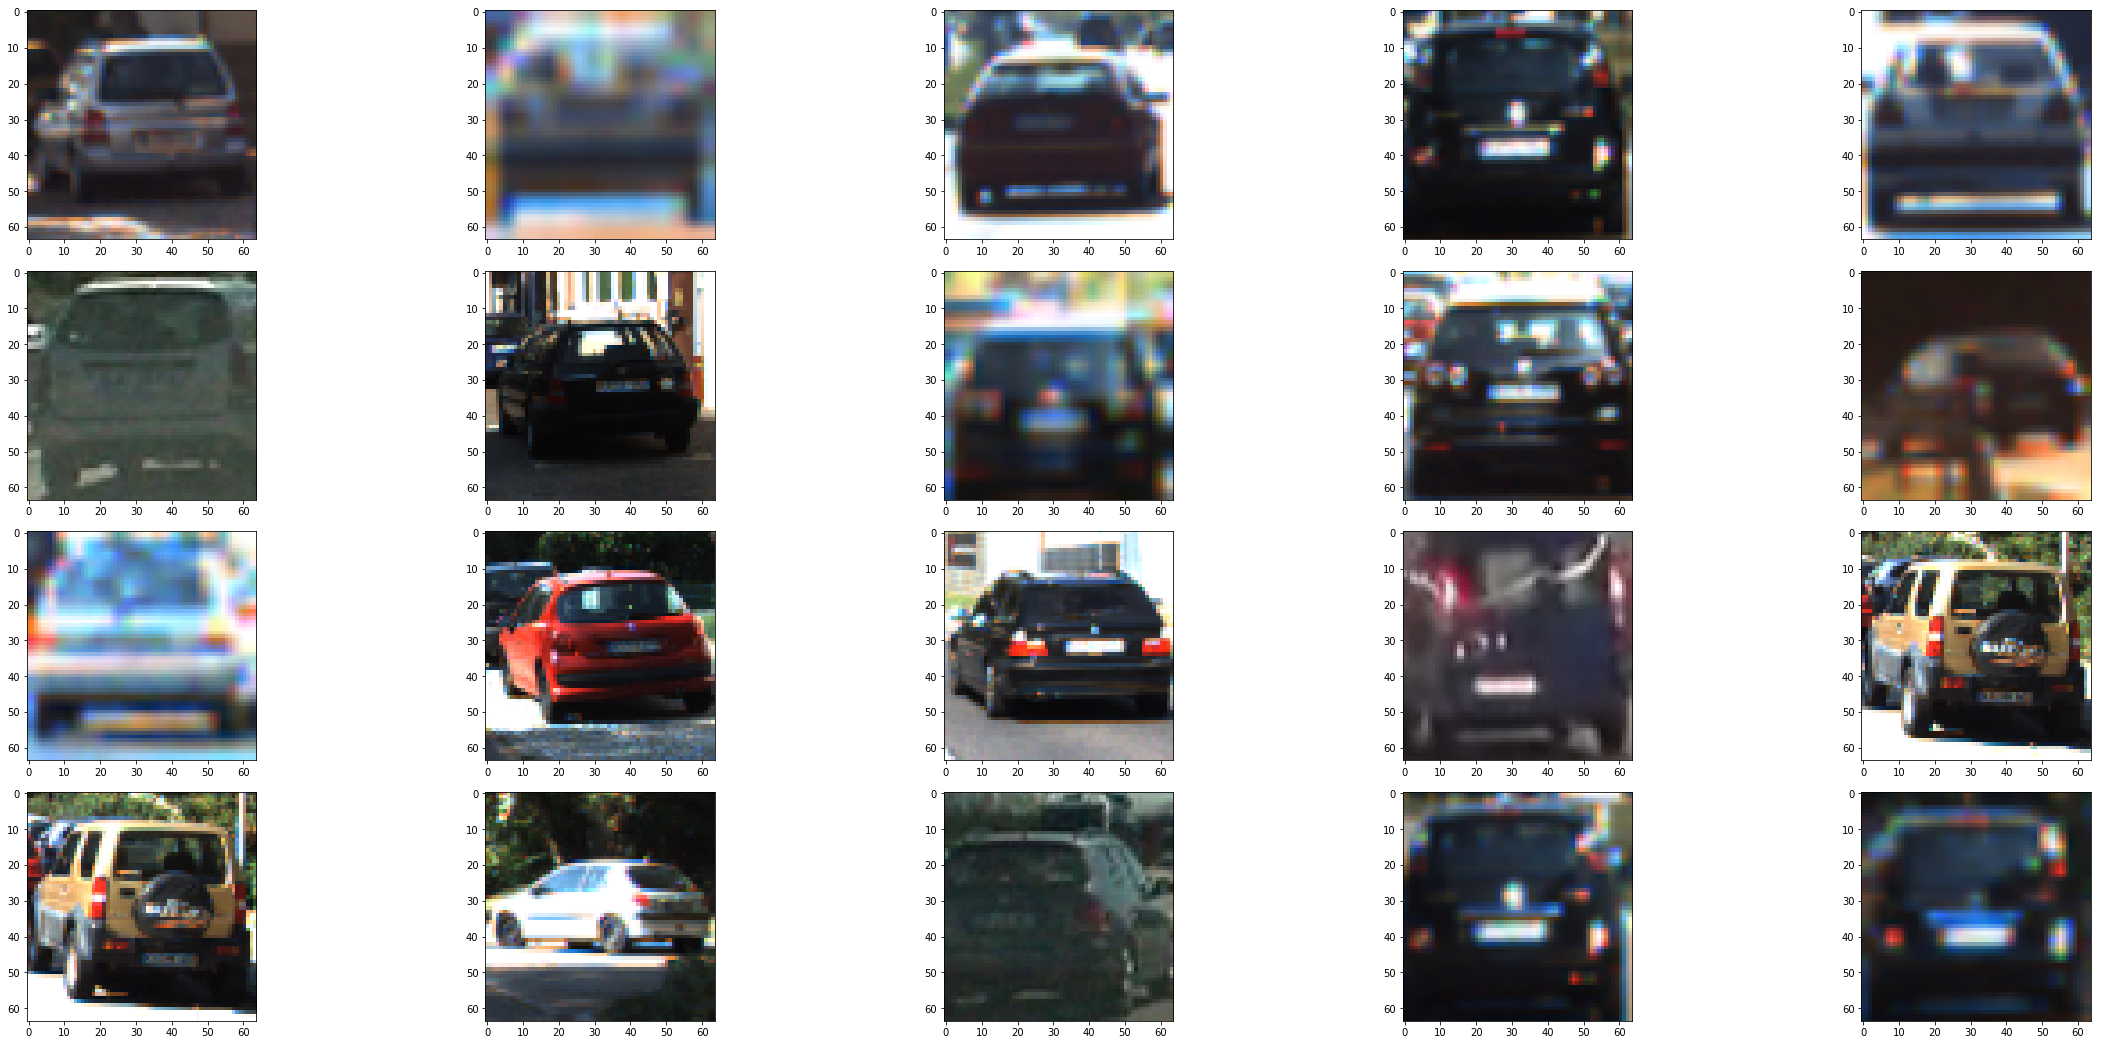

In [186]:
display_images(X_test[80:100])

# Search

In [187]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    resersed_window_list = []
    x_offset = xspan % xy_window[0]
    y_offset = yspan % xy_window[1]
    reversed_window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0] + x_offset
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0] + y_offset
            endy = starty + xy_window[1]
            
            # Append window position to list
            resersed_window_list.append(((startx, starty), (endx, endy)))
        
    # Return the list of windows
    return window_list + reversed_window_list

In [188]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

In [189]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, model):    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    test_imgs = np.array([cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
                          for window in windows])
    
    predictions = model.predict(test_imgs)
    for i in range(predictions.shape[0]):
        prediction = predictions[i][1]
        #print(prediction)
        
        if prediction > 0.5:
            on_windows.append(windows[i])
            
    #8) Return windows for positive detections
    return on_windows

In [190]:
#image = read_img('test_images/test1.jpg', scale_to_255=False)

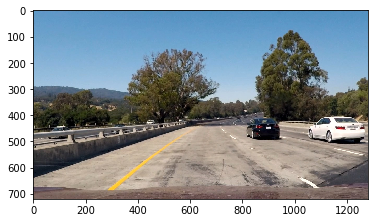

In [191]:
img = np.asarray(image.load_img('test_images/test1.jpg')).astype(np.float32)/255.0
plt.imshow(img)
plt.show()

In [192]:
img.min(), img.max()

(0.0, 1.0)

In [193]:
y_start_stop = [400, None]

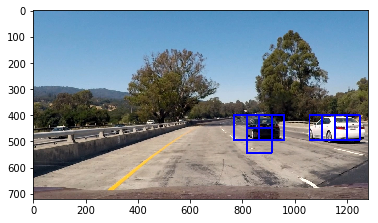

In [194]:
draw_img = np.copy(img)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(img, windows, model)

window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 1.0), thick=6)                    

plt.imshow(window_img)
plt.show()

In [195]:
img.shape

(720, 1280, 3)

In [196]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_bbox_area(bbox):
    (x0, y0), (x1, y1) = bbox
    
    return (x1-x0)*(y1-y0)

def draw_labeled_bboxes(img, labels):
    _img = img.copy()
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(_img, bbox[0], bbox[1], (0,0,1.0), 6)
            
    # Return the image
    return _img

In [197]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)

0.0 3.0


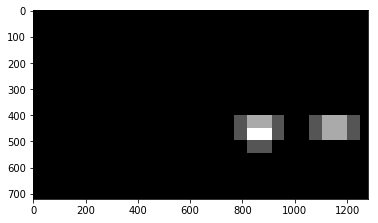

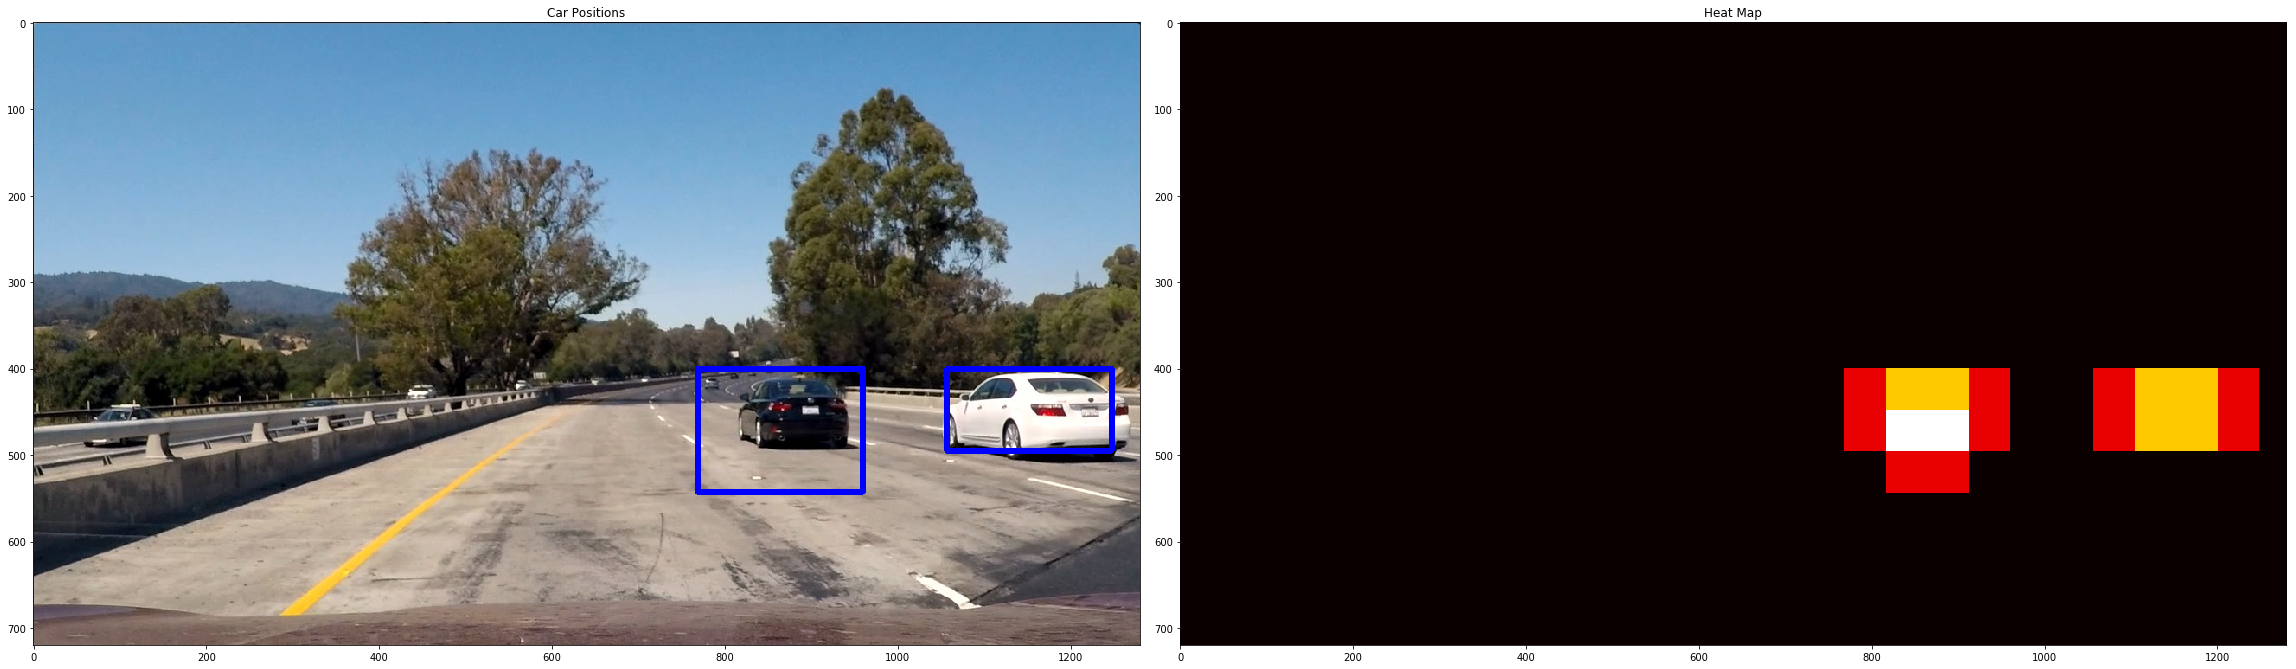

In [198]:
# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
print(heat.min(), heat.max())

plt.imshow(heat, cmap='gray')
plt.show()

# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.figure(figsize=(32, 32))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.tight_layout()
plt.show()

In [199]:
def get_labeled_img_with_heatmap(img, model, x_start_stop=[None, None], y_start_stop=[400, None], 
                                 xy_window_arr=[(64, 64), (128, 128)], xy_overlap=(0.5, 0.5),
                                 heat_threshold=0, hot_windows_arr=[], max_hot_windows=5):    
    windows = []
    for xy_window in xy_window_arr:
        windows += slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                                xy_window=xy_window, xy_overlap=xy_overlap)
    #print(windows)

    hot_windows = search_windows(img, windows, model)
    
    hot_windows_arr.append(hot_windows)
    if len(hot_windows_arr) > max_hot_windows:
        hot_windows_arr = hot_windows_arr[-max_hot_windows:]
        
    hot_windows = []
    for curr_hot_windows in hot_windows_arr:
        hot_windows += curr_hot_windows
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 1.0).astype(np.uint8)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap, hot_windows_arr

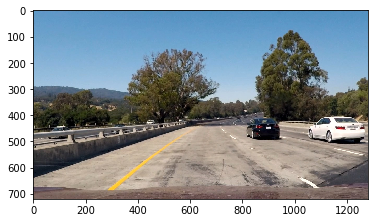

In [200]:
plt.imshow(img)
plt.show()

In [201]:
draw_img, heat_map, hot_windows_arr = get_labeled_img_with_heatmap(img, model, 
                                                                   x_start_stop=[None, None], 
                                                                   y_start_stop=[400, None], 
                                                                   xy_window_arr=[(64, 64),(128,128)], xy_overlap=(0.5, 0.5), 
                                                                   heat_threshold=0, max_hot_windows=5)

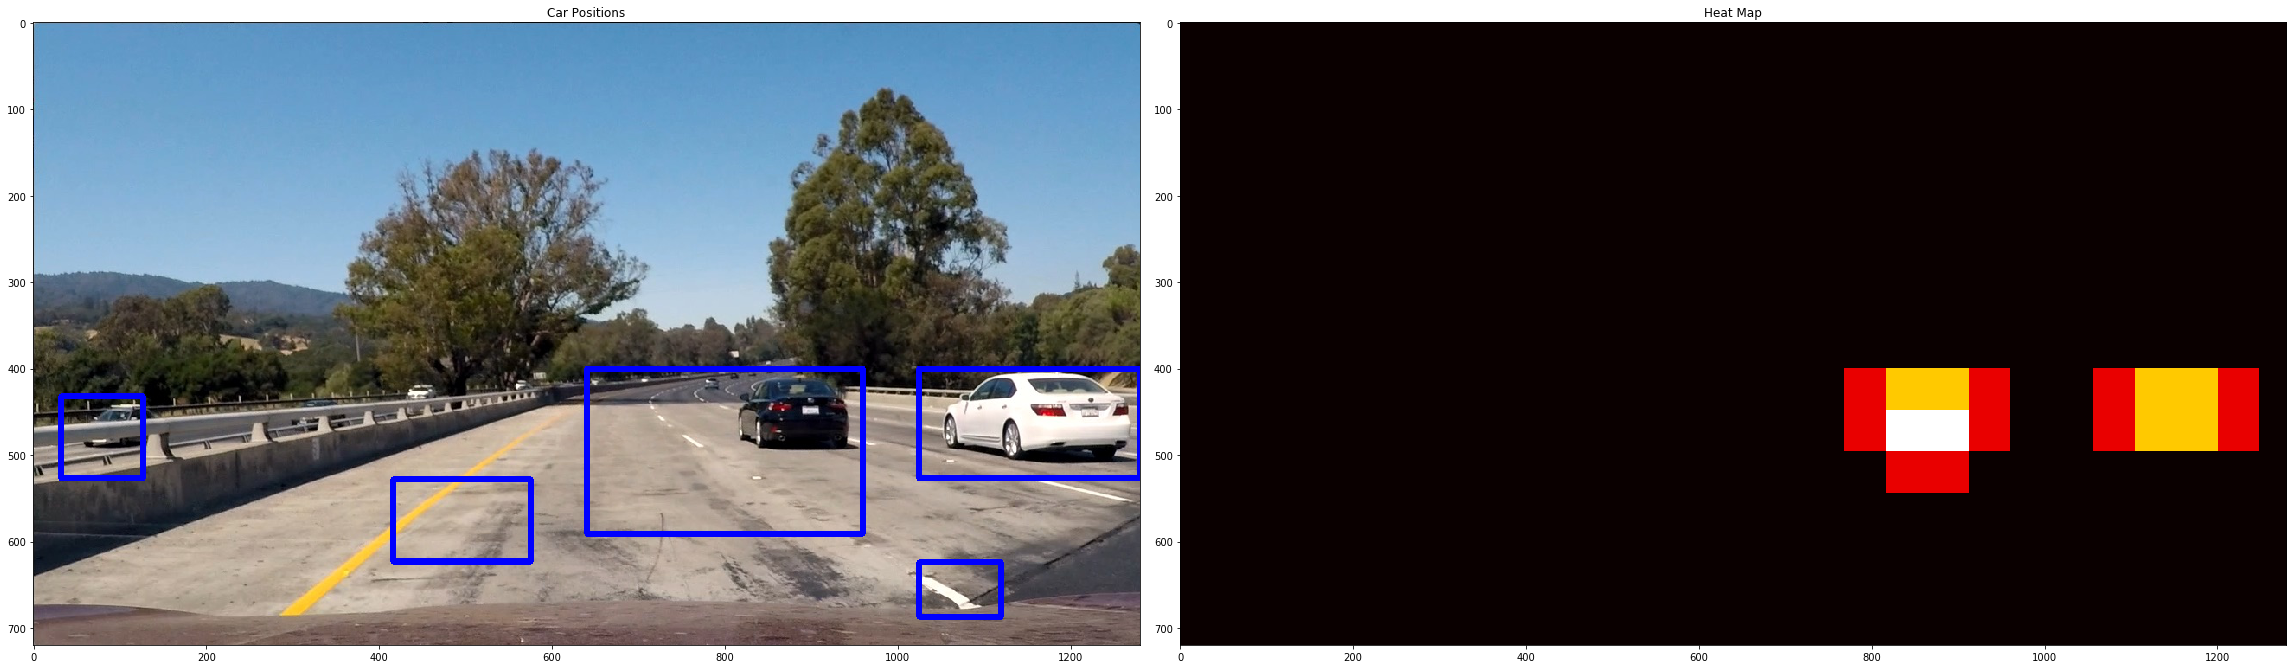

In [202]:
plt.figure(figsize=(32, 32))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.tight_layout()
plt.show()

In [203]:
output_dir = 'output_images' 

In [204]:
project_img_files = sorted(glob.glob('%s/*.jpg' % output_dir))
sample_project_imgs = read_imgs(project_img_files[:10], scale_to_255=False)
sample_project_imgs[0].min(), sample_project_imgs.max()

(0, 255)

In [205]:
output_dir = '%s/car_boxes' % data_dir

In [206]:
os.makedirs(output_dir, exist_ok=True)
draw_dir = '%s/draw_imgs' % output_dir
os.makedirs(draw_dir, exist_ok=True)
heat_map_dir = '%s/heat_maps' % output_dir
os.makedirs(heat_map_dir, exist_ok=True)

In [284]:
def convert_heatmap_to_img(heatmap):
    #fig = plt.figure(figsize=(24,16))
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    
    ax.imshow(heatmap, cmap="hot")
    ax.axis('tight')
    ax.axis('off')

    fig.canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    width = int(width)
    height = int(height)
    return np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

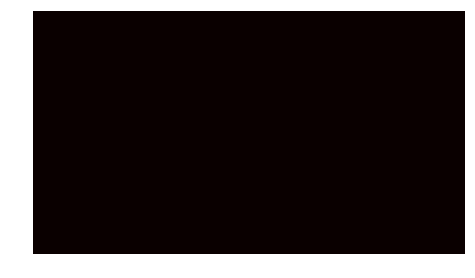

In [285]:
plt.imshow(convert_heatmap_to_img(heat_map))
plt.show()

In [286]:
def add_heatmap_to_img(img, heatmap, top_heatmap_val=10):
    small_height = int(img.shape[0]/4.0)
    small_width = int(img.shape[1]/4.0)
    
    small_heatmap = resize(convert_heatmap_to_img(heatmap), (small_height, small_width))
    
    _img = img.copy()   
    _img[:small_height, -small_width:] = small_heatmap
    
    return _img

In [293]:
def add_frame_txt(img, text_str, pos=(10,60), text_color = (12, 12, 12)):
    output_img = img.copy()
                  
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output_img, frame_id_txt, pos, font, 2, text_color,2,cv2.LINE_AA)   
    
    return (255.0*output_img).astype(np.uint8)

  0%|                                                                                         | 0/1248 [00:00<?, ?it/s]C:\Users\ekkus93\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  2%|█▎                                                                              | 20/1248 [00:25<25:35,  1.25s/it]C:\Users\ekkus93\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████████████████████████████████████████████████████████████████████████|

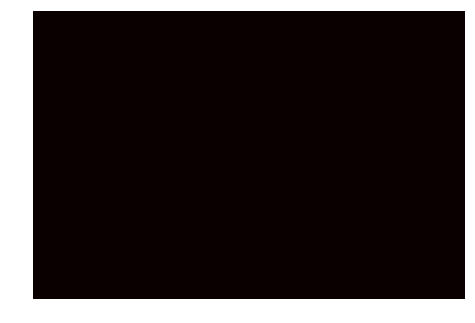

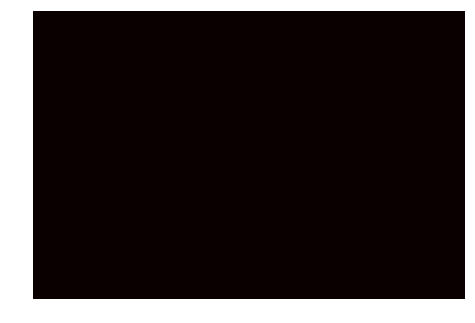

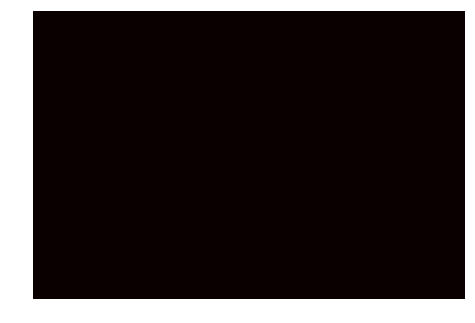

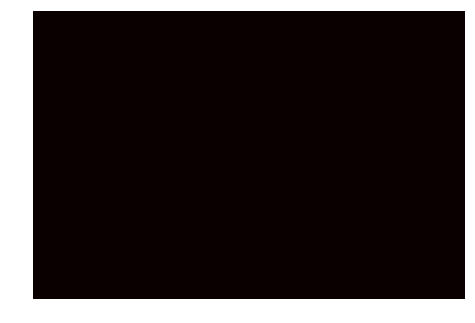

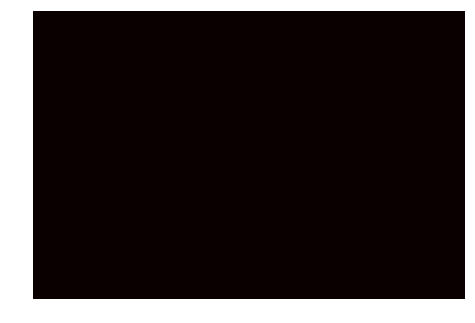

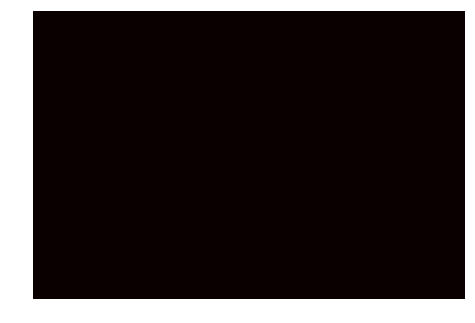

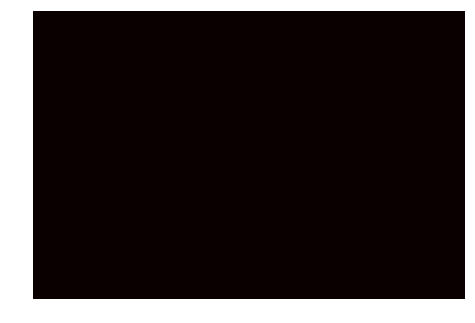

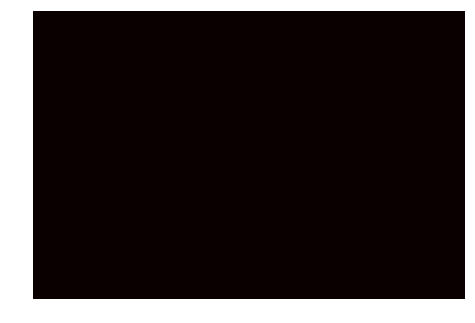

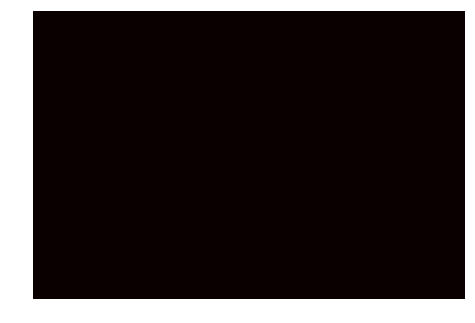

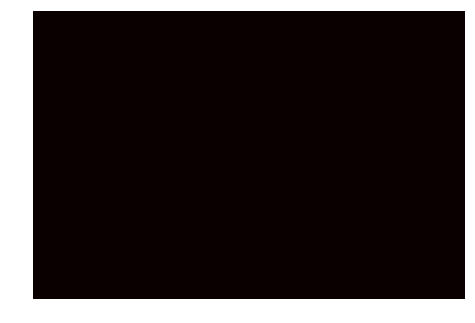

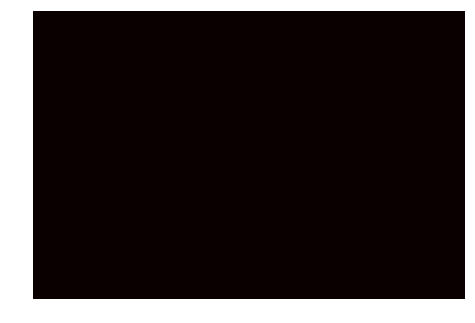

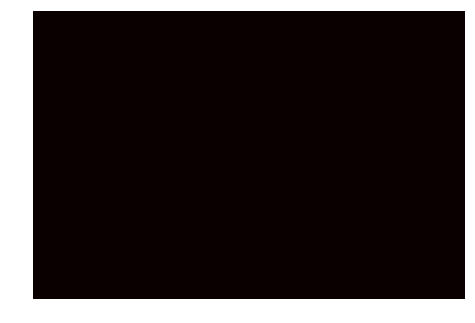

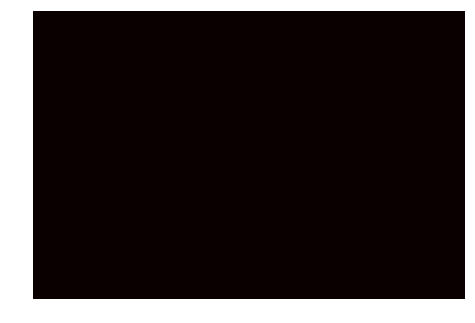

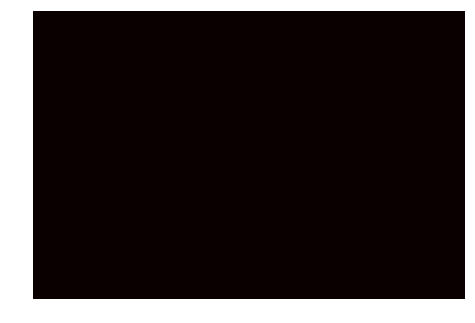

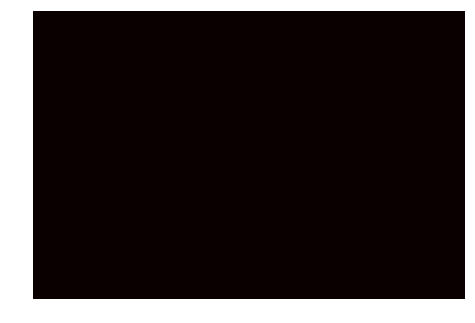

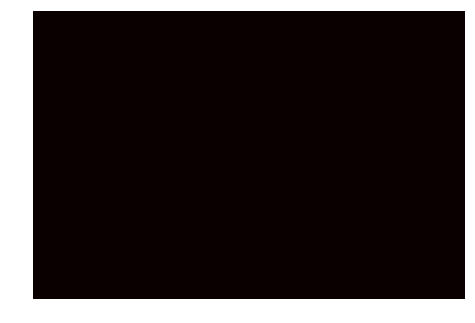

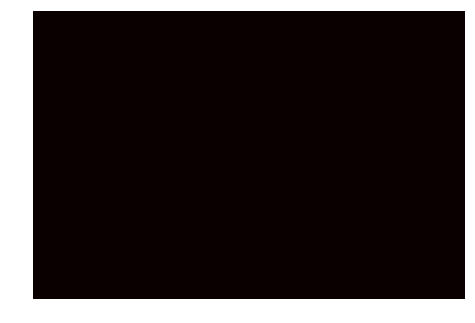

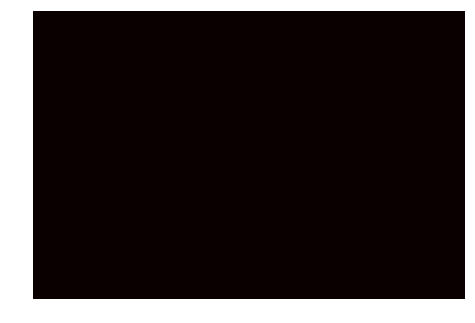

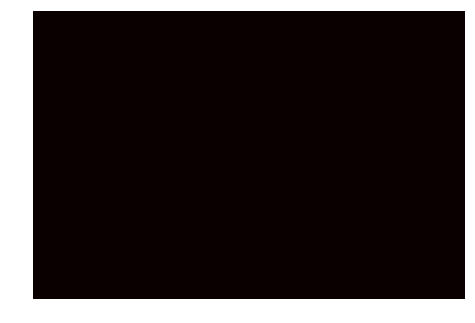

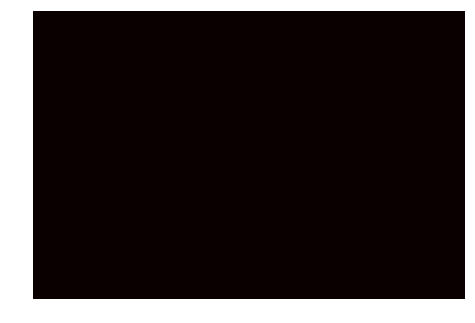

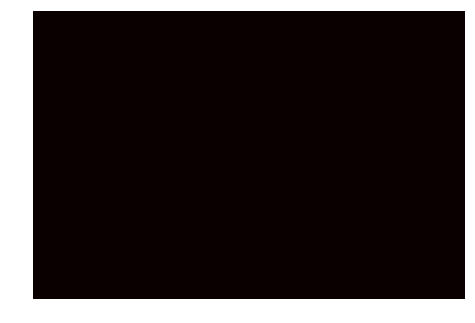

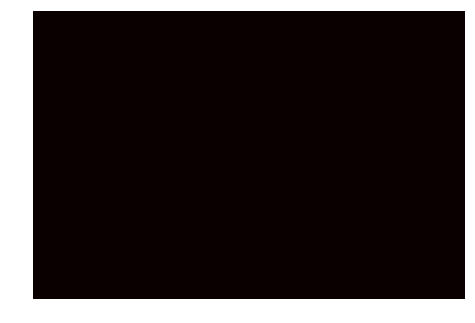

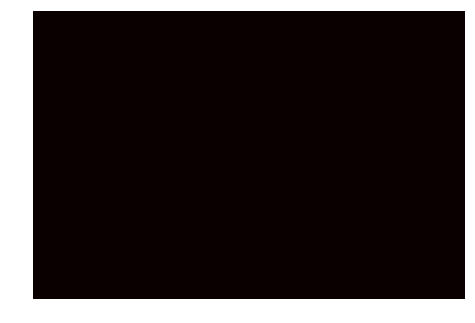

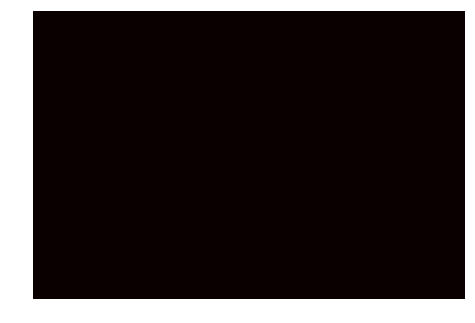

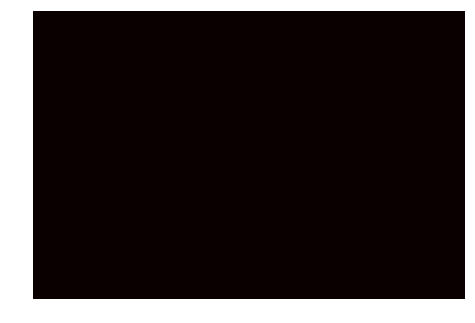

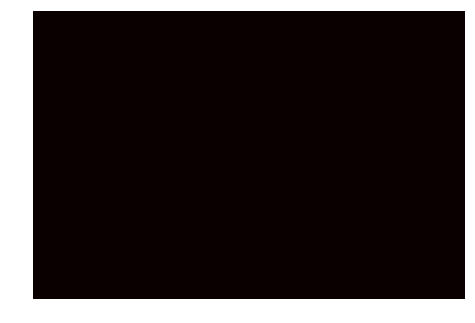

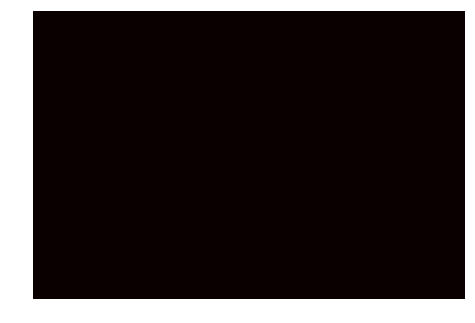

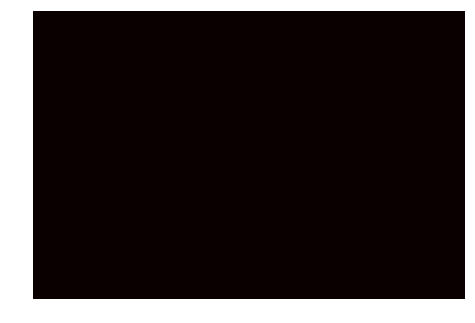

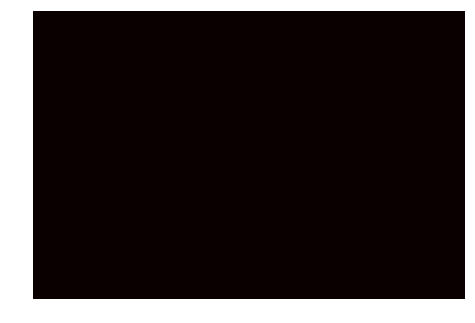

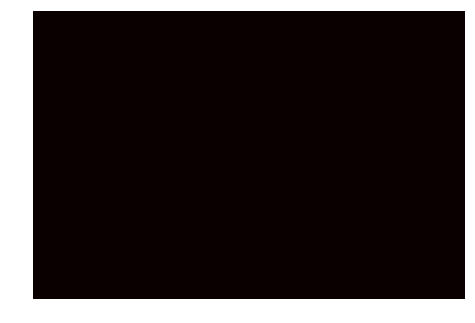

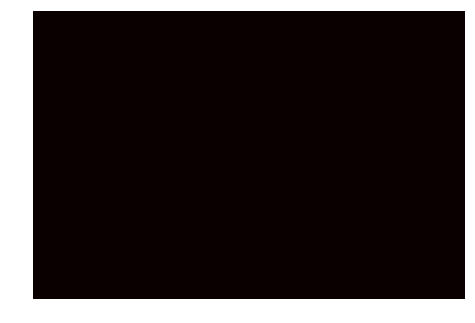

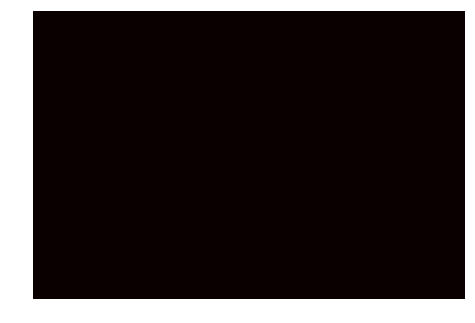

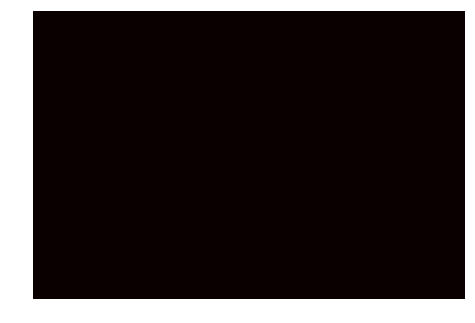

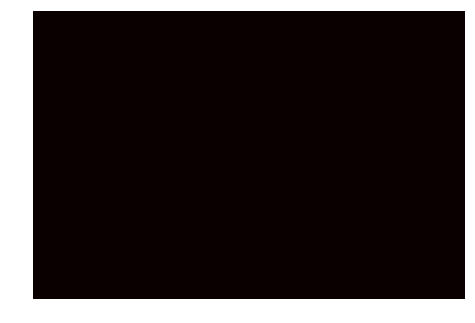

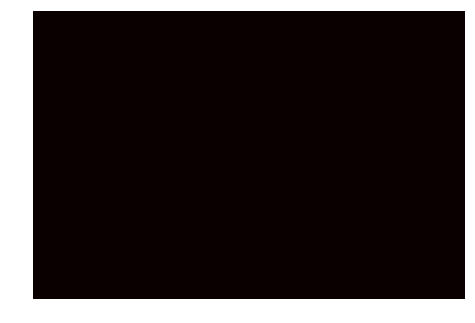

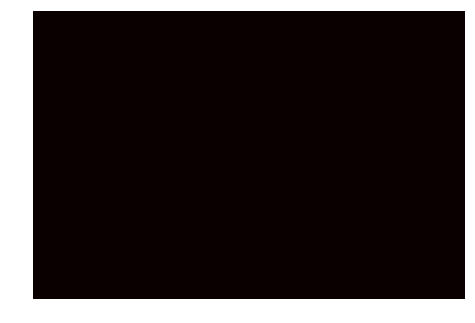

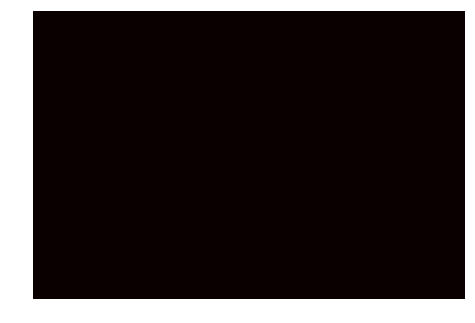

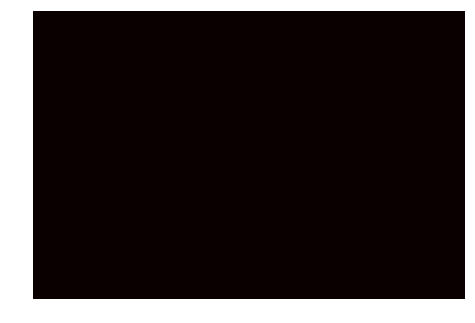

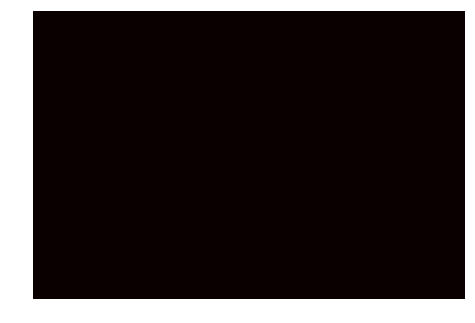

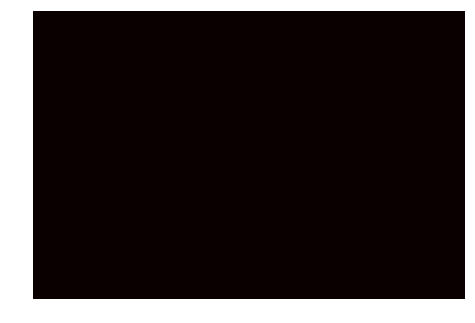

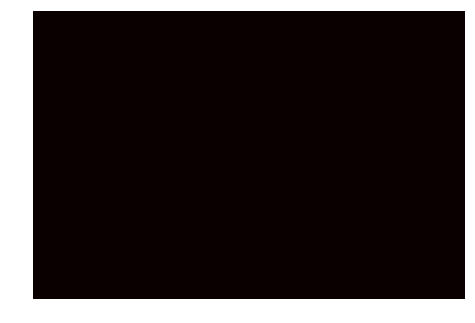

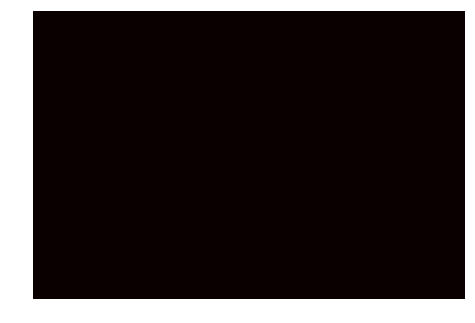

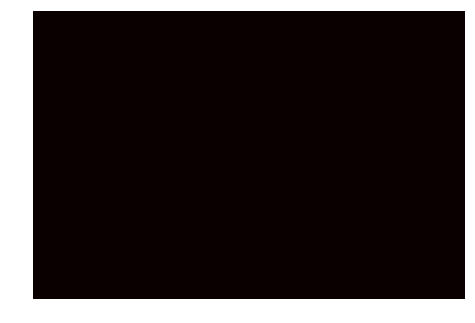

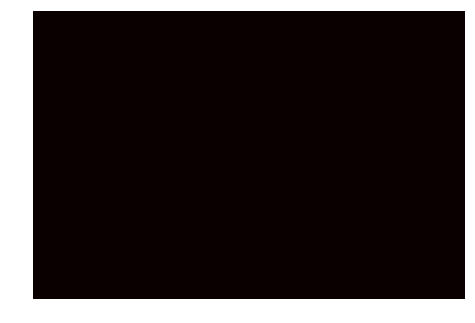

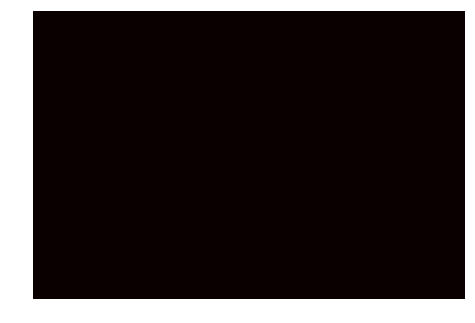

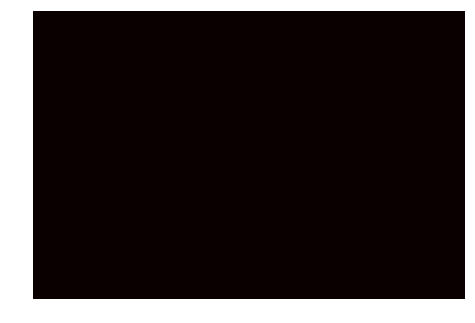

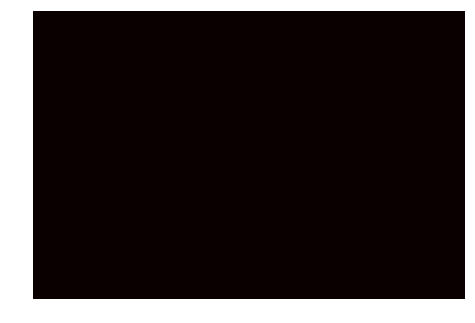

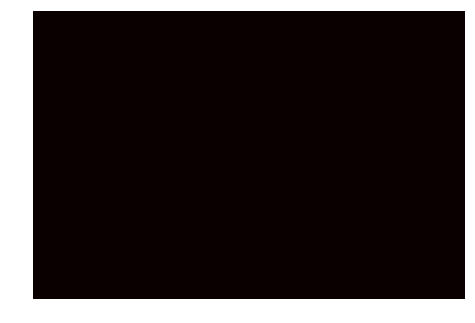

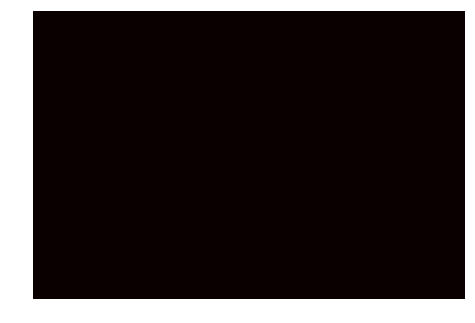

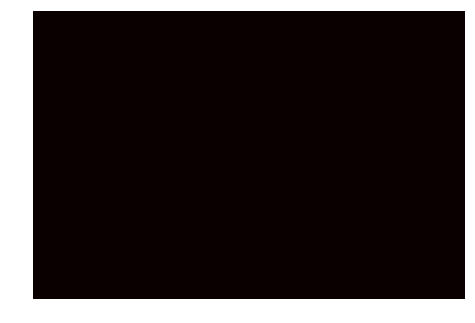

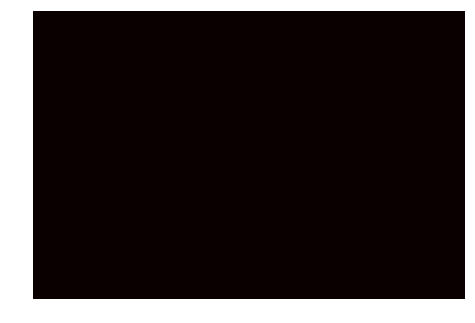

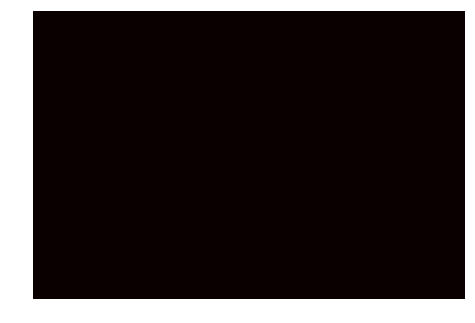

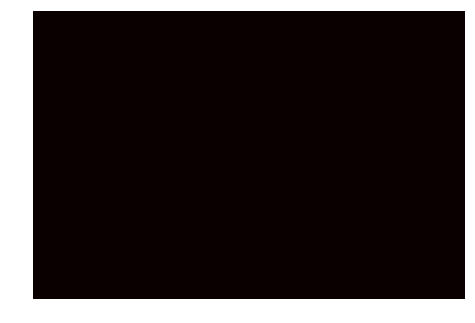

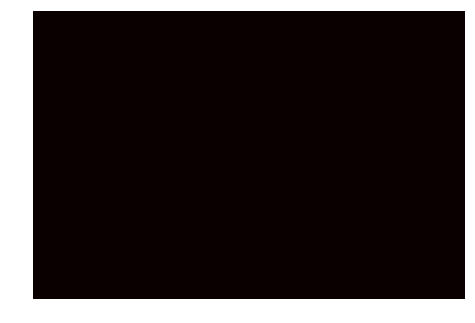

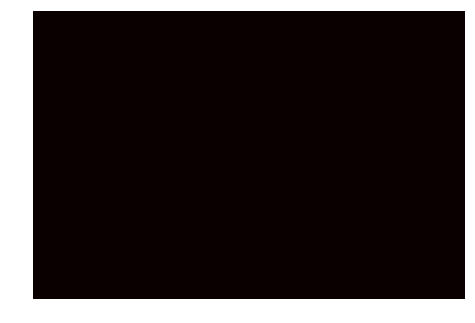

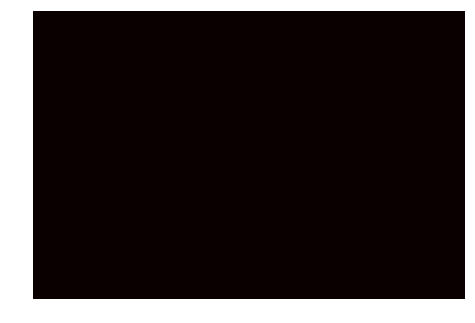

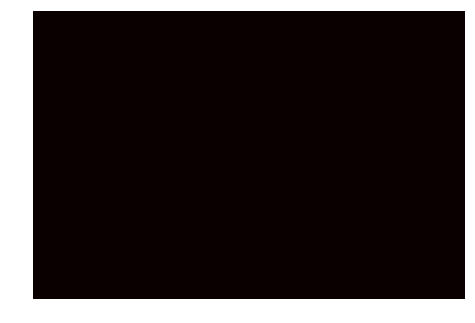

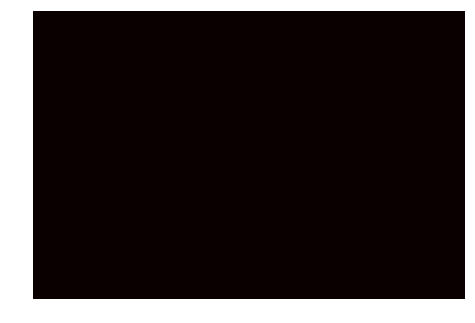

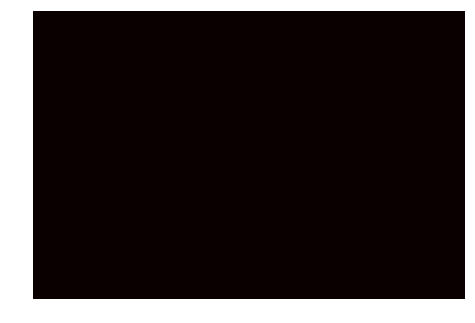

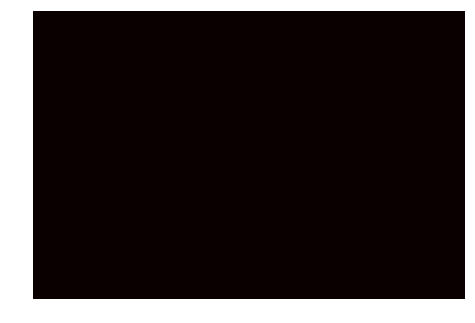

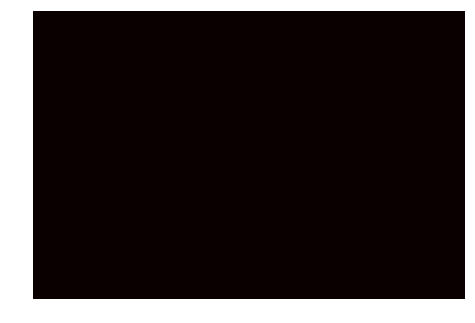

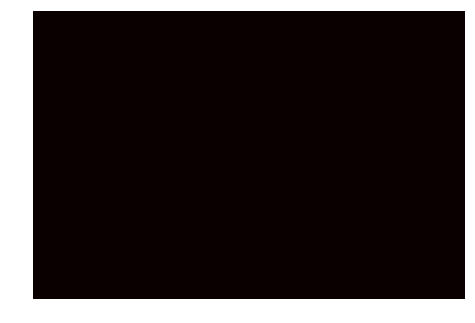

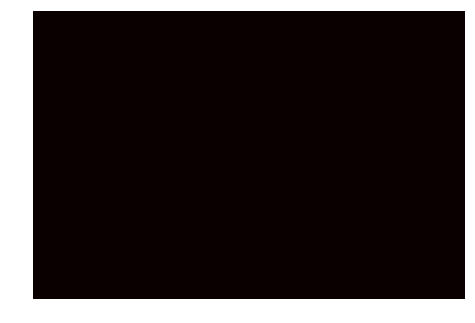

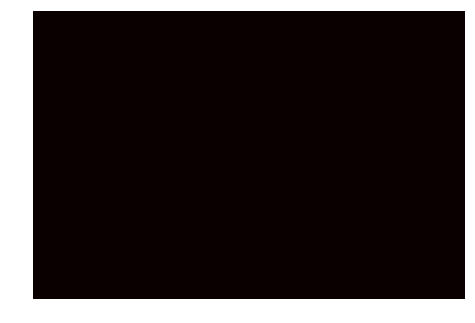

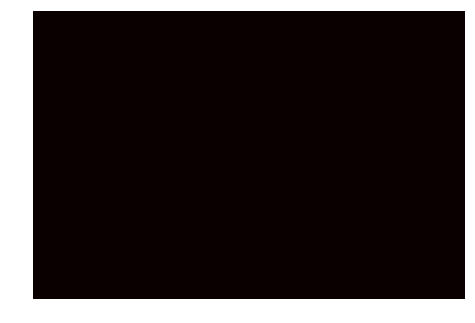

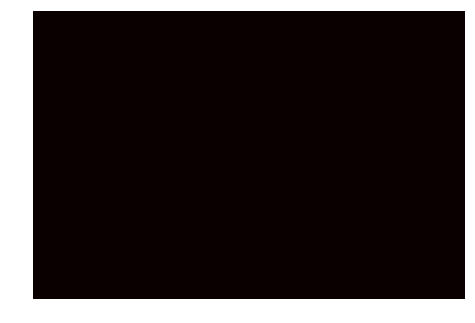

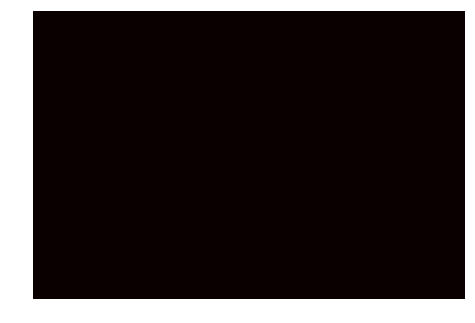

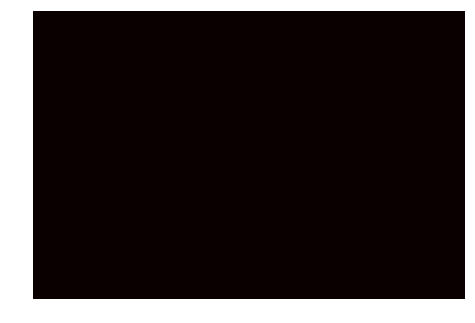

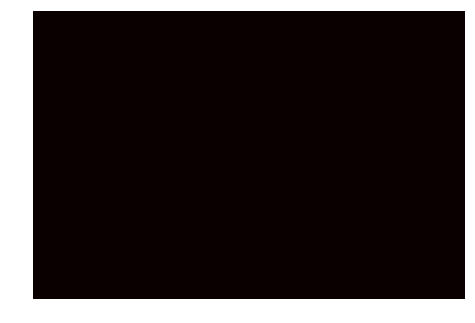

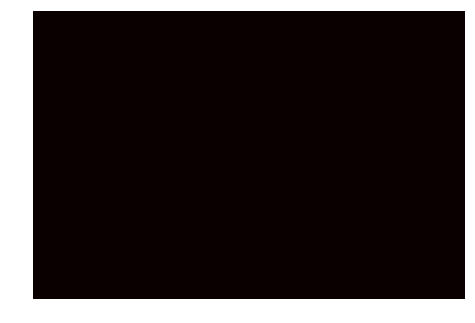

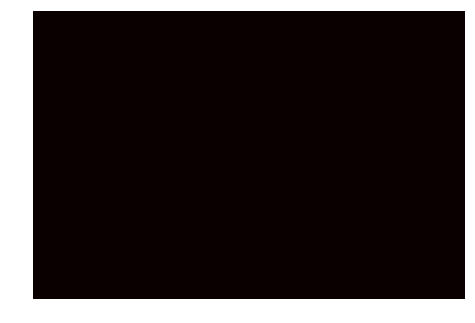

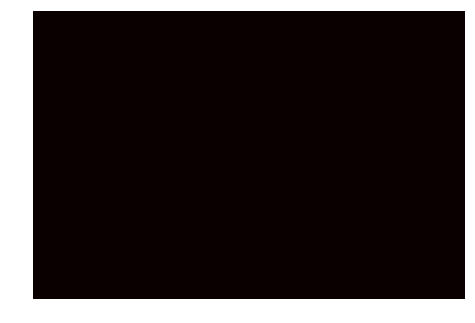

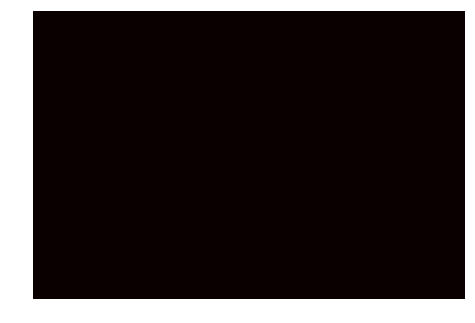

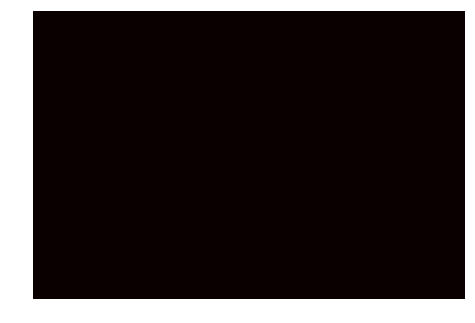

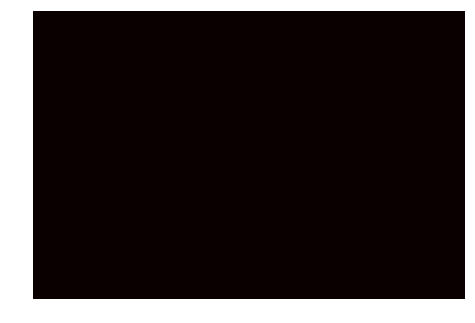

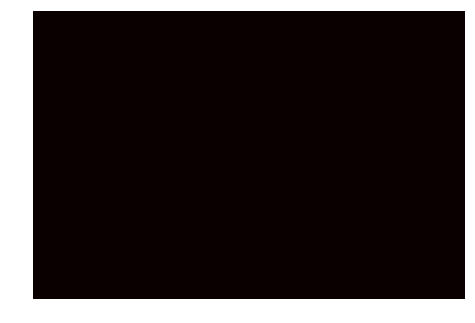

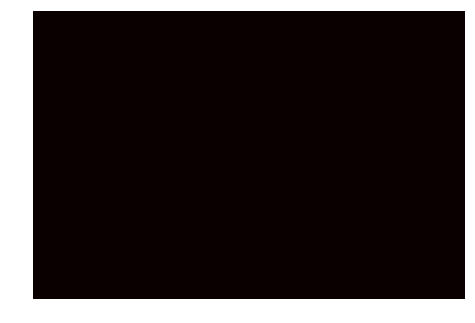

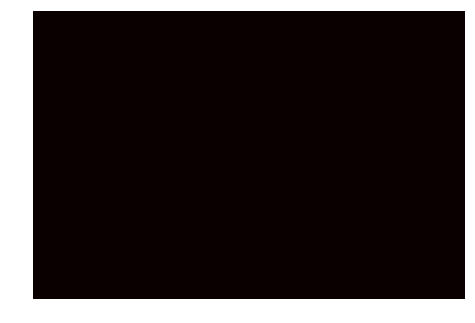

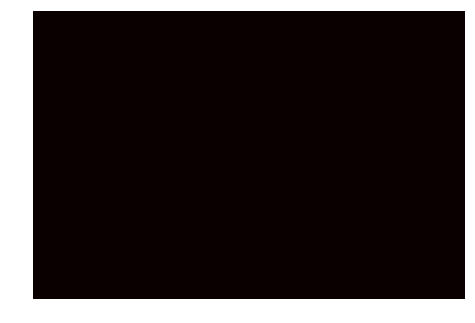

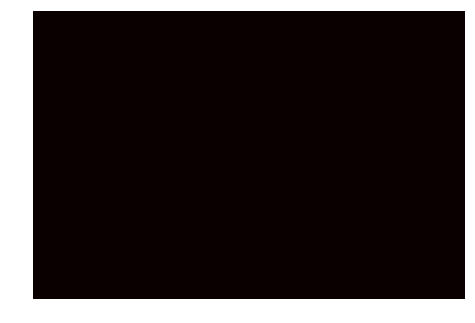

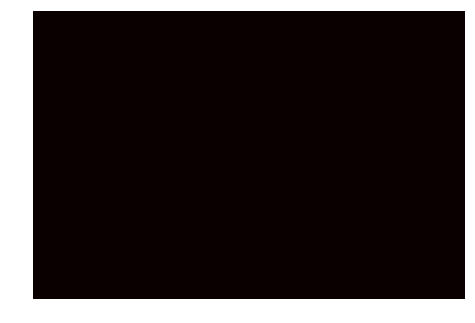

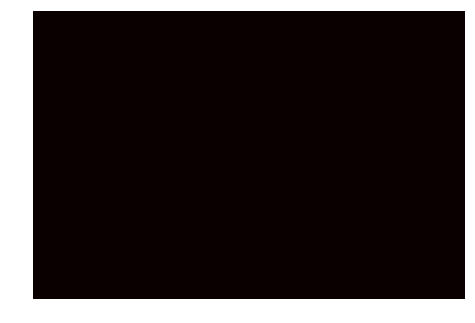

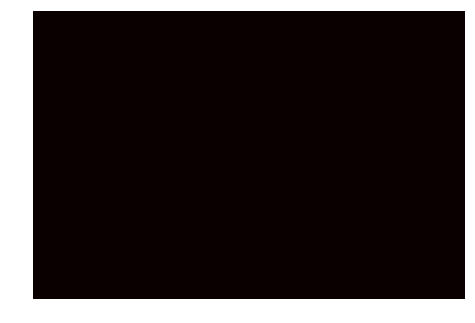

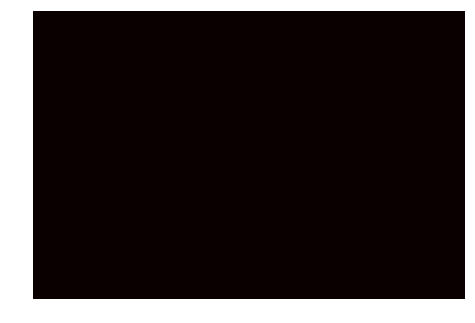

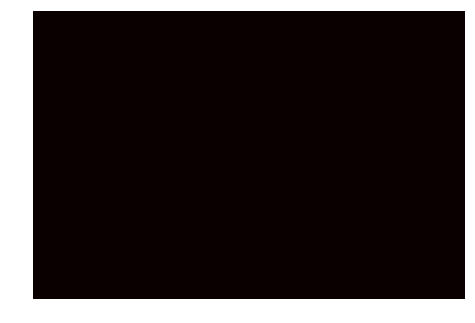

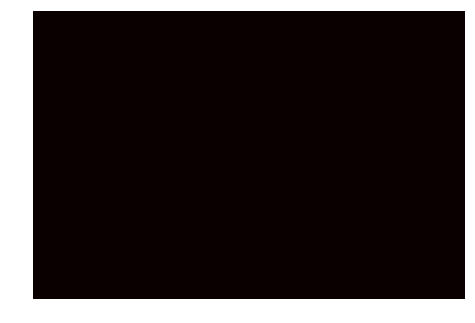

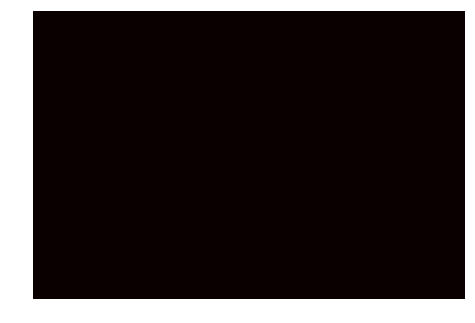

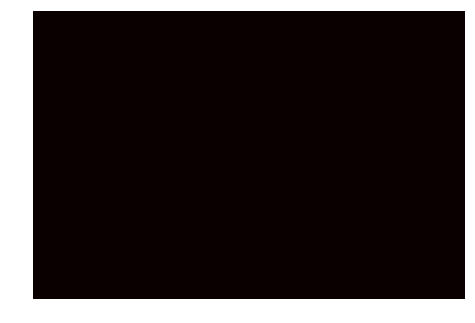

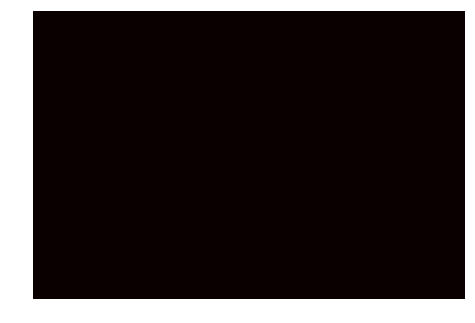

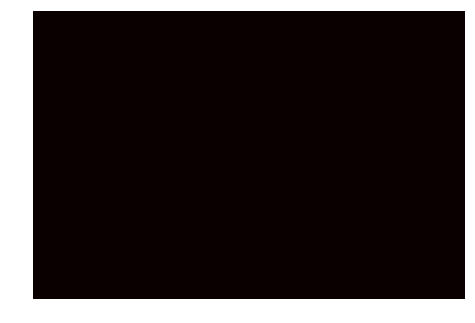

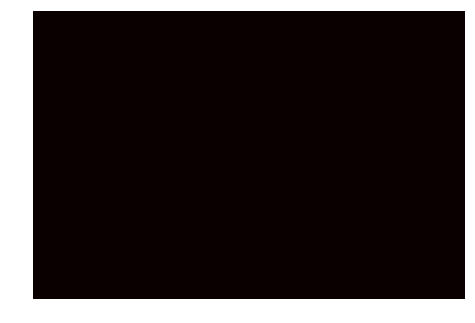

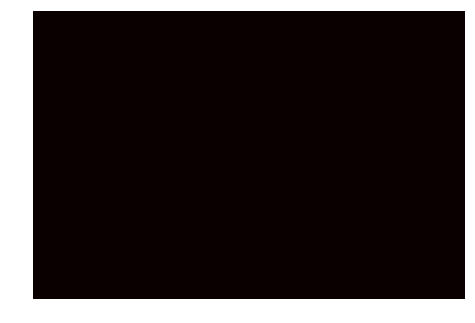

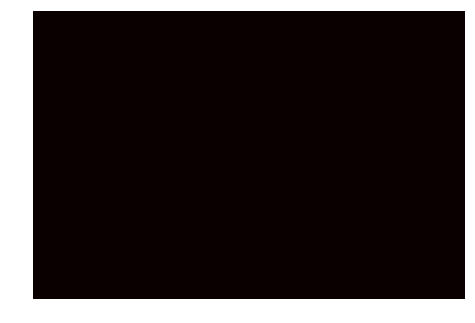

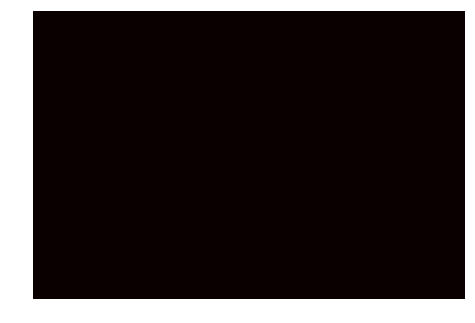

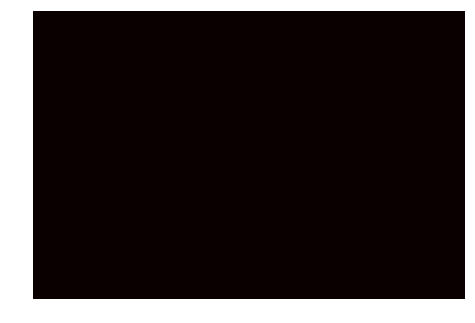

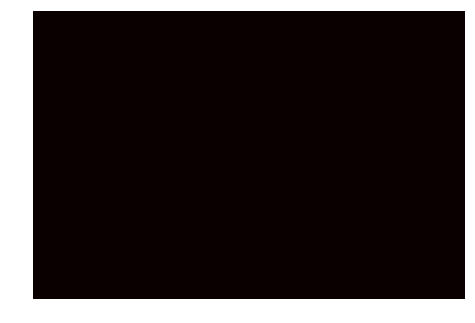

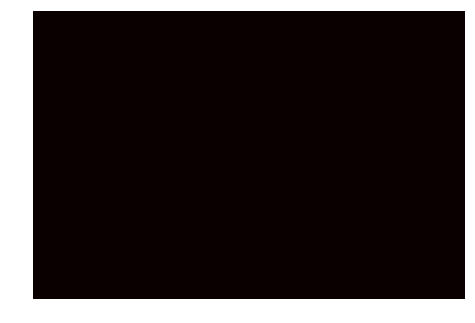

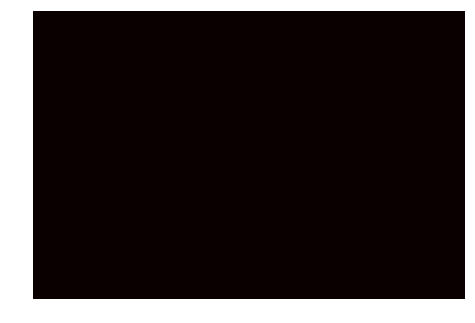

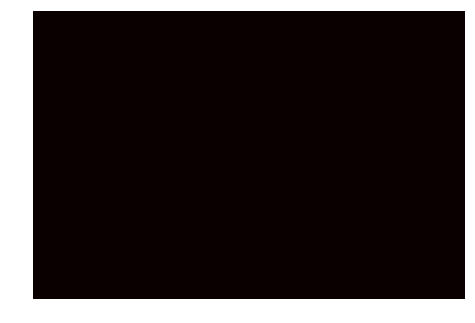

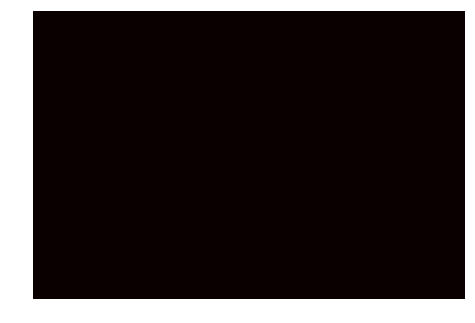

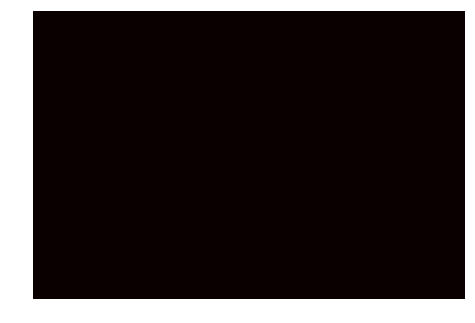

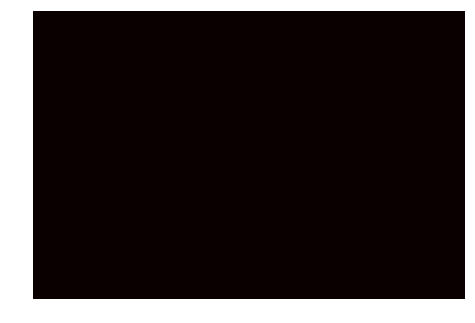

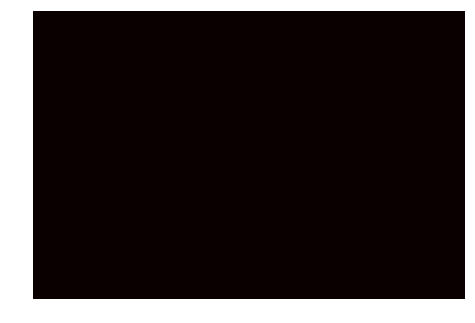

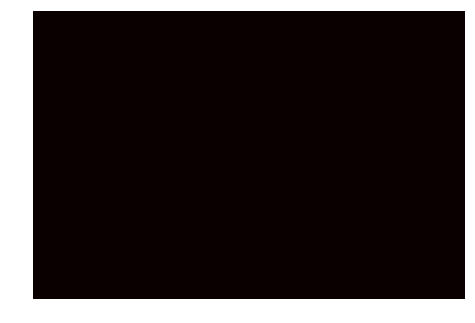

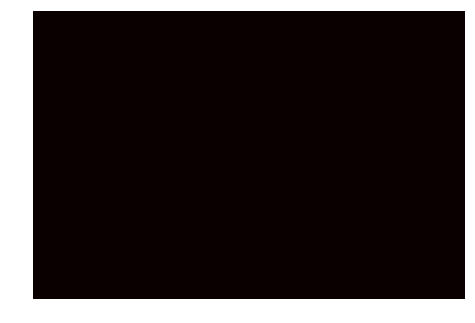

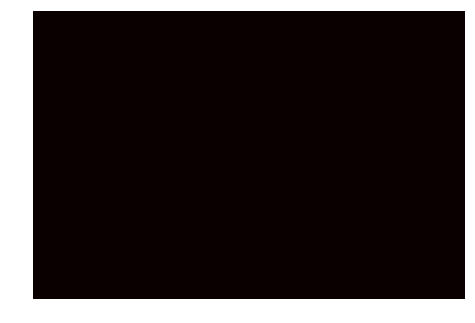

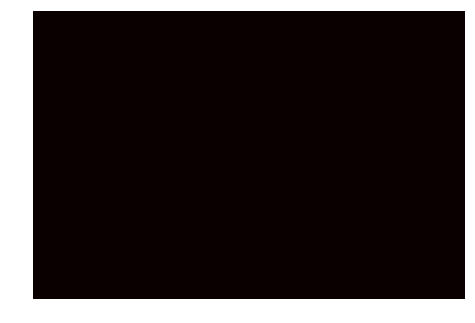

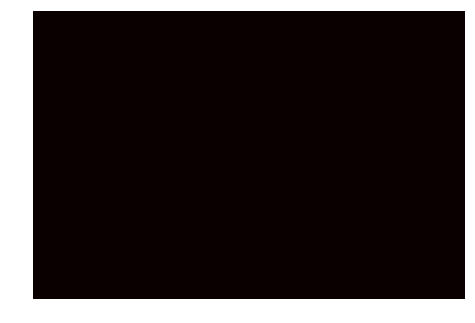

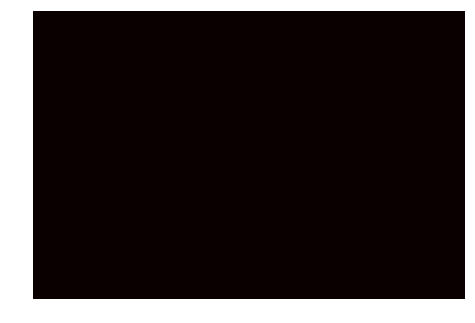

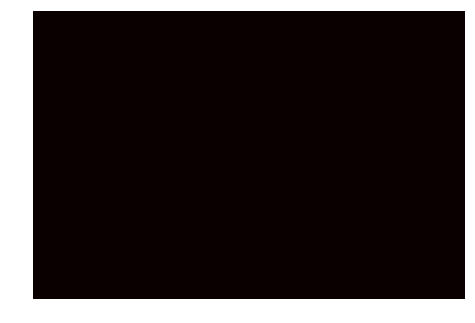

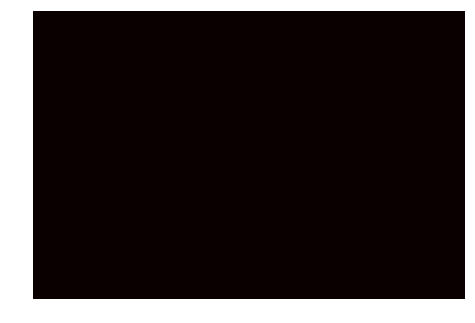

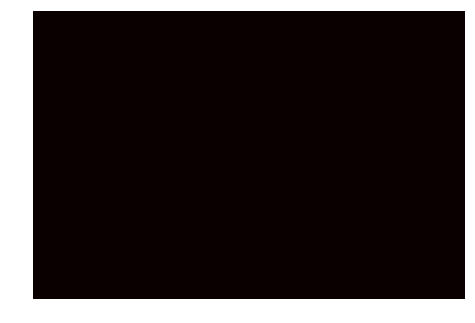

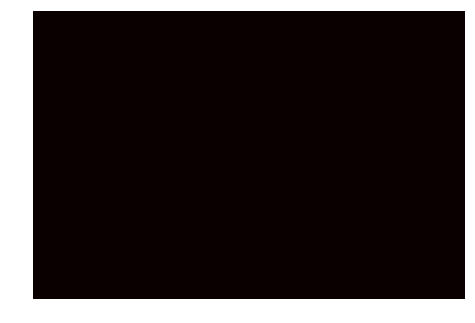

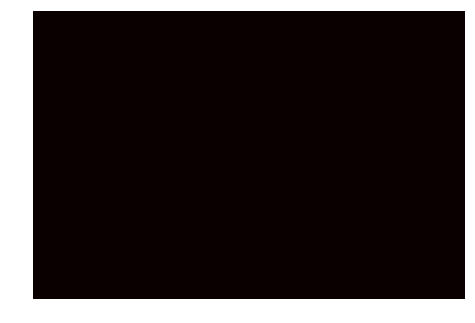

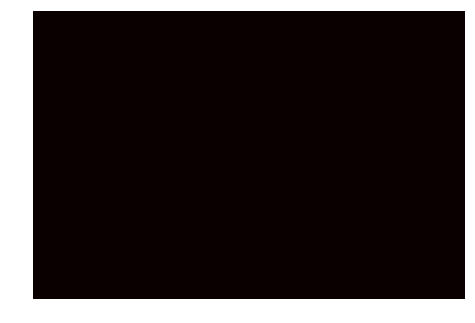

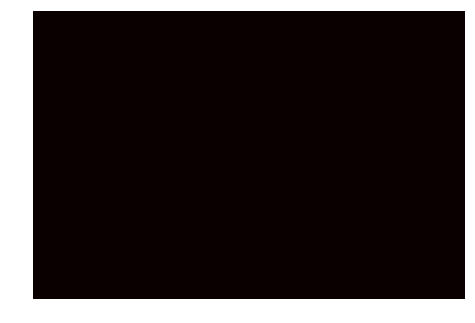

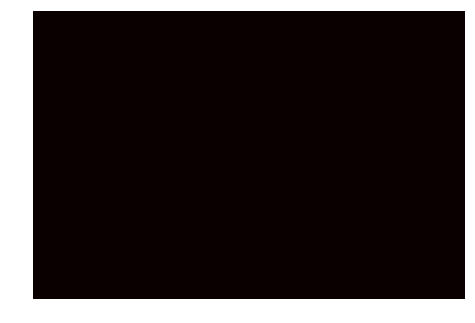

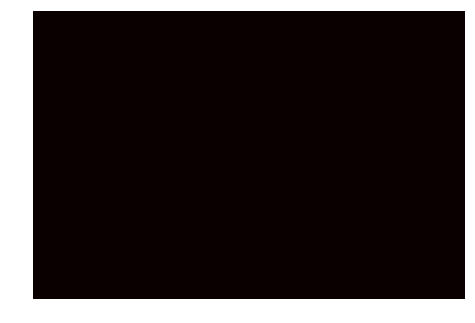

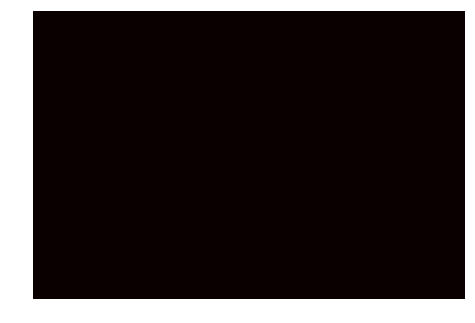

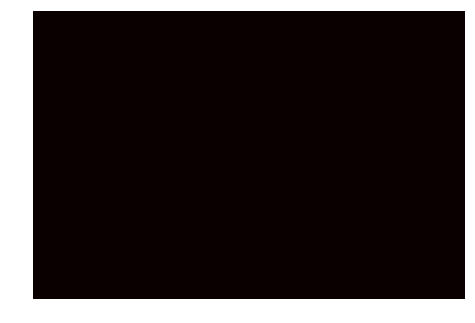

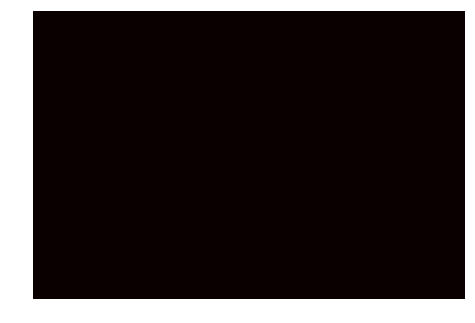

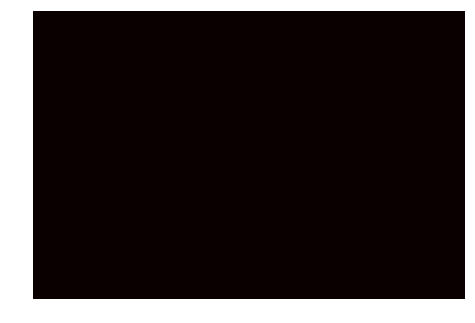

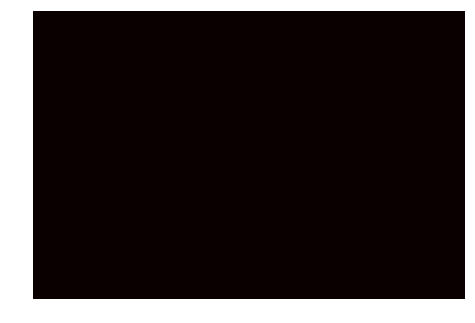

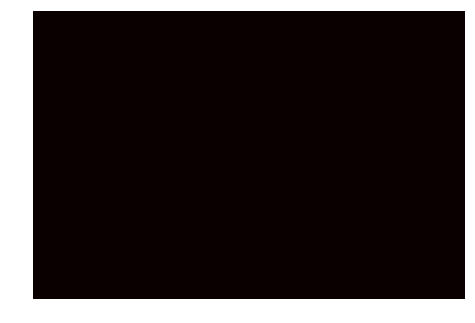

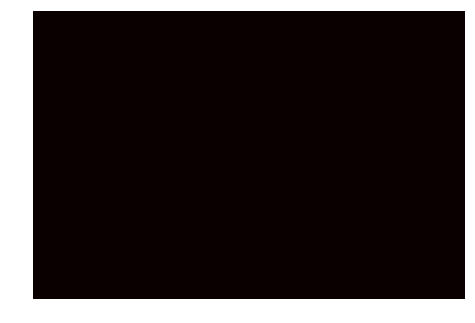

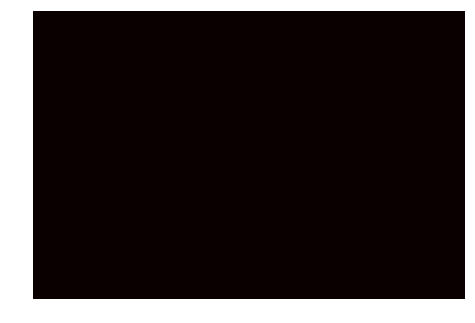

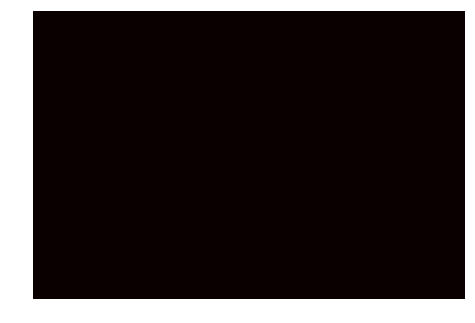

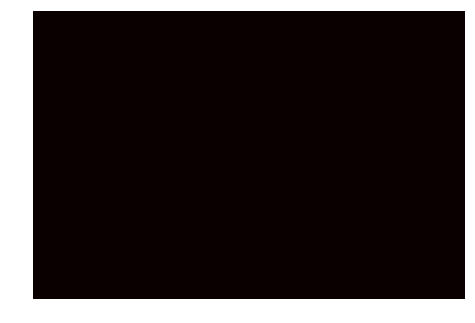

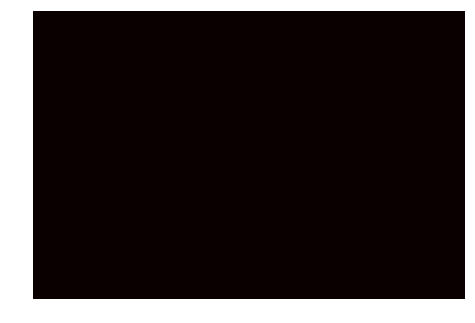

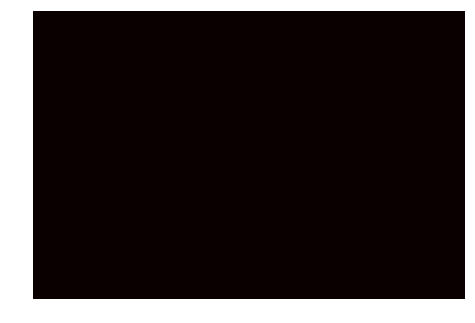

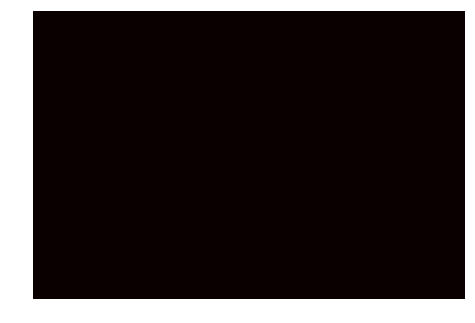

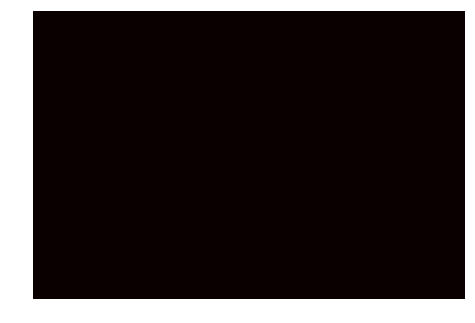

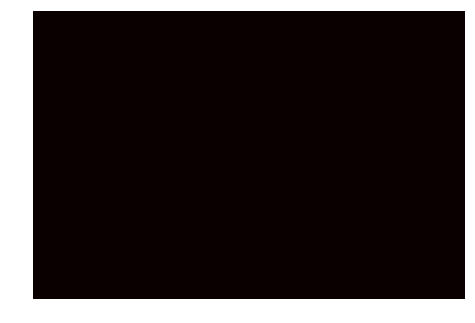

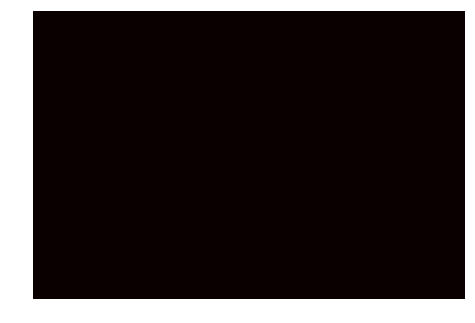

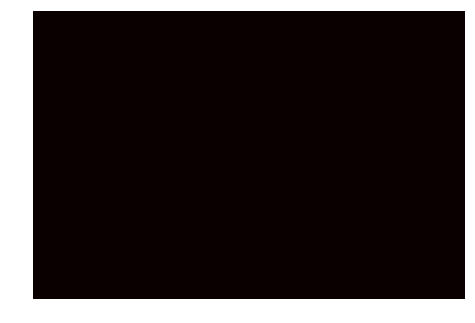

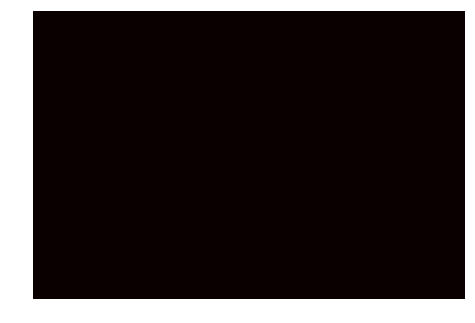

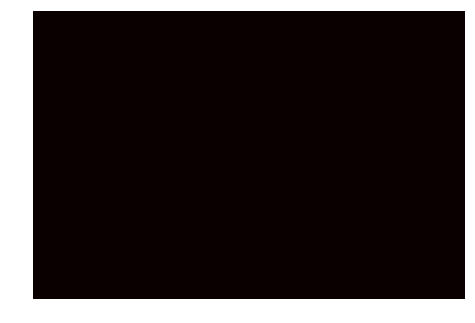

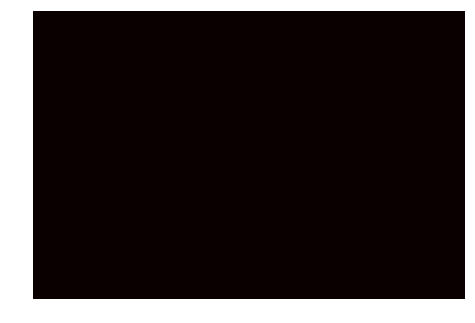

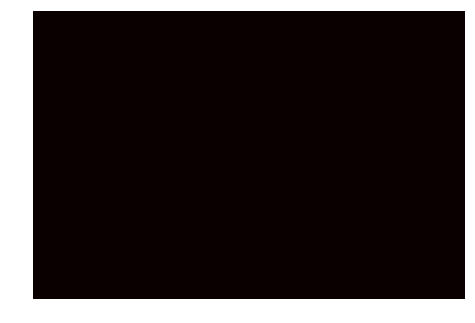

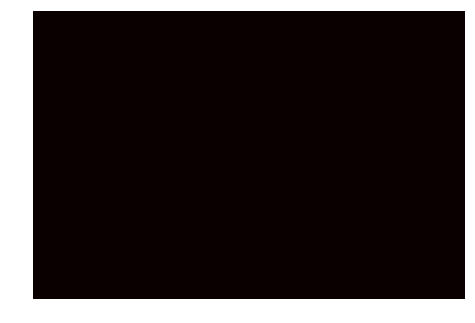

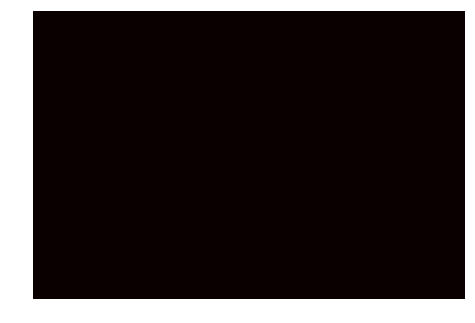

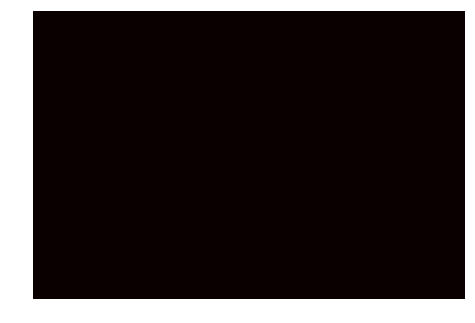

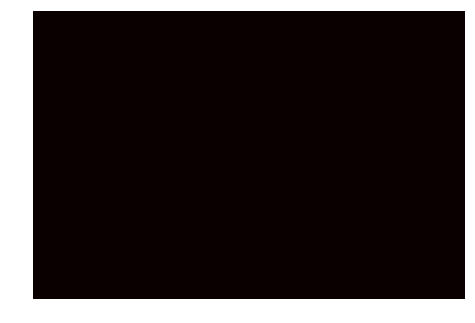

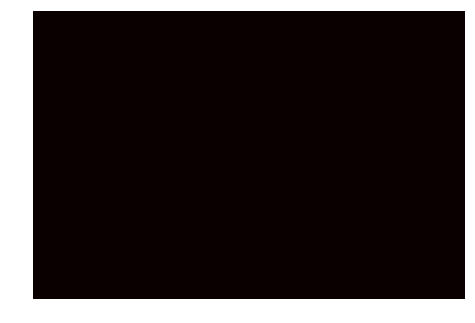

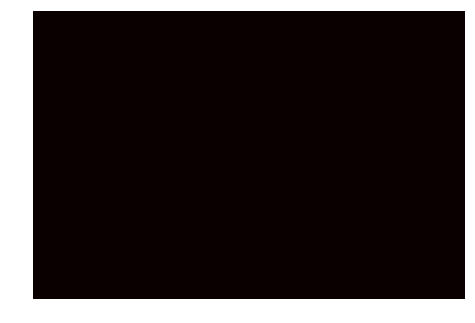

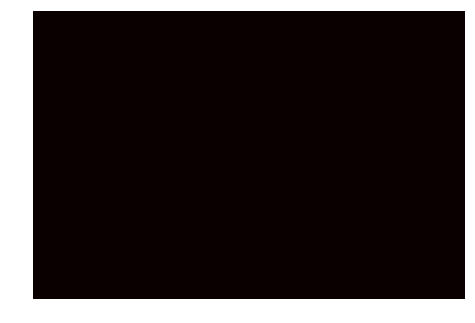

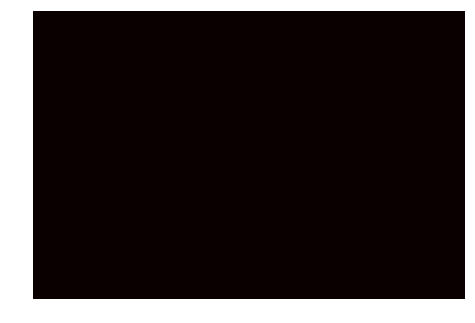

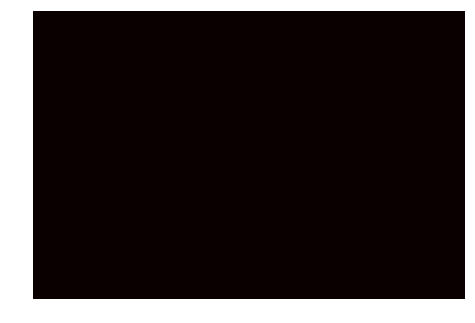

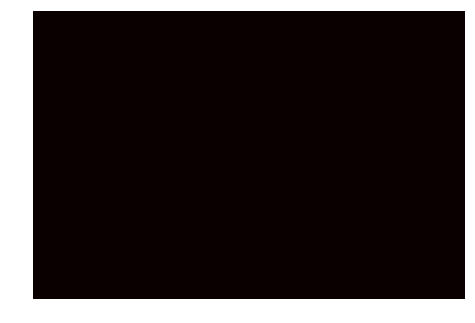

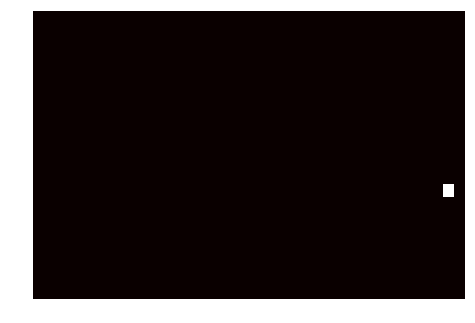

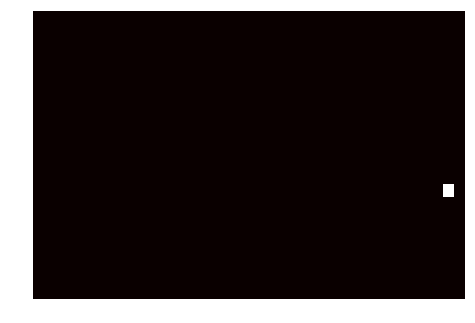

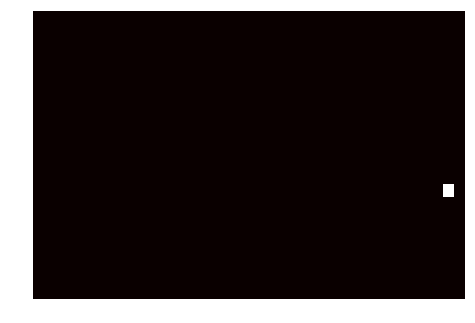

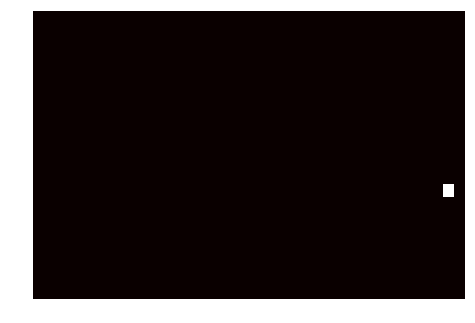

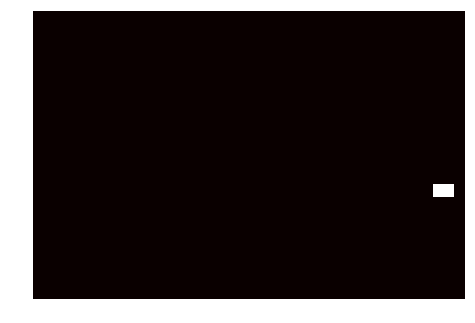

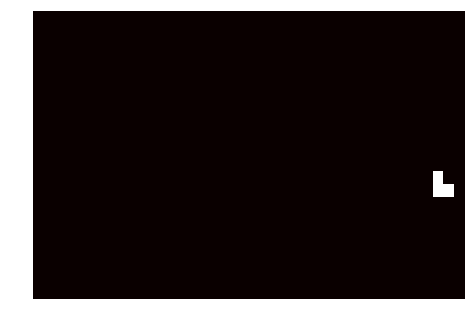

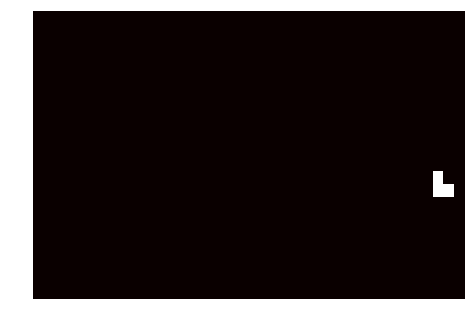

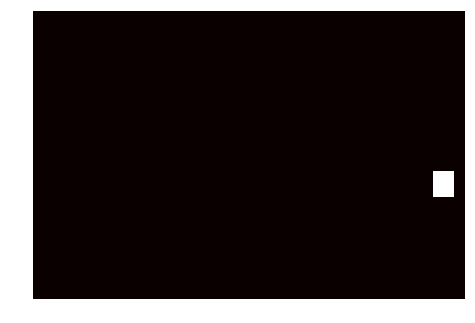

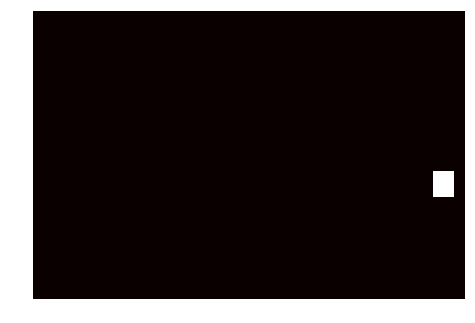

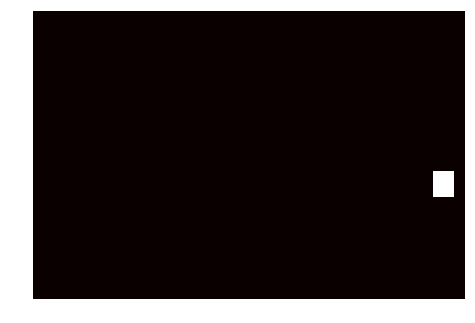

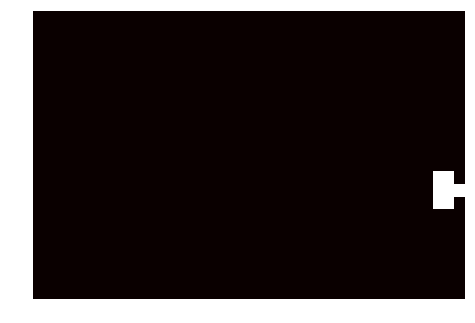

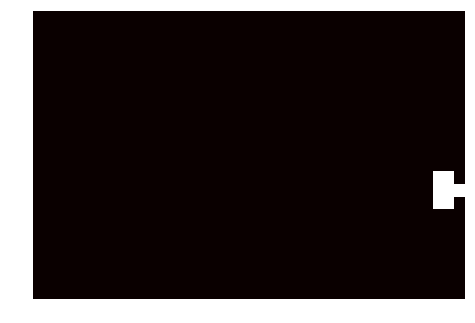

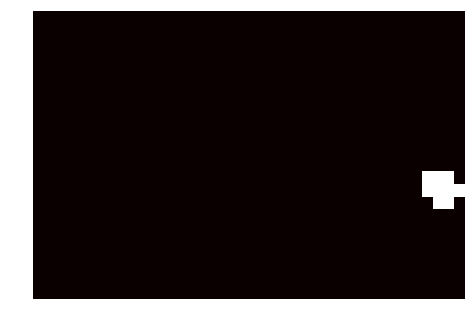

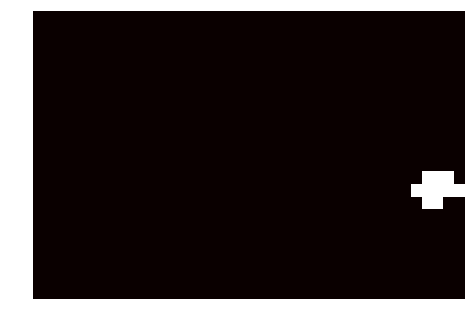

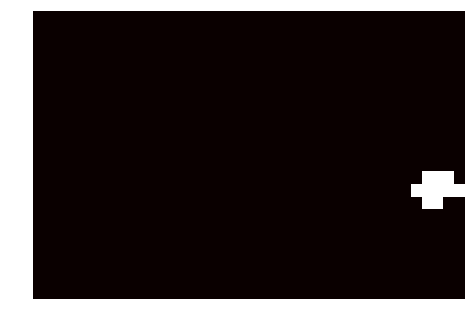

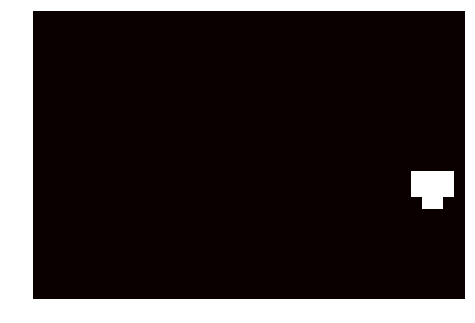

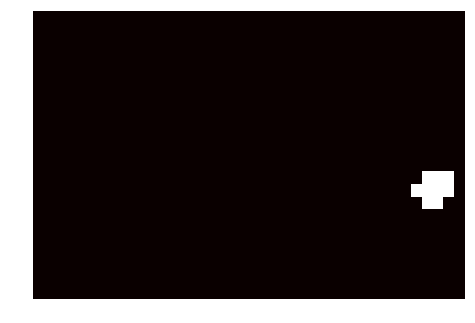

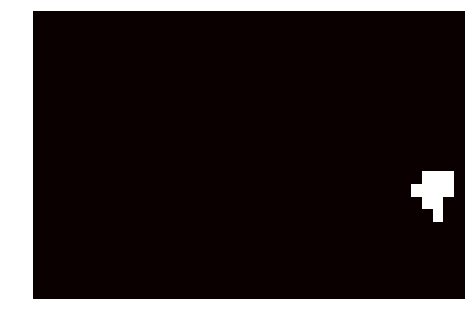

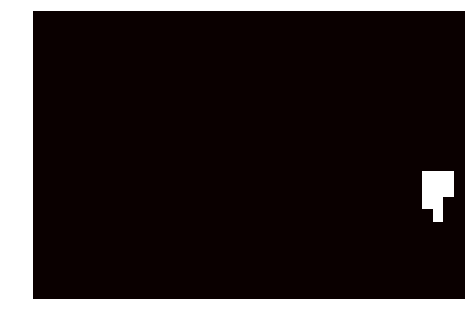

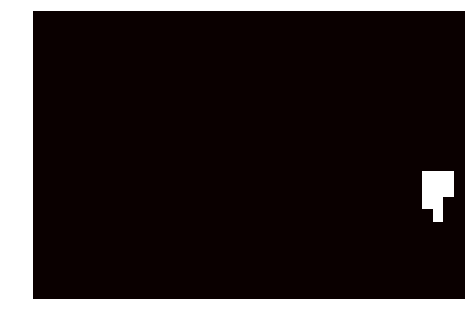

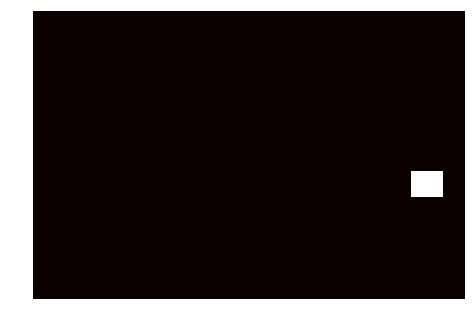

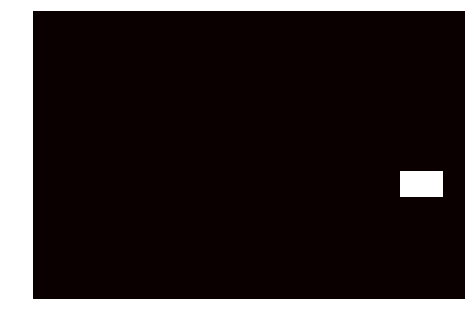

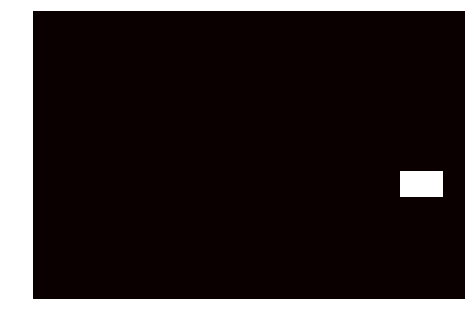

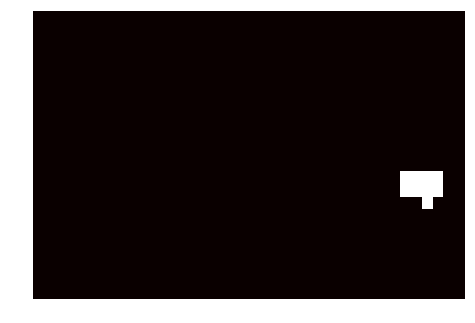

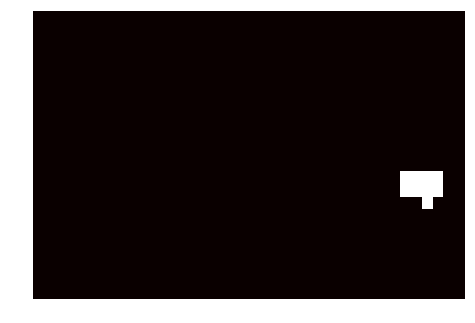

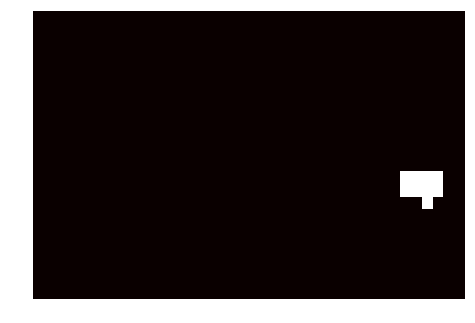

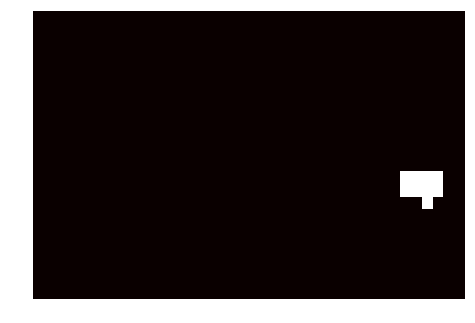

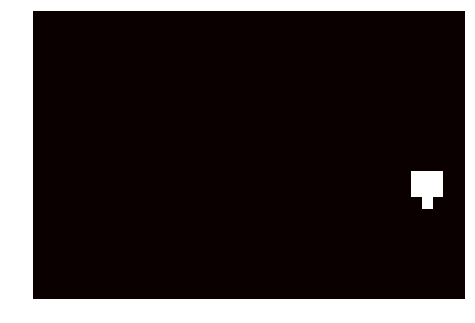

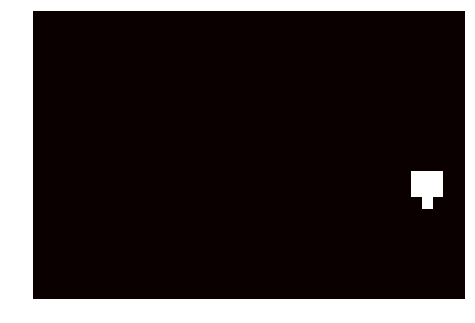

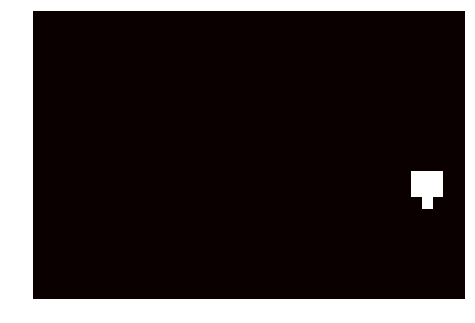

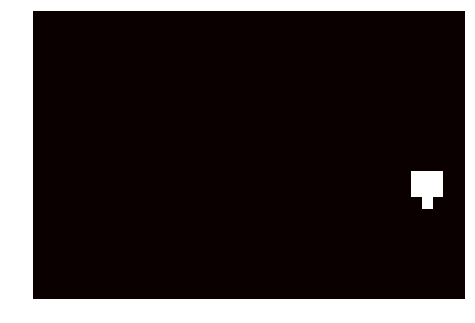

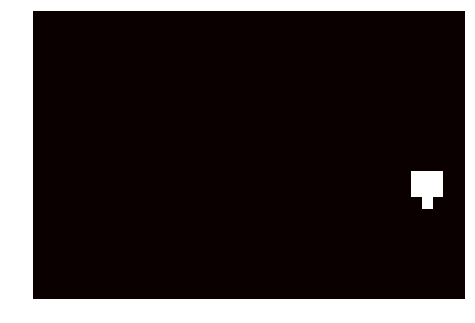

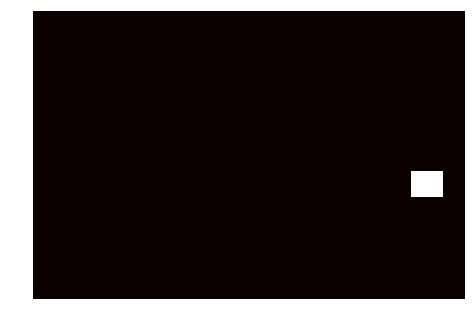

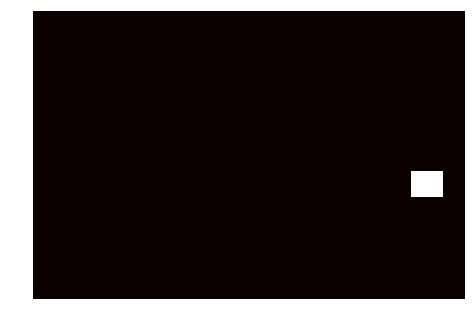

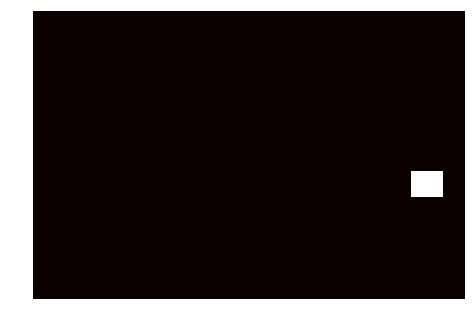

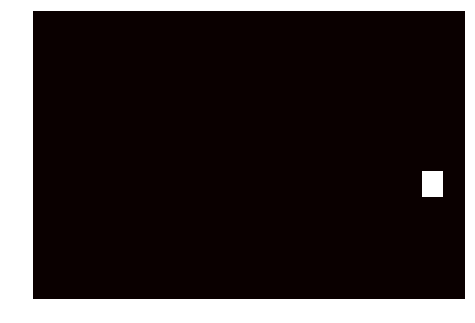

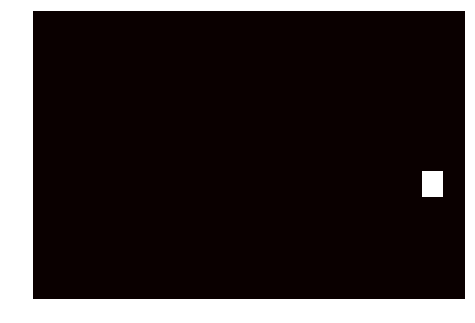

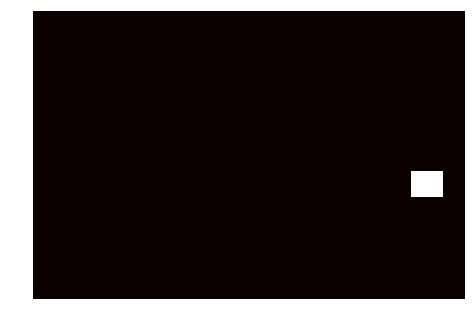

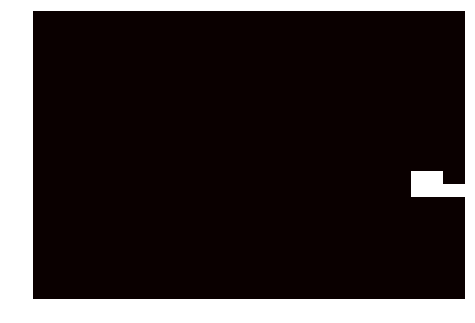

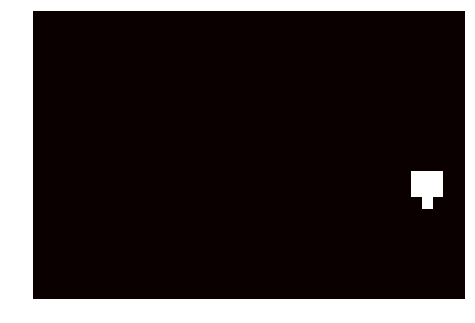

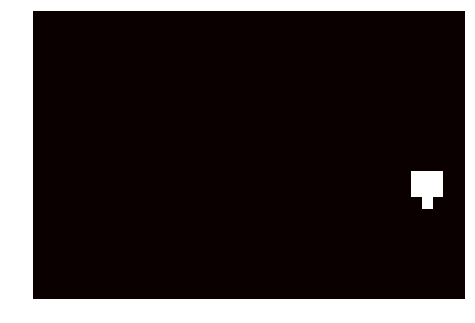

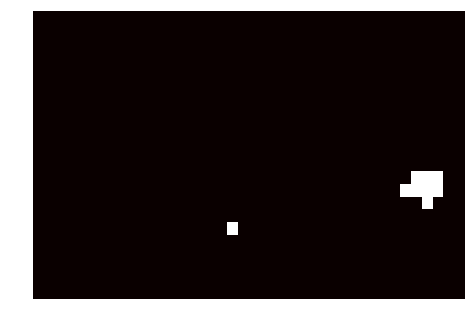

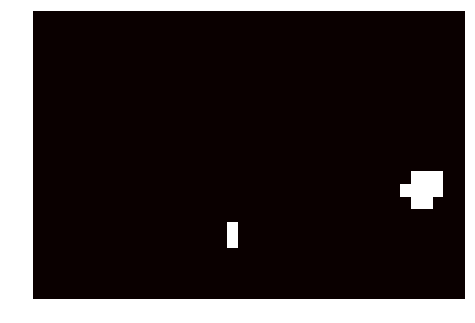

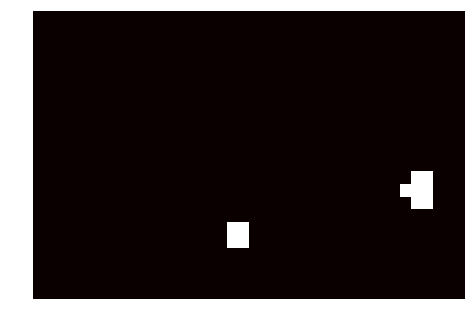

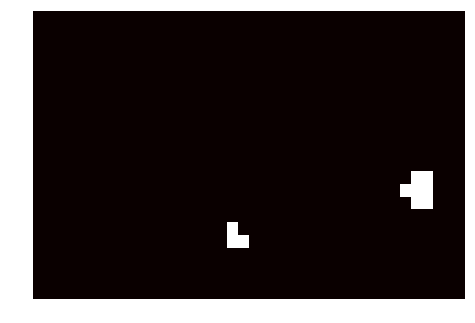

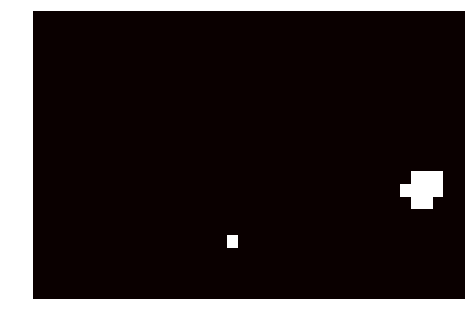

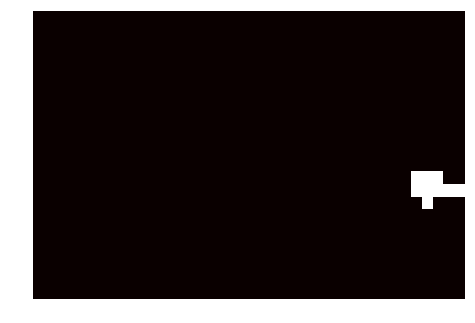

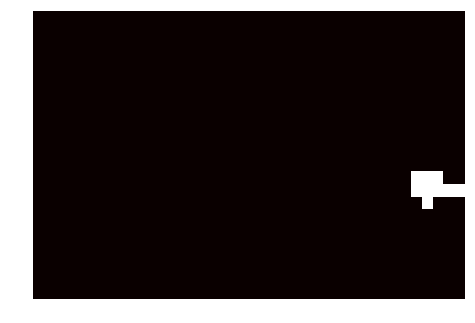

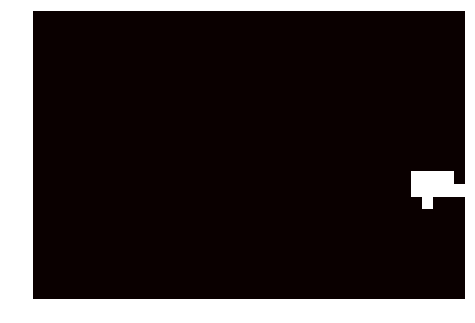

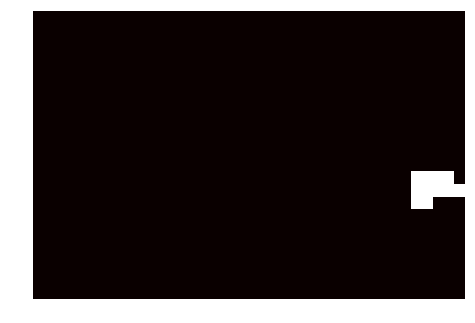

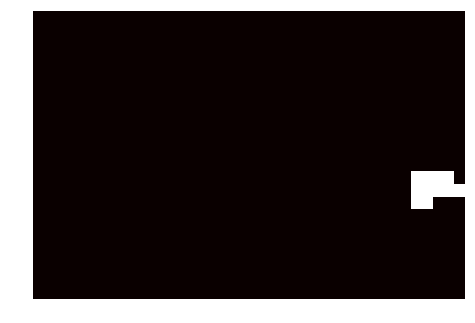

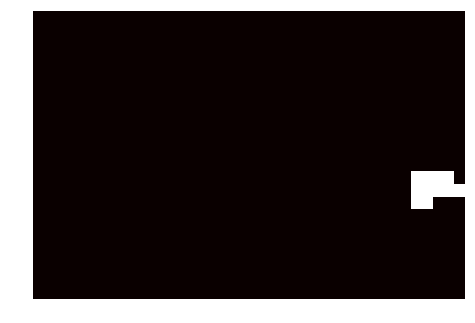

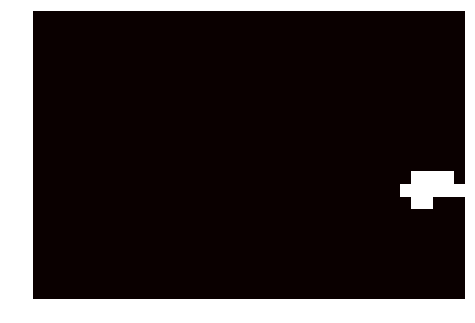

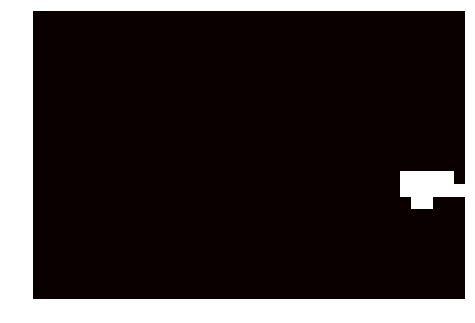

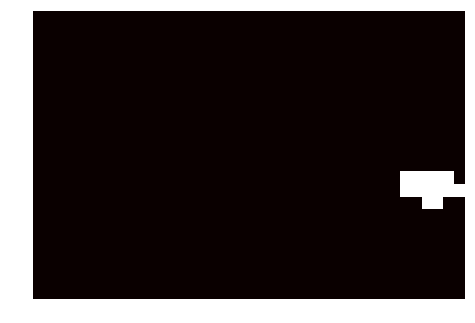

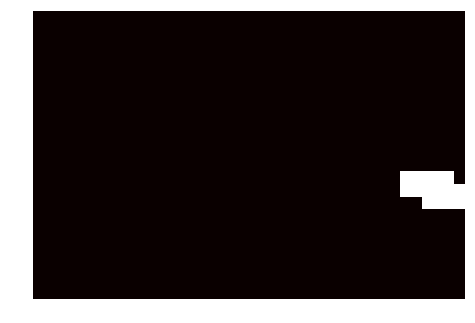

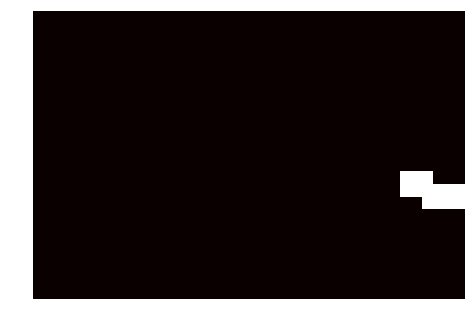

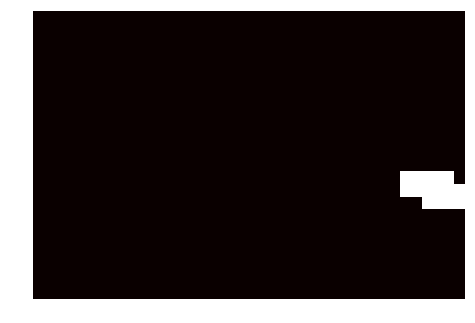

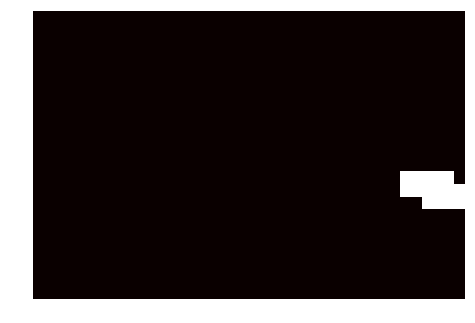

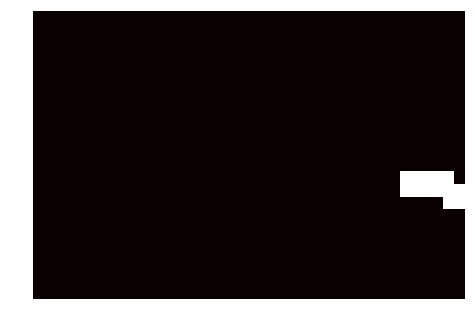

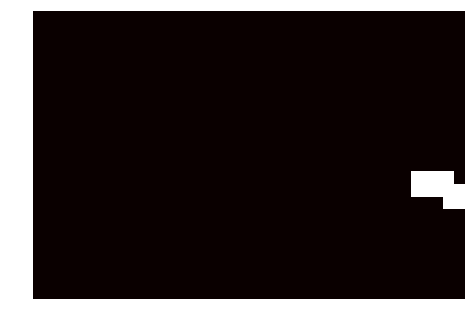

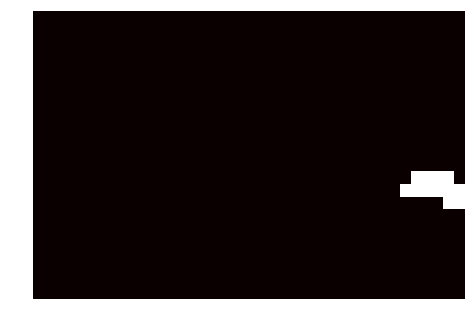

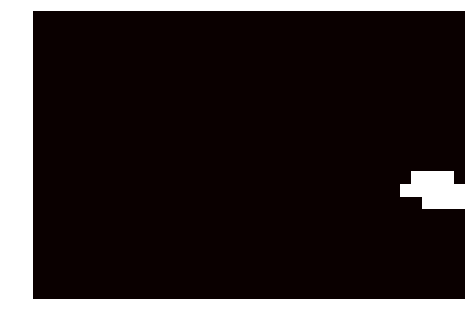

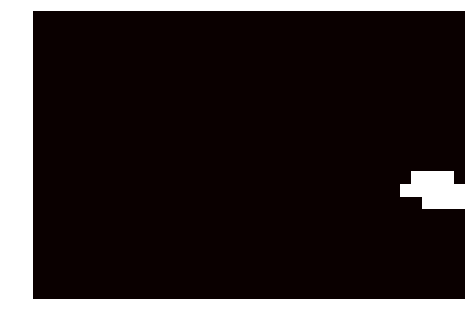

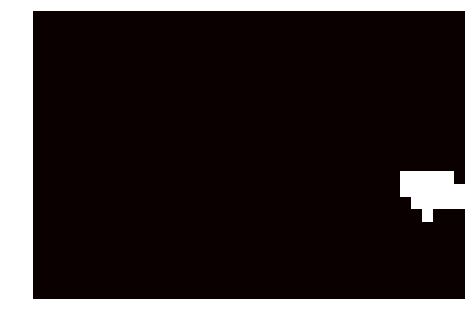

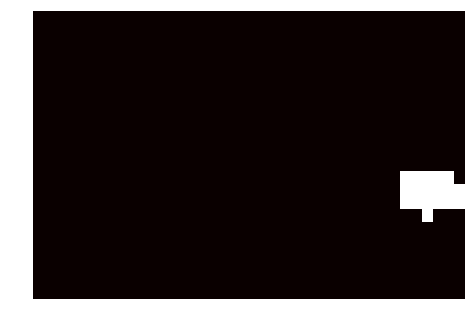

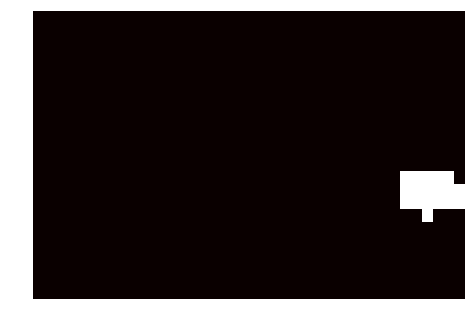

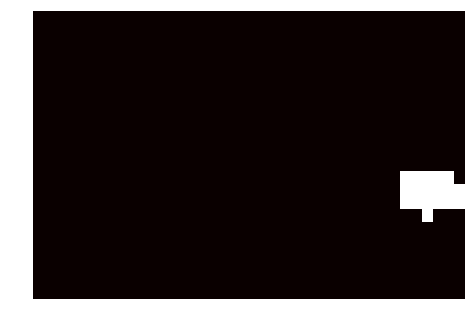

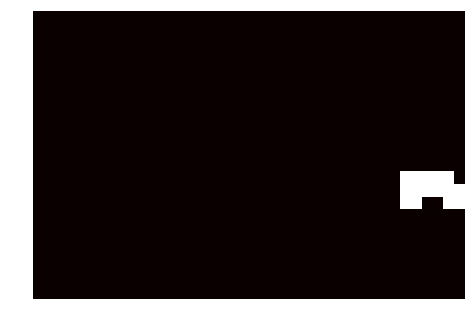

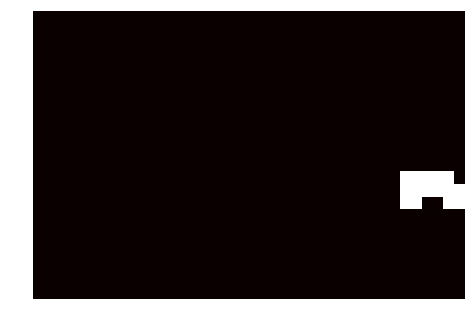

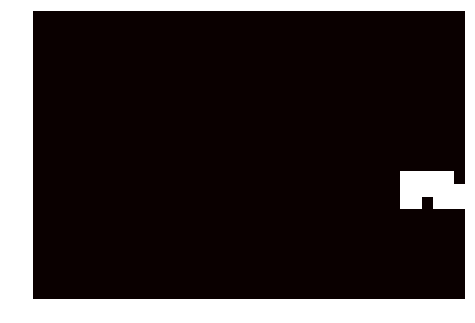

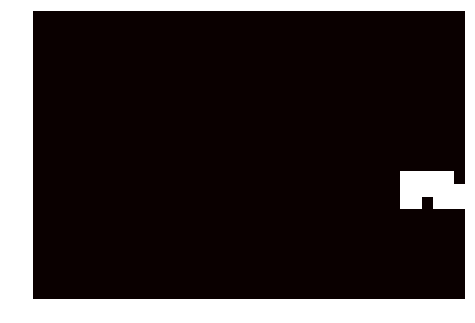

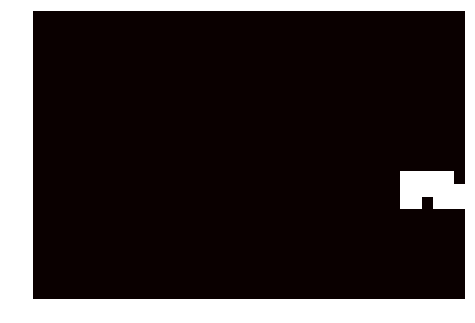

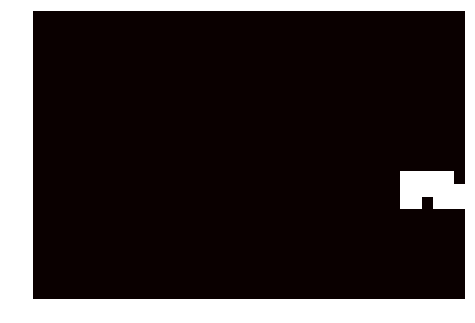

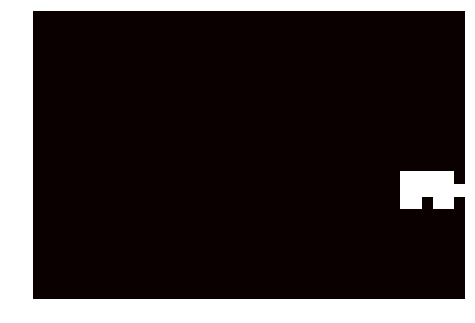

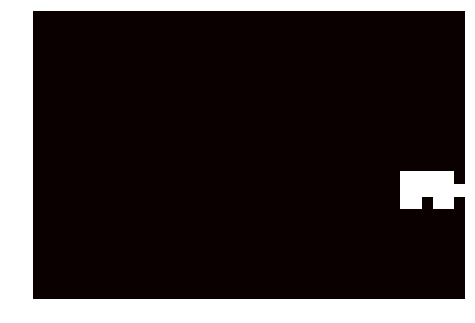

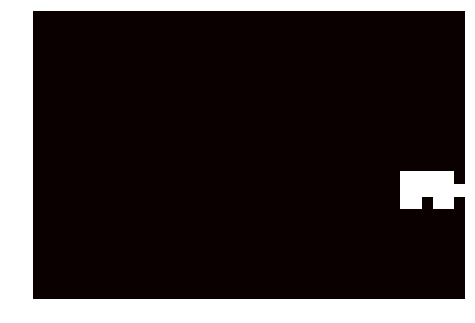

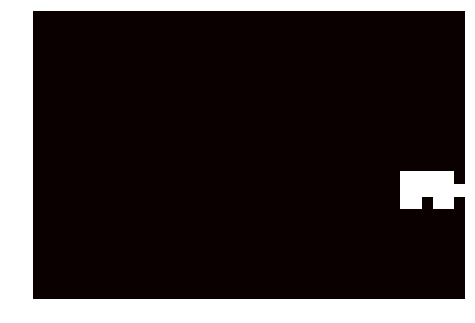

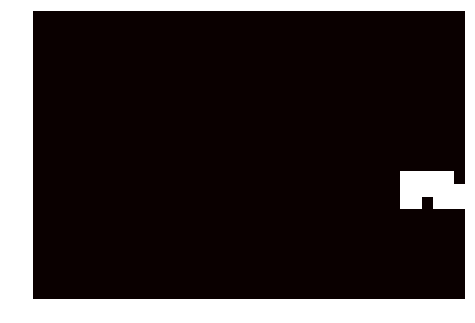

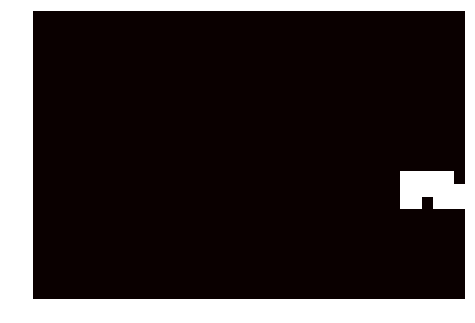

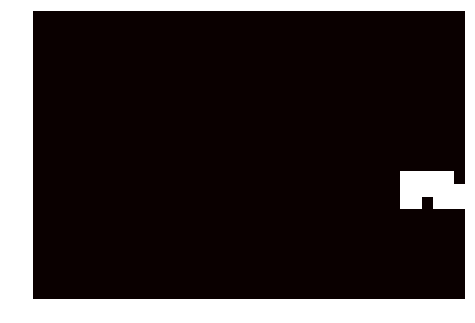

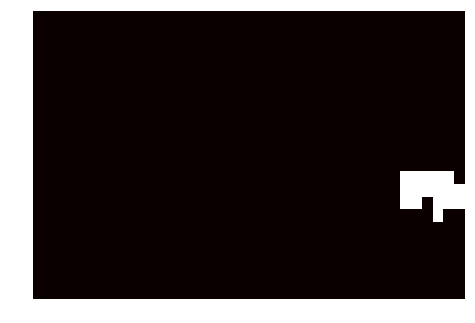

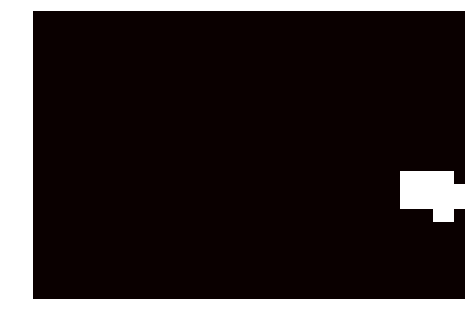

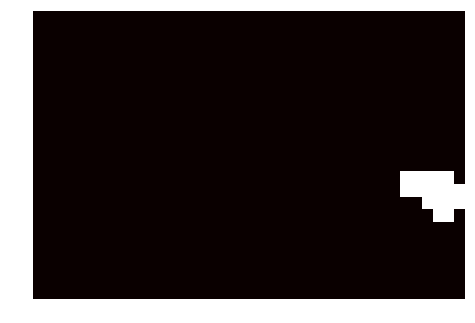

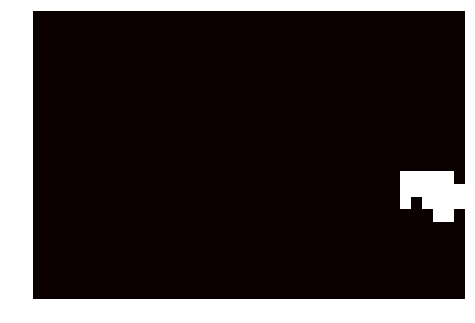

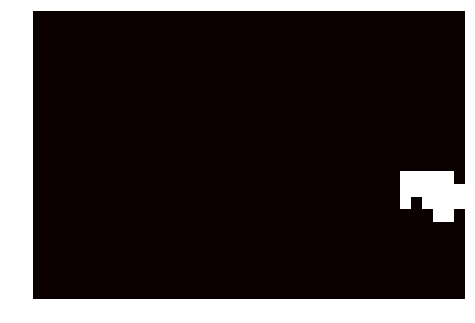

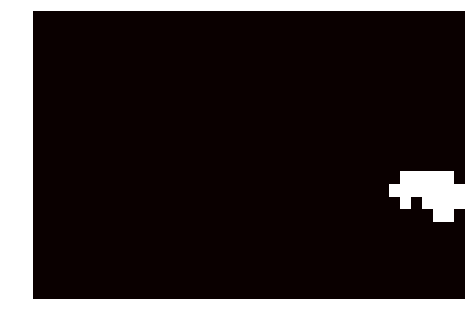

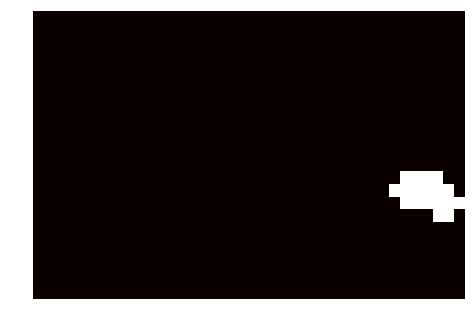

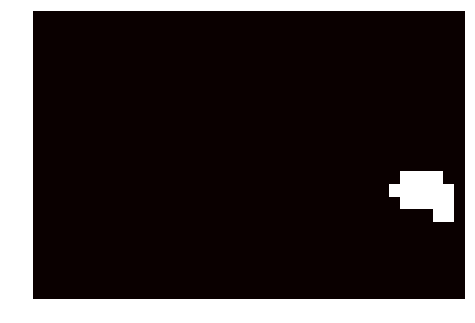

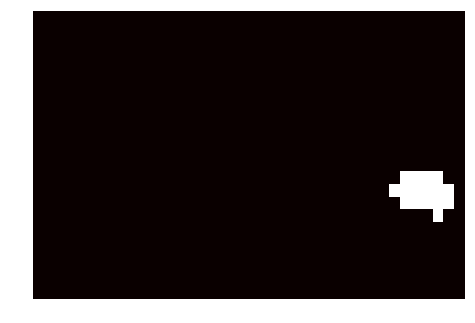

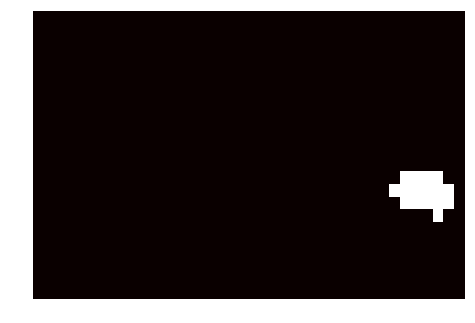

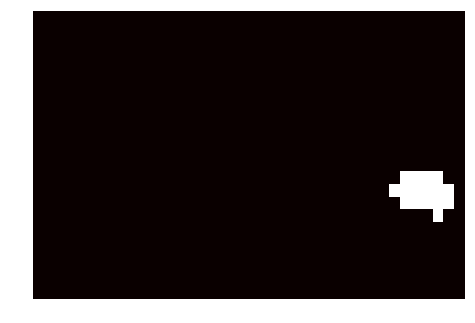

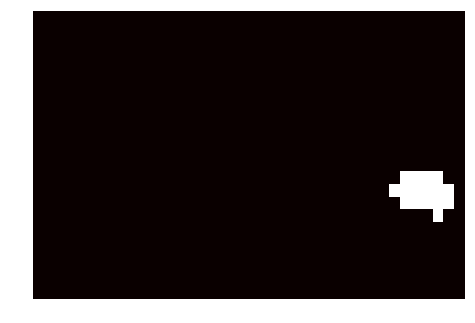

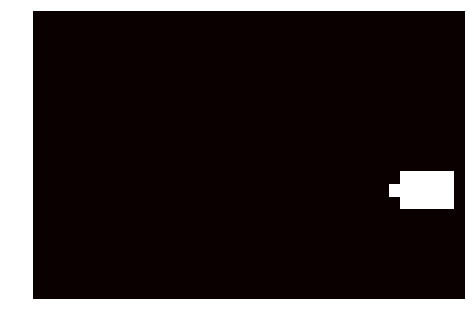

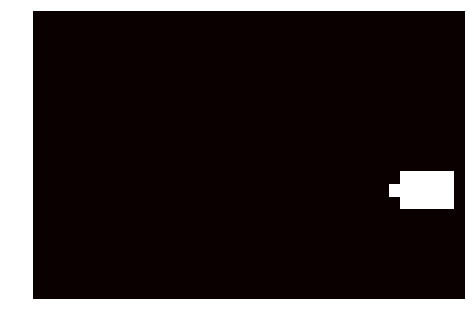

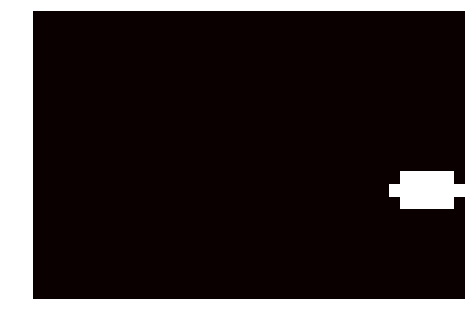

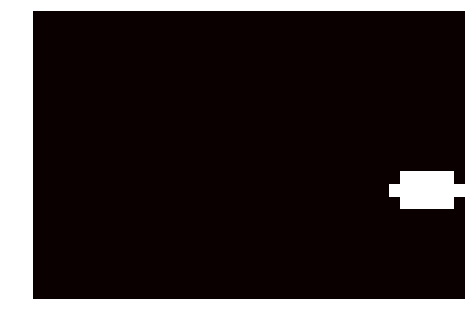

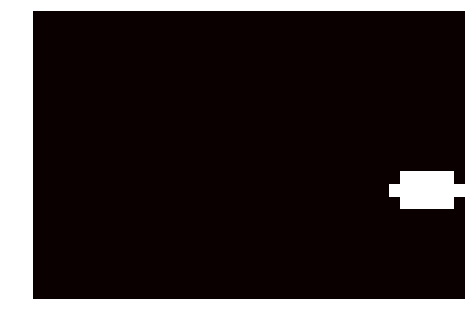

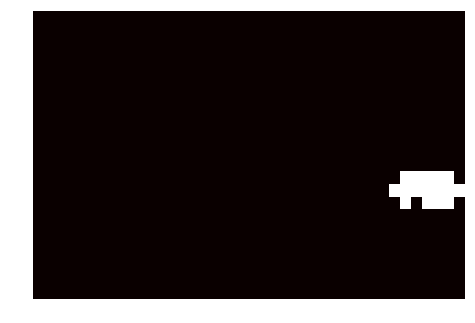

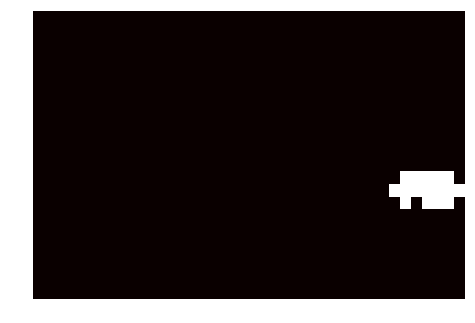

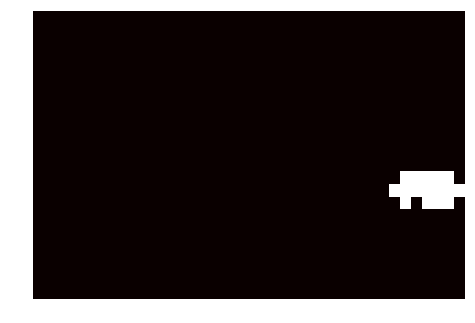

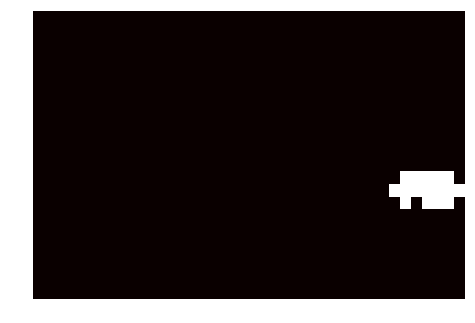

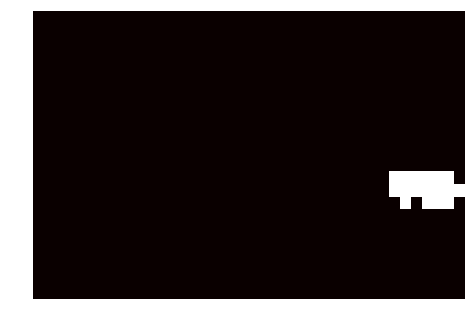

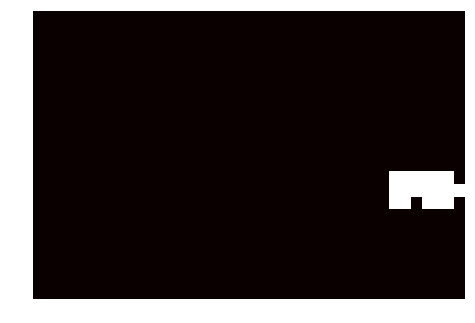

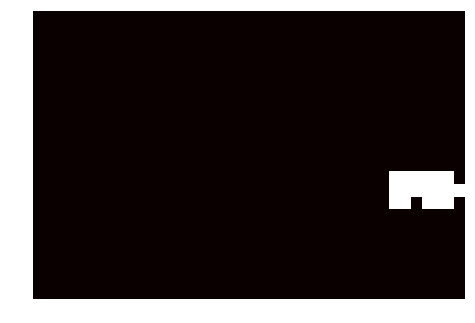

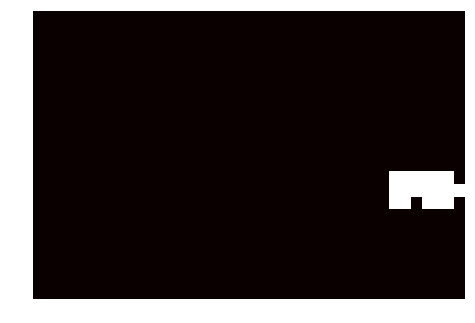

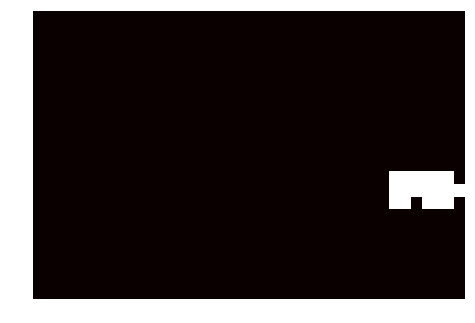

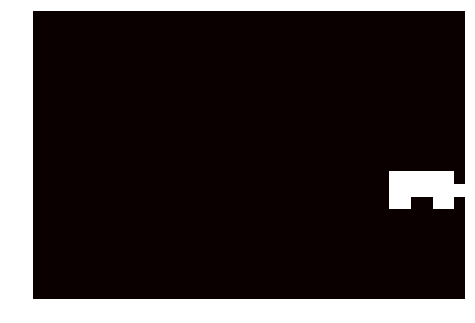

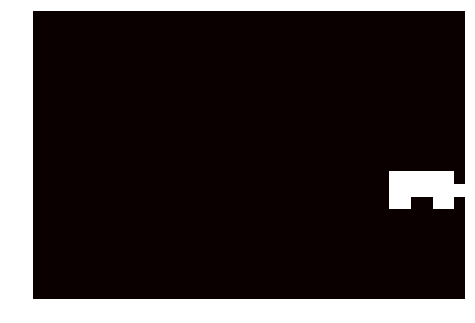

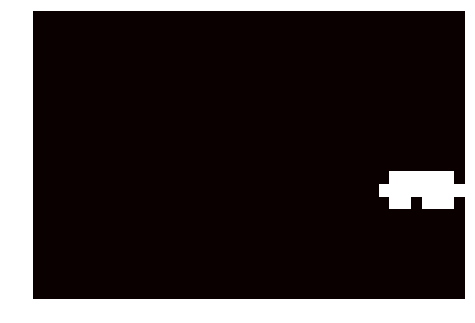

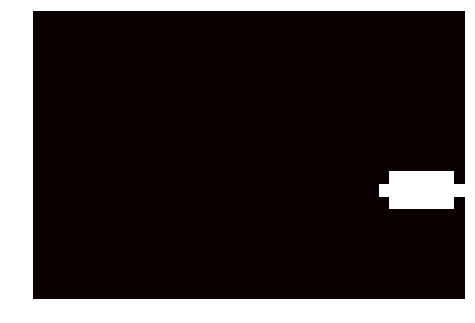

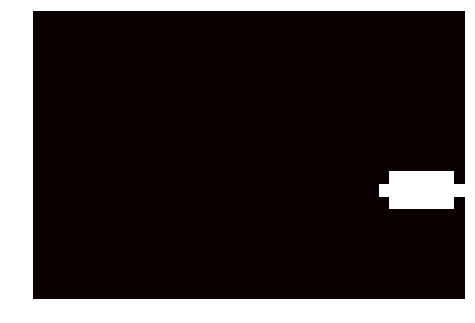

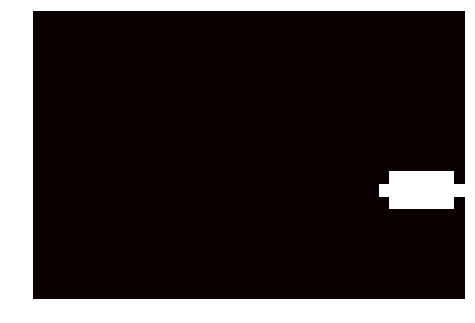

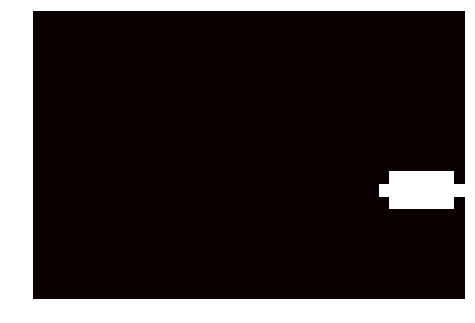

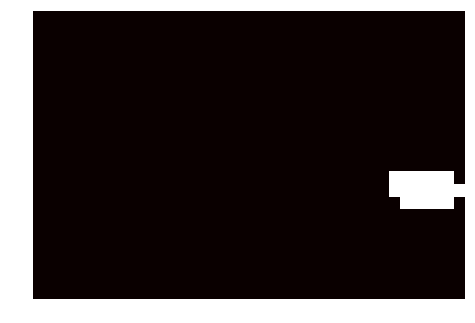

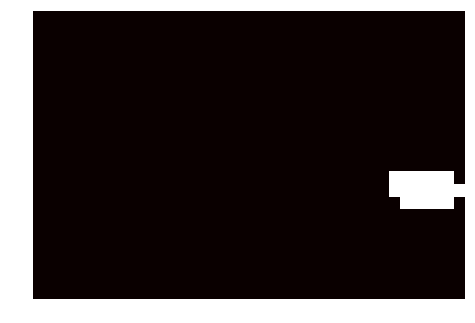

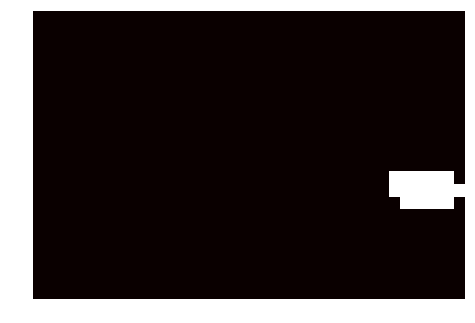

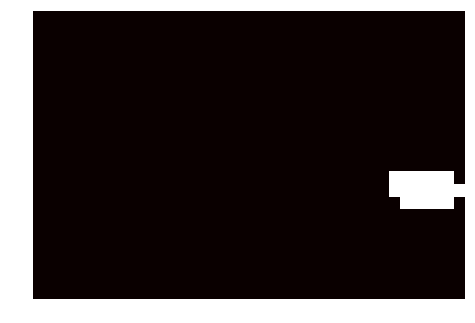

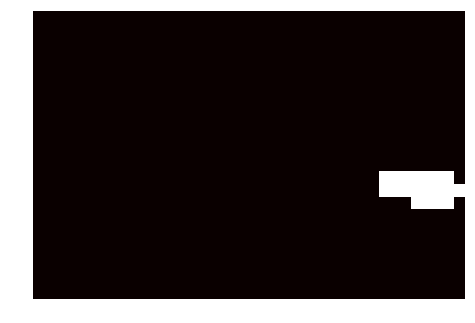

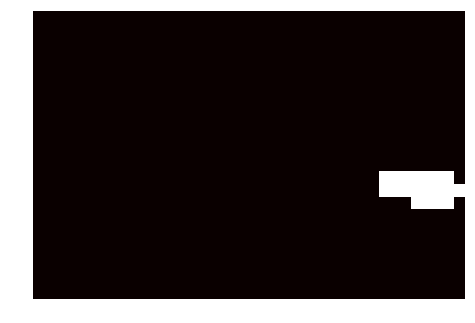

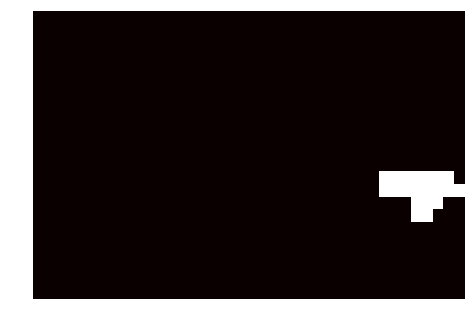

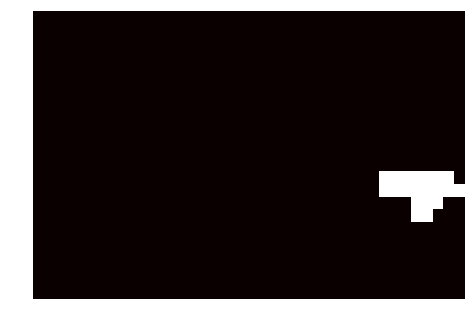

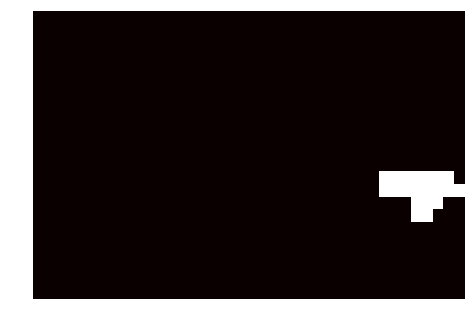

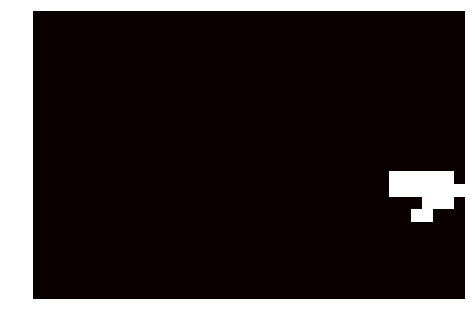

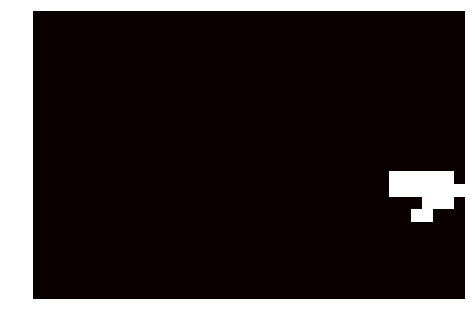

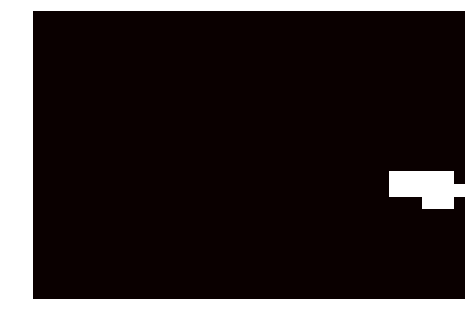

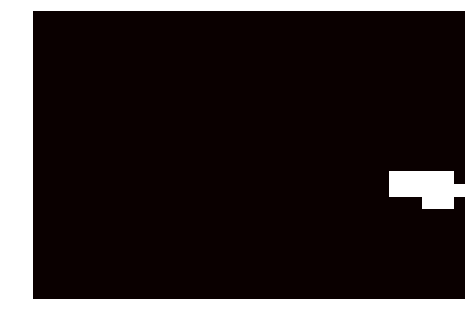

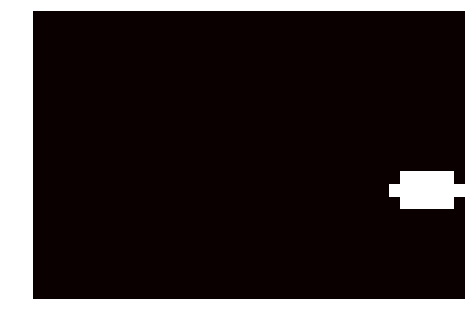

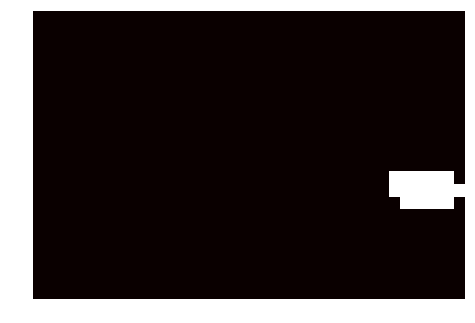

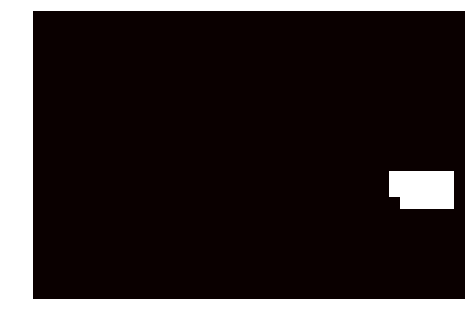

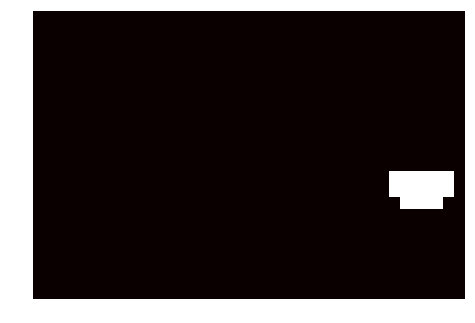

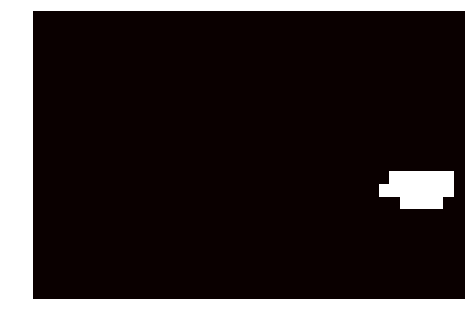

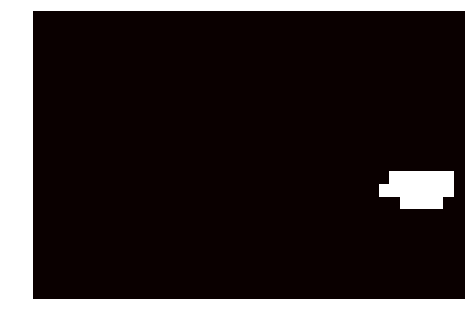

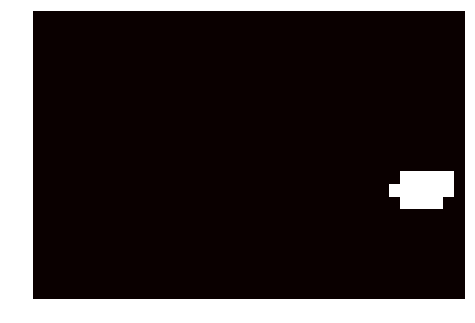

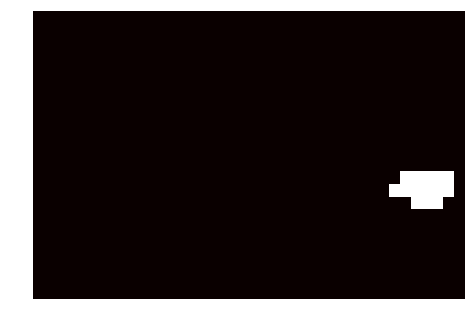

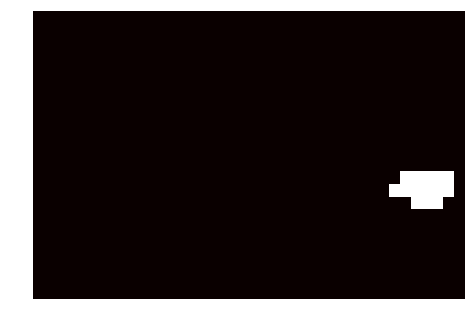

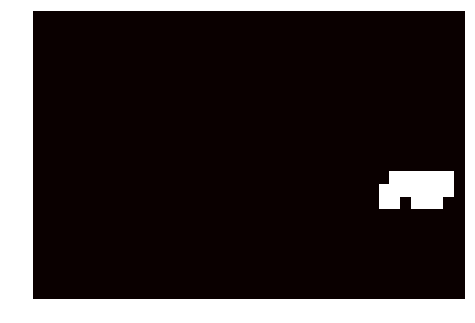

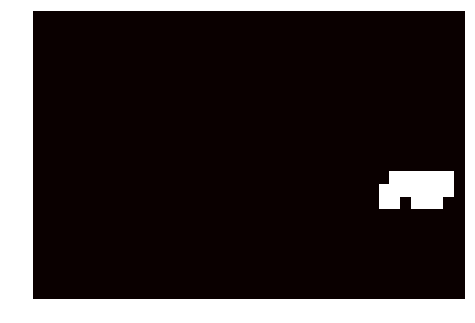

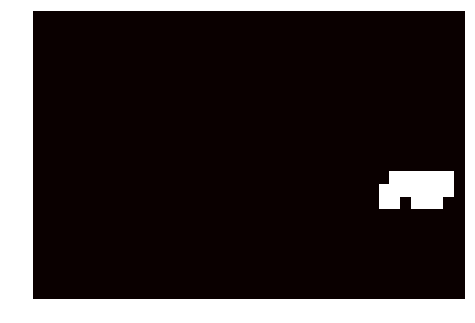

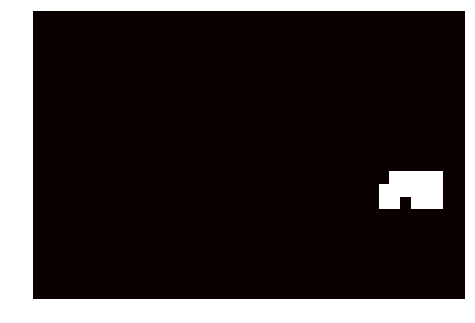

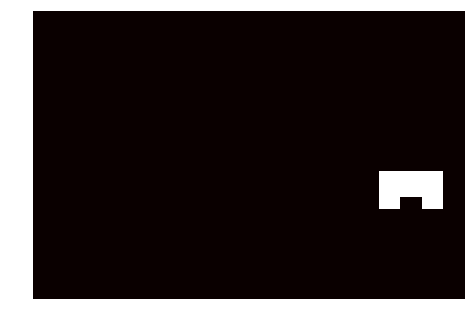

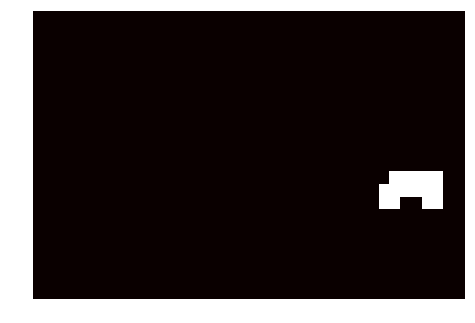

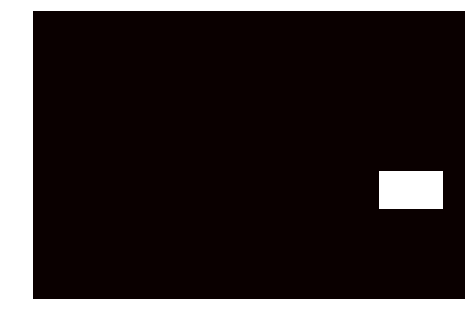

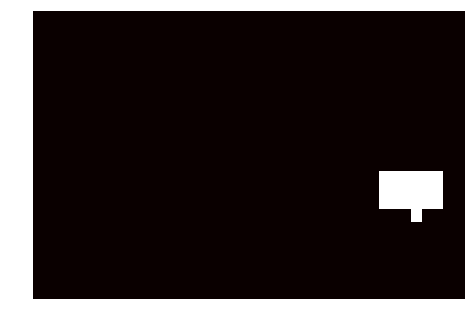

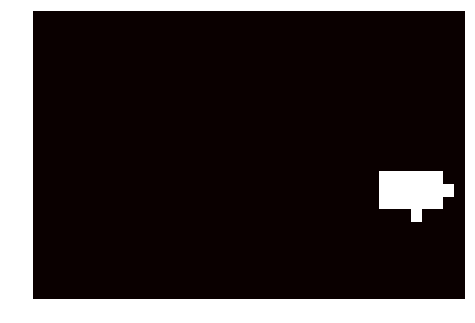

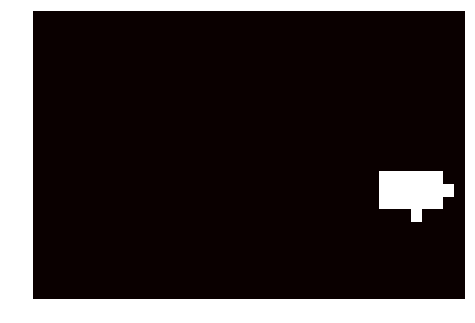

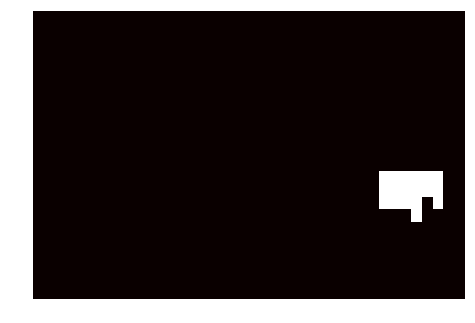

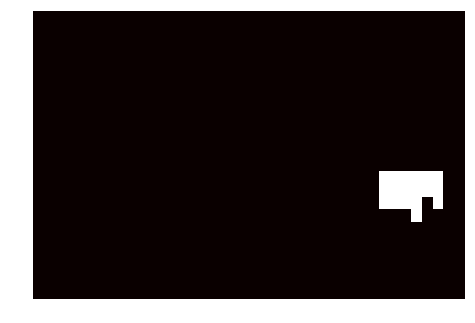

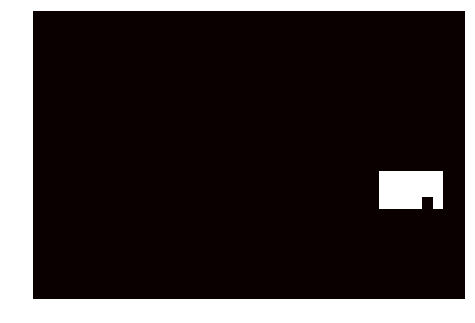

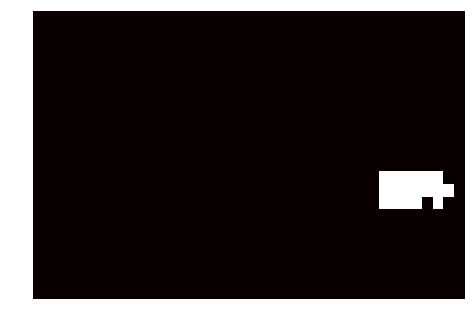

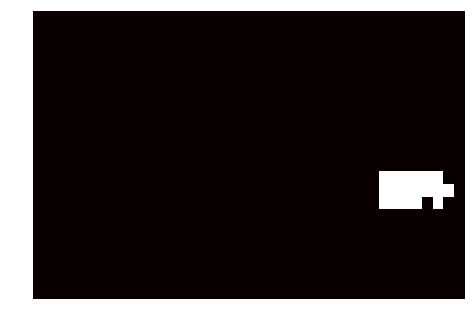

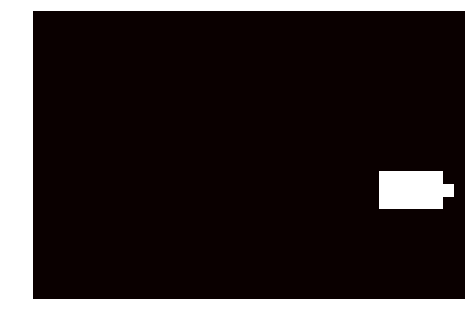

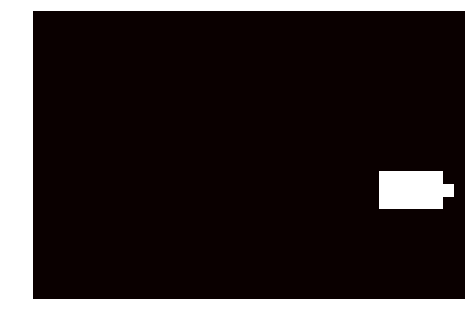

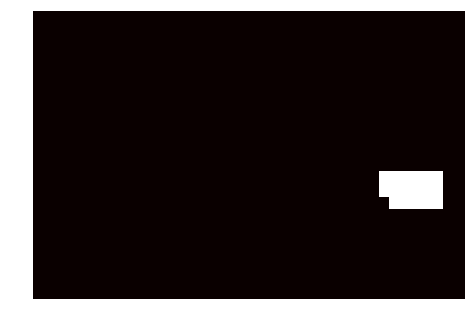

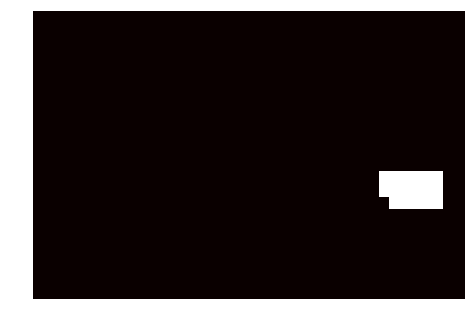

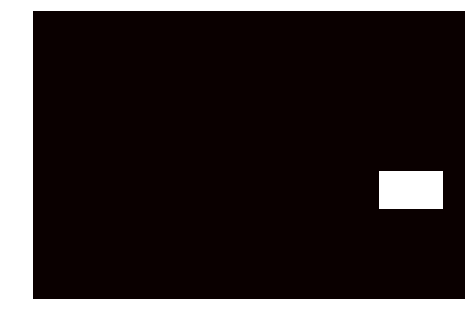

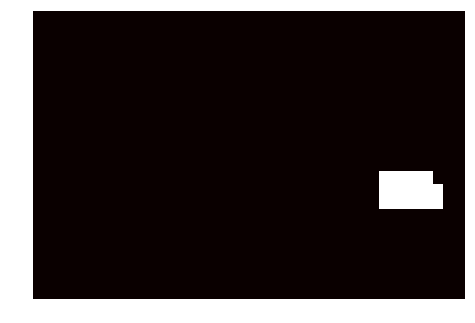

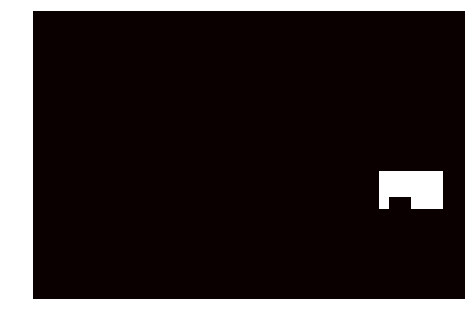

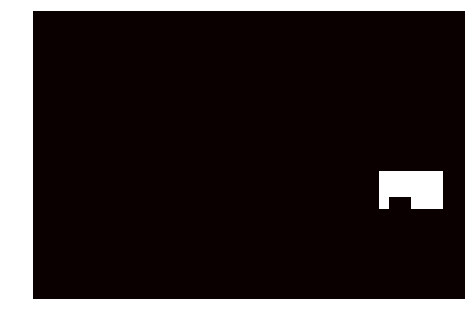

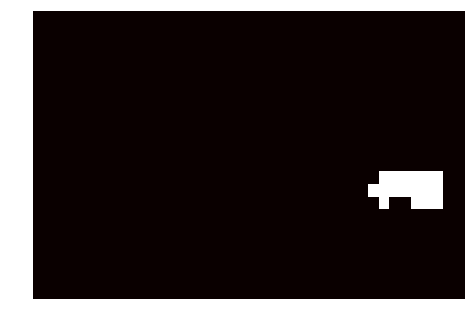

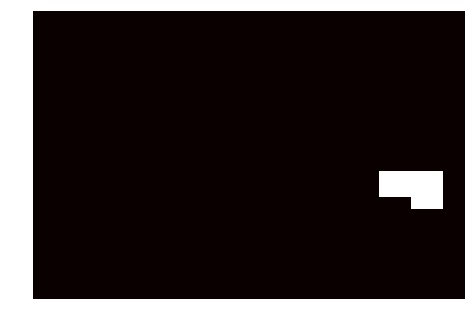

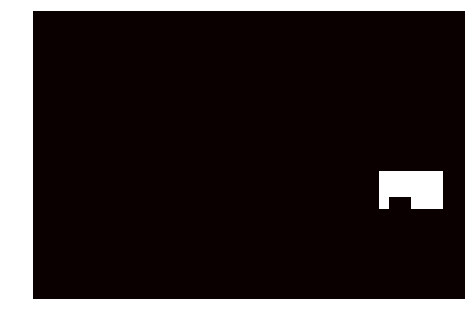

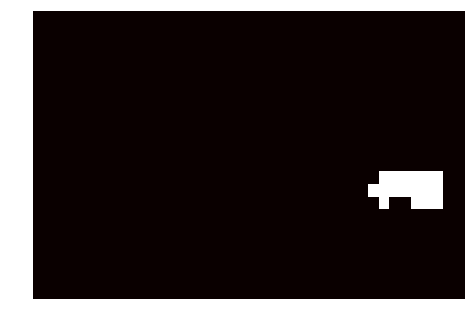

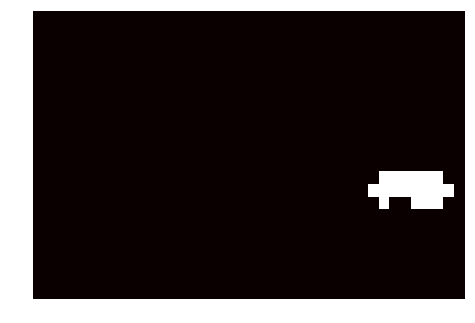

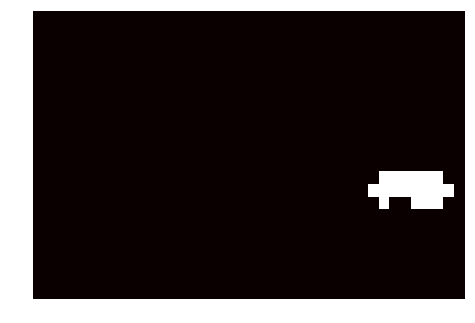

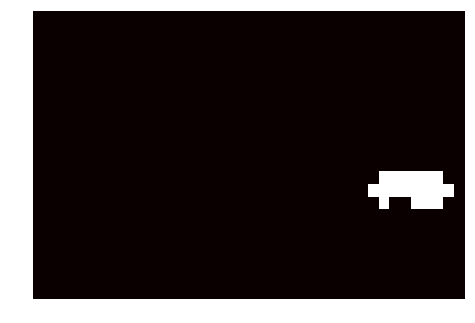

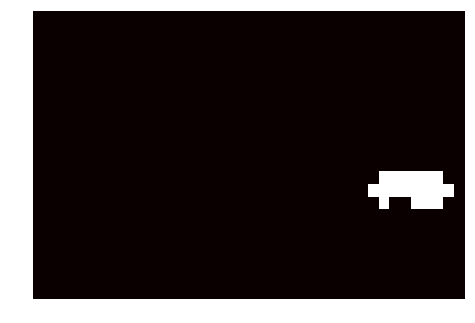

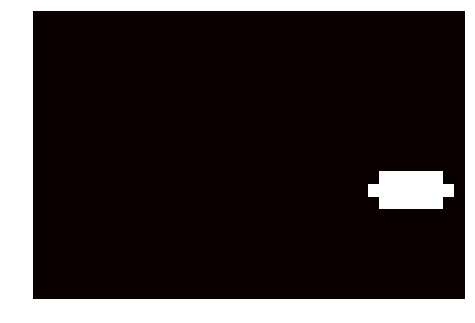

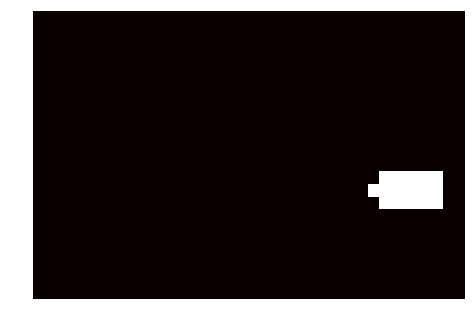

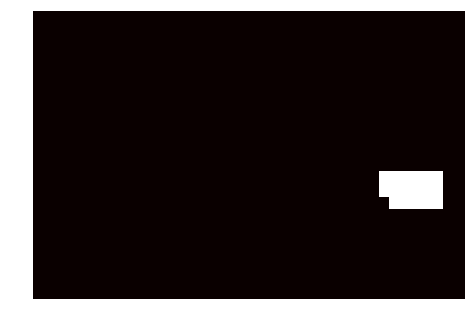

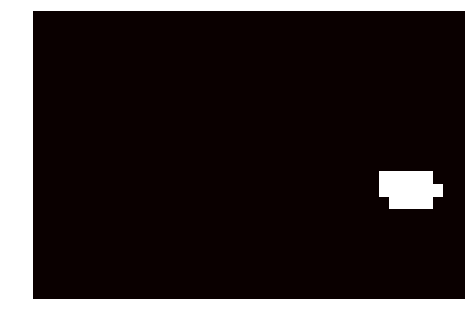

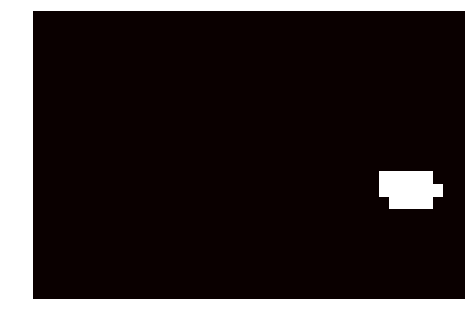

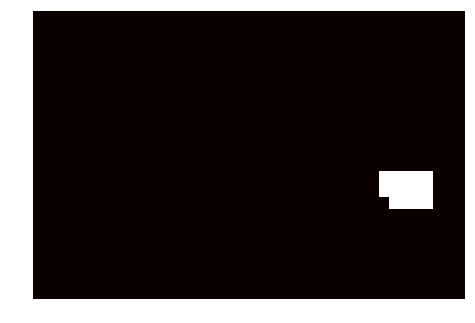

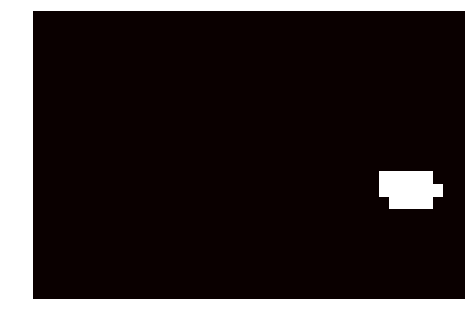

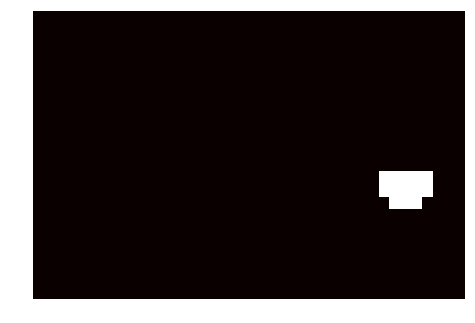

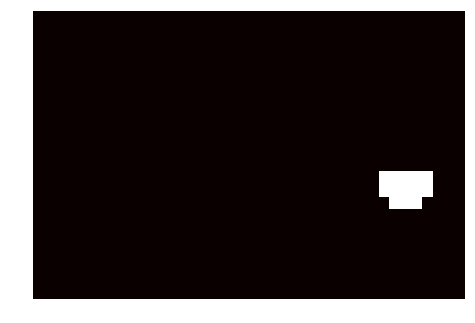

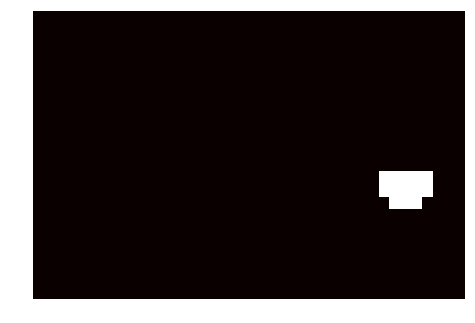

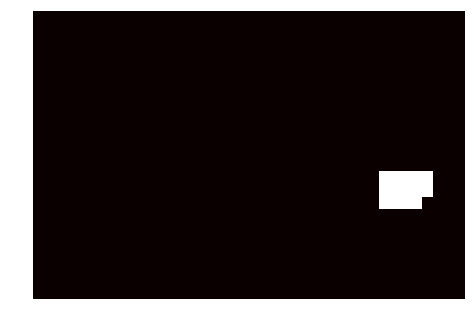

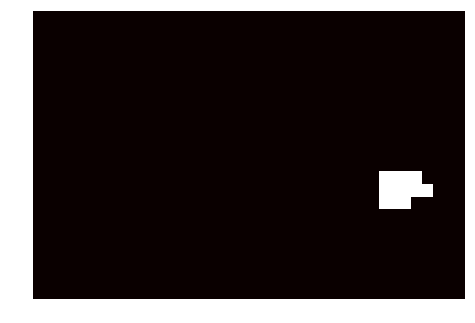

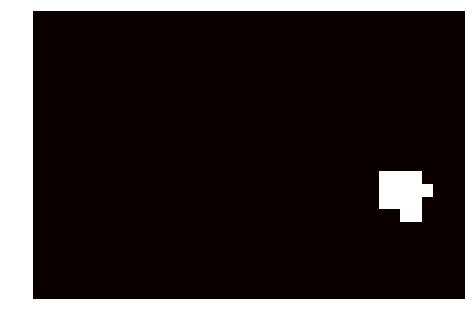

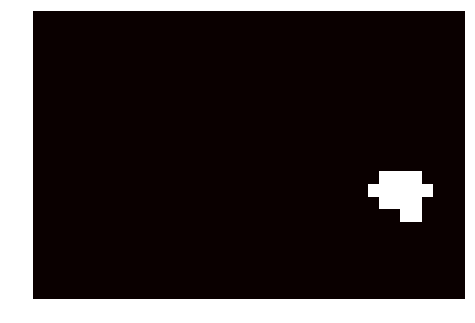

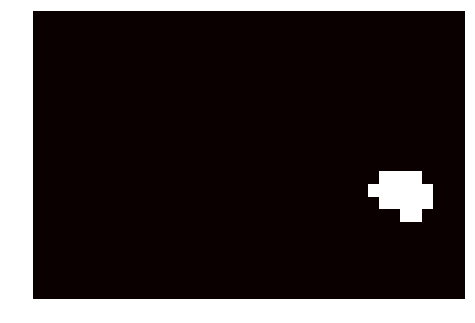

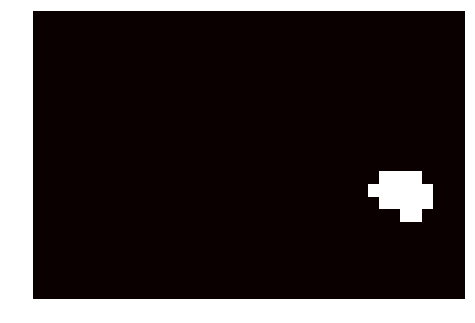

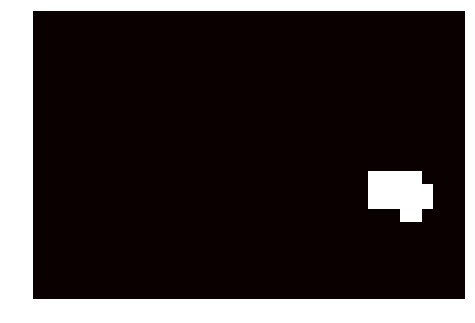

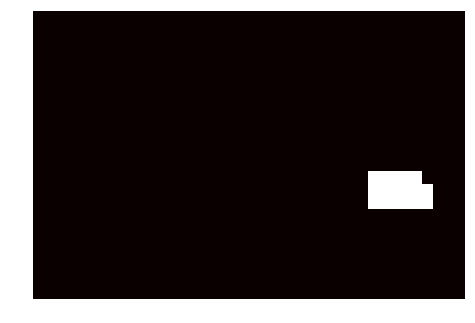

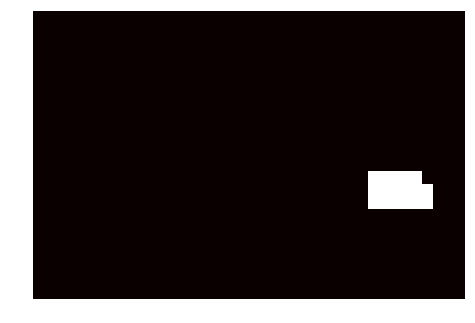

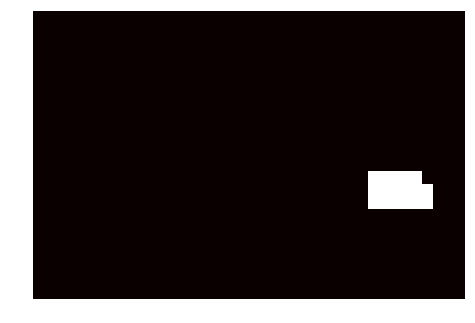

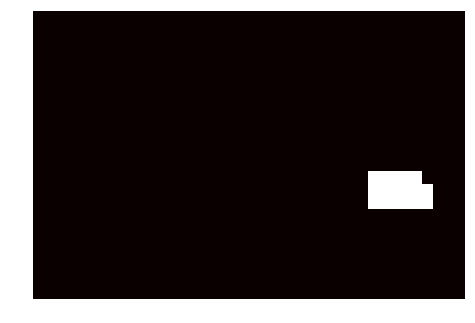

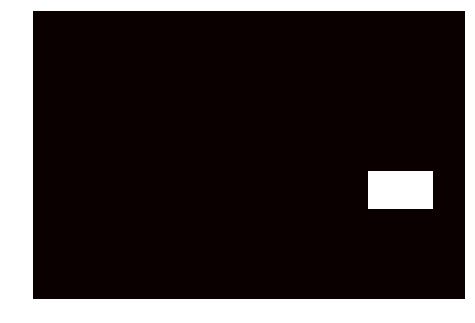

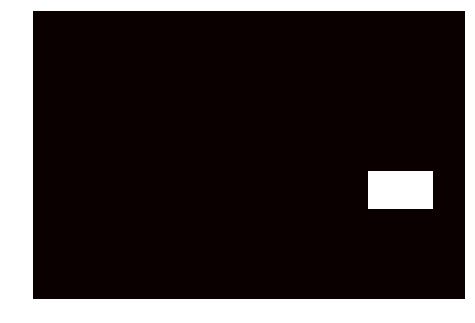

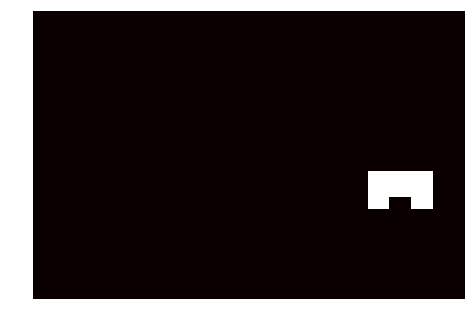

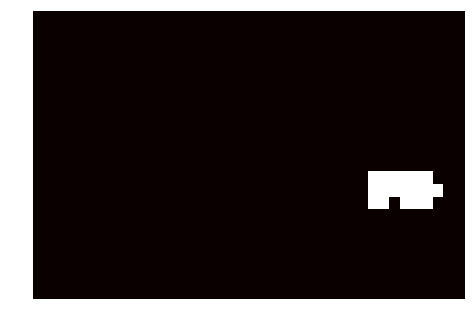

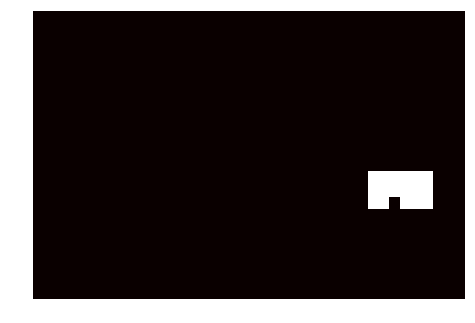

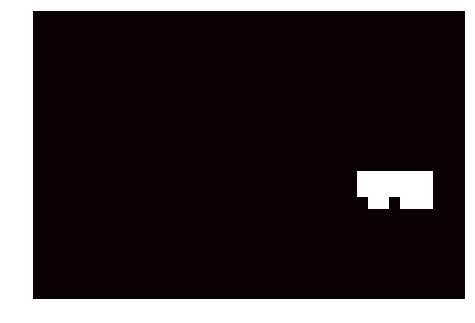

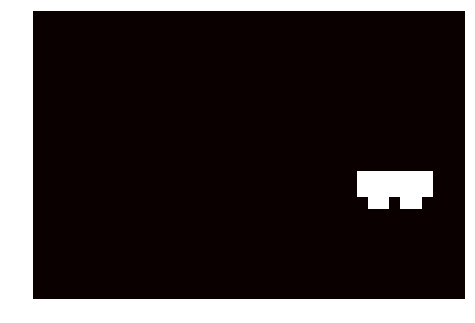

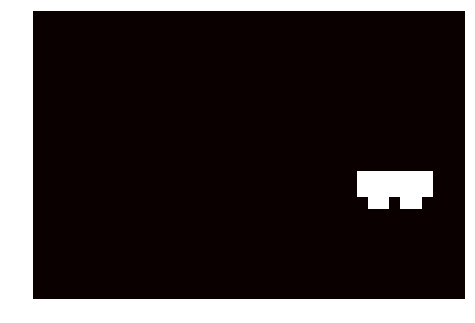

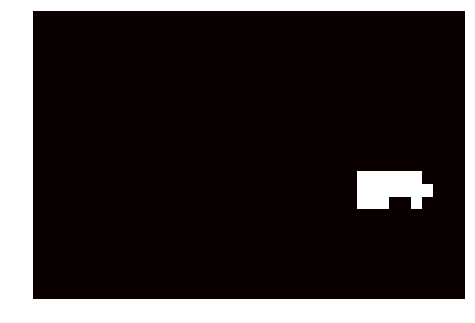

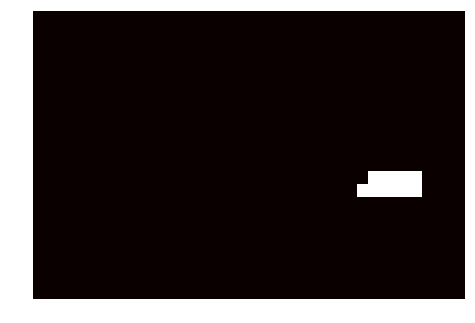

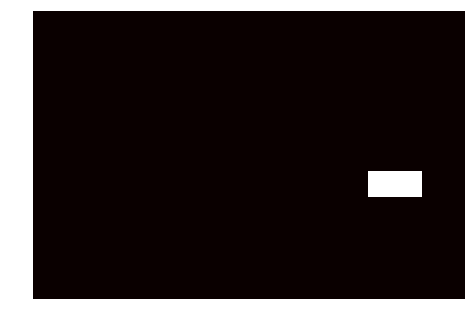

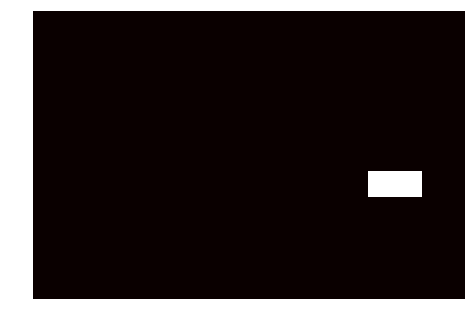

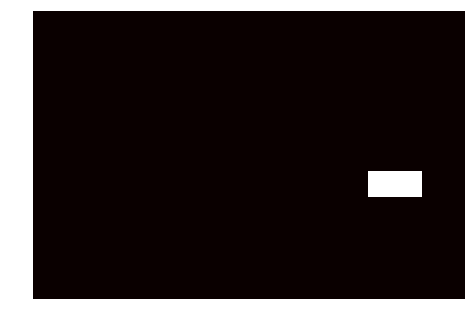

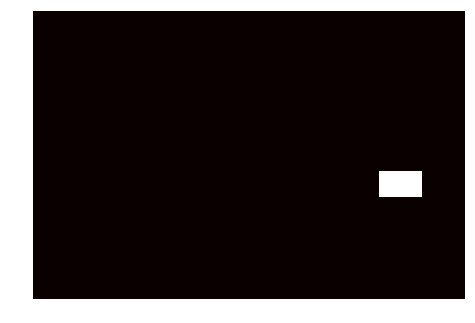

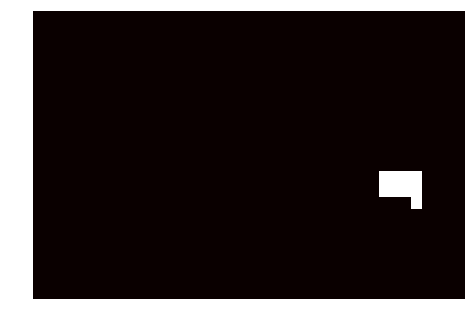

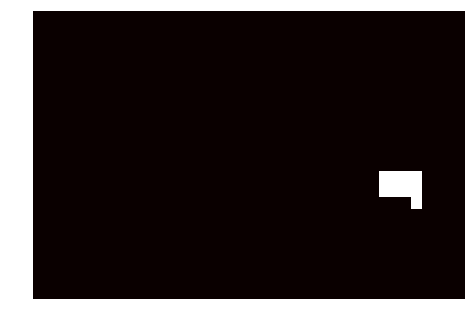

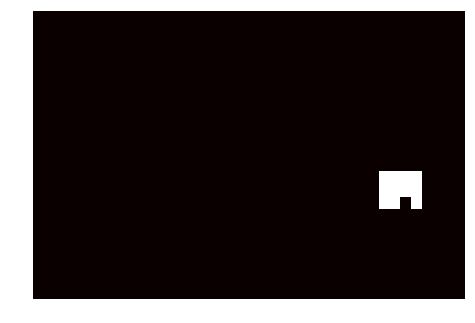

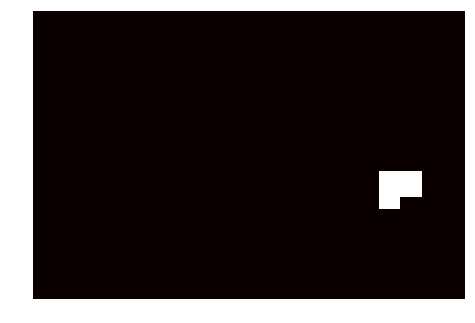

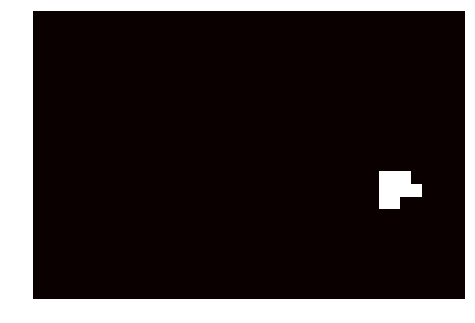

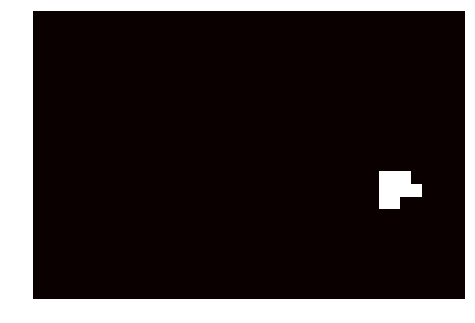

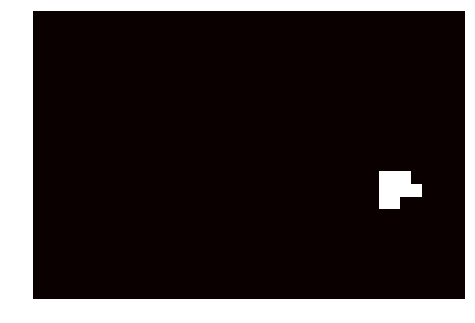

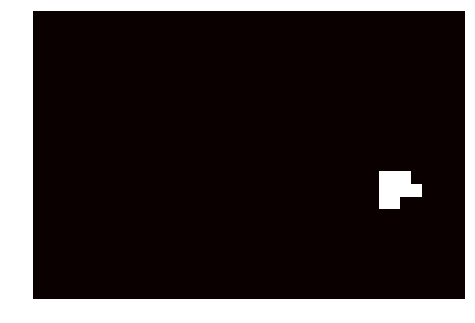

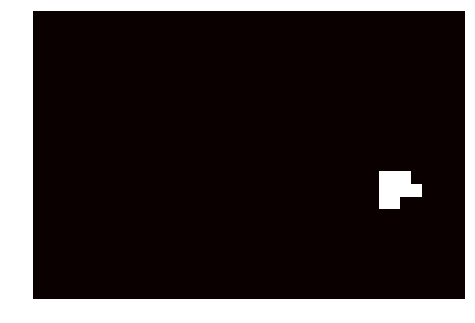

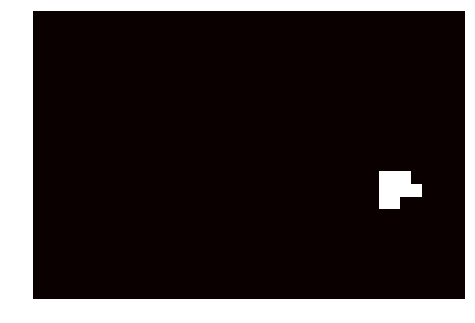

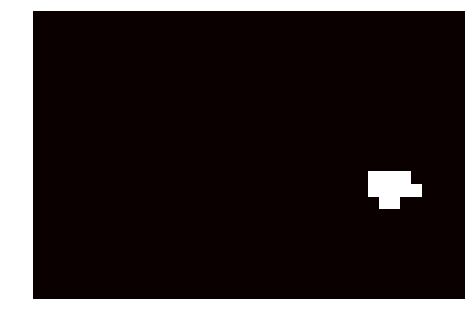

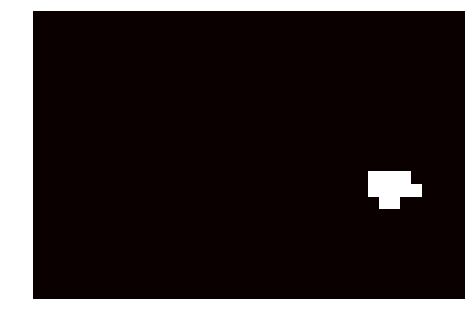

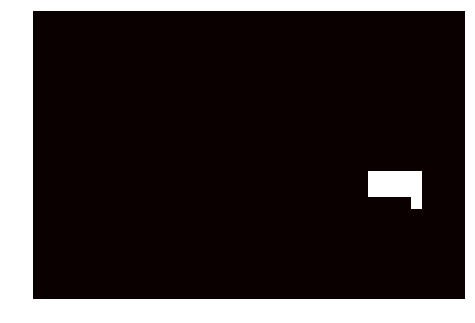

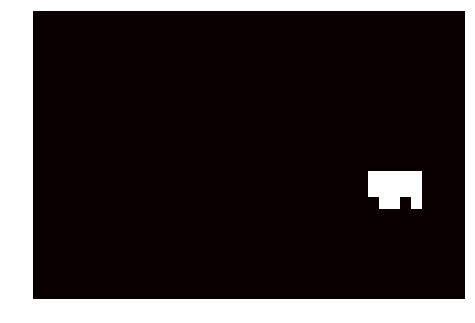

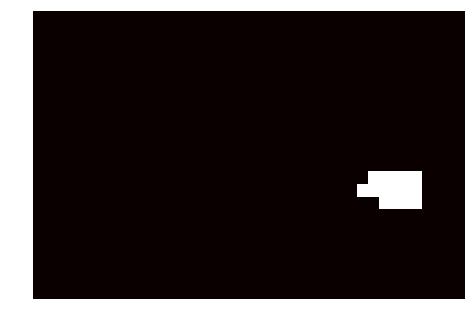

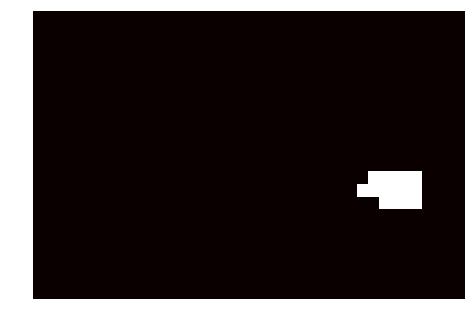

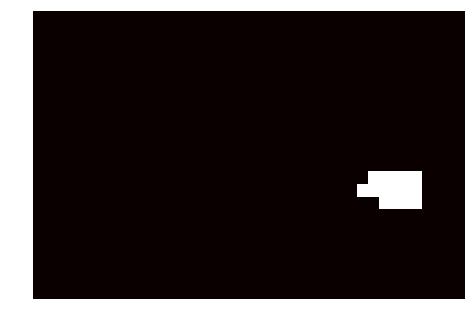

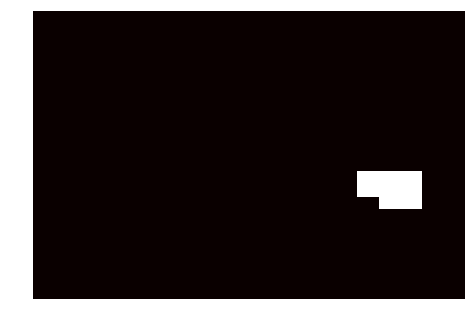

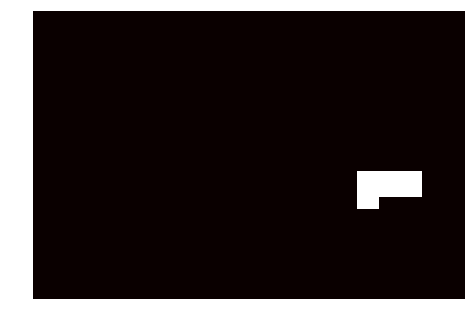

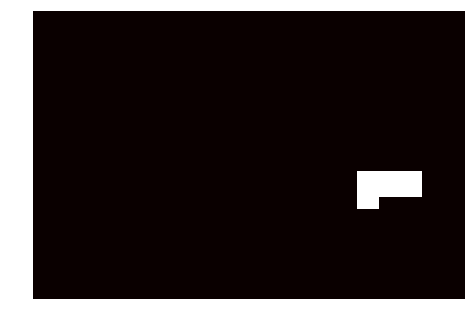

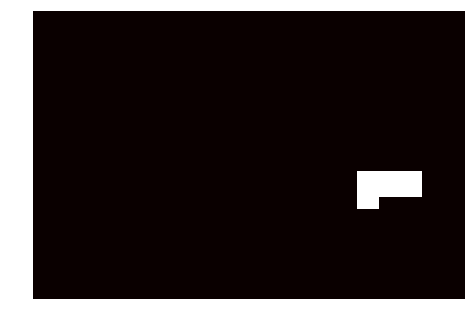

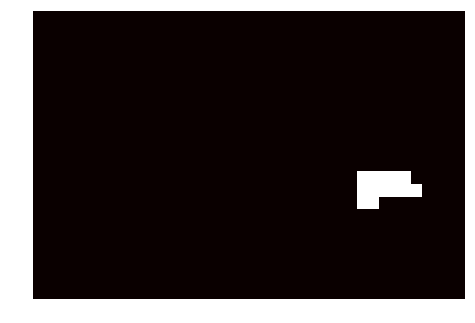

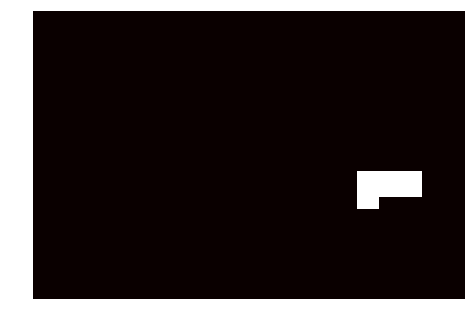

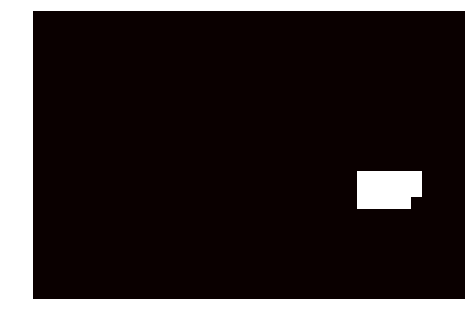

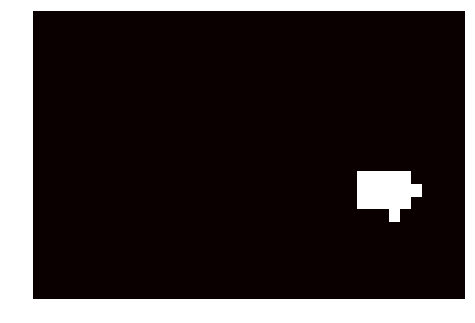

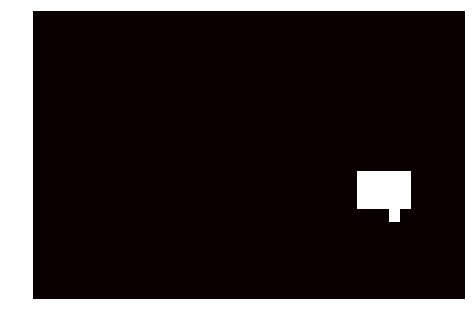

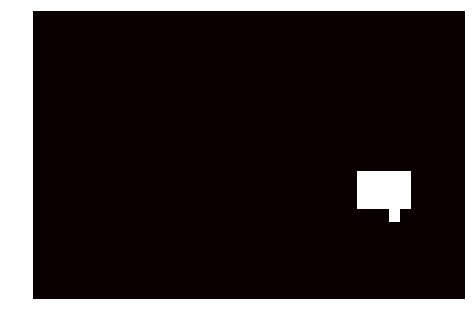

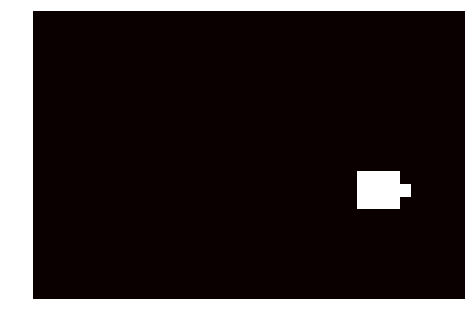

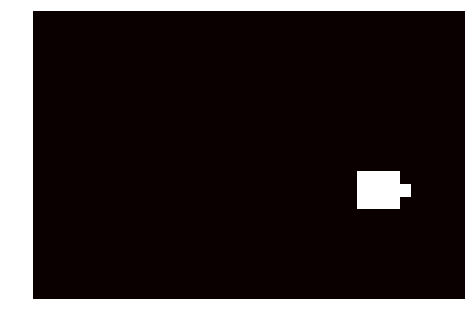

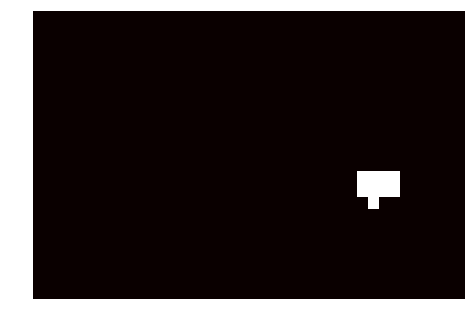

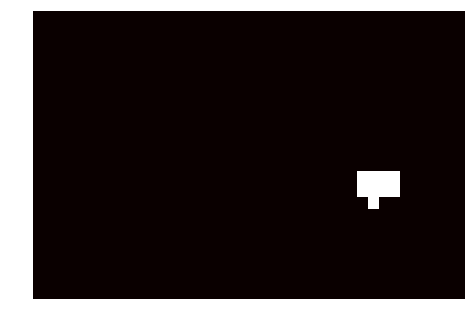

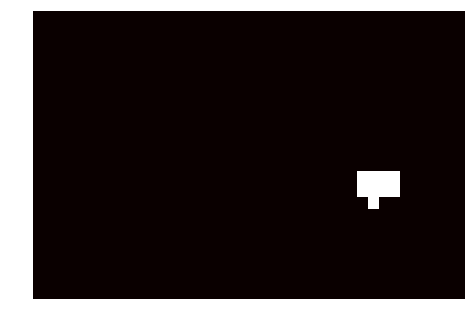

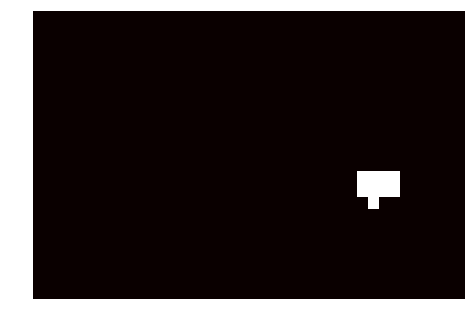

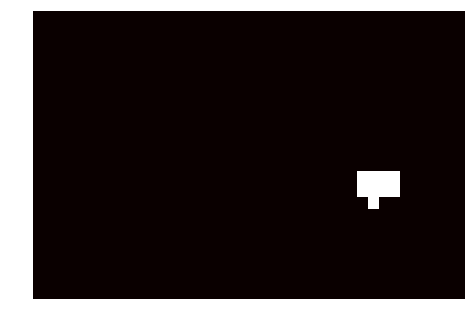

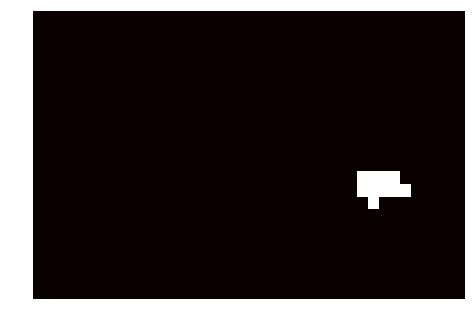

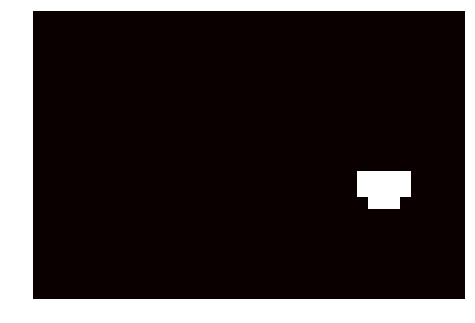

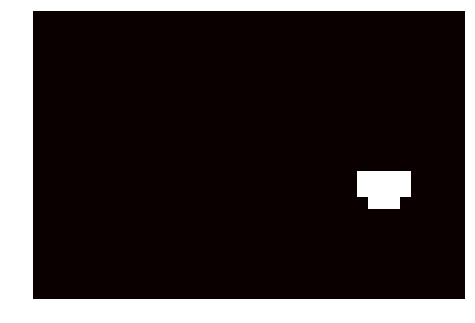

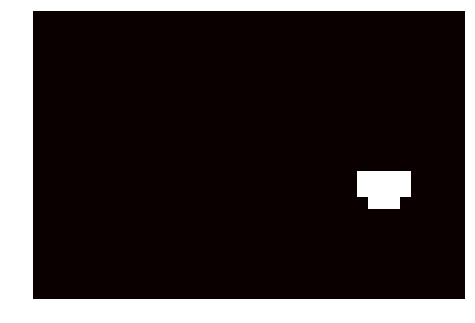

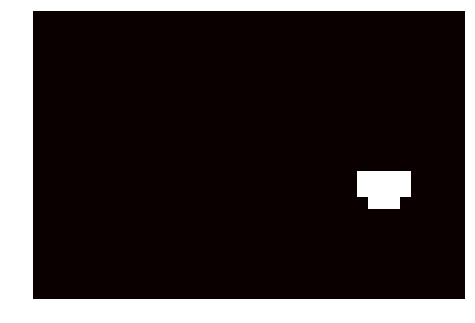

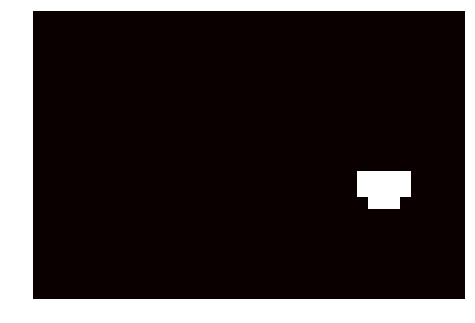

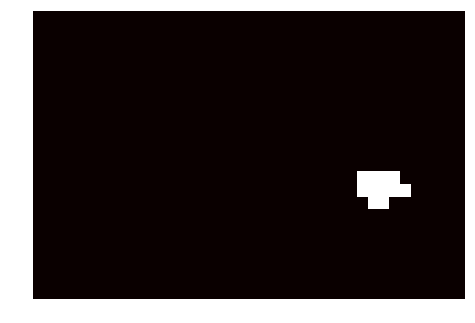

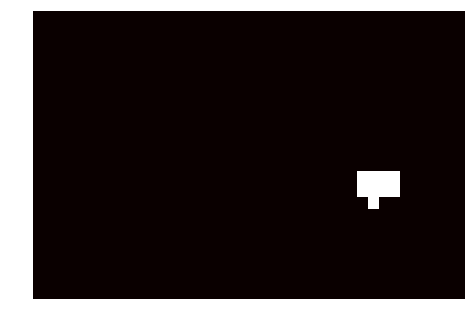

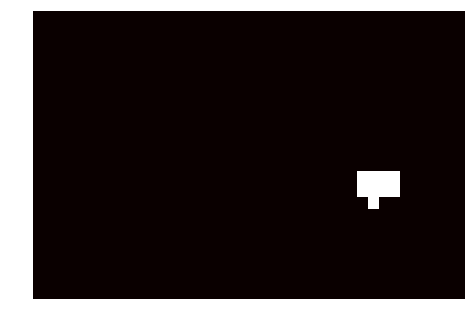

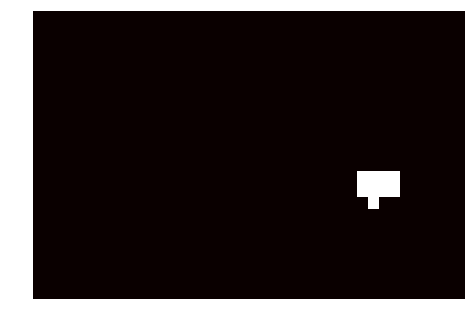

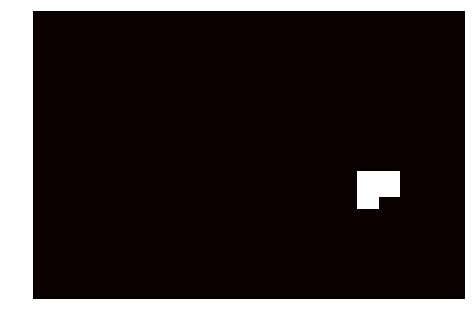

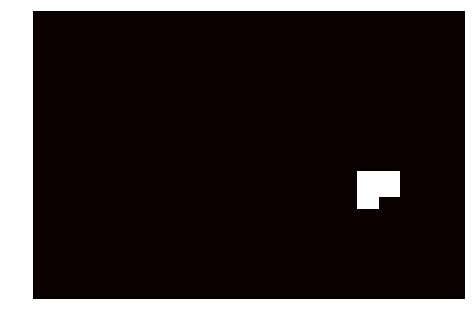

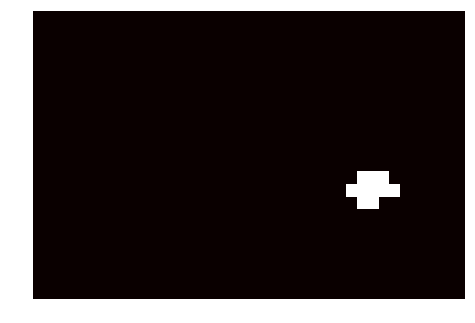

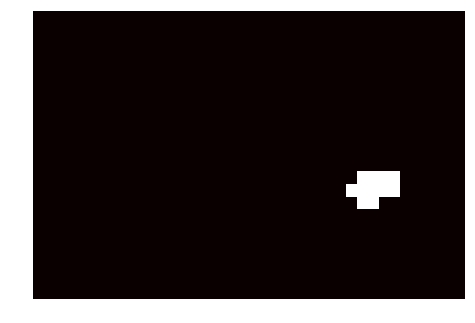

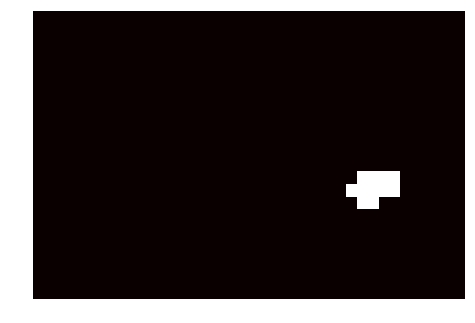

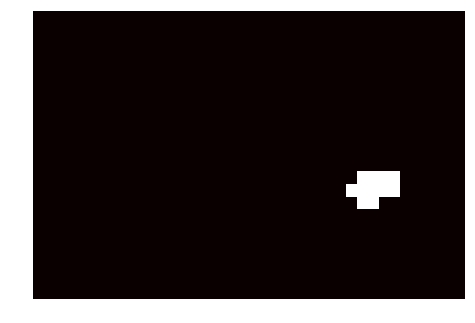

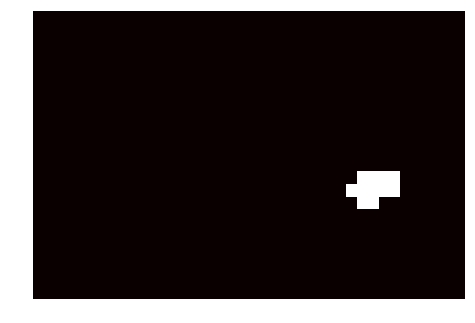

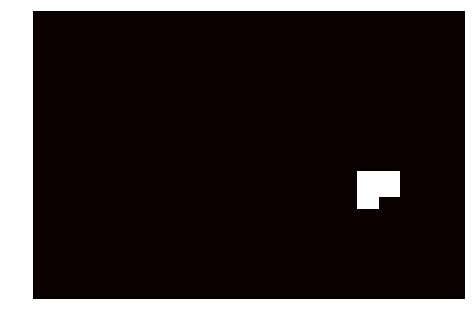

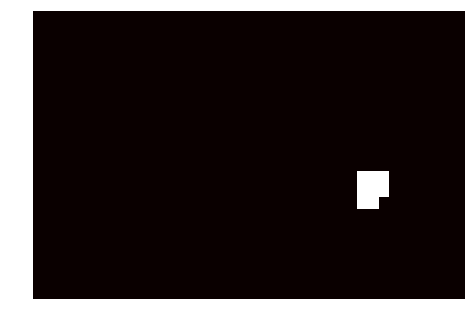

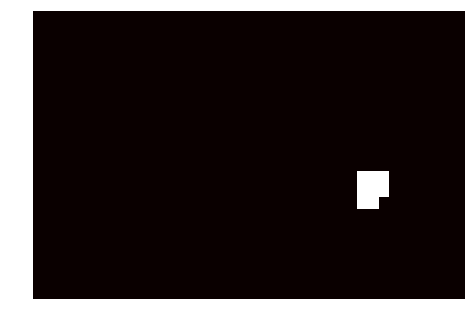

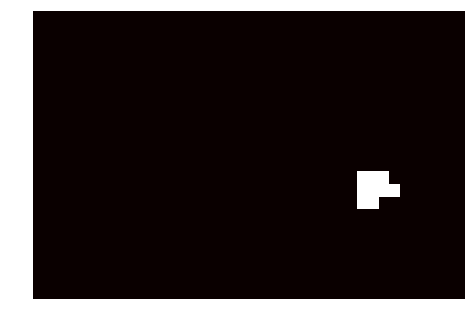

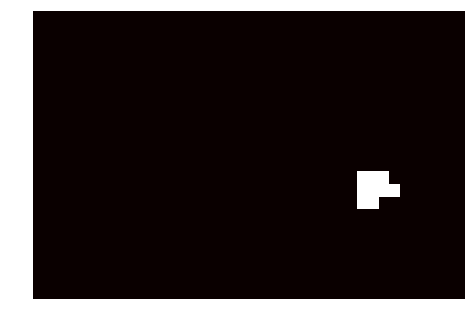

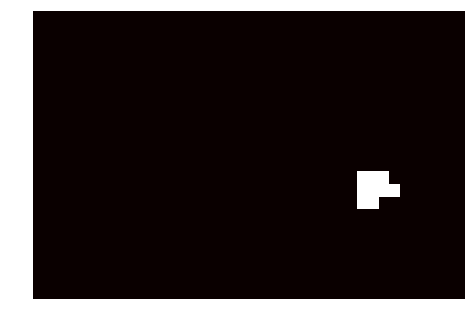

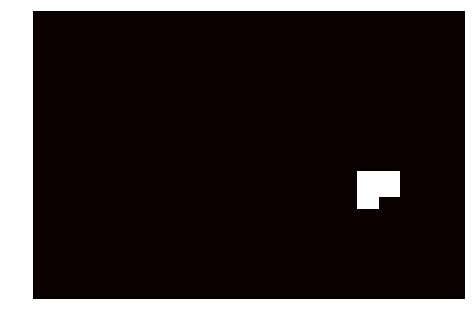

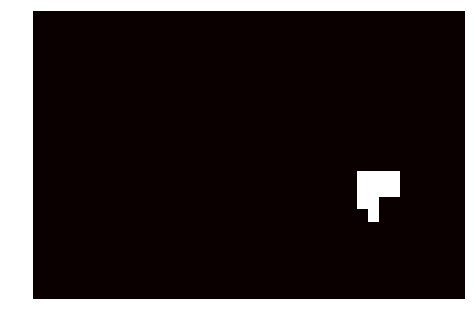

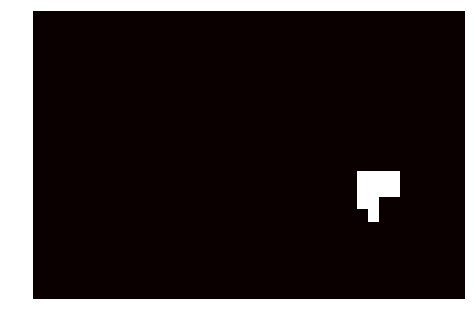

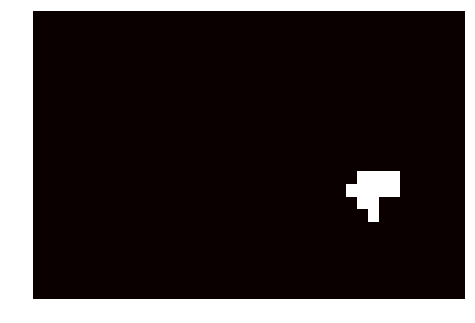

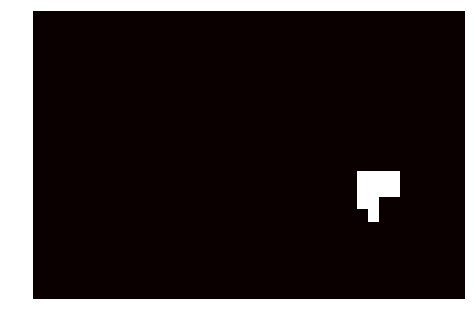

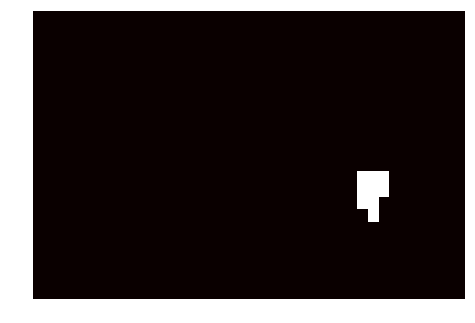

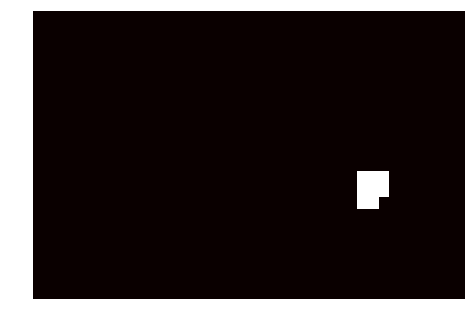

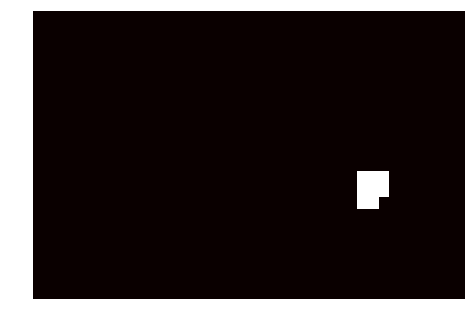

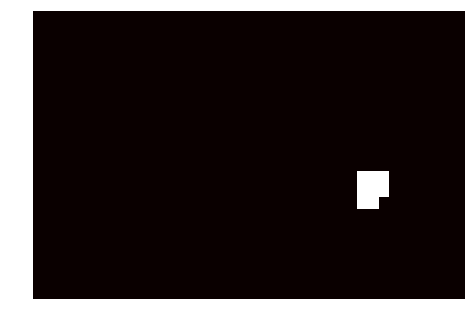

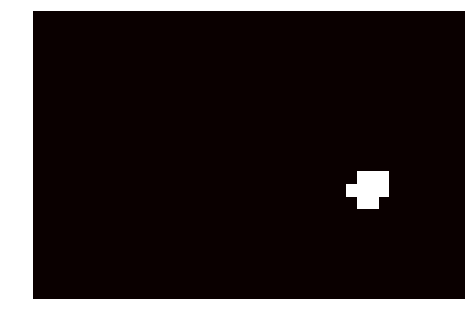

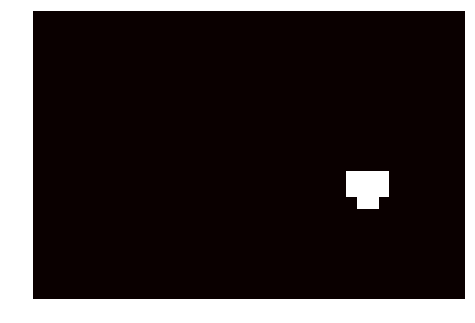

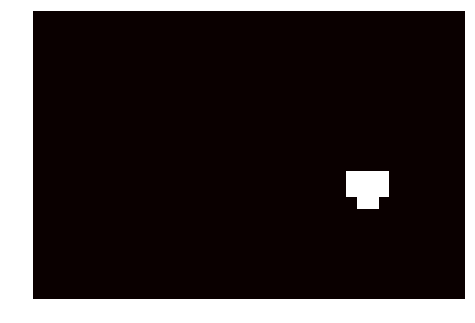

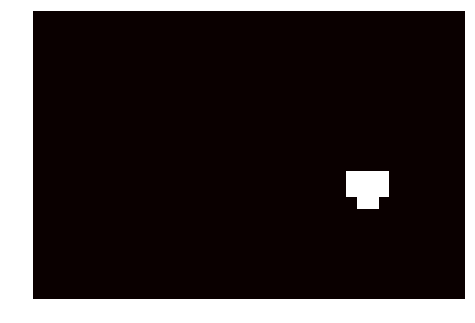

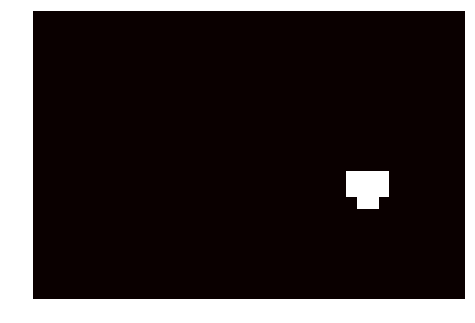

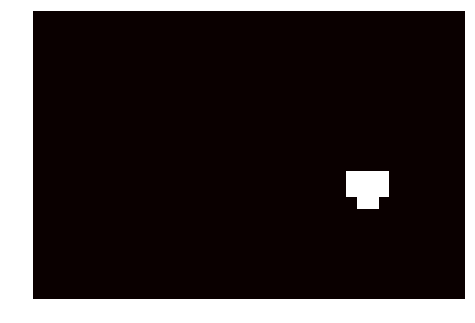

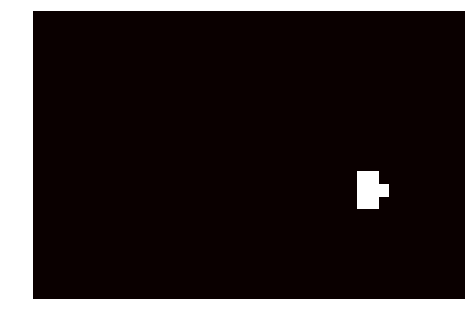

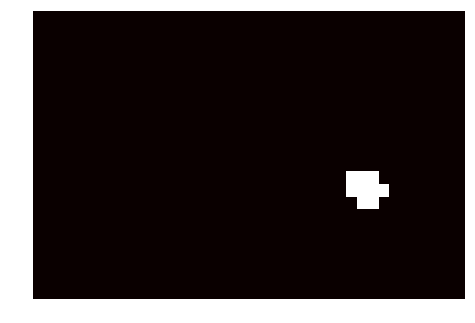

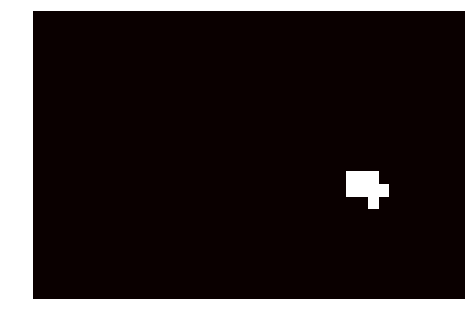

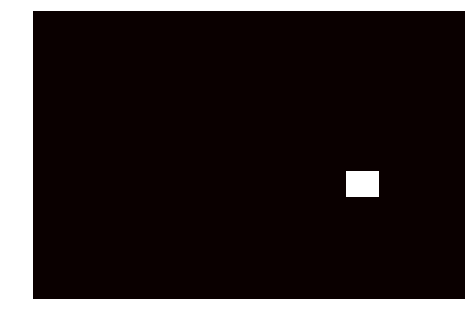

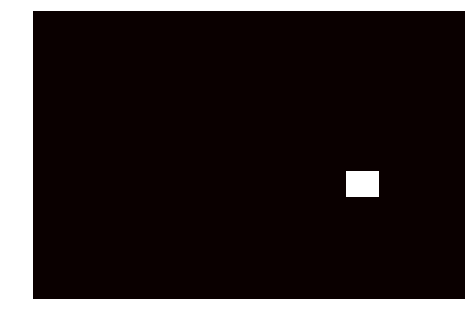

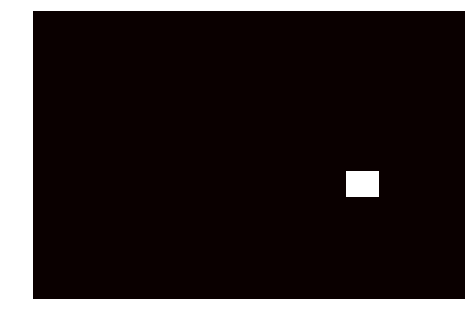

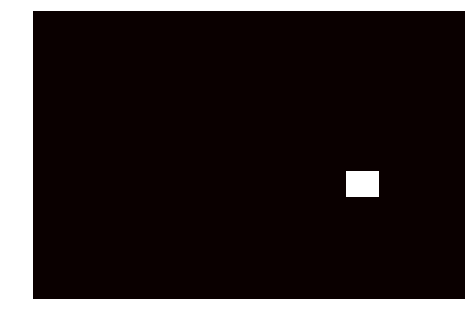

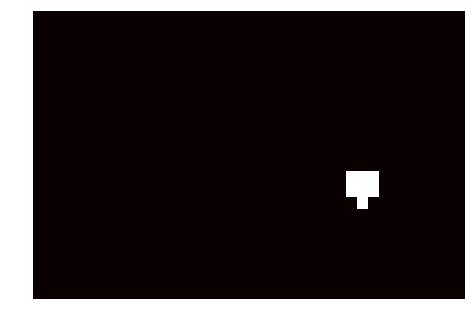

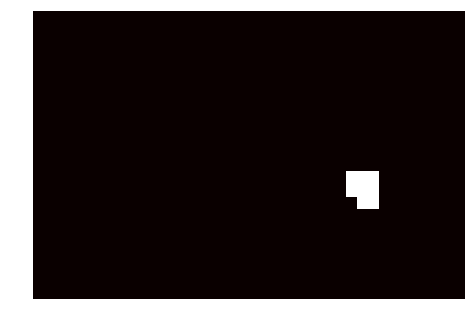

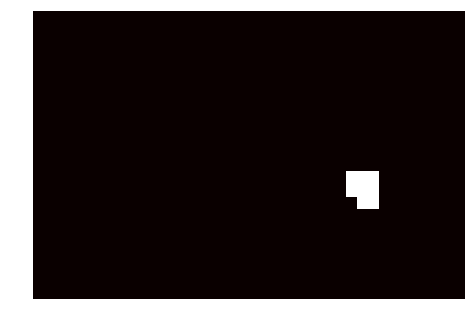

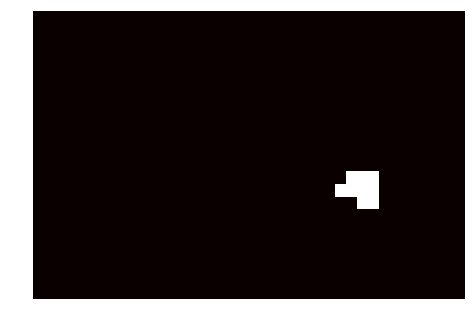

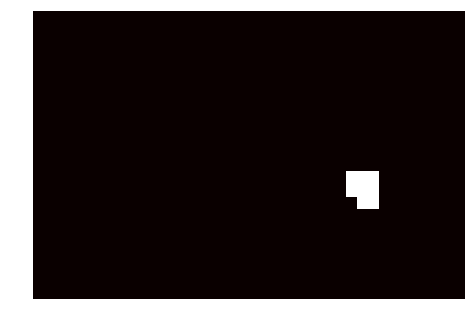

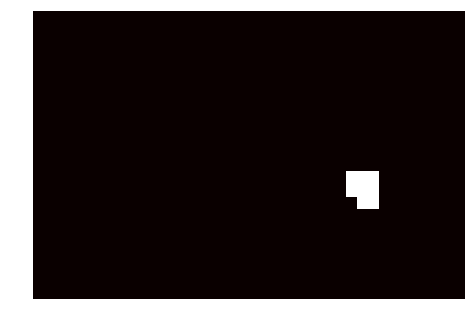

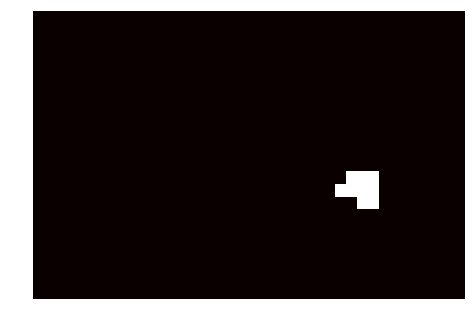

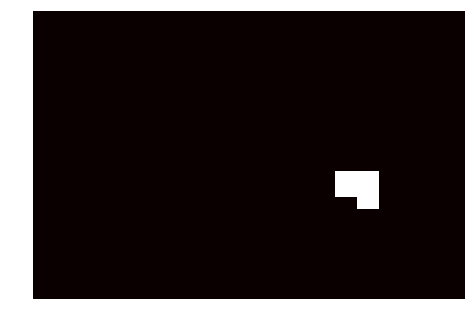

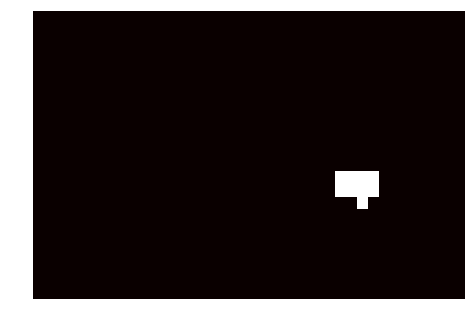

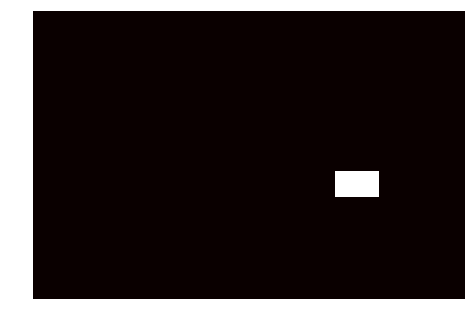

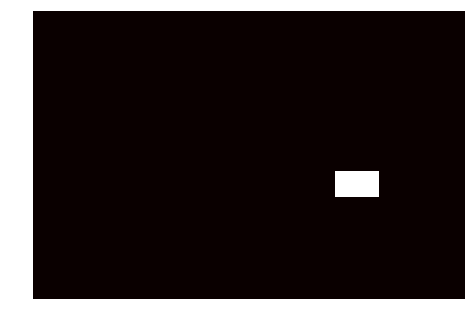

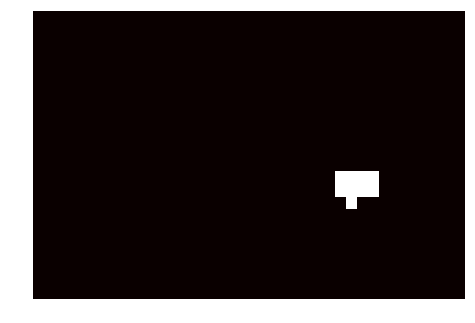

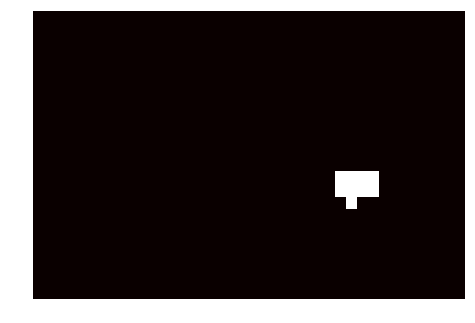

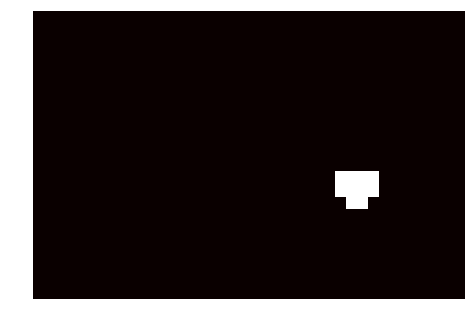

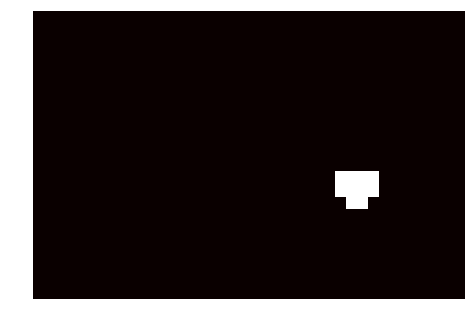

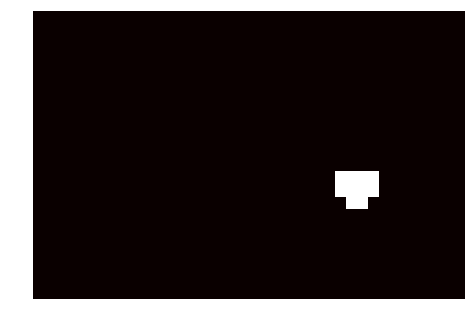

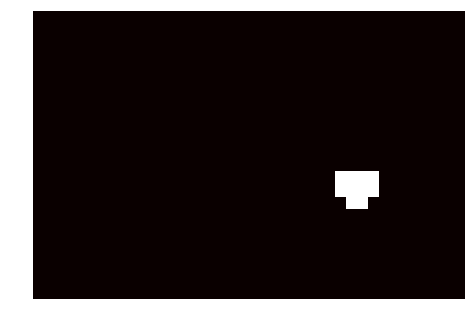

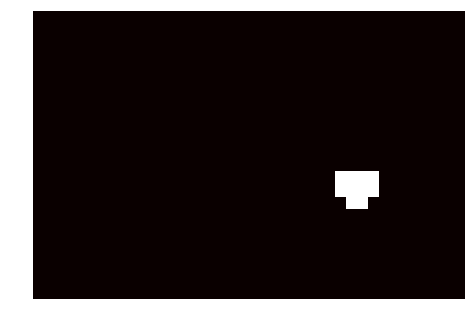

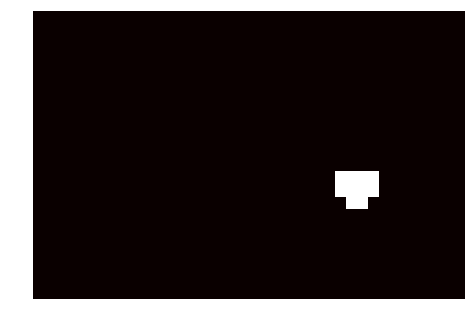

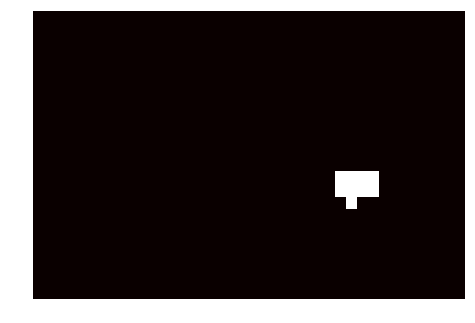

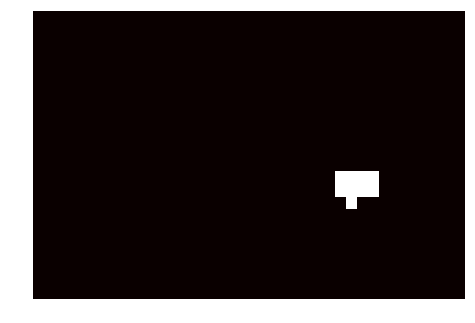

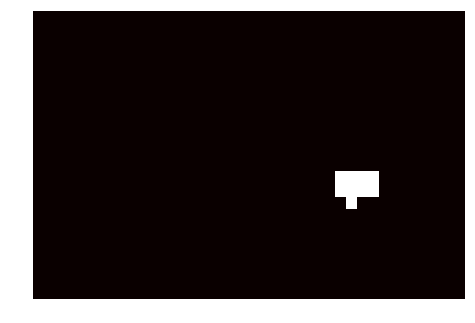

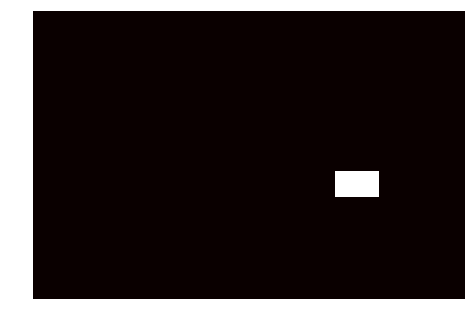

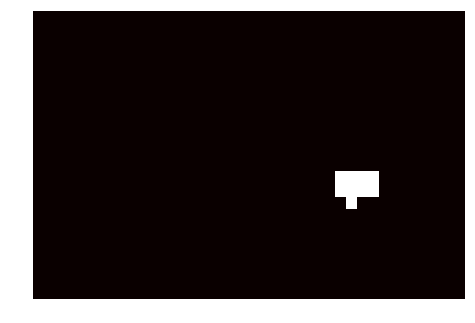

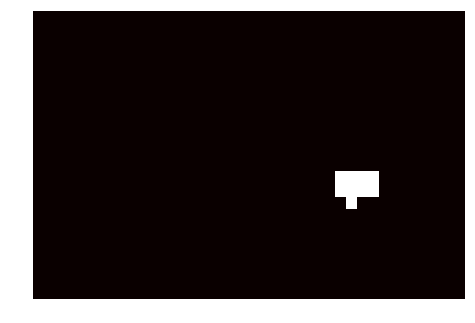

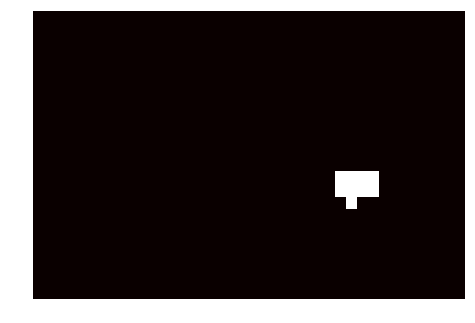

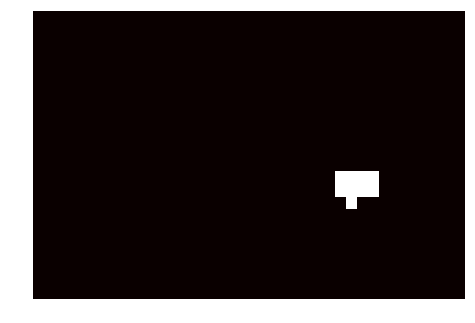

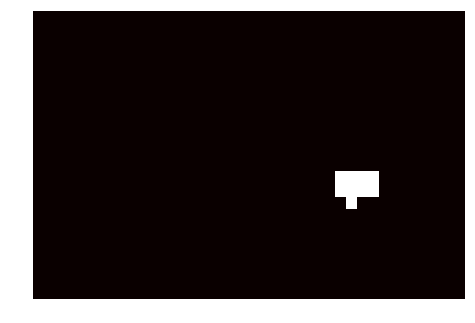

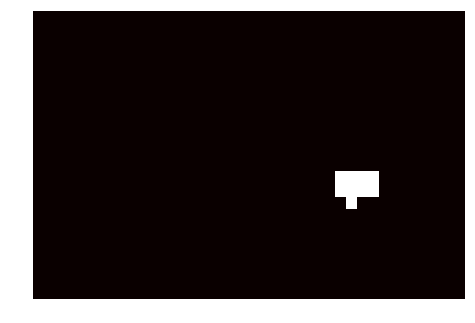

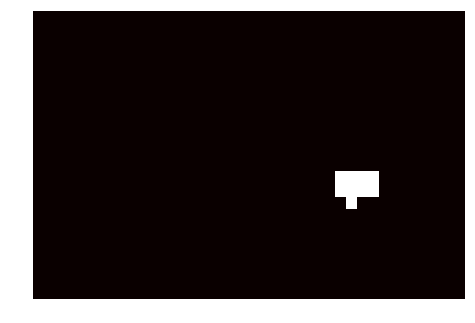

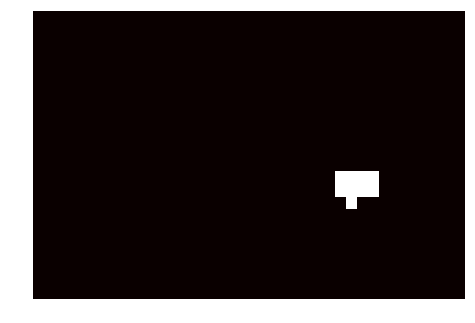

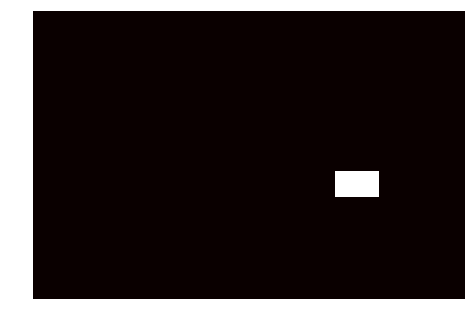

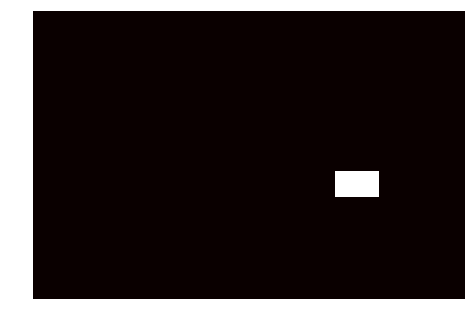

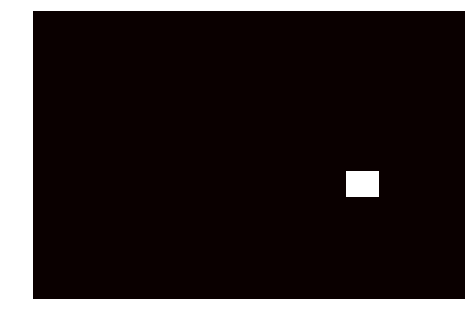

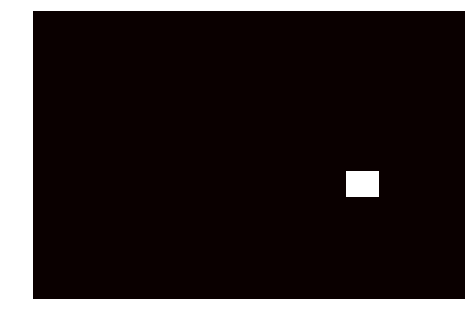

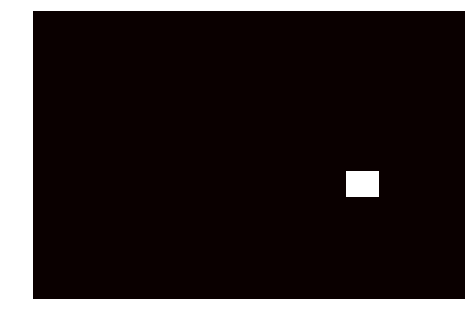

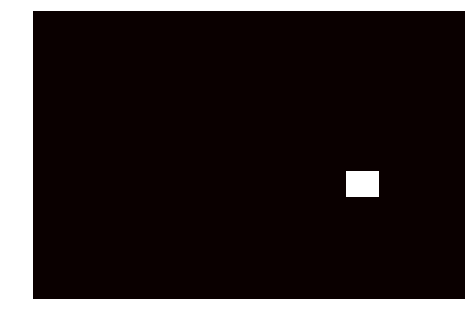

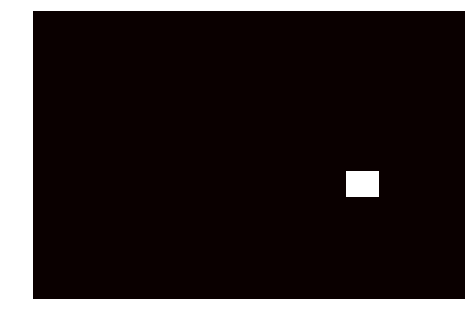

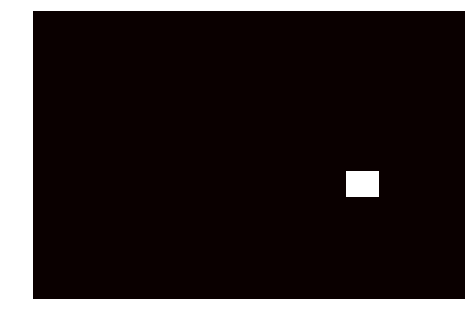

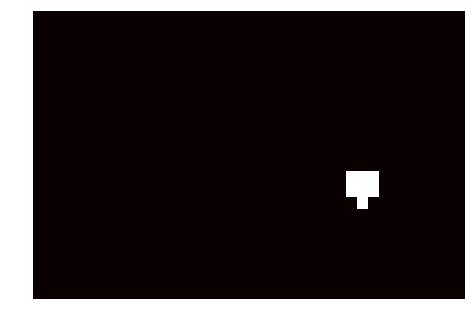

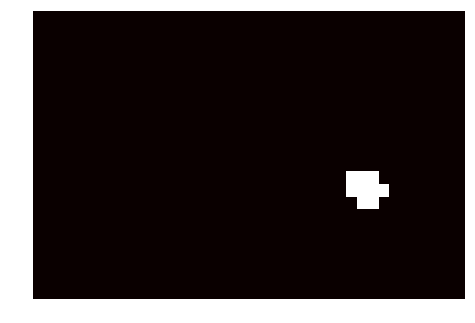

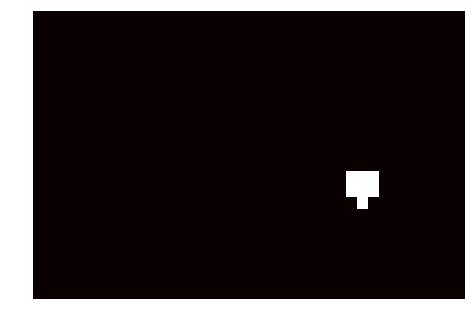

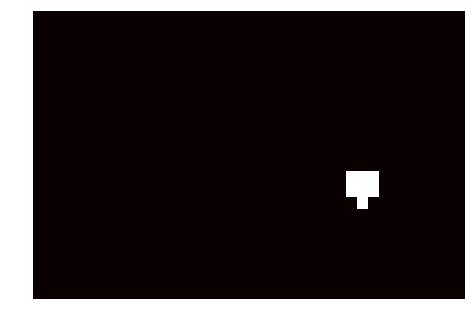

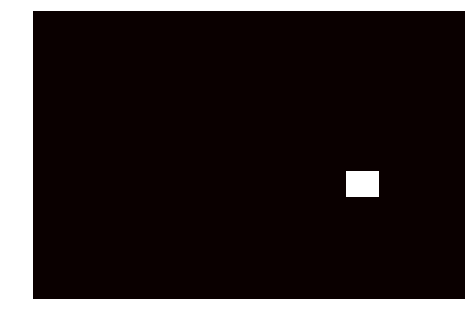

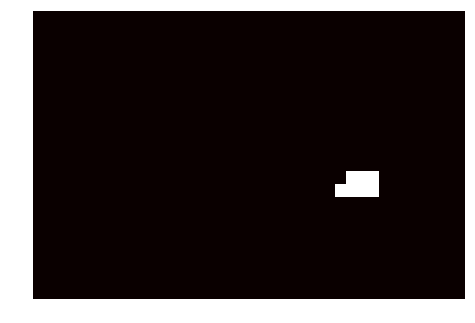

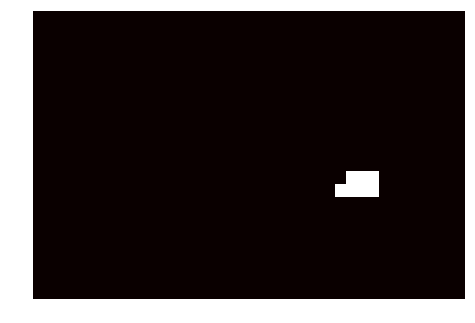

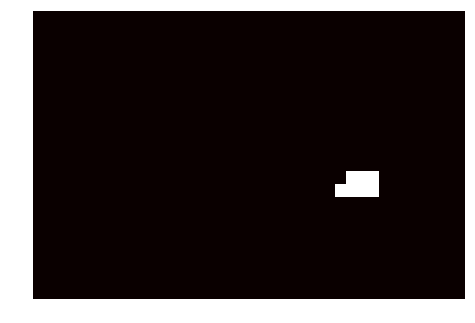

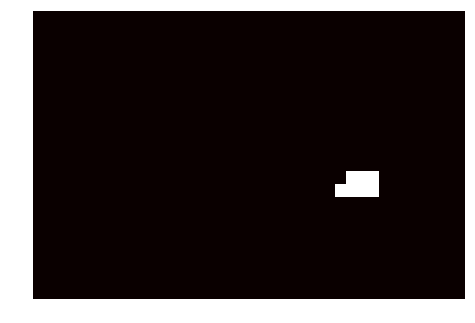

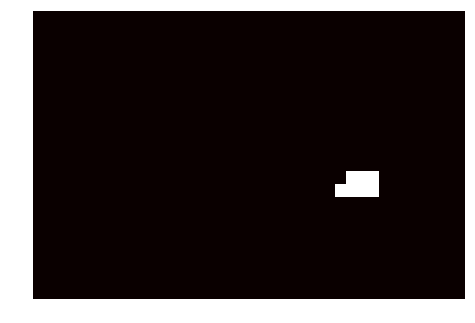

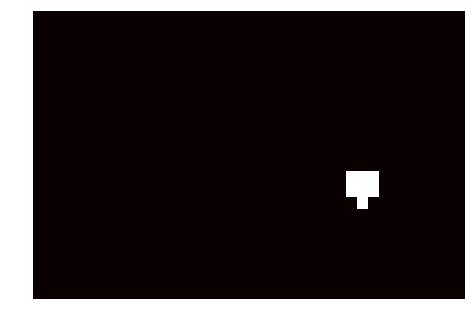

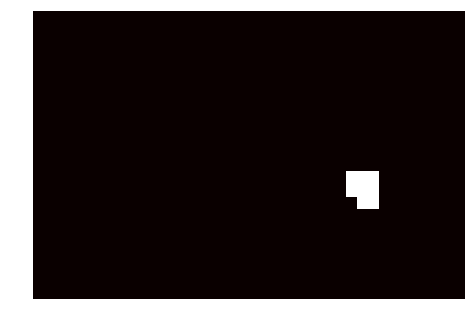

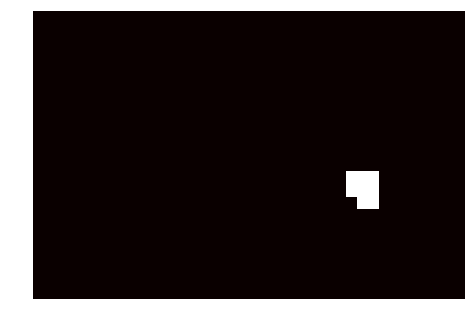

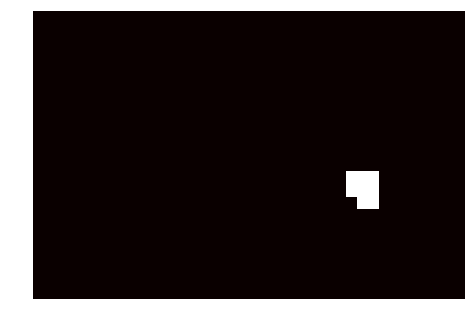

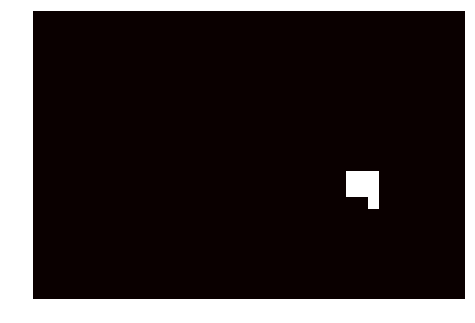

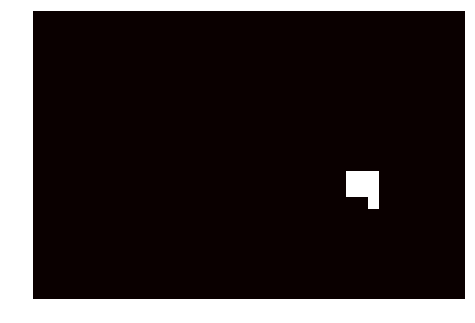

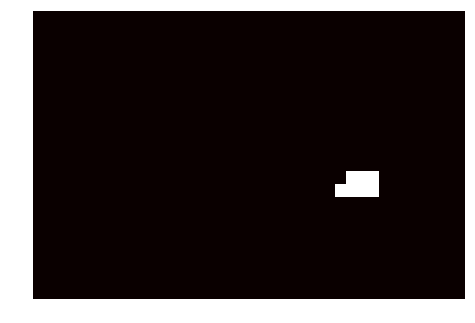

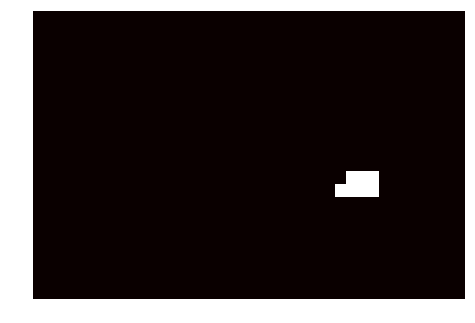

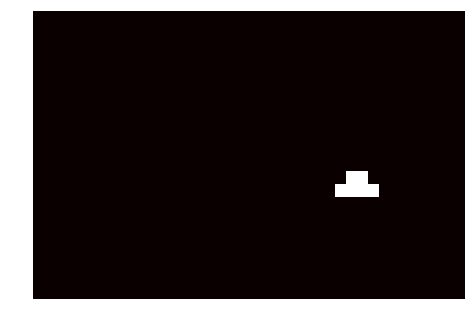

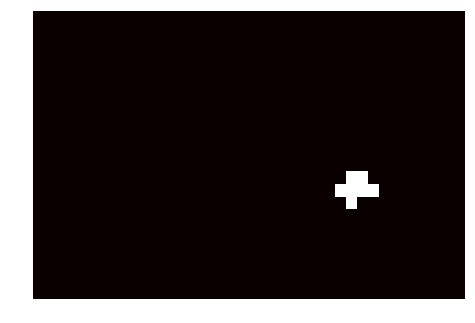

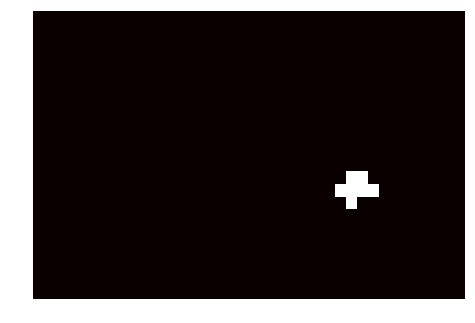

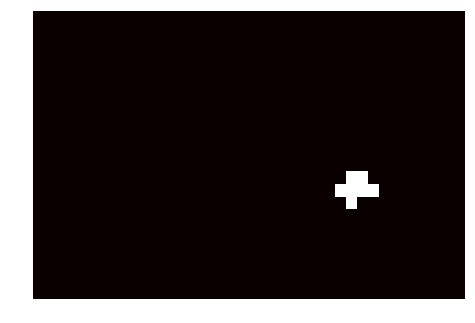

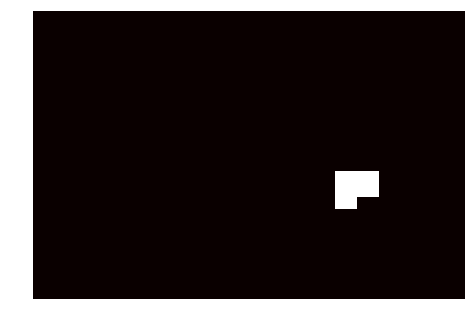

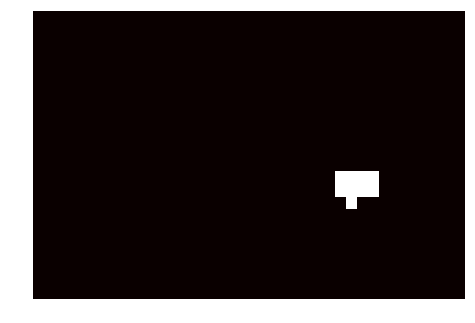

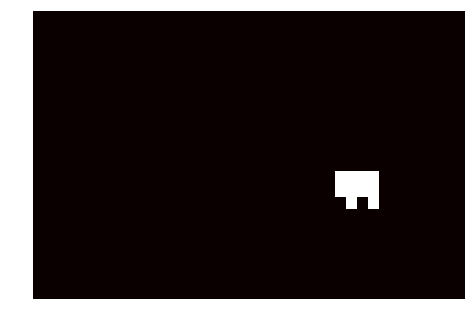

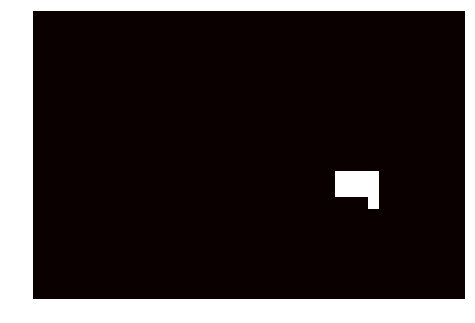

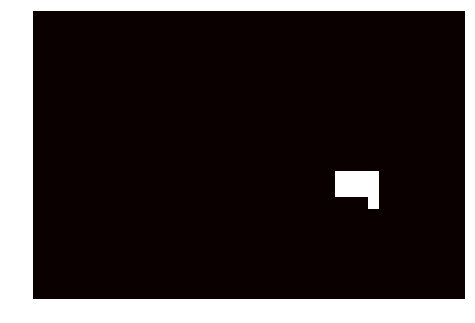

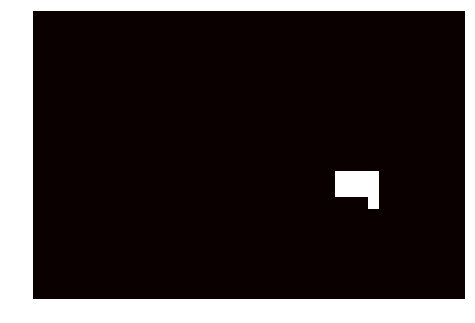

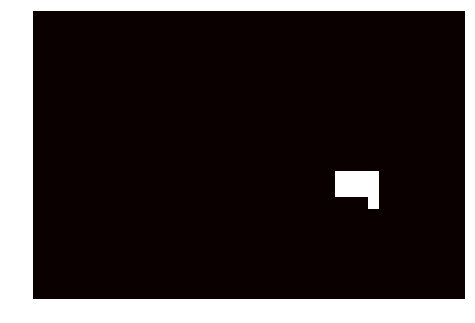

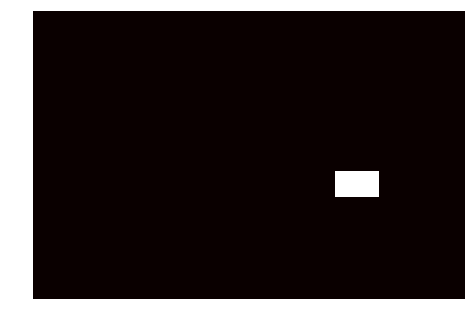

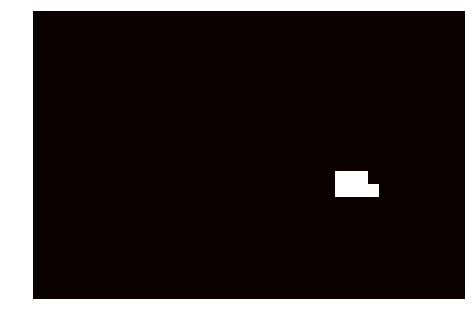

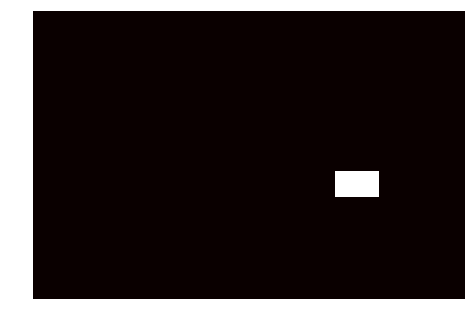

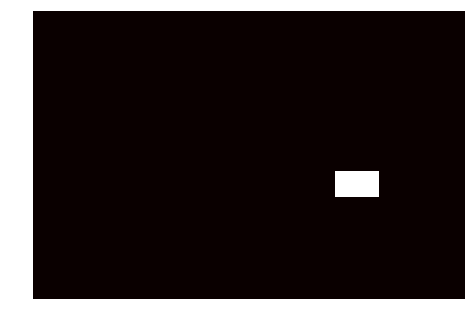

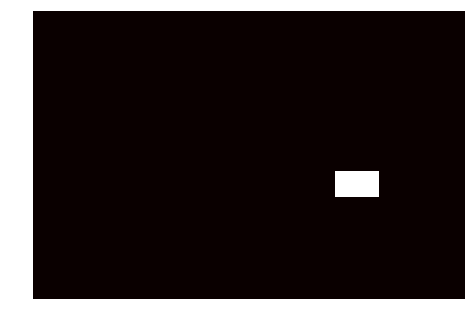

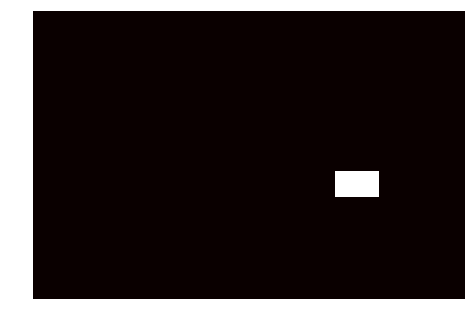

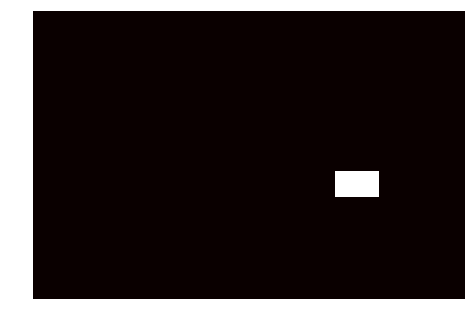

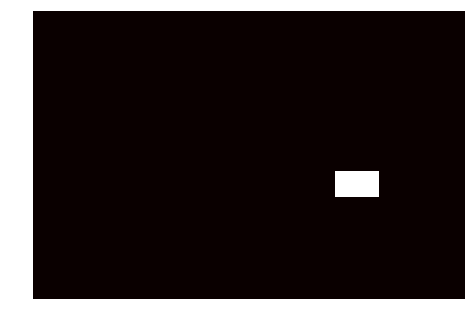

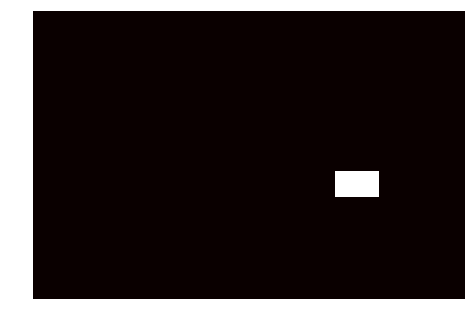

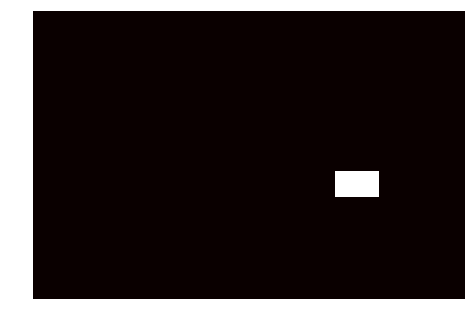

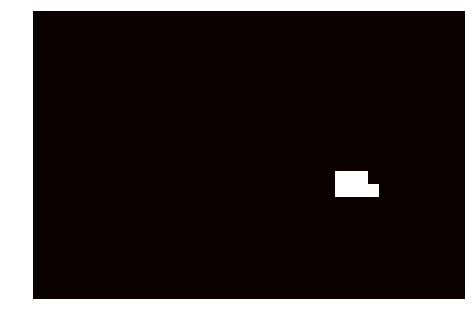

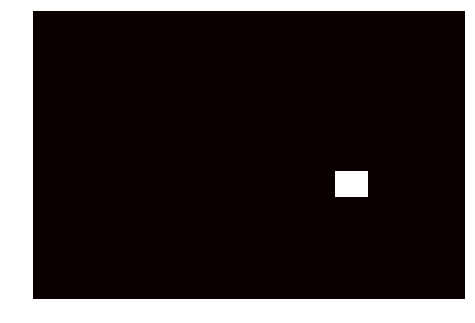

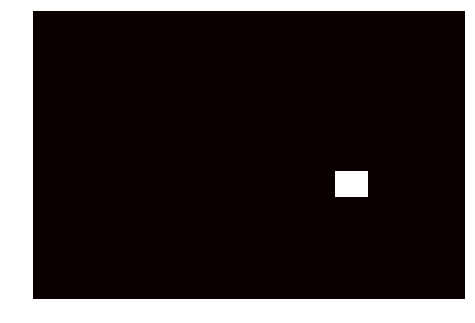

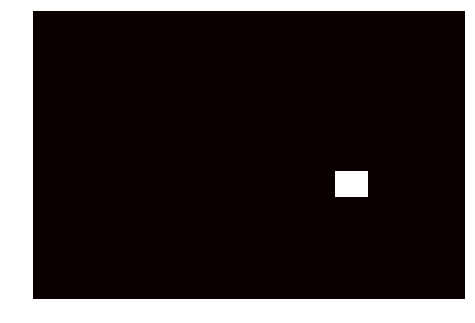

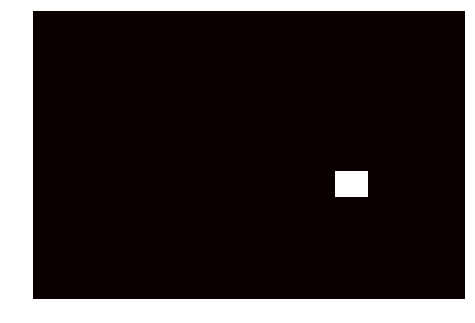

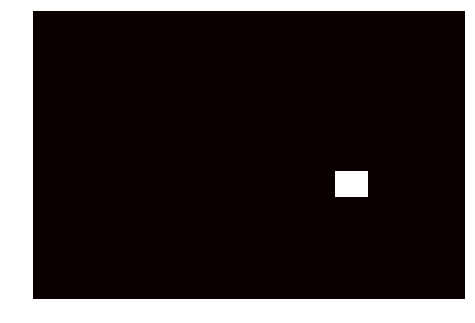

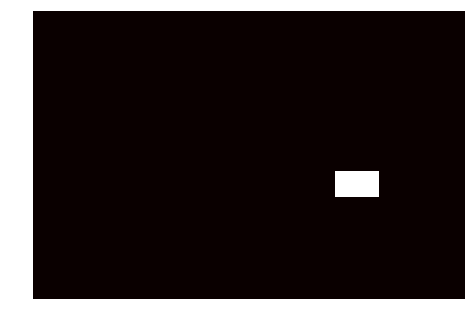

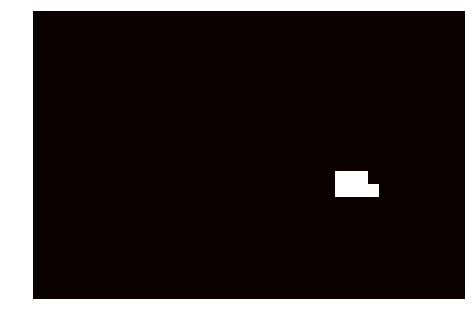

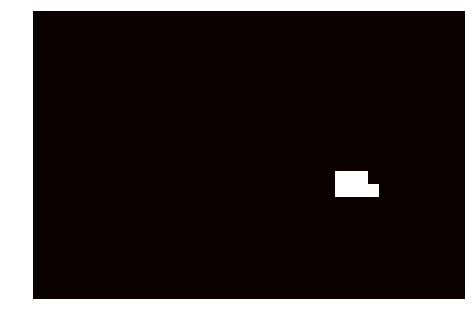

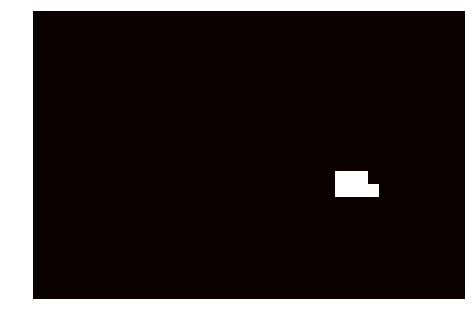

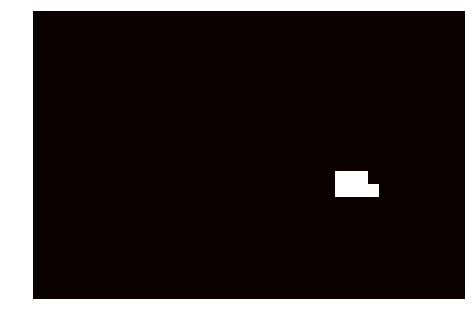

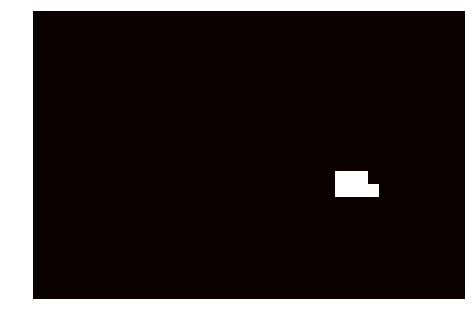

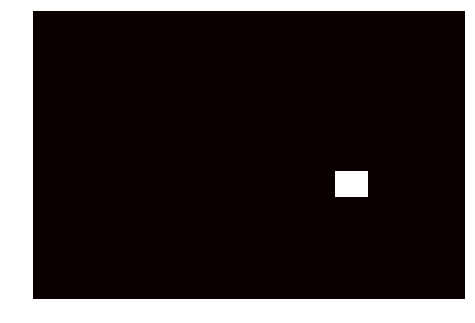

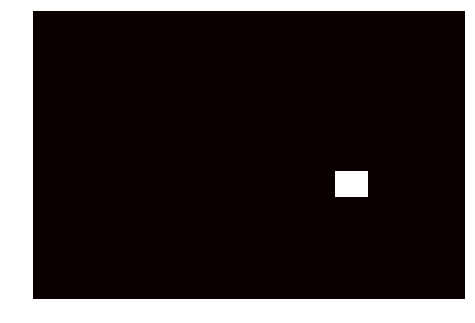

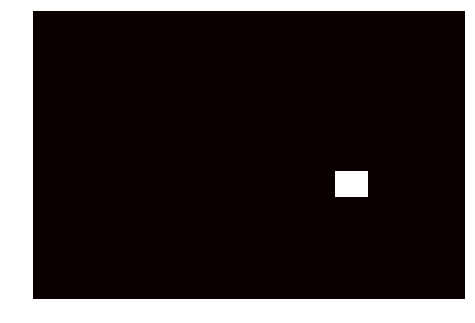

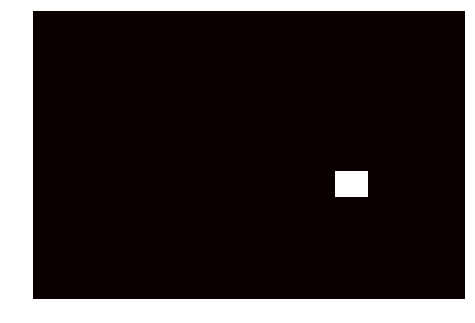

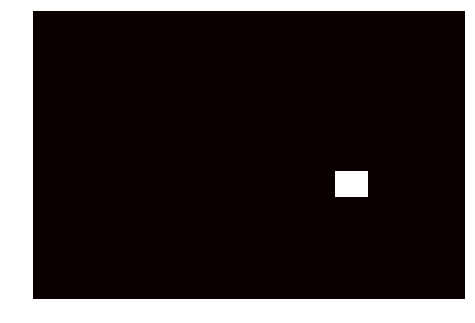

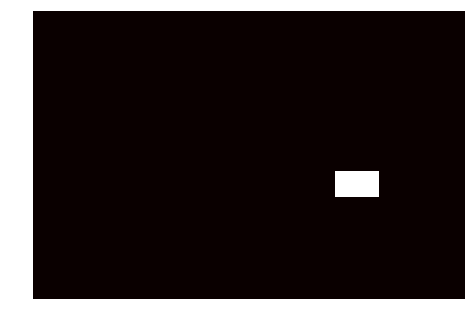

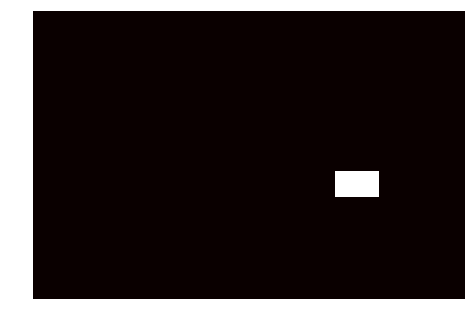

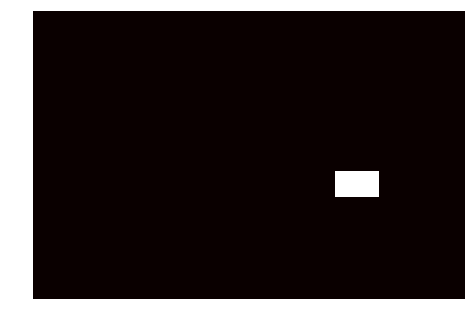

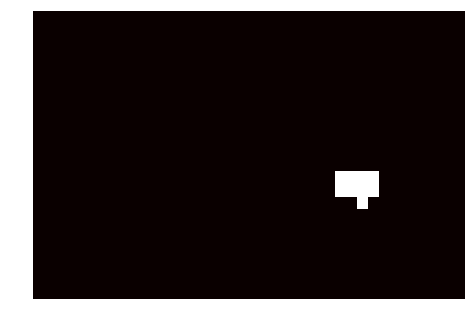

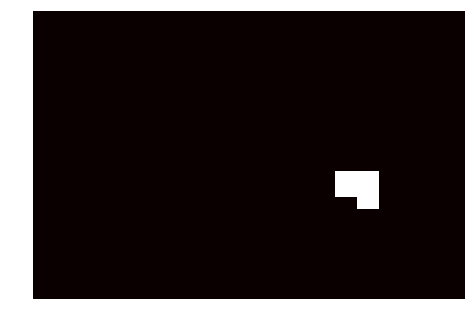

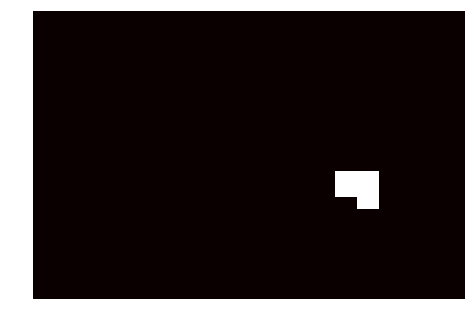

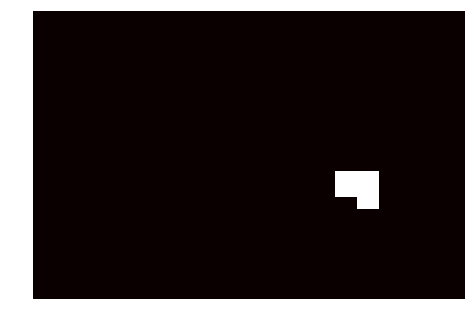

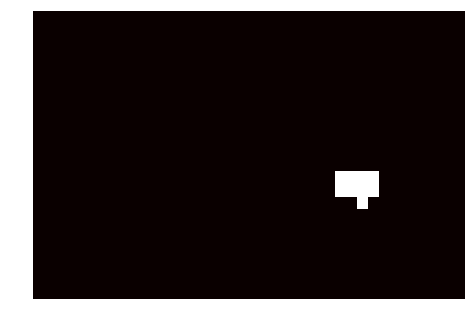

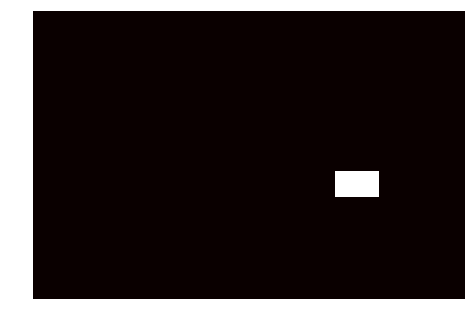

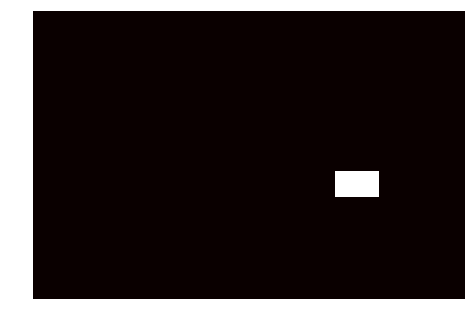

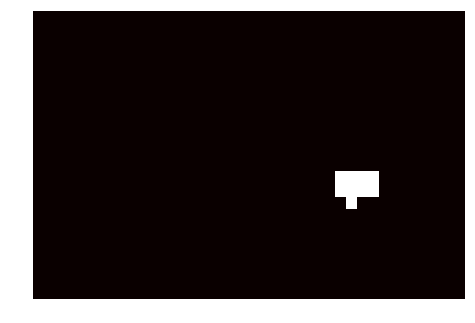

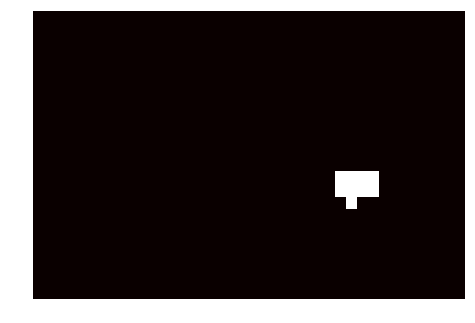

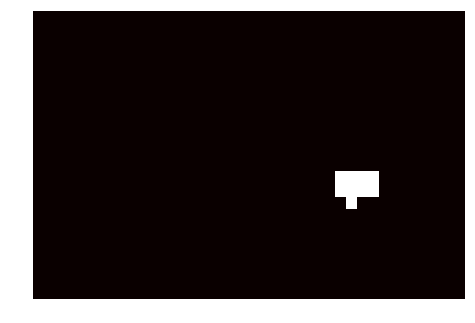

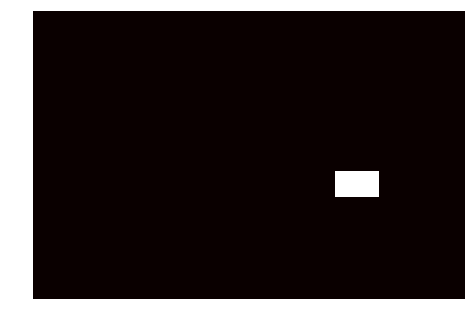

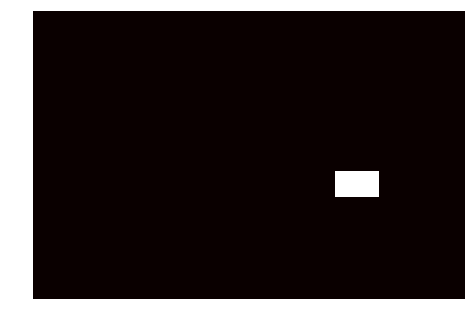

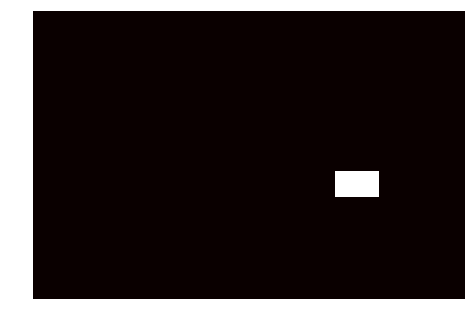

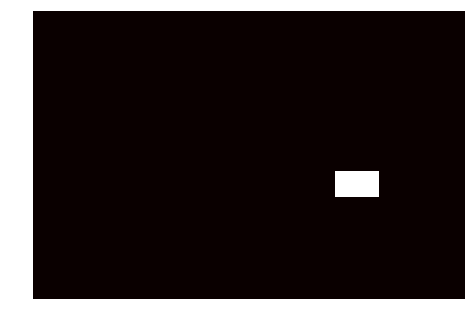

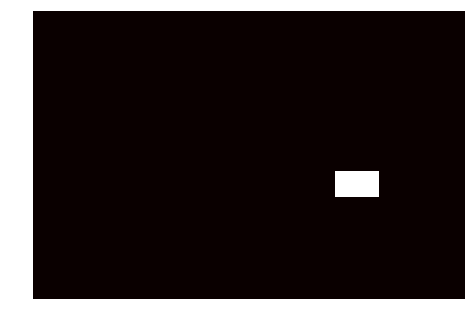

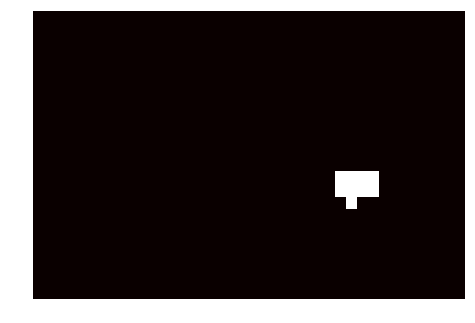

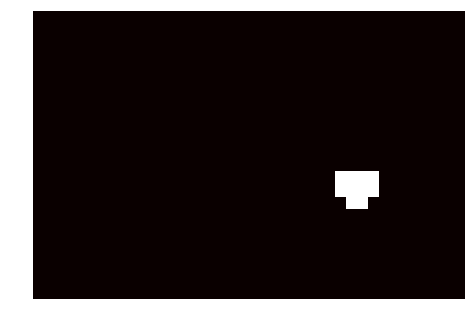

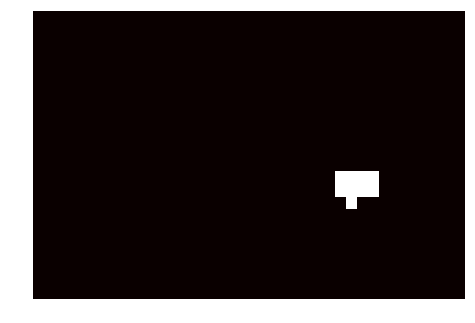

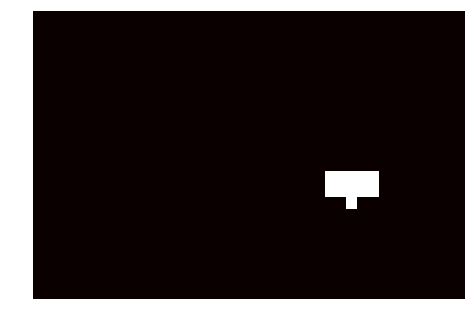

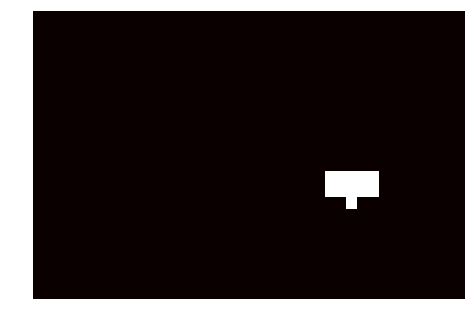

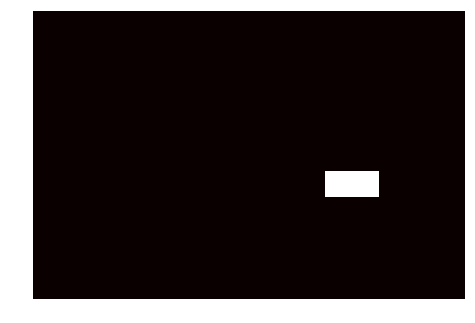

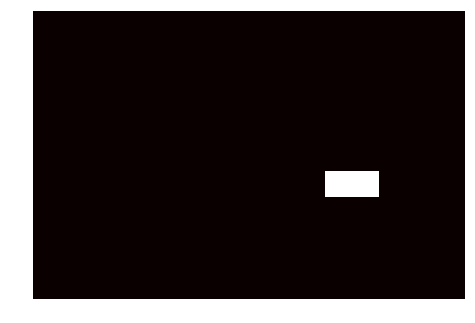

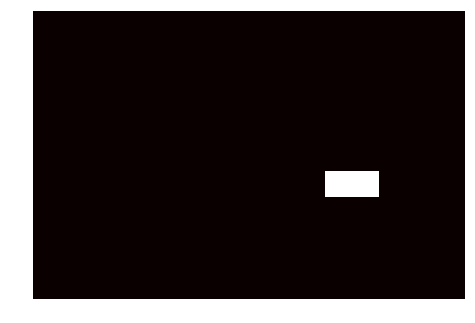

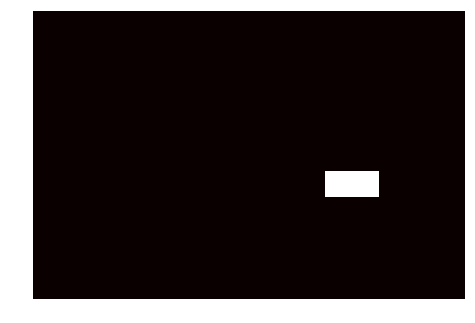

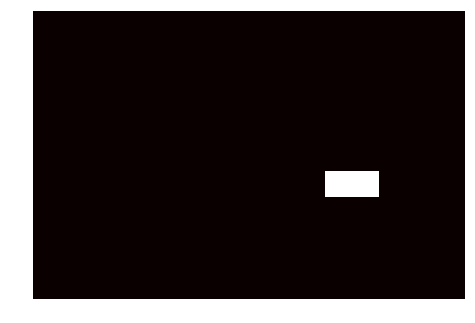

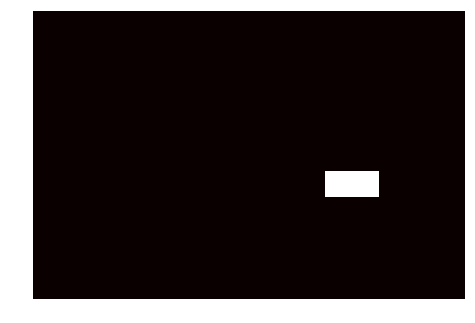

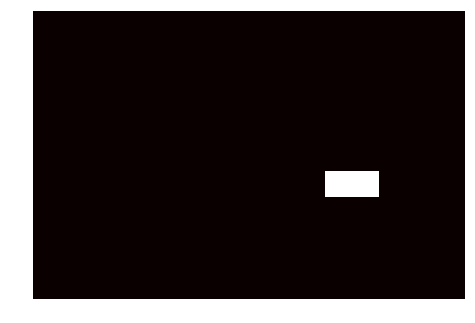

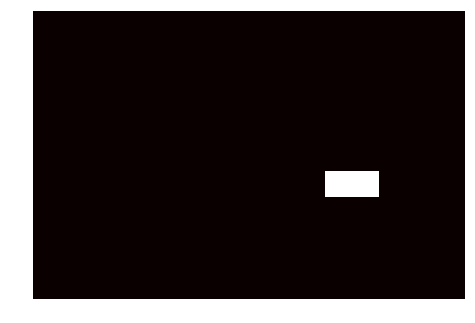

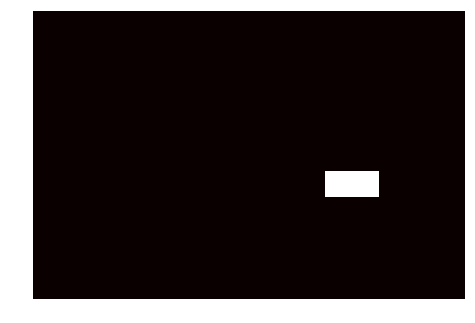

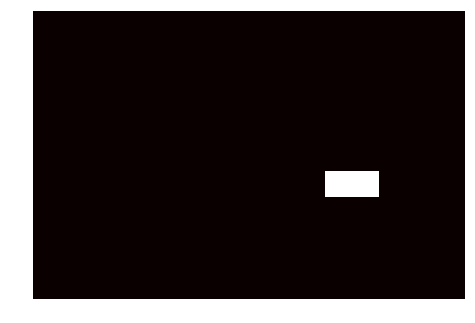

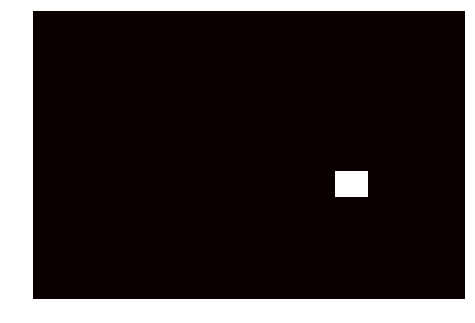

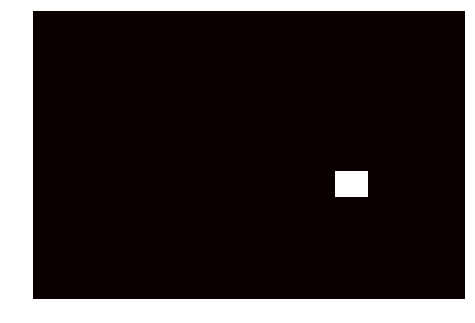

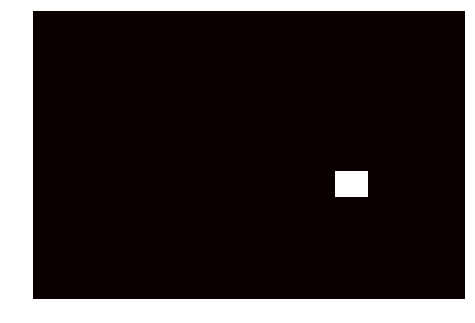

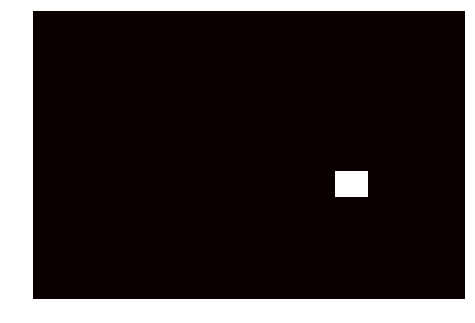

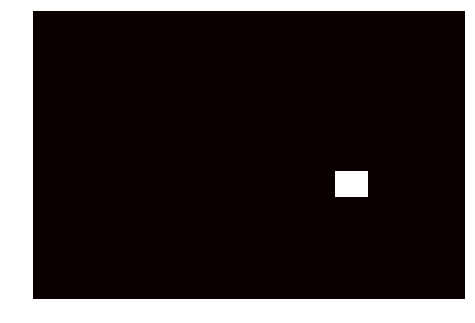

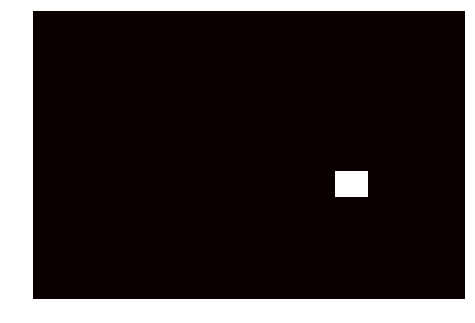

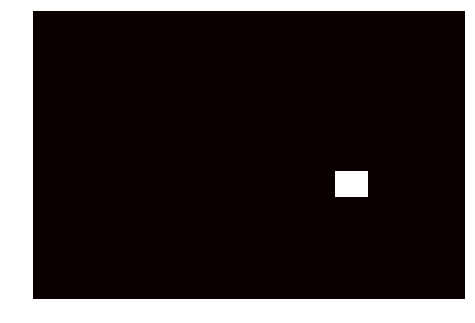

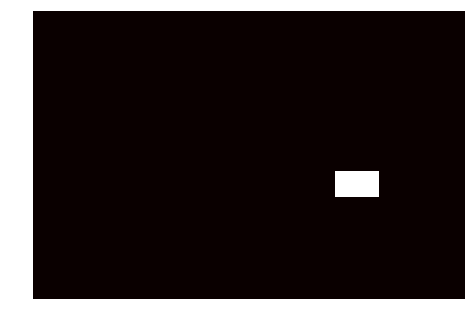

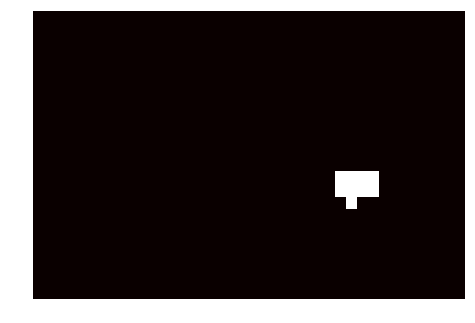

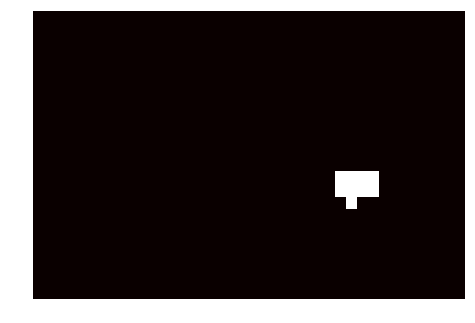

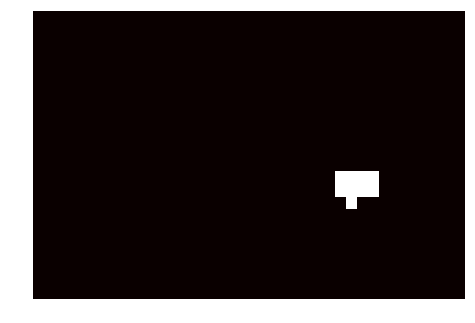

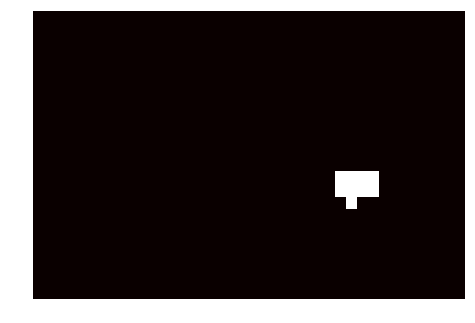

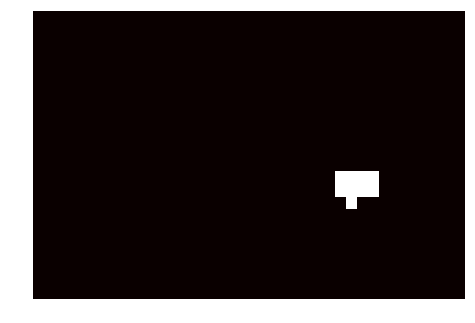

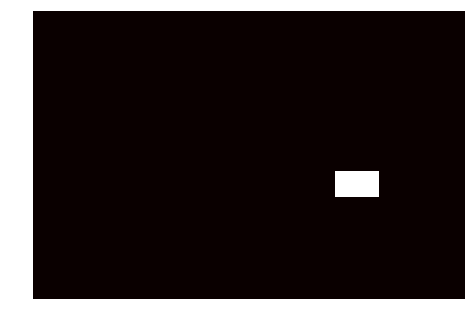

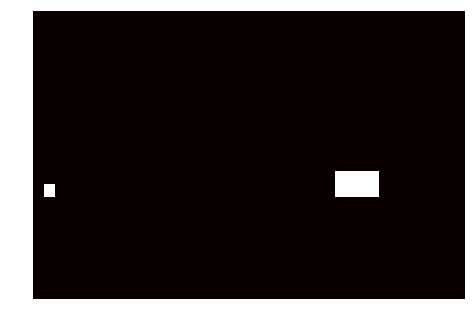

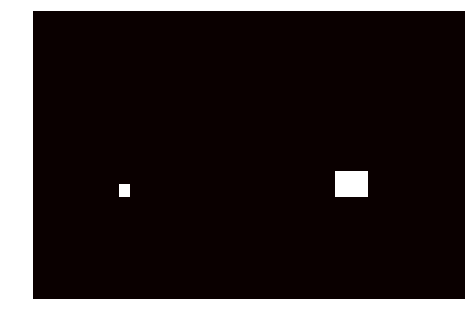

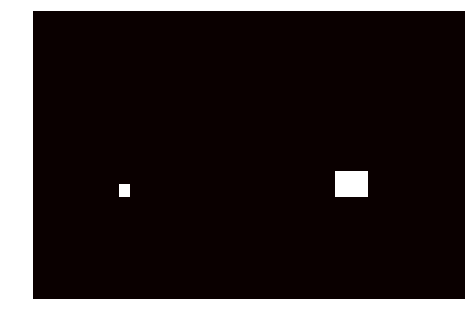

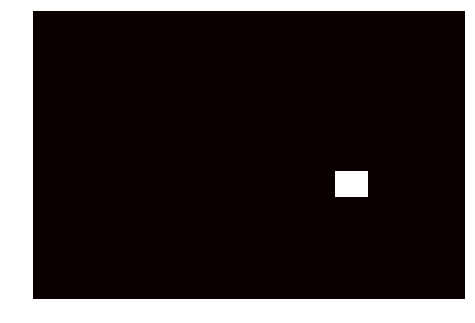

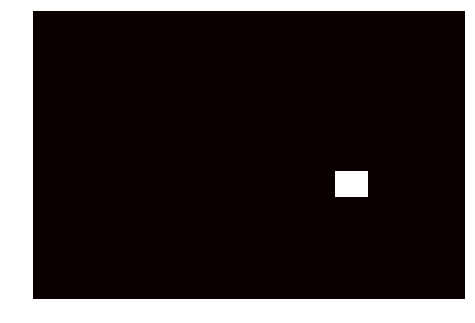

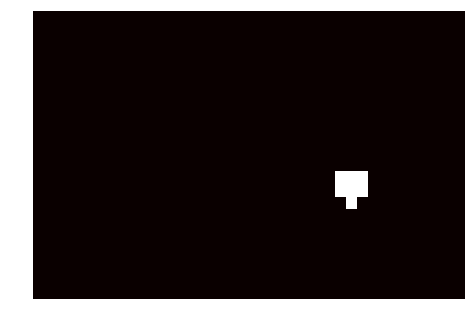

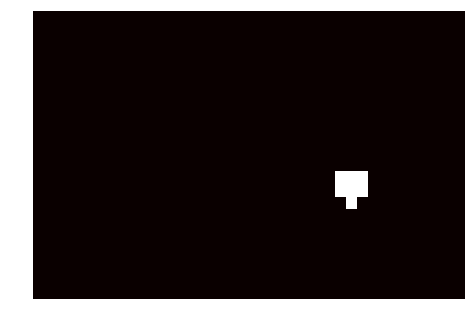

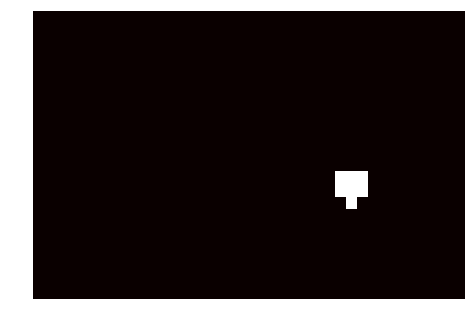

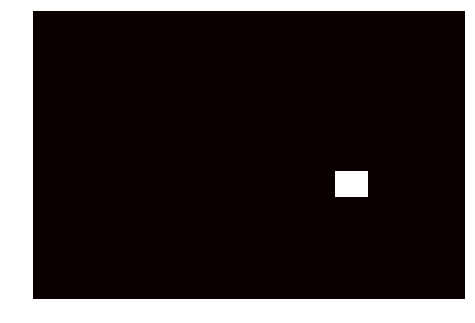

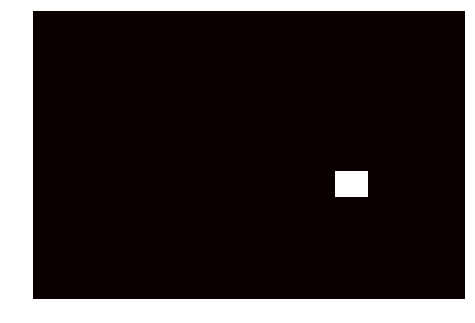

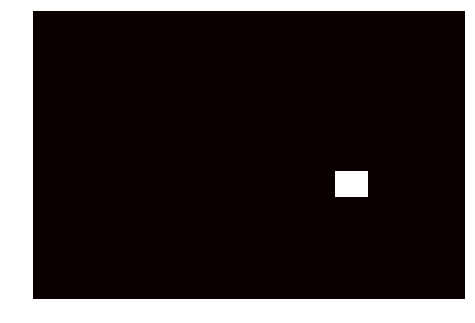

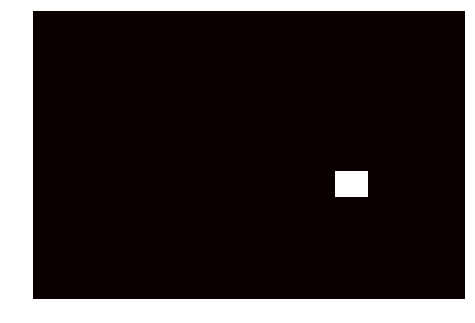

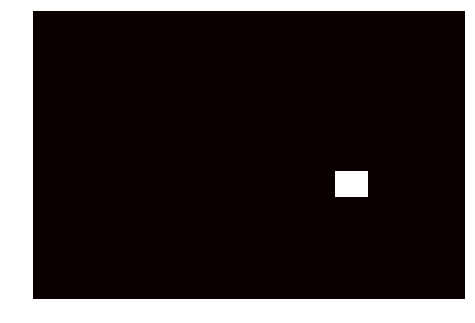

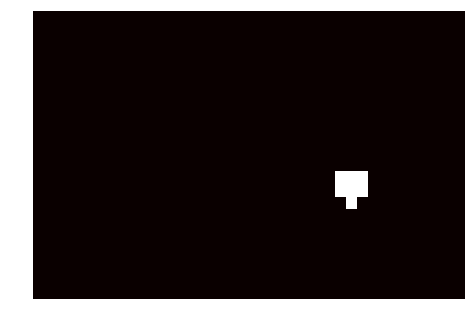

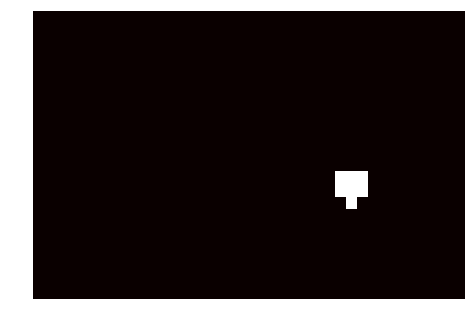

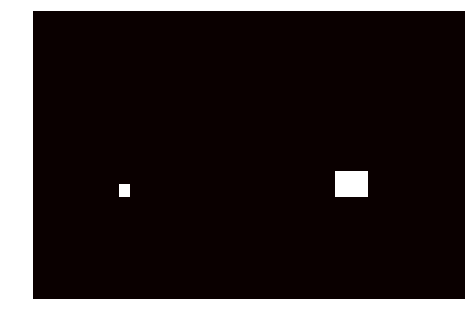

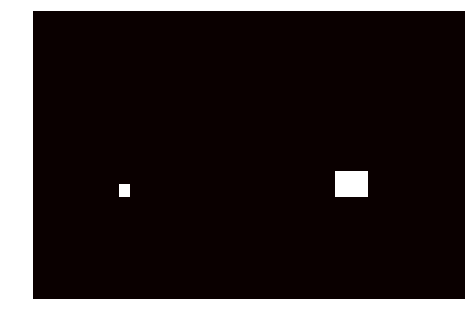

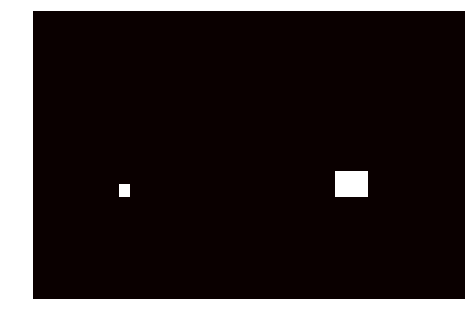

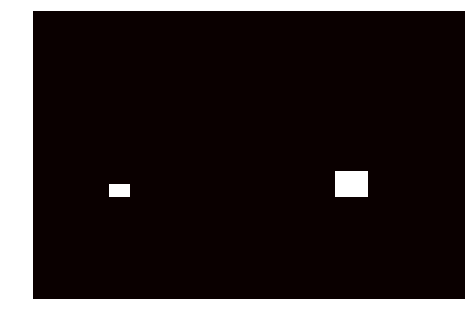

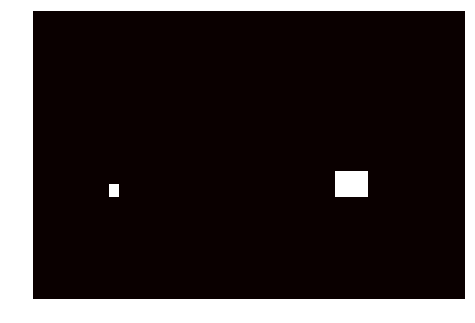

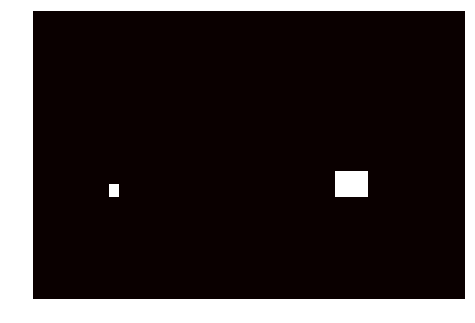

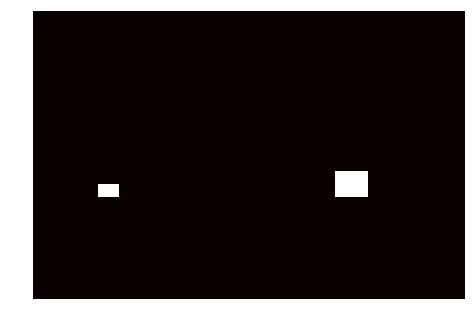

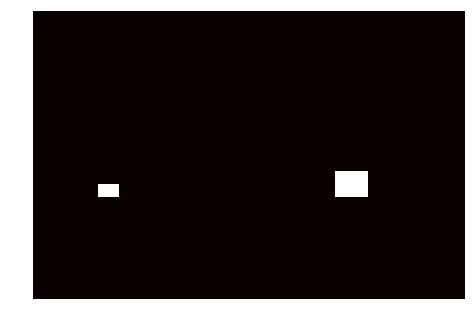

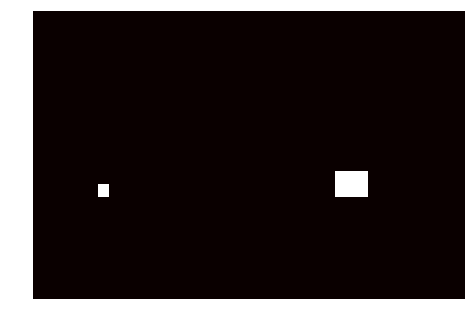

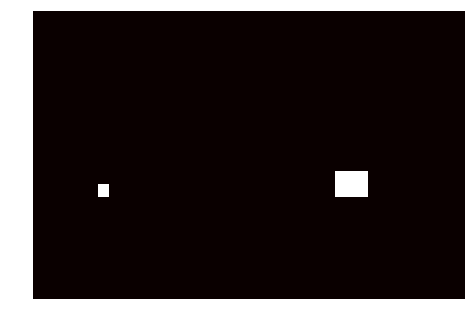

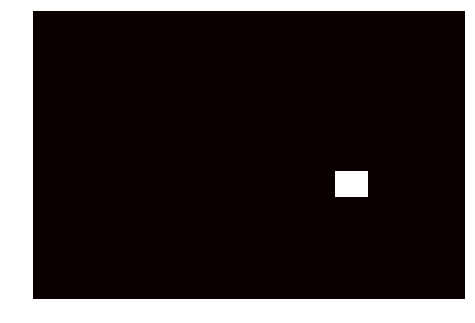

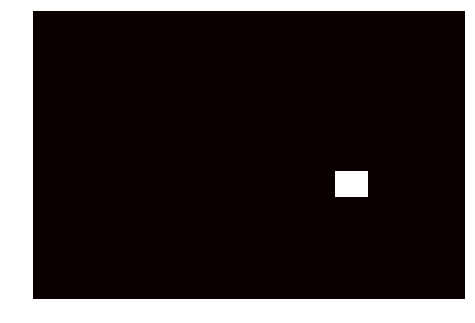

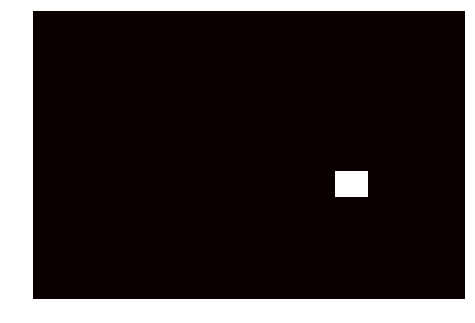

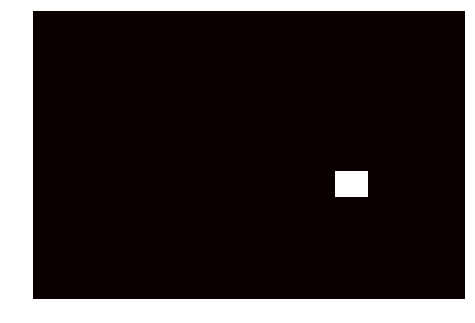

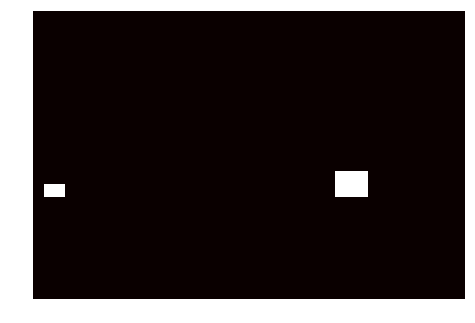

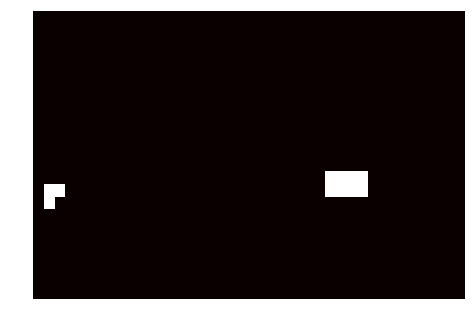

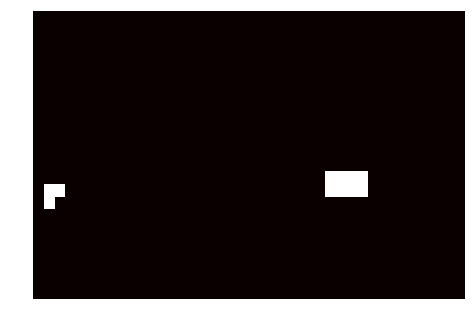

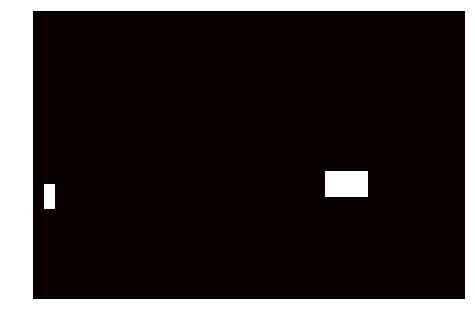

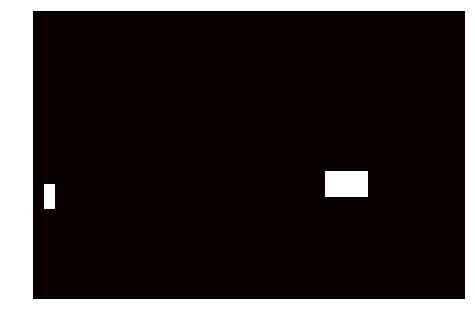

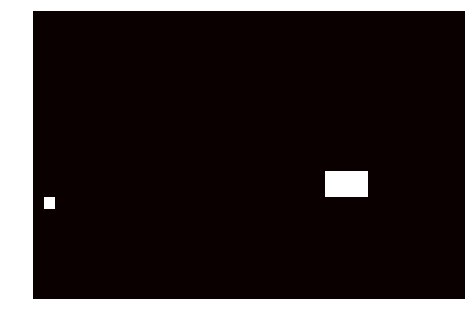

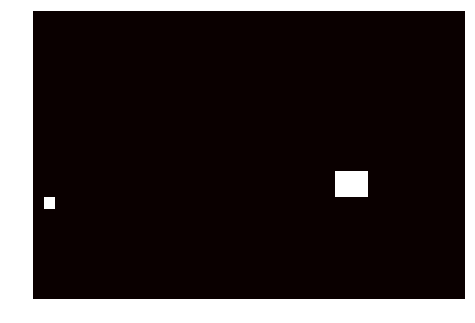

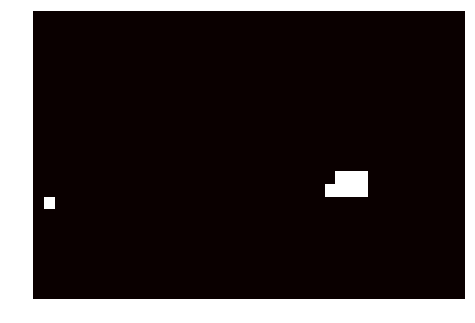

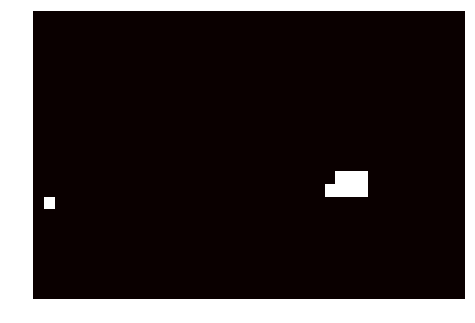

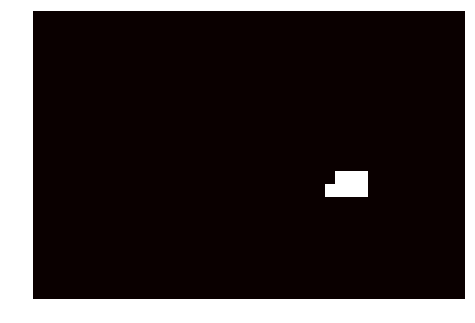

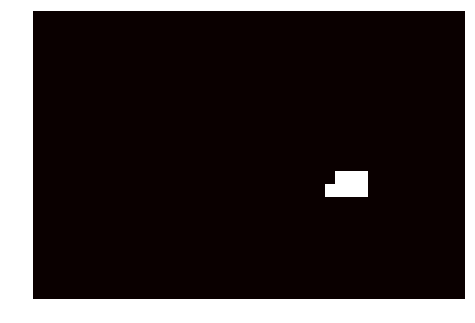

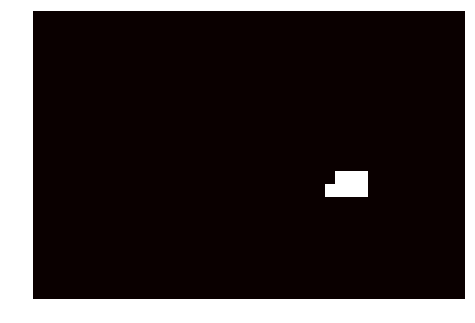

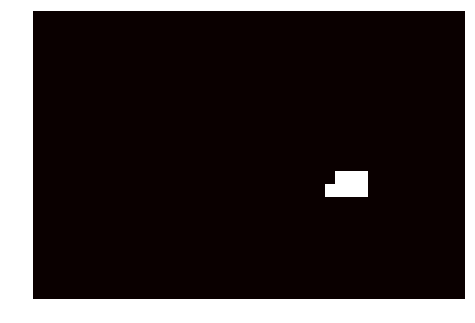

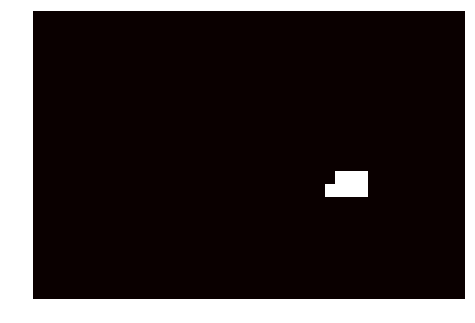

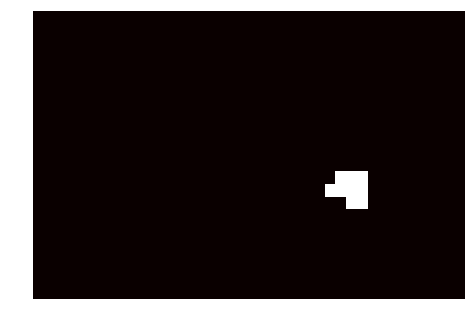

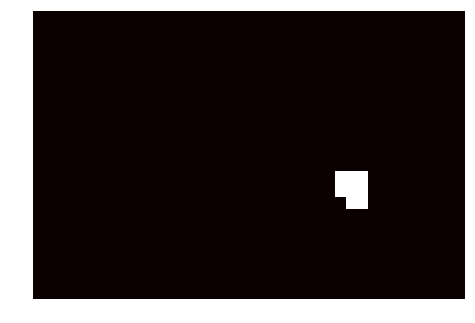

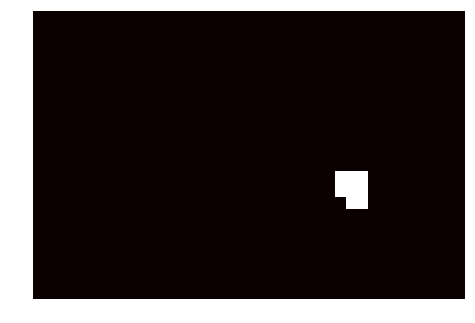

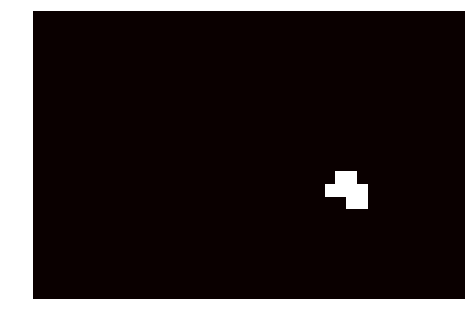

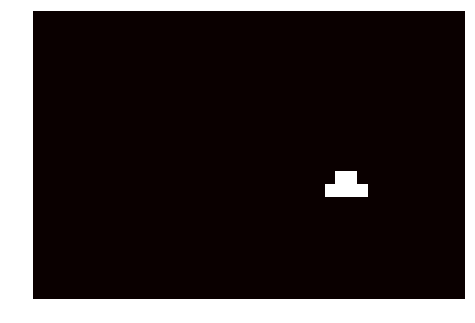

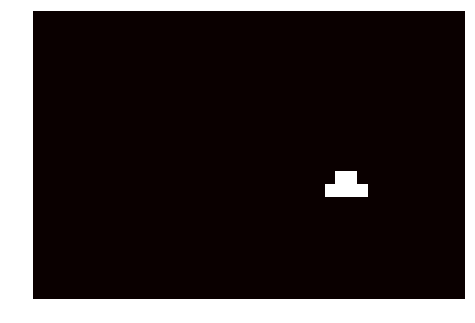

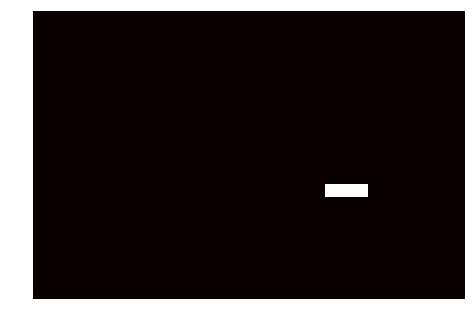

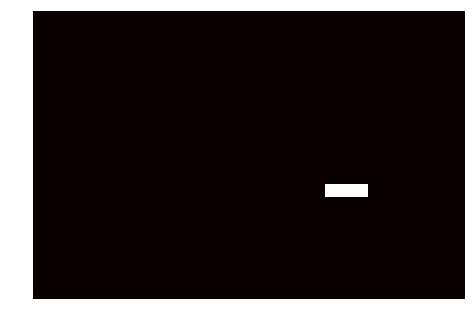

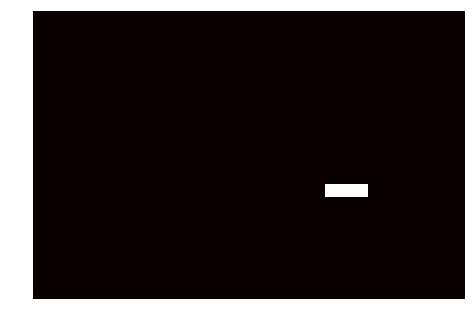

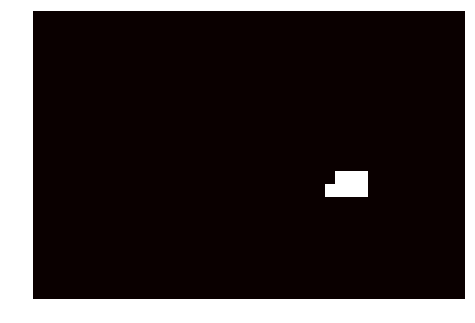

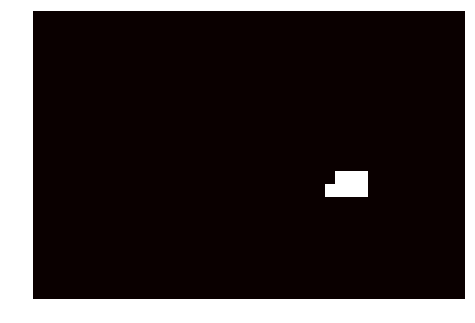

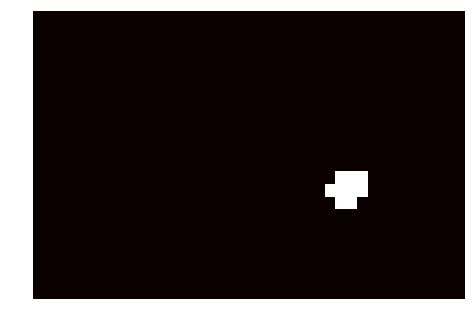

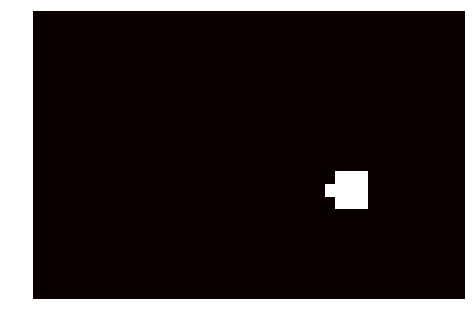

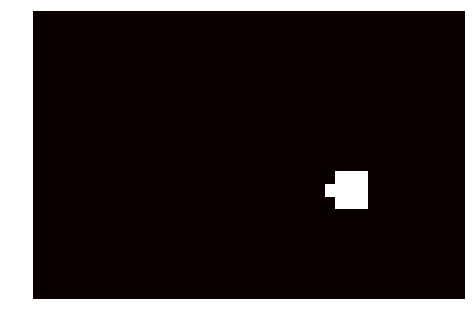

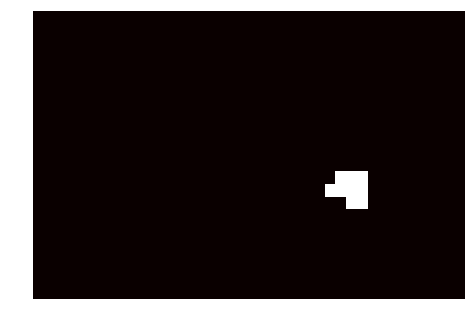

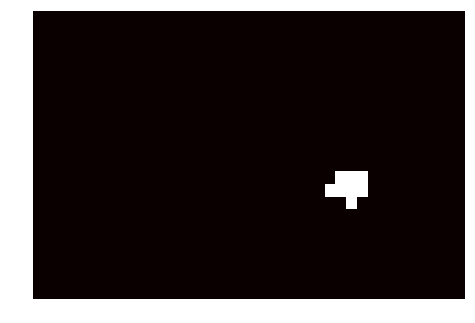

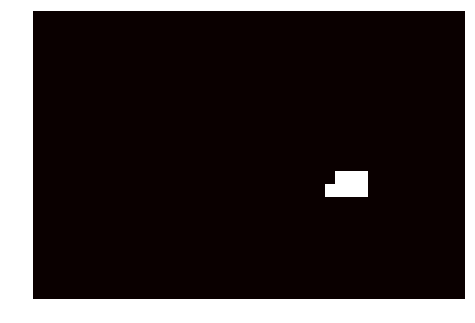

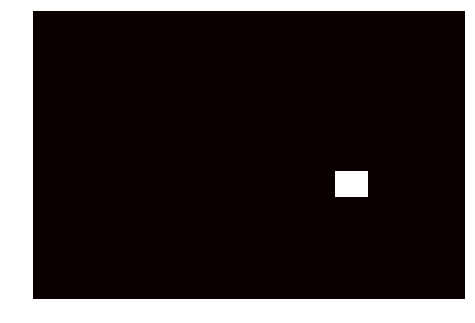

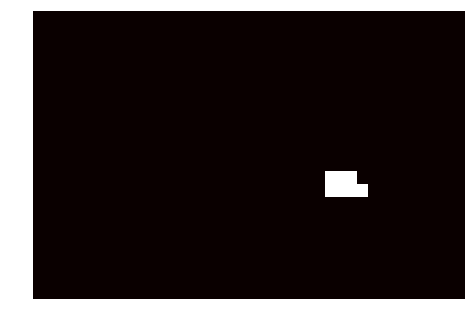

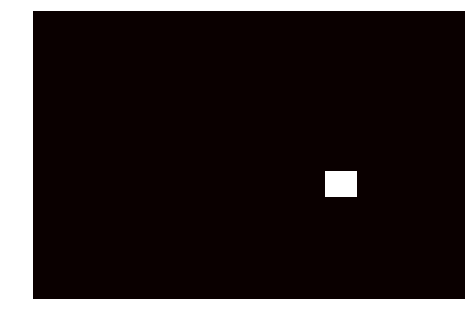

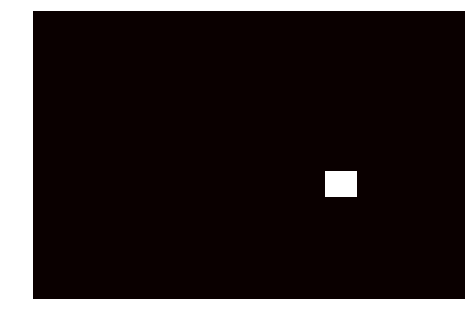

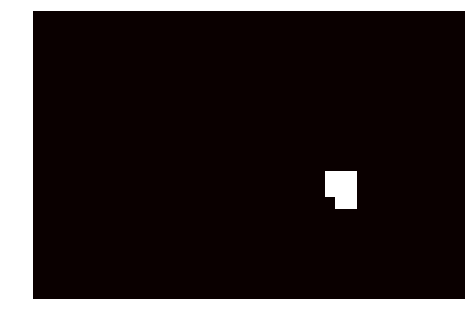

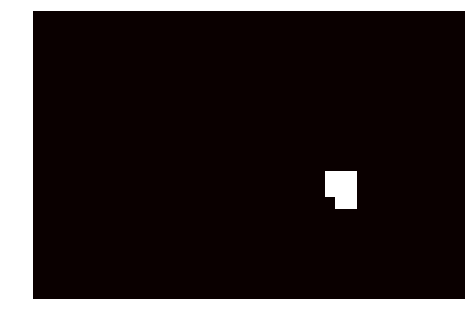

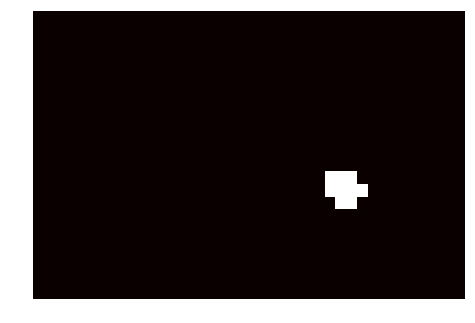

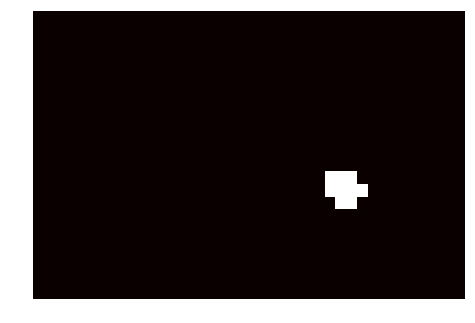

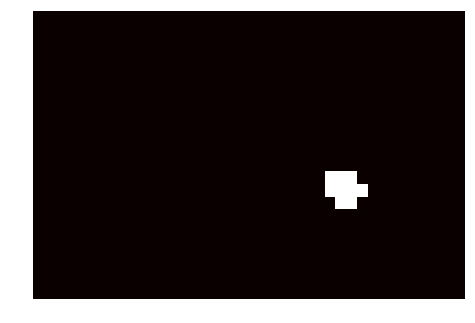

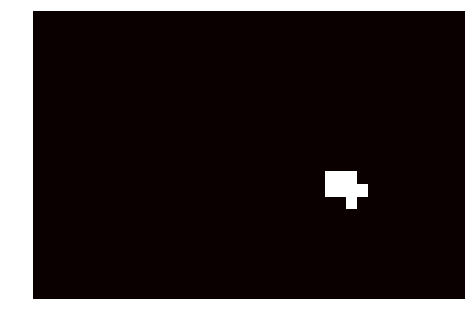

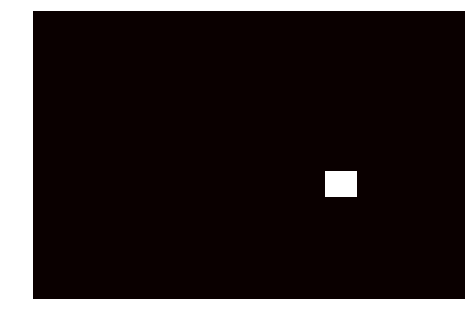

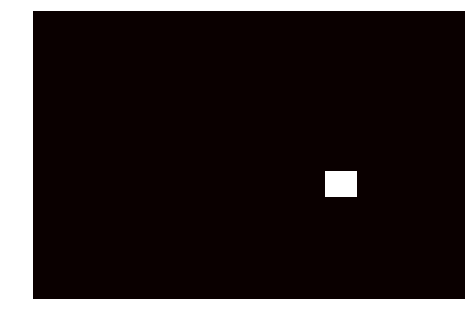

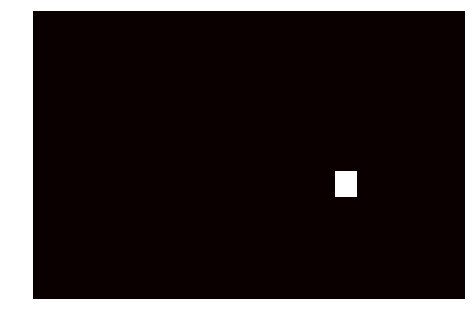

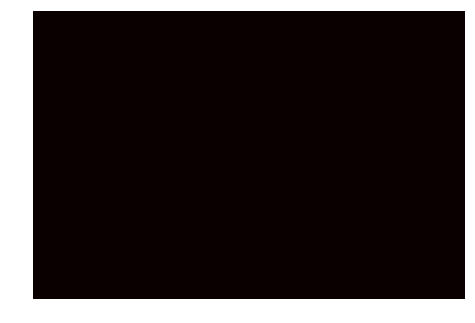

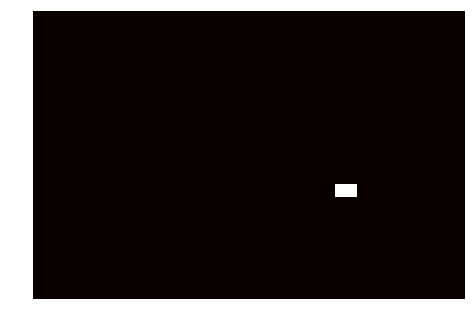

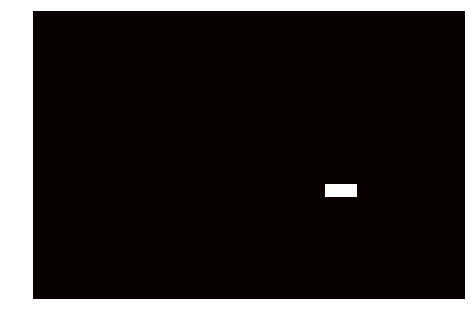

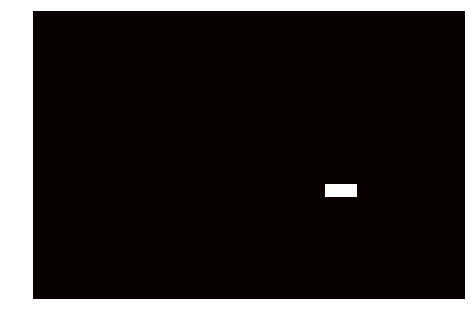

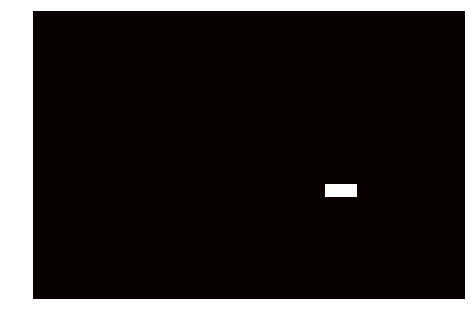

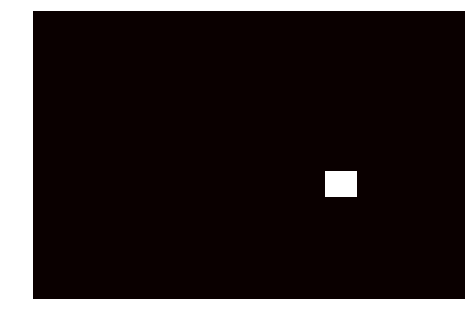

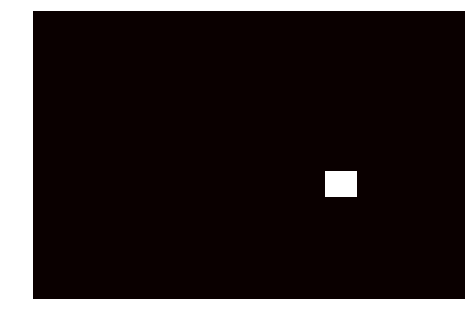

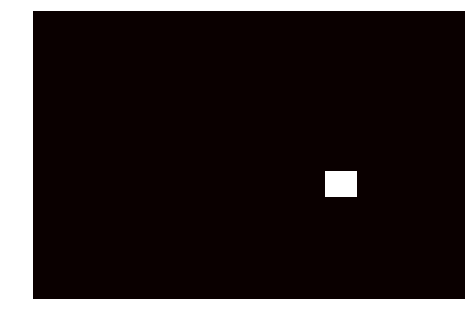

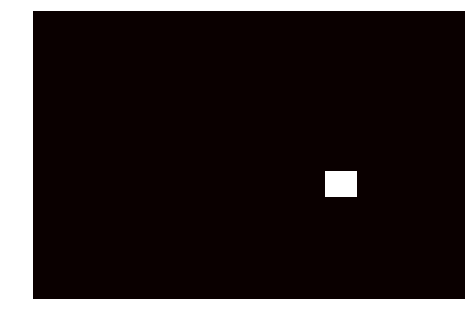

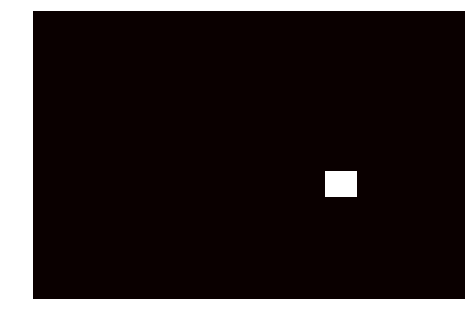

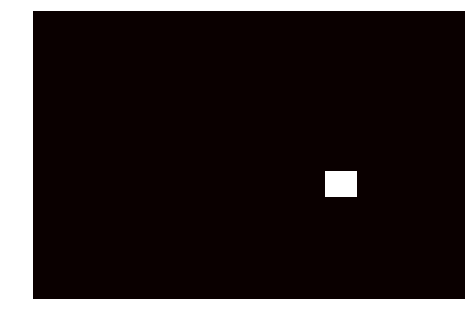

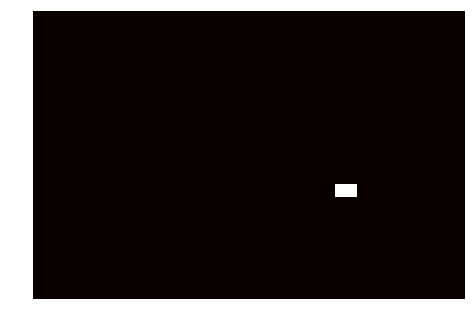

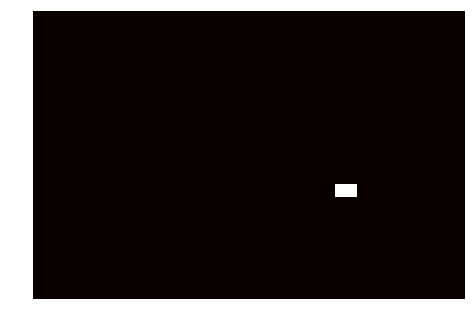

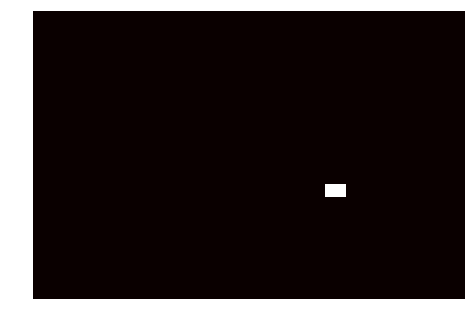

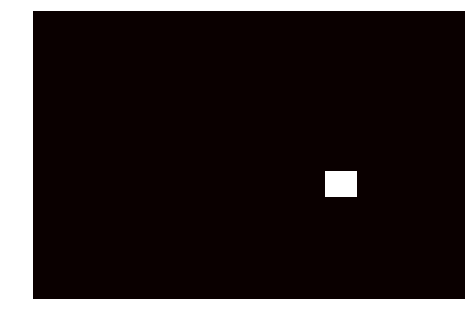

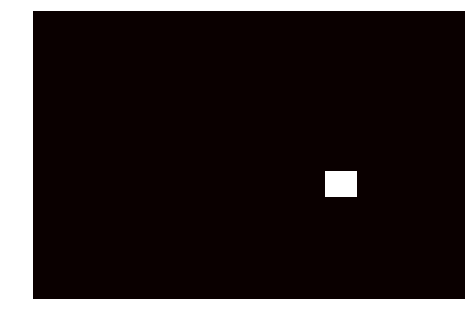

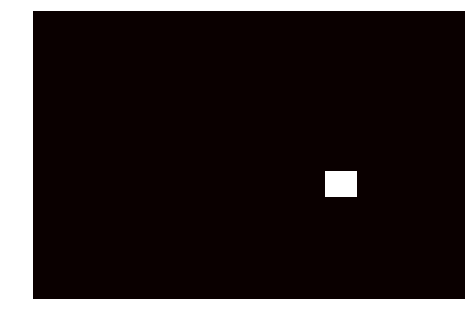

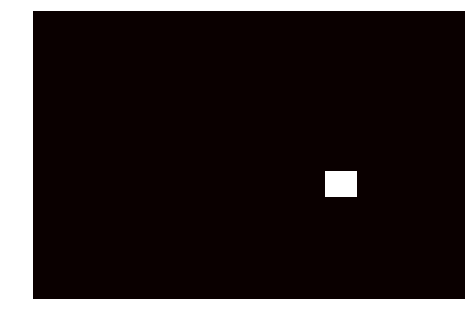

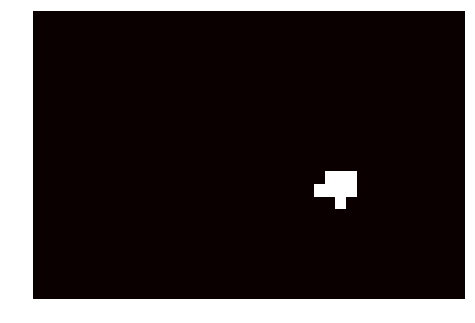

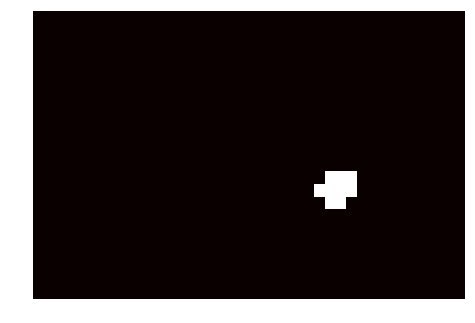

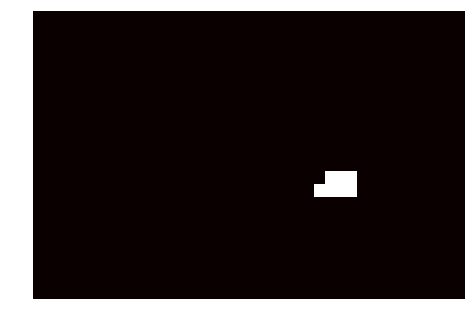

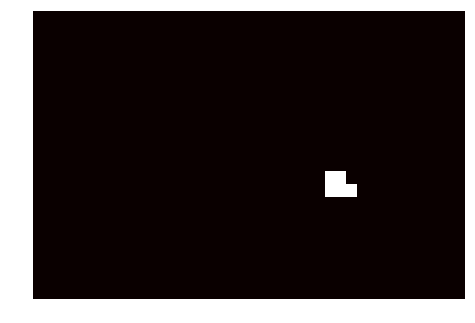

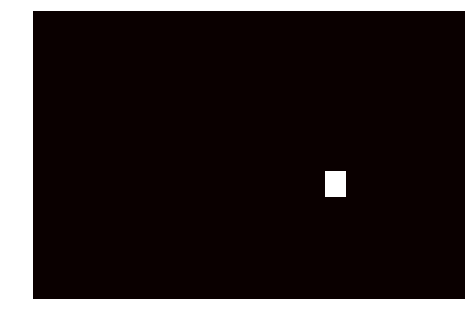

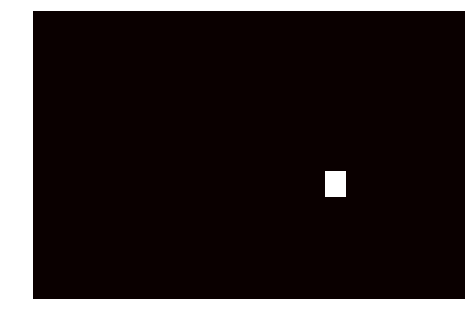

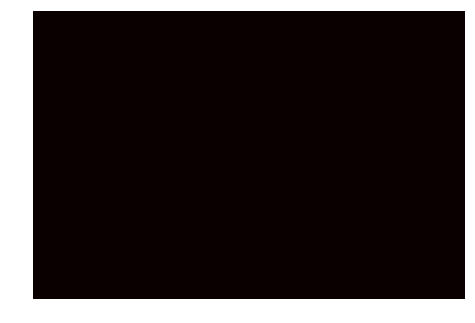

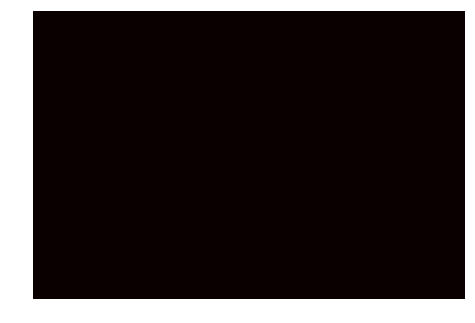

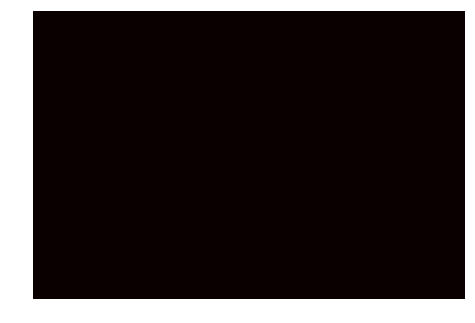

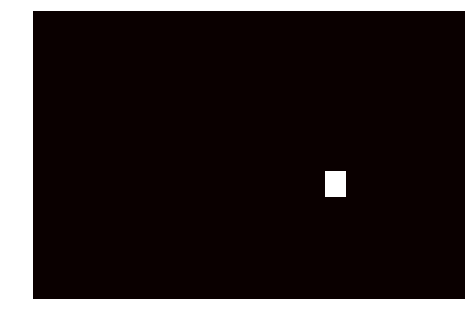

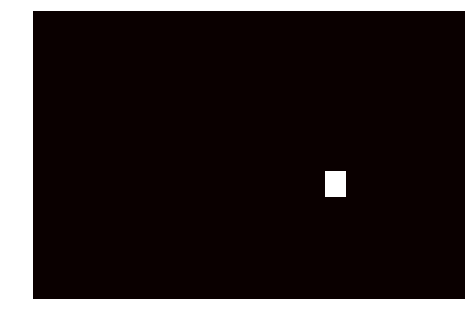

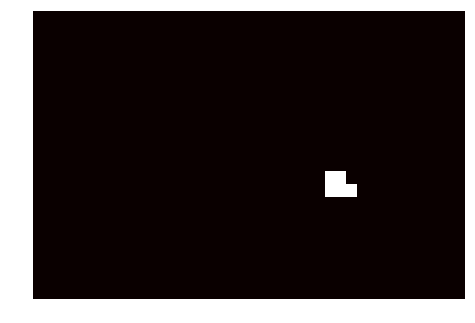

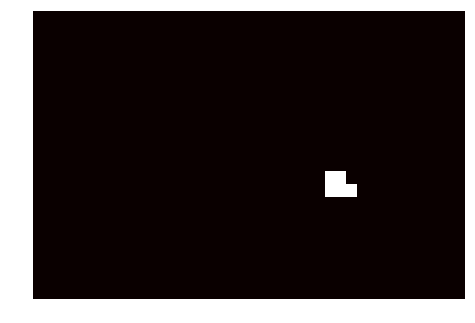

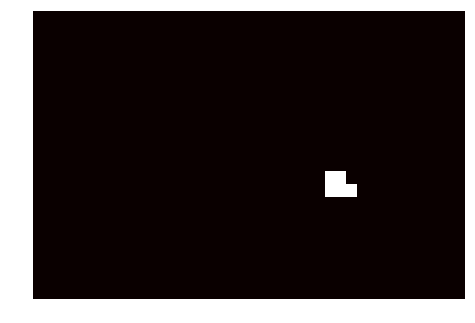

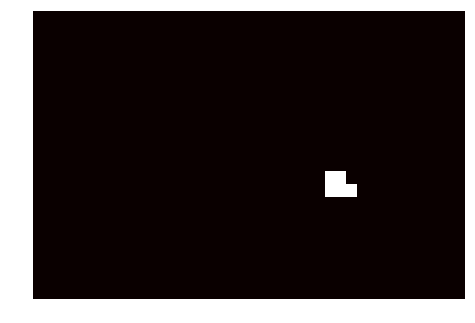

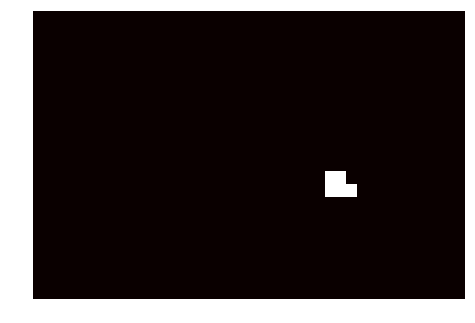

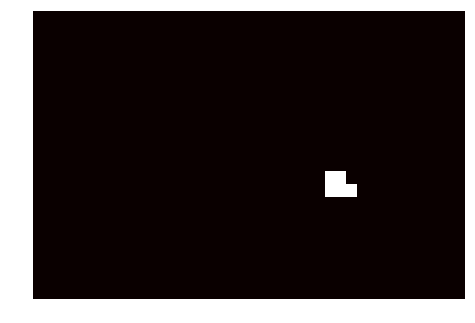

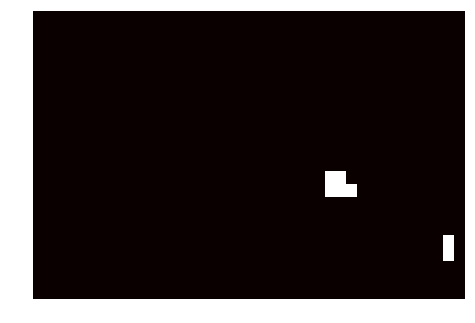

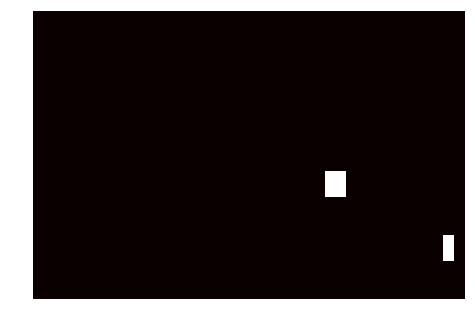

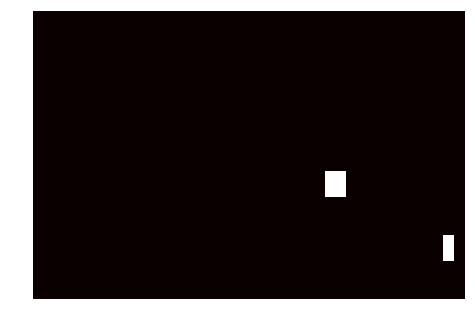

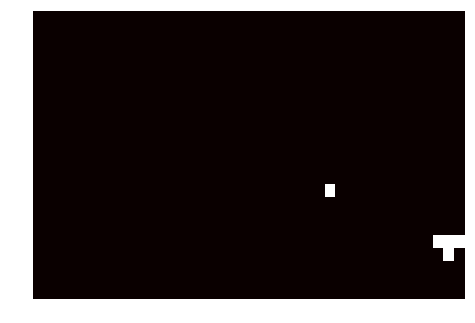

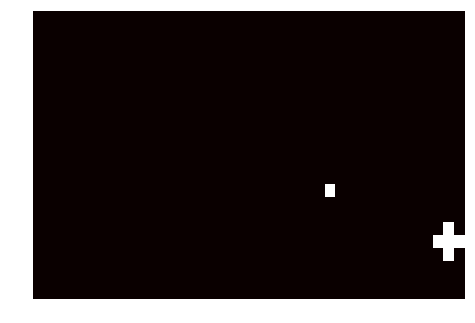

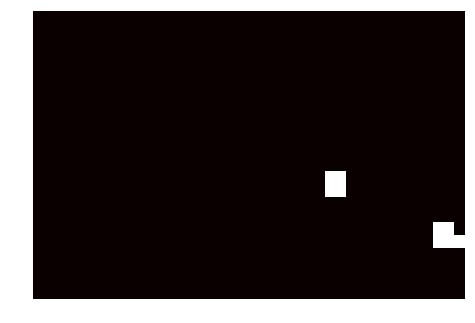

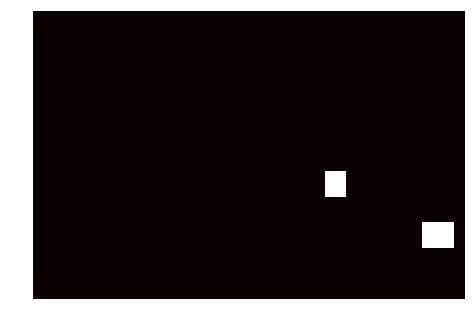

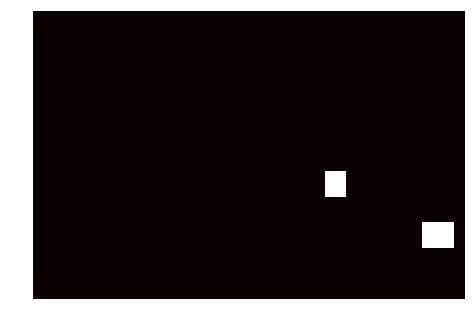

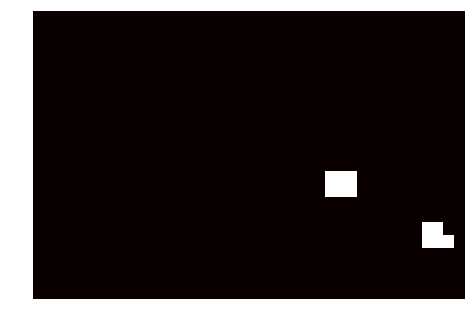

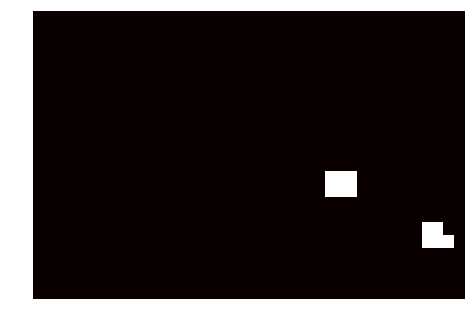

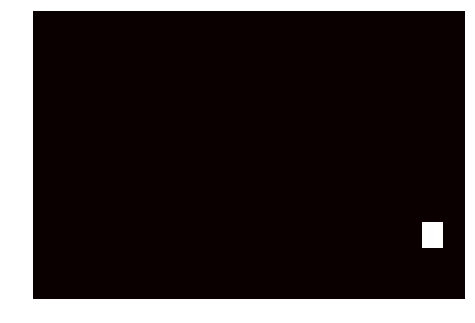

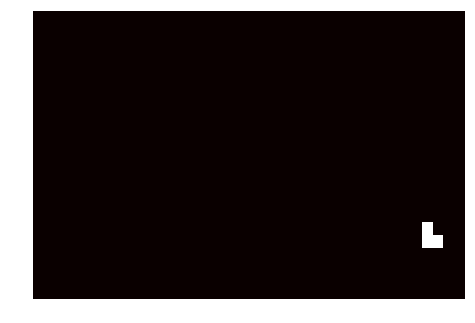

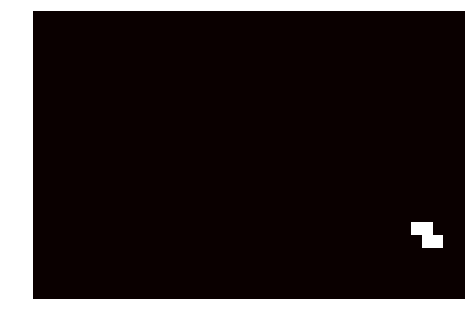

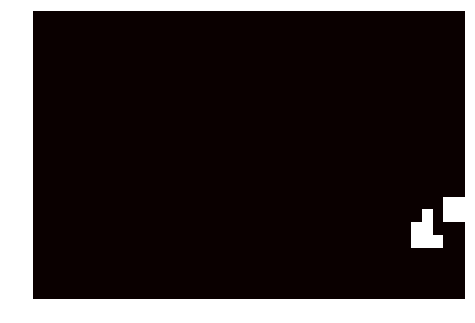

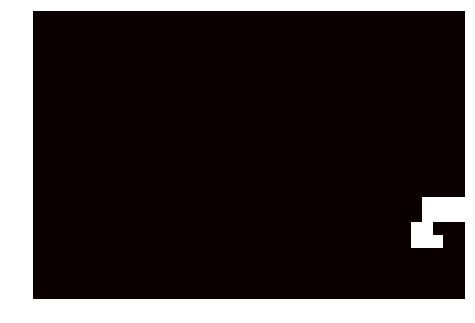

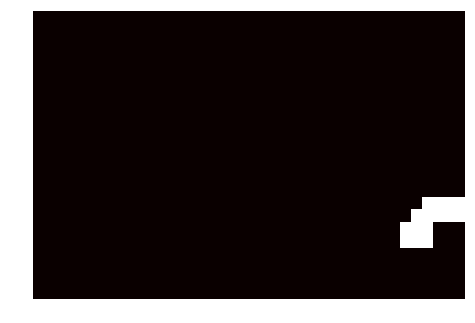

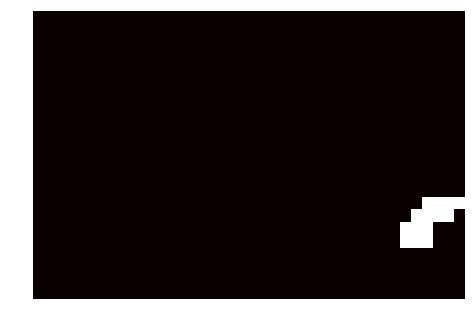

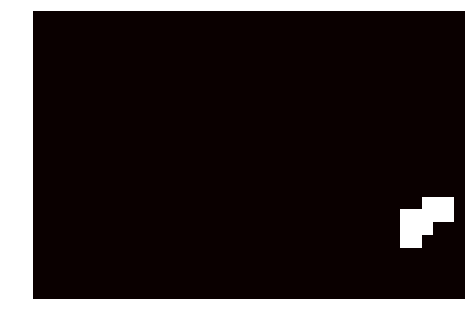

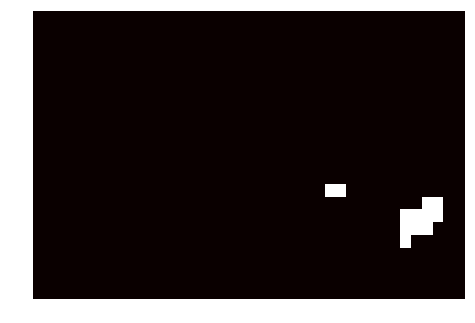

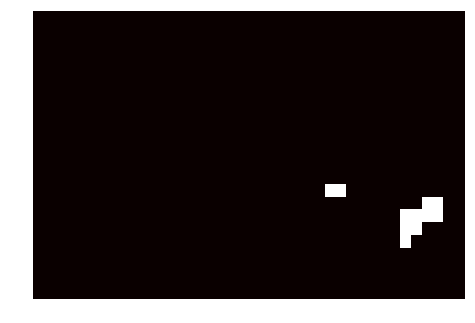

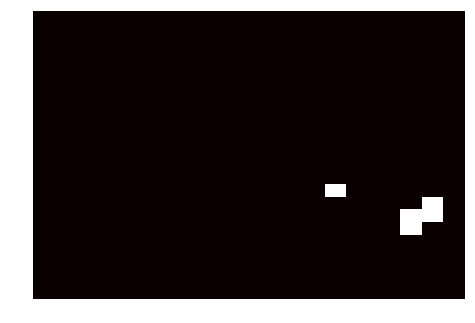

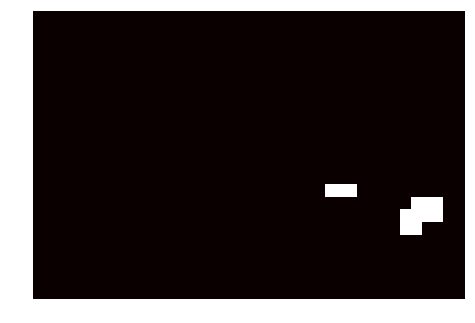

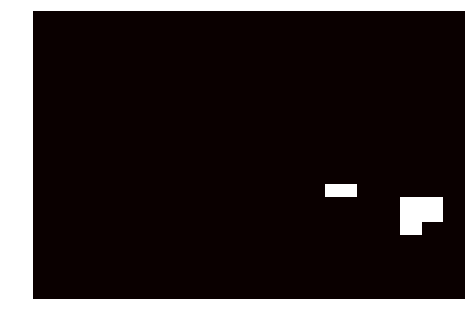

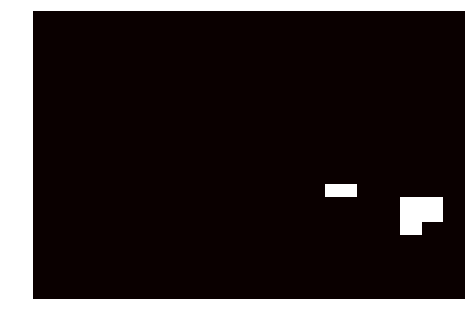

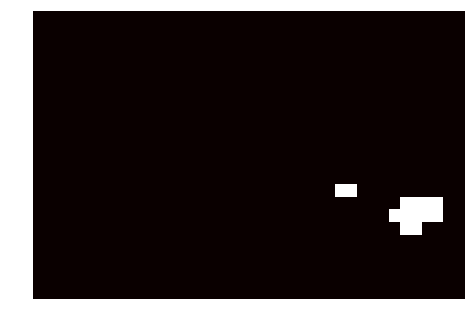

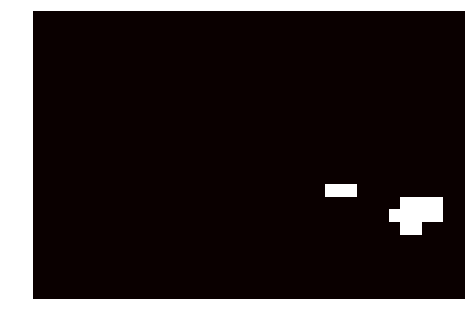

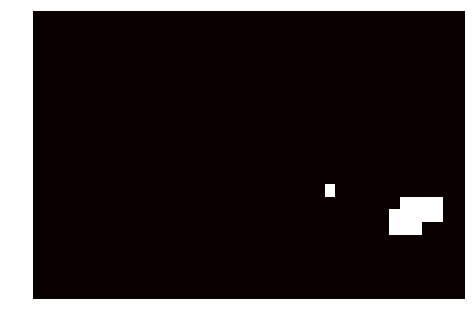

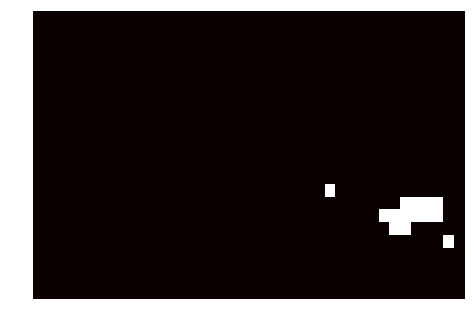

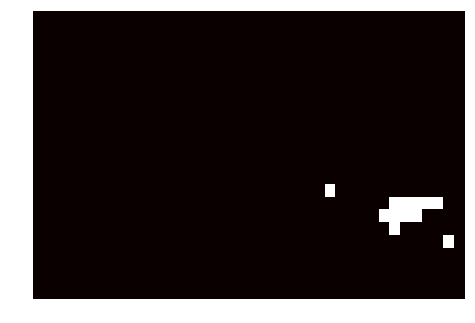

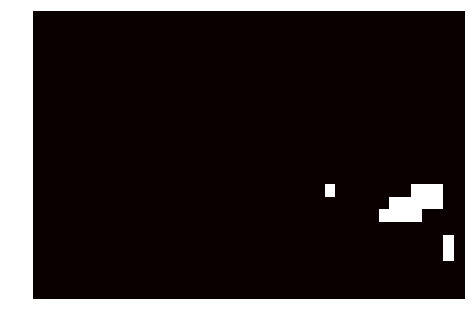

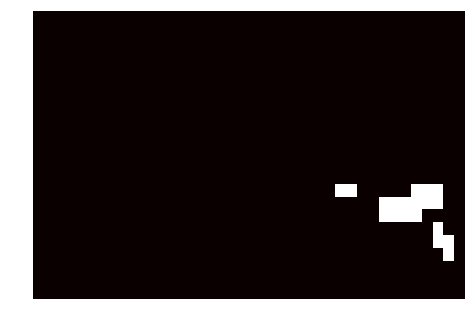

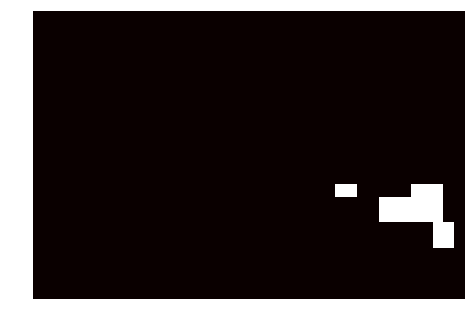

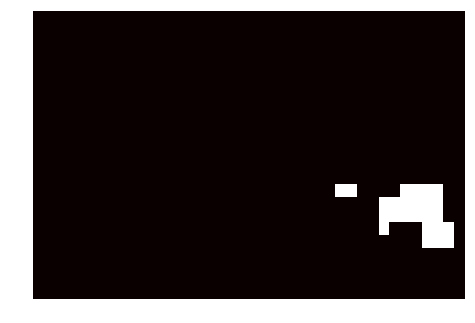

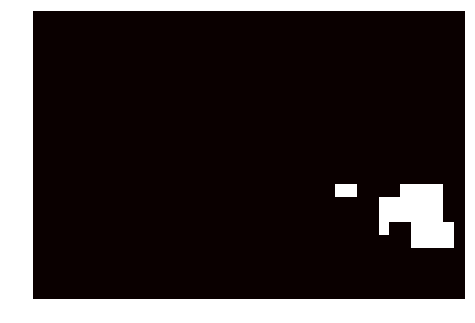

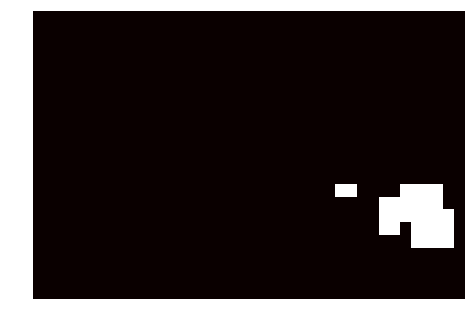

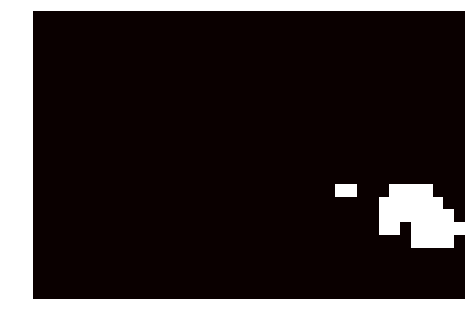

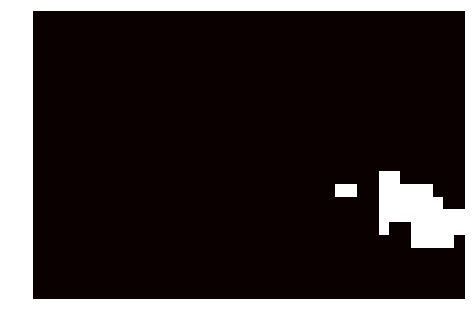

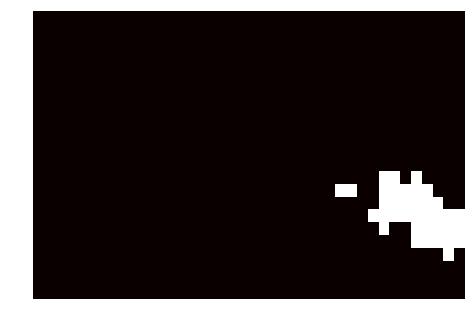

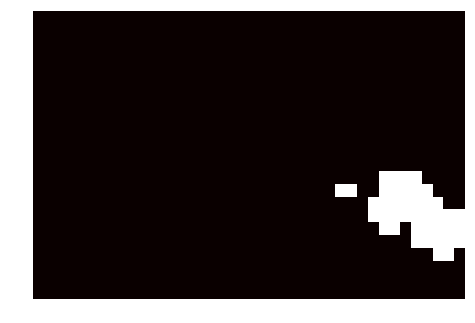

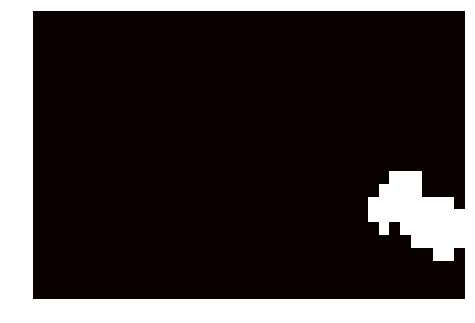

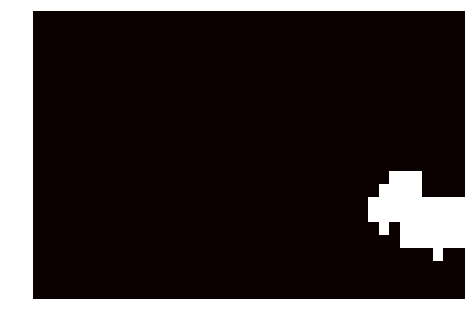

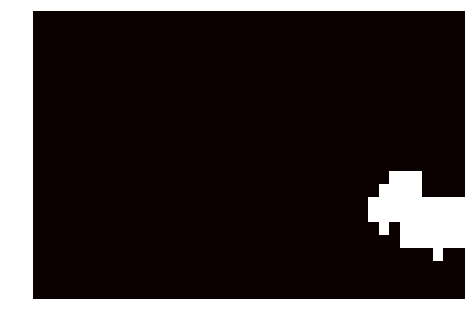

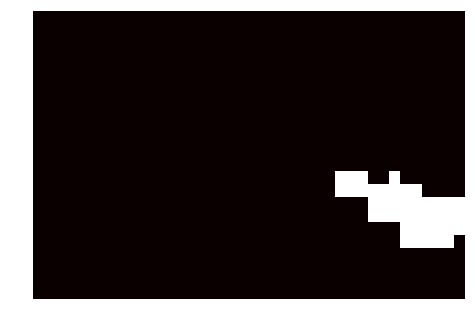

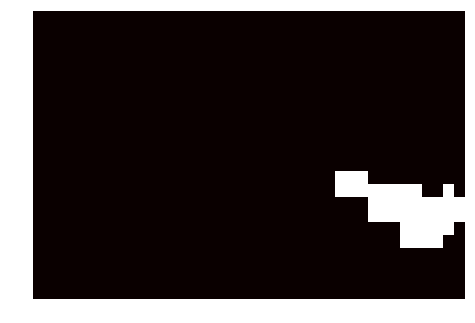

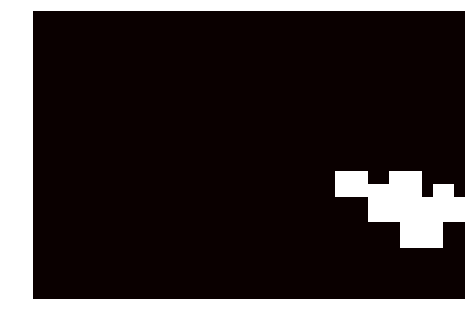

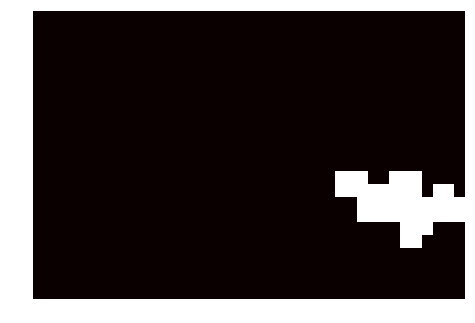

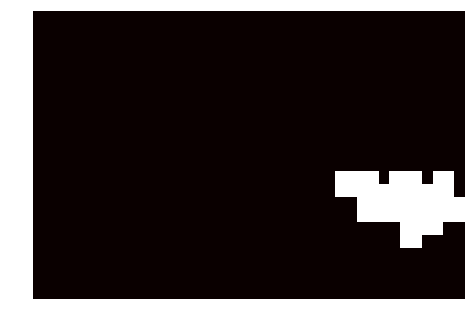

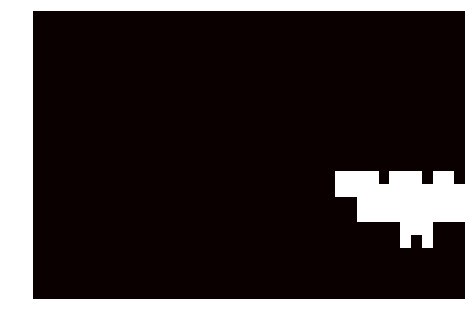

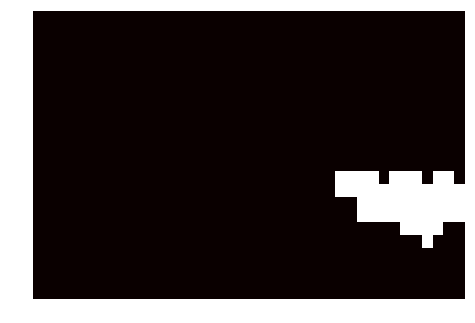

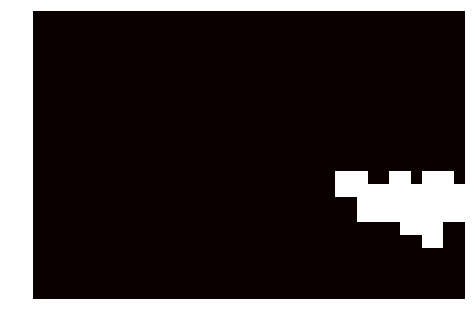

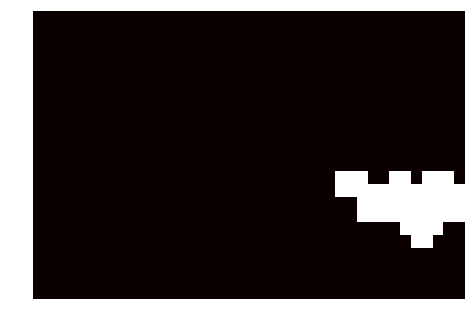

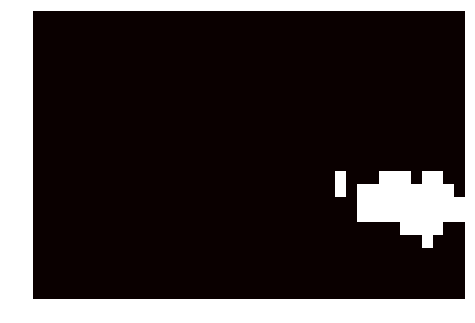

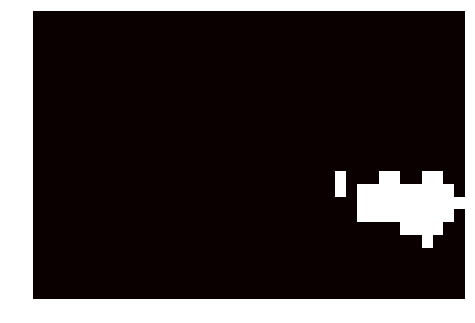

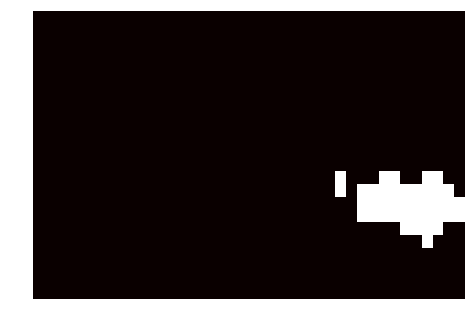

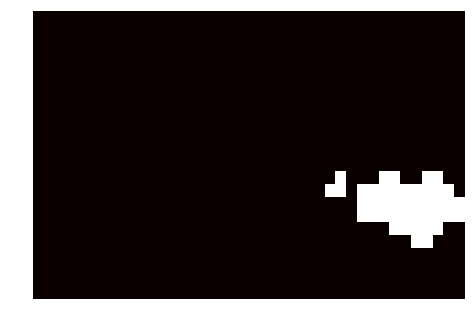

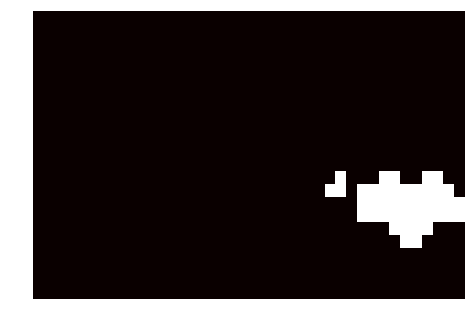

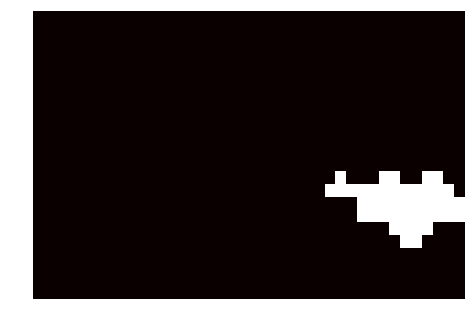

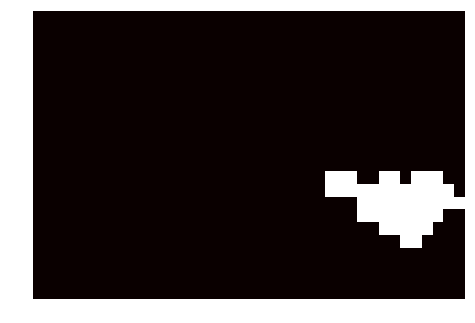

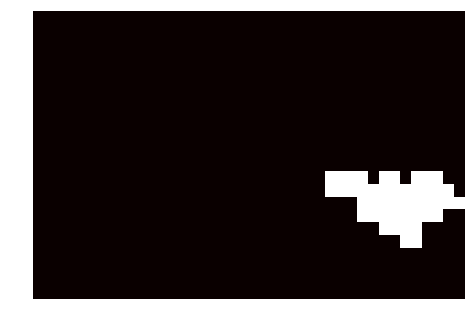

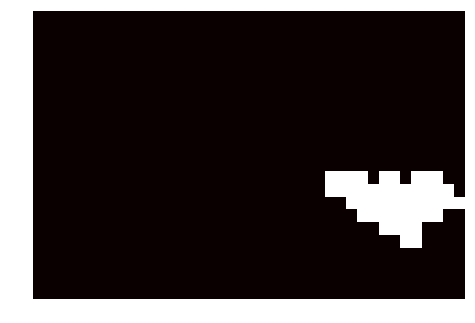

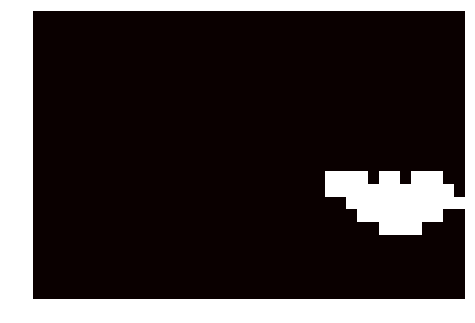

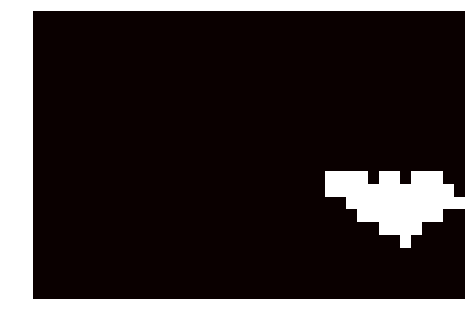

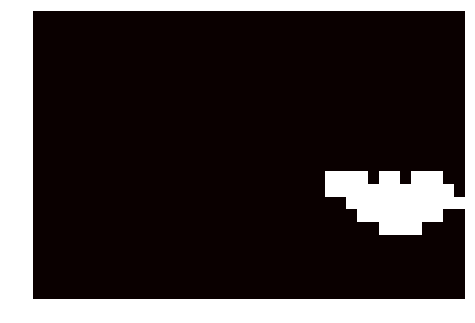

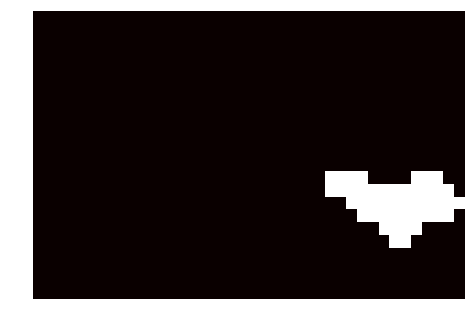

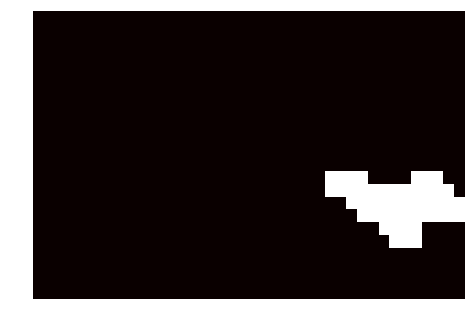

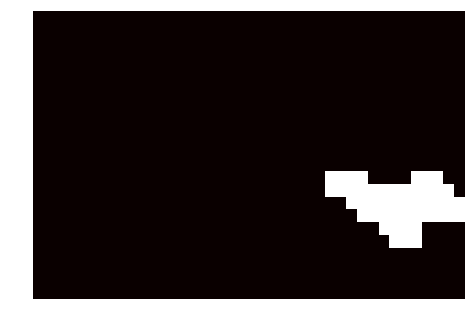

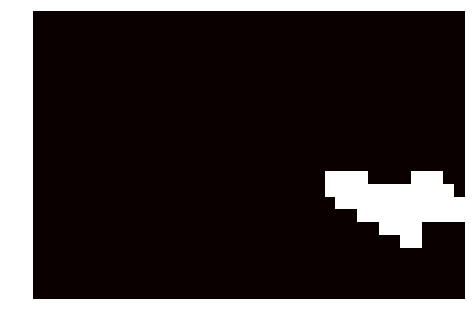

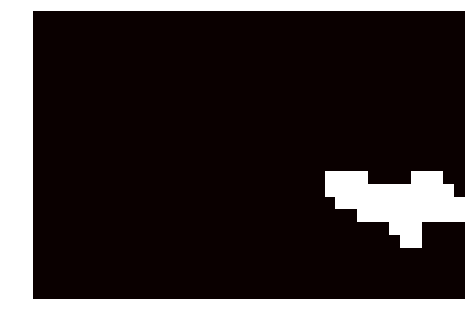

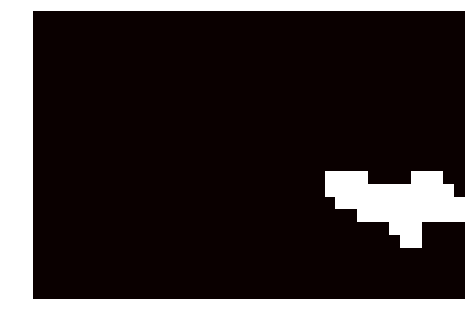

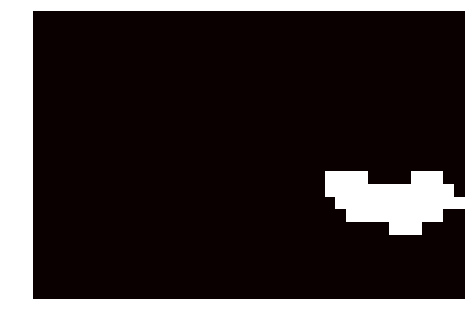

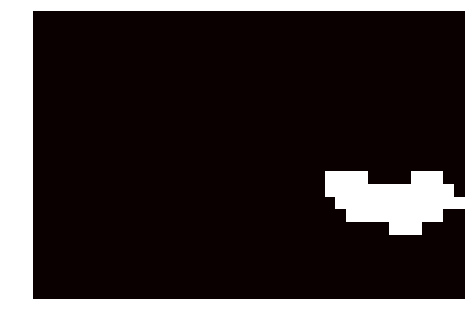

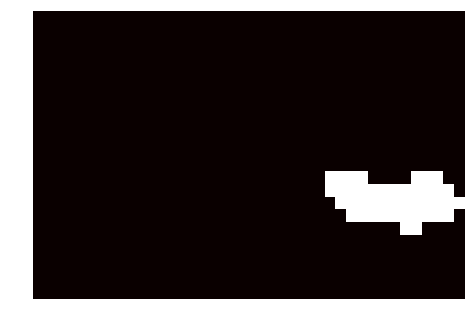

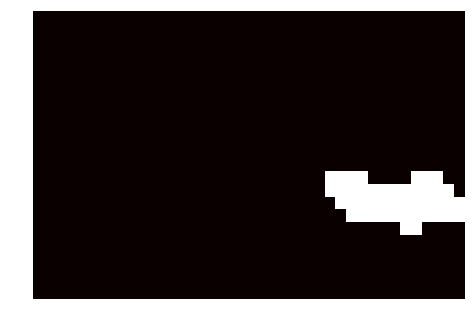

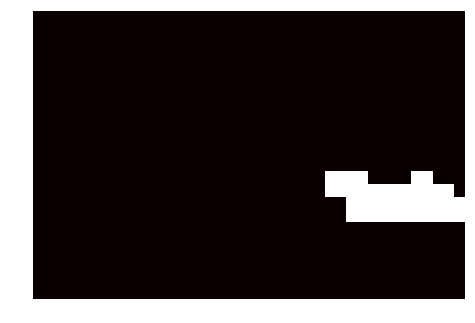

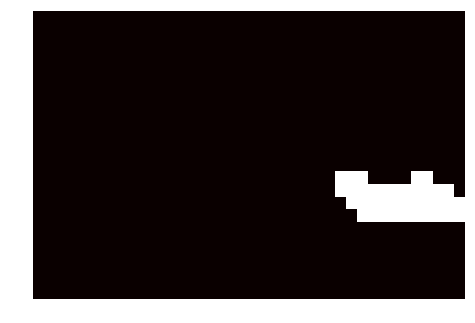

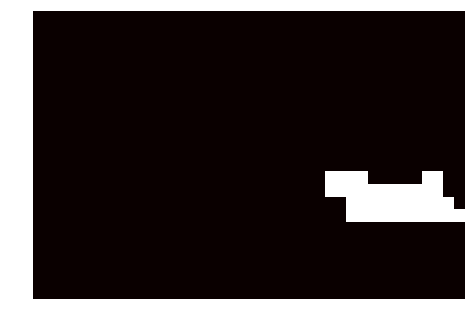

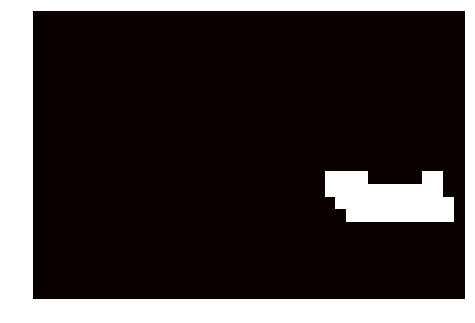

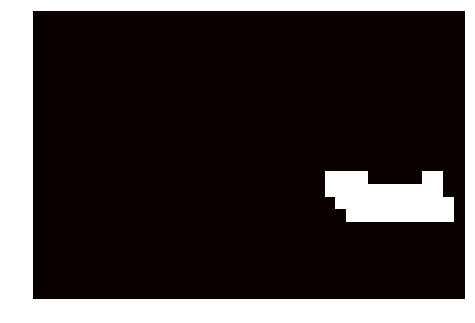

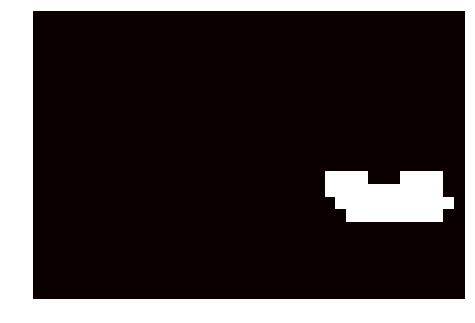

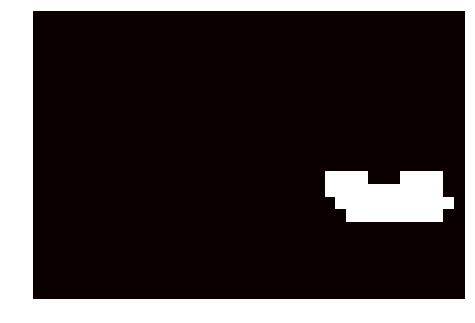

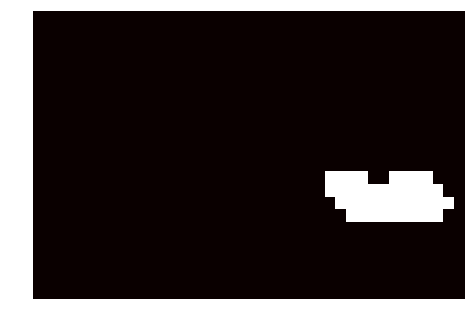

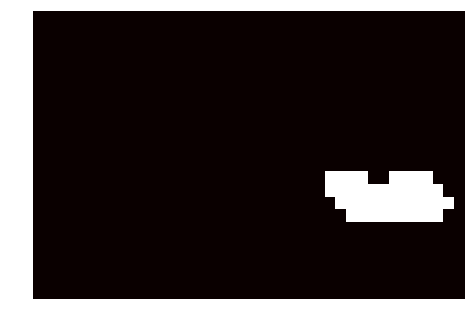

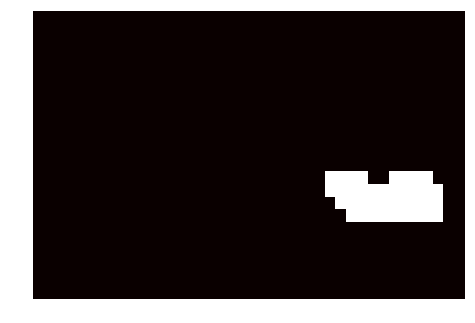

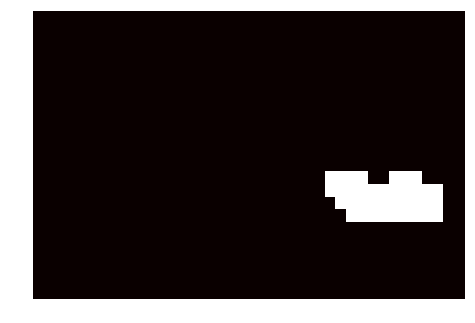

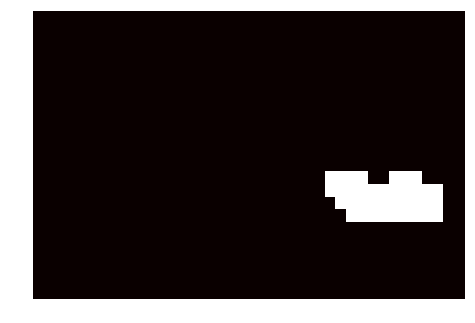

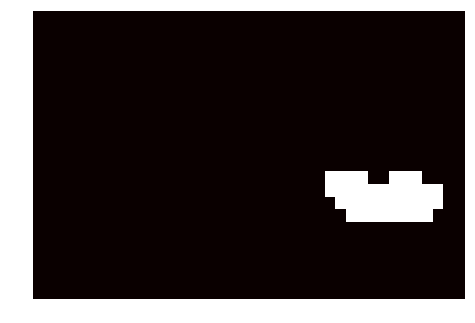

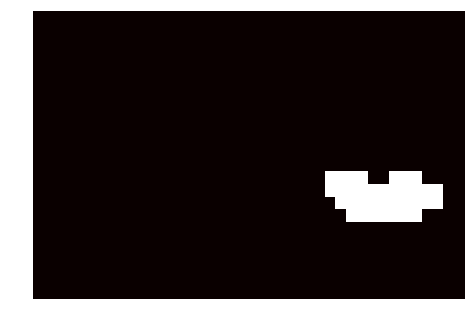

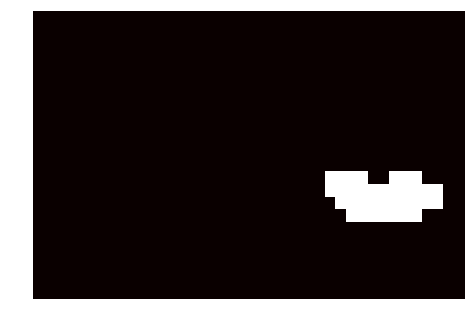

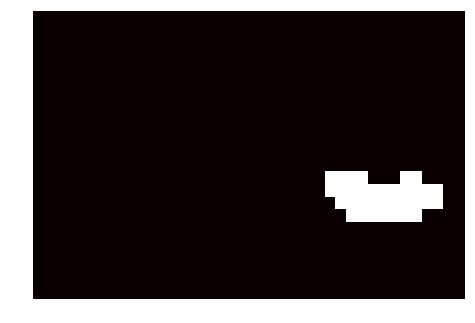

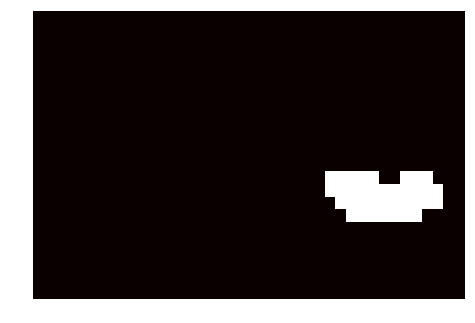

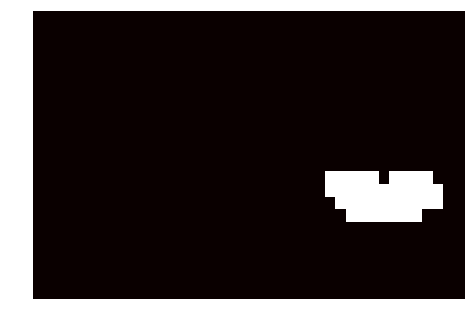

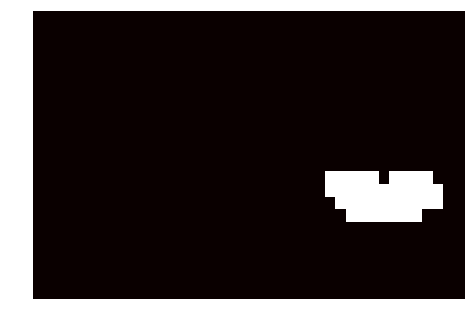

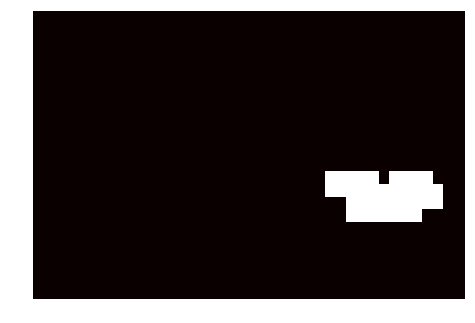

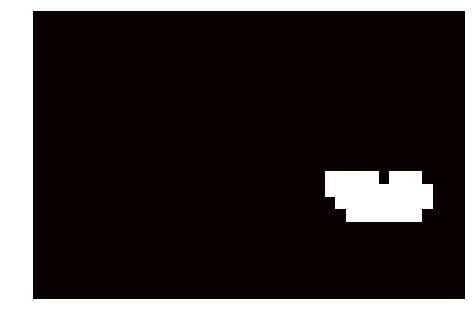

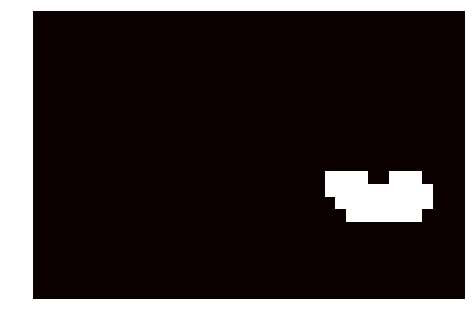

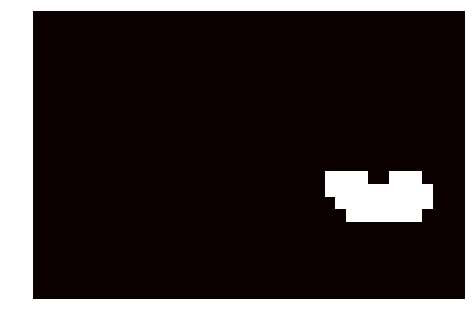

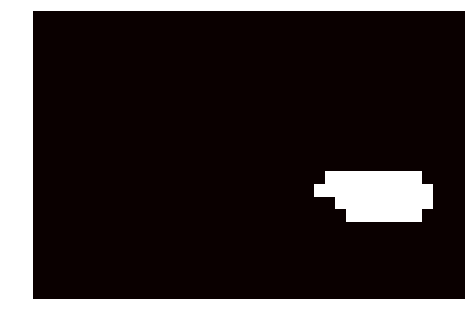

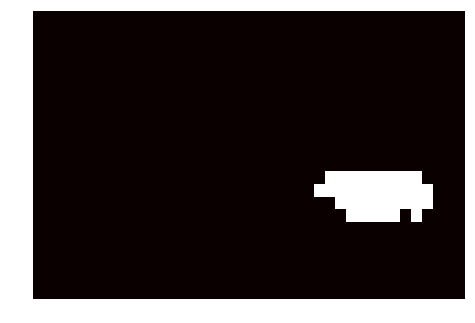

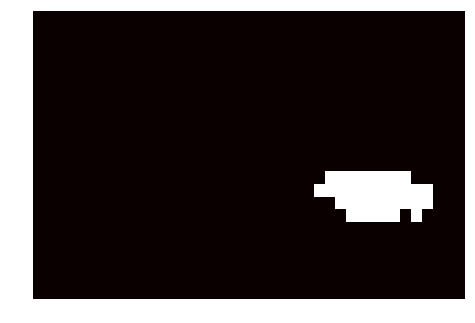

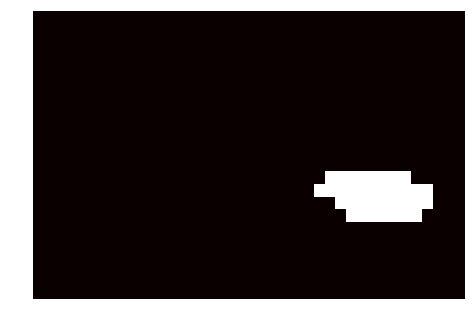

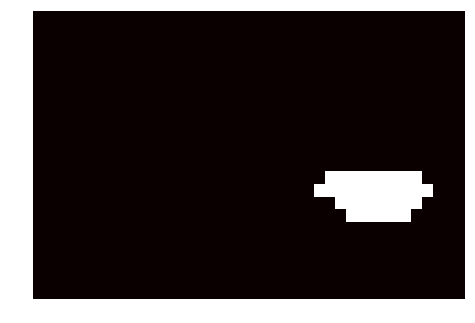

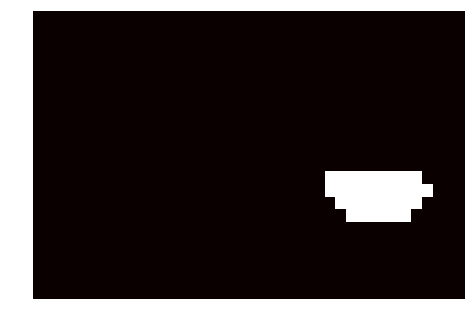

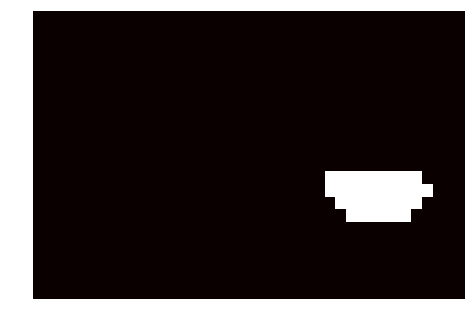

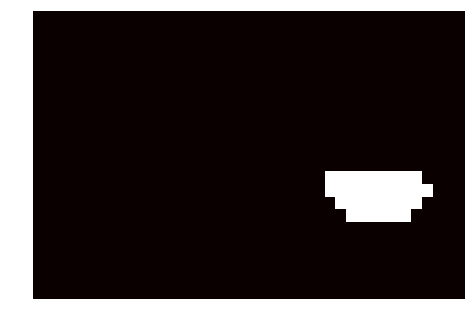

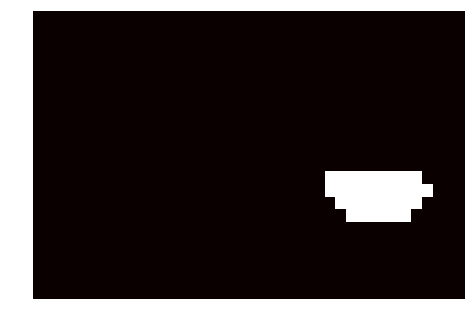

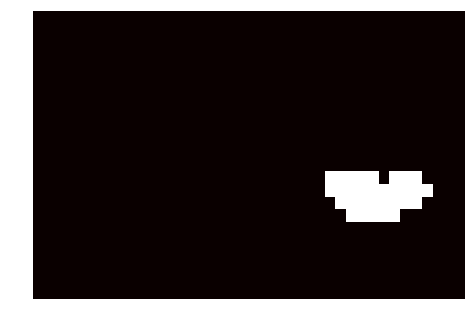

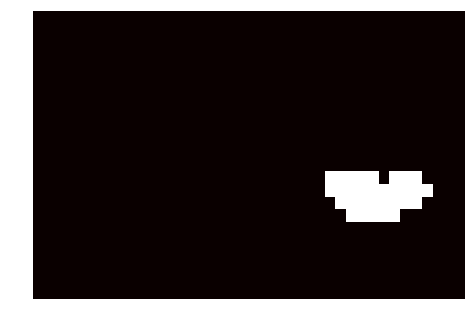

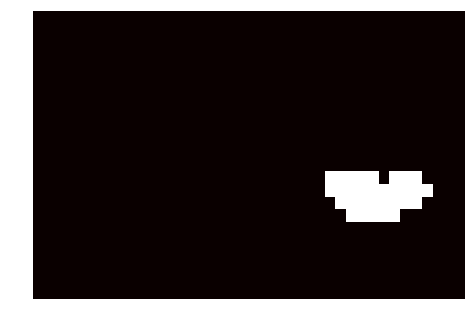

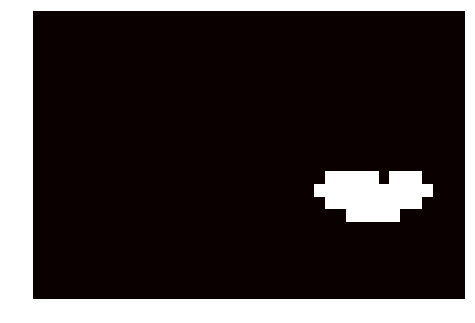

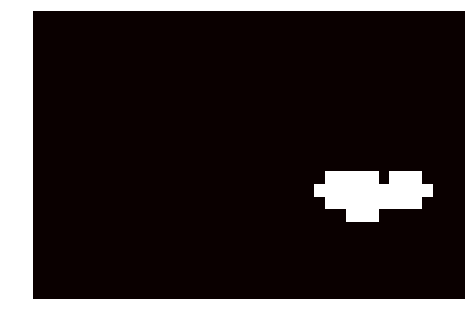

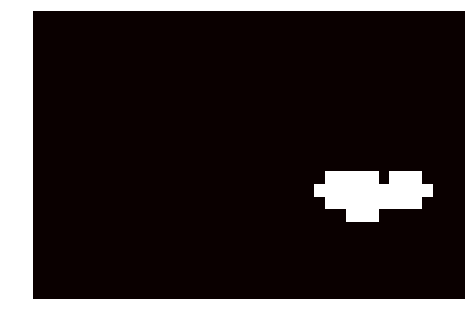

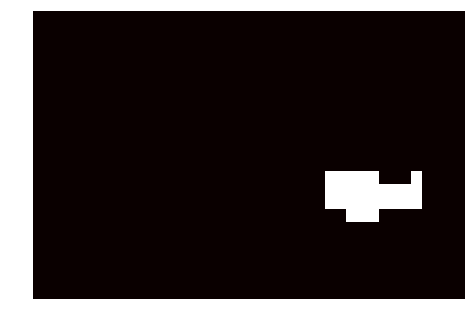

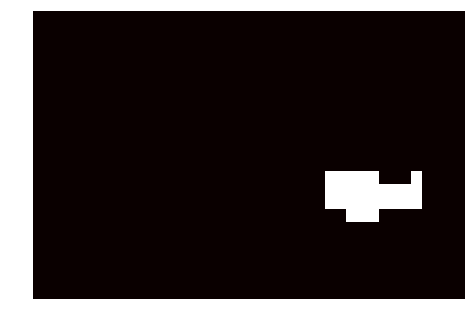

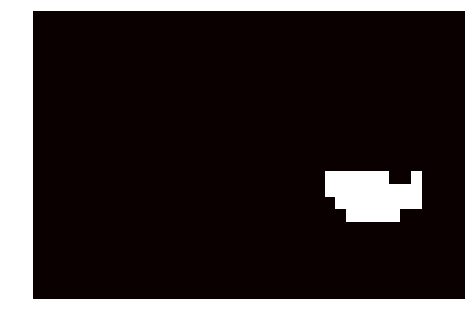

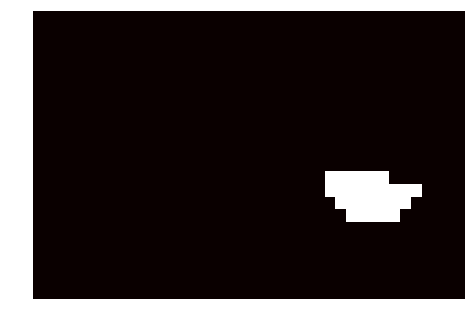

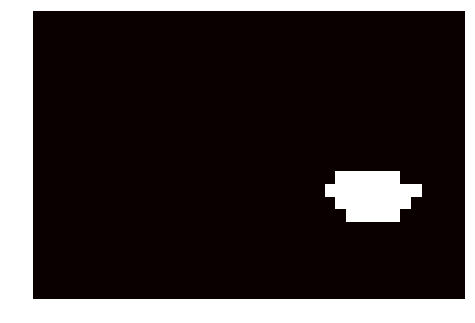

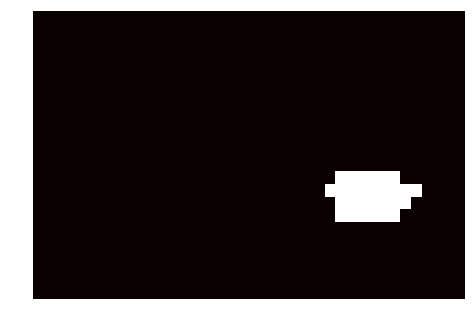

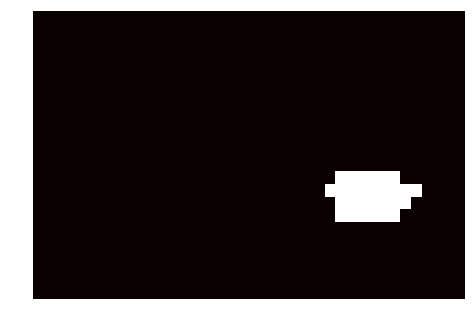

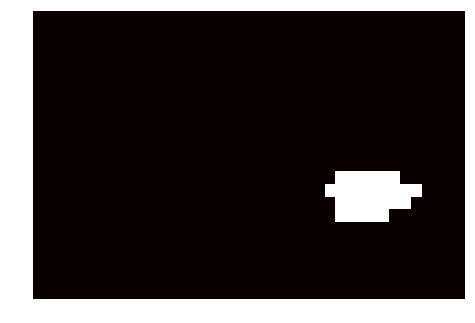

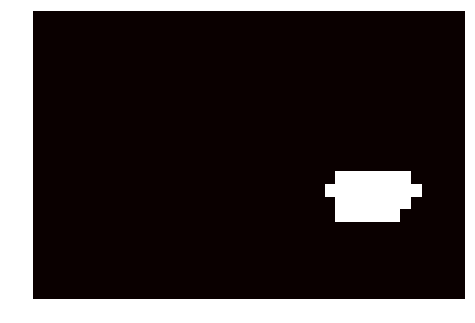

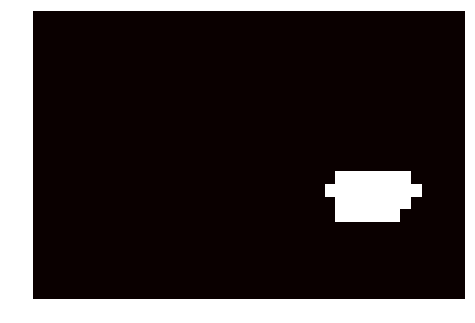

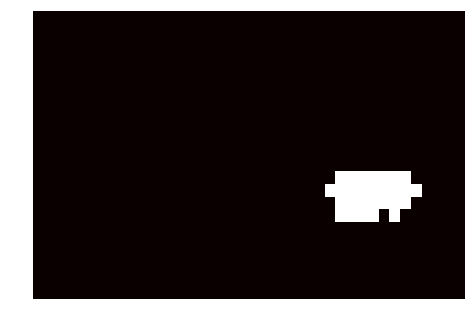

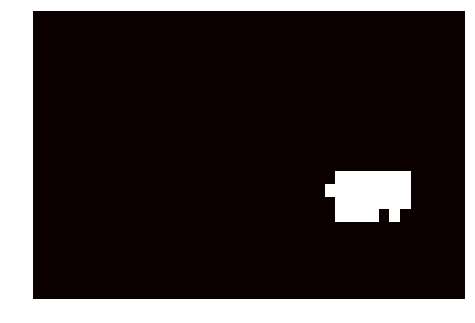

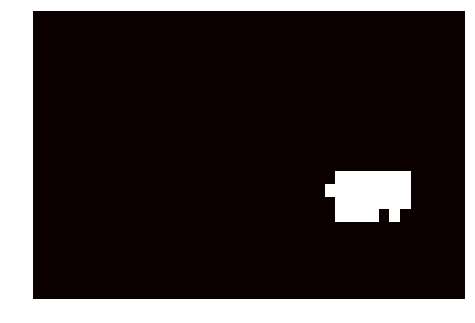

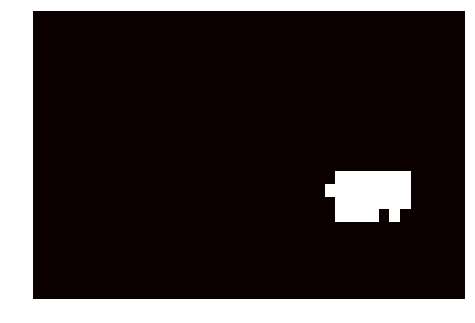

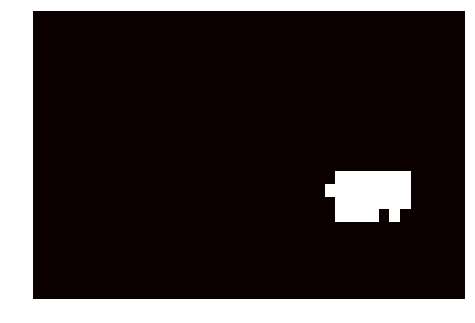

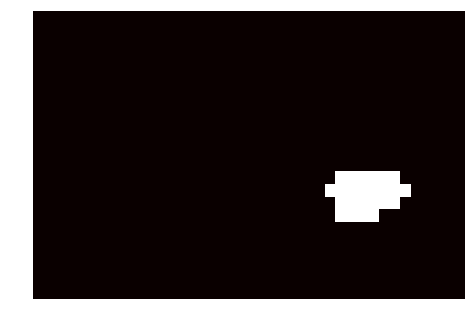

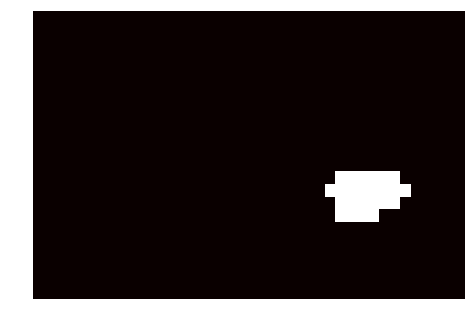

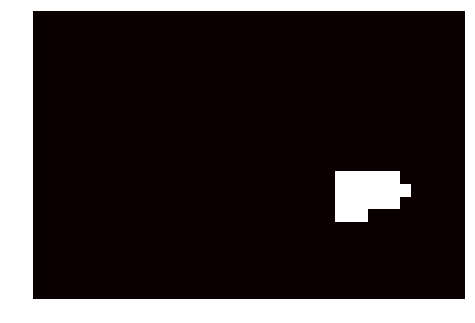

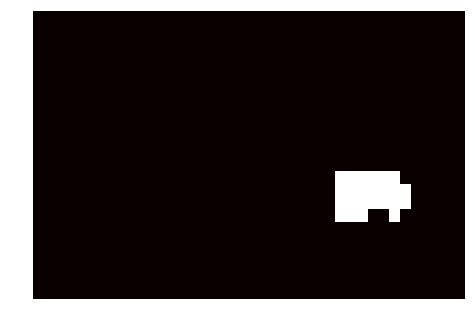

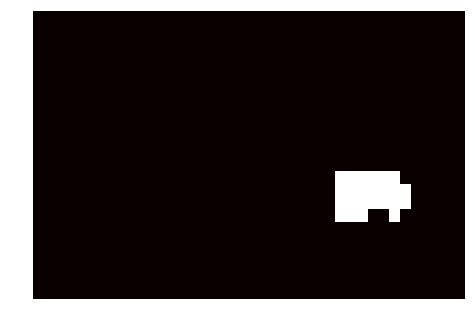

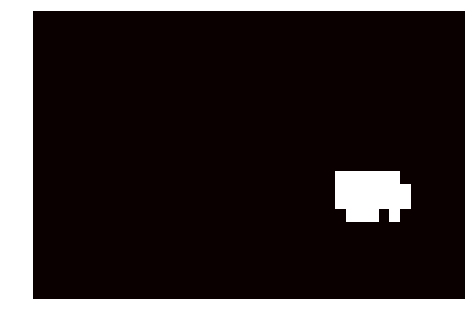

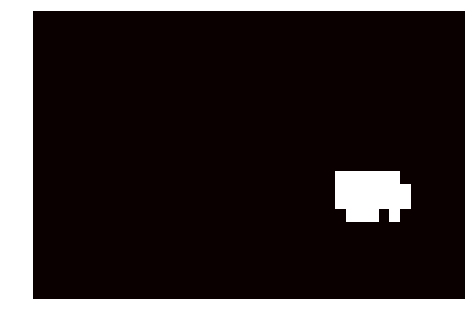

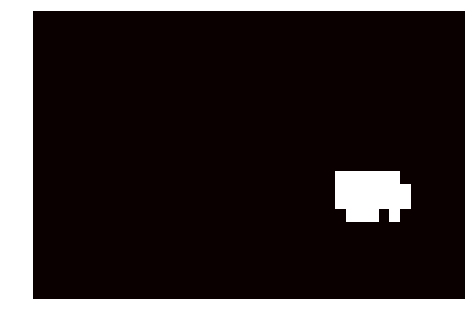

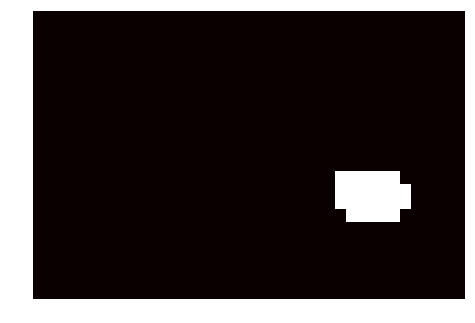

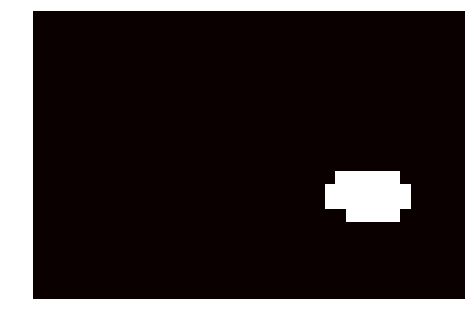

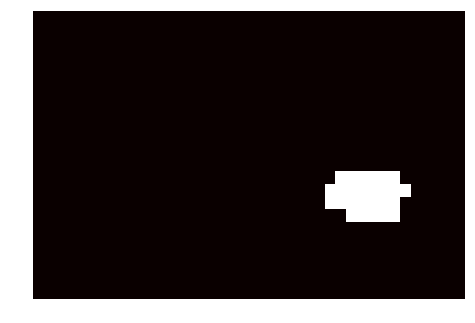

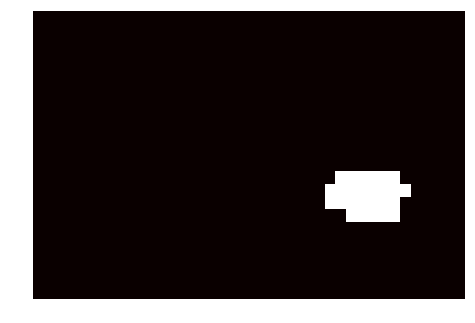

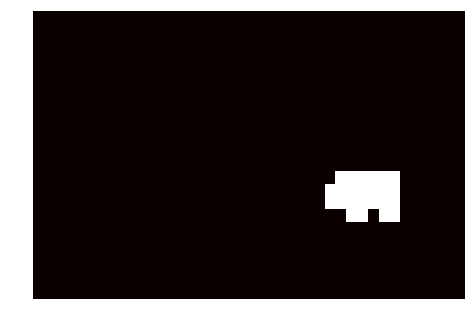

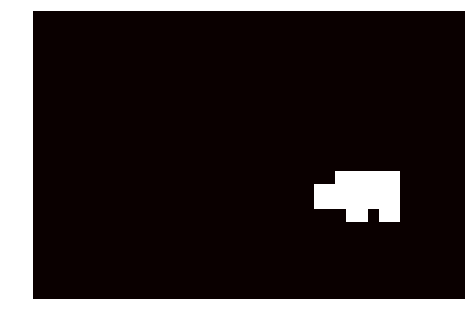

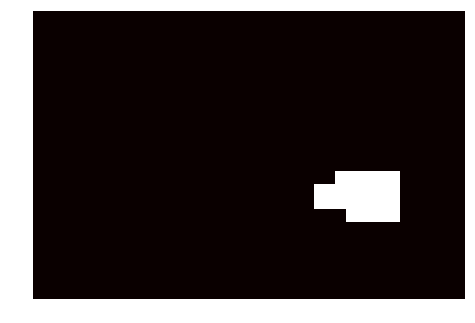

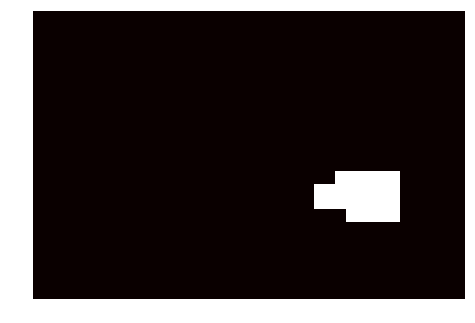

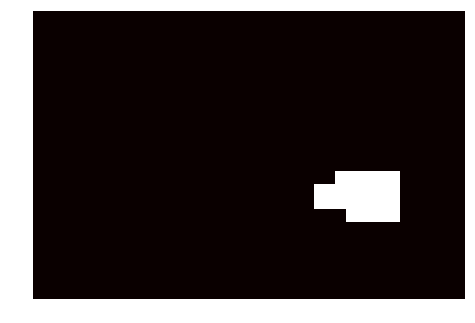

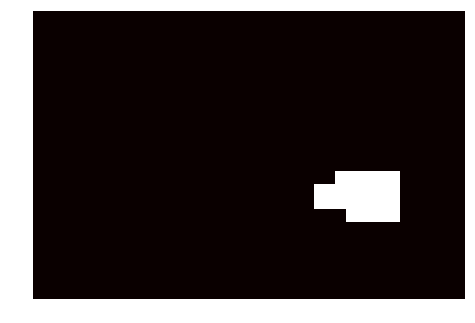

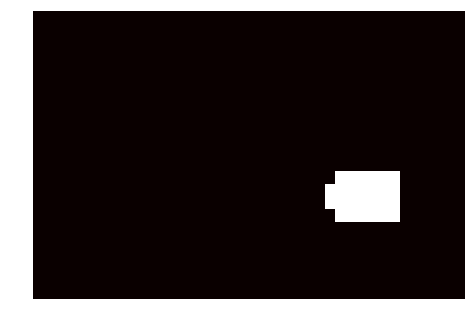

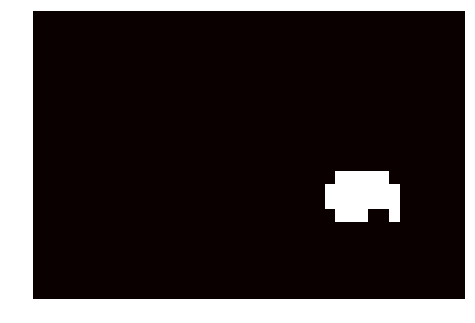

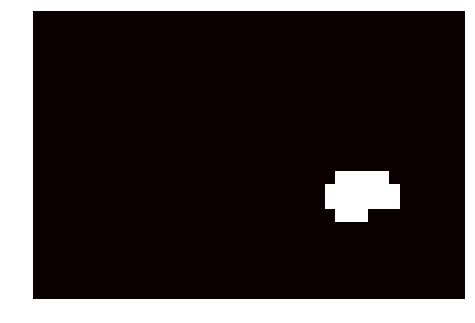

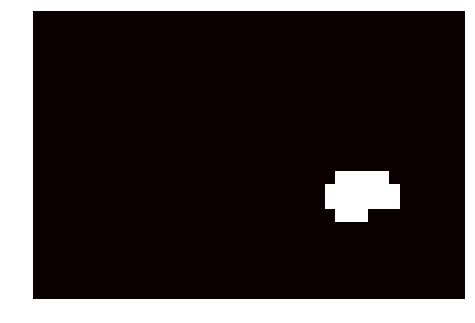

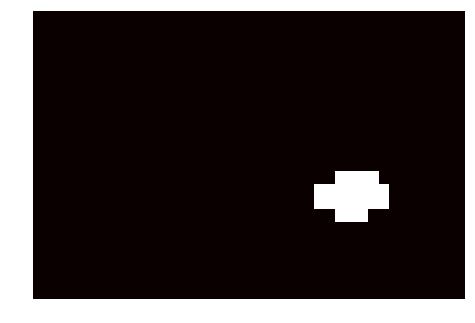

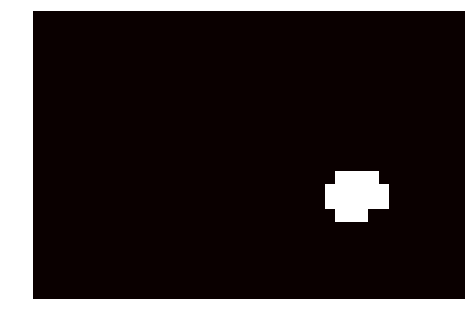

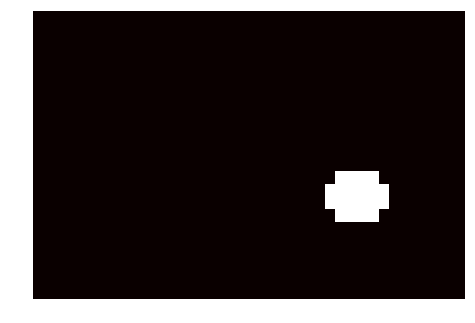

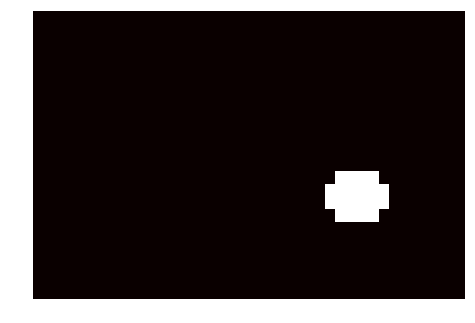

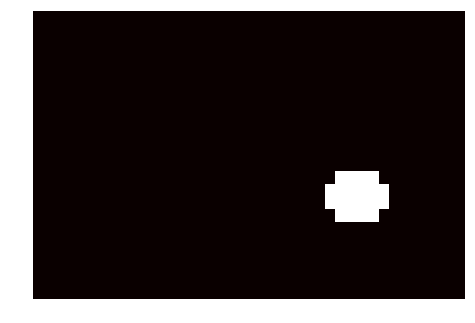

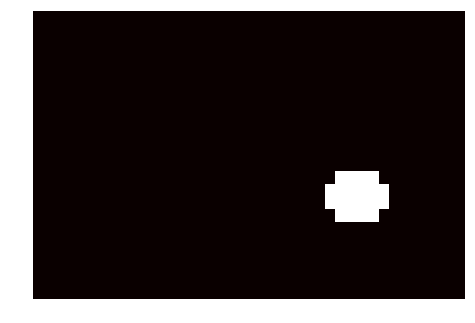

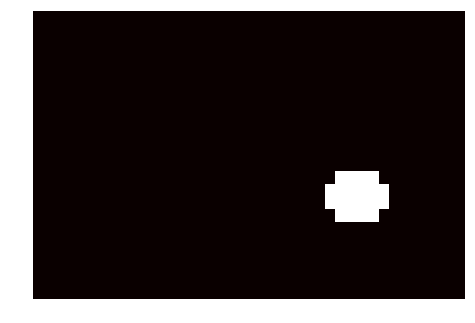

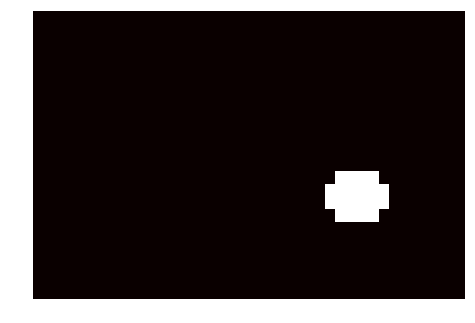

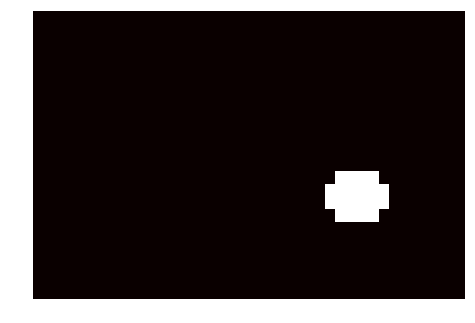

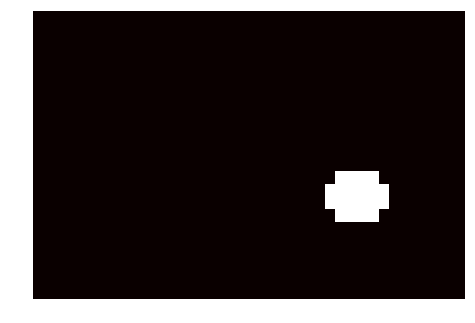

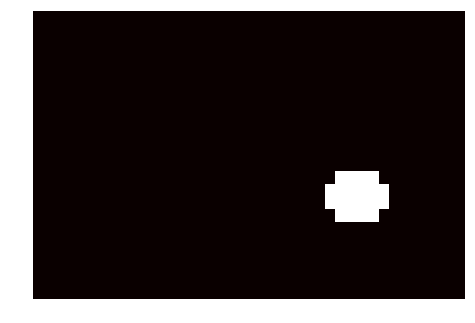

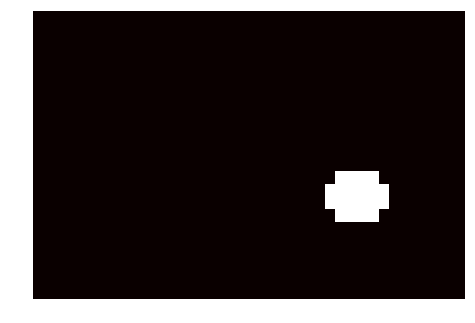

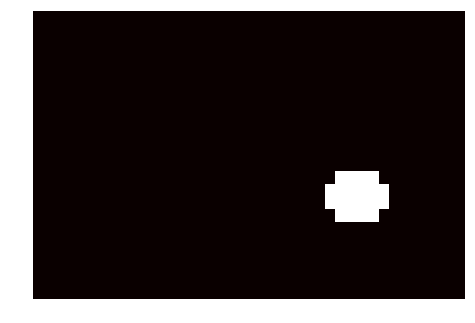

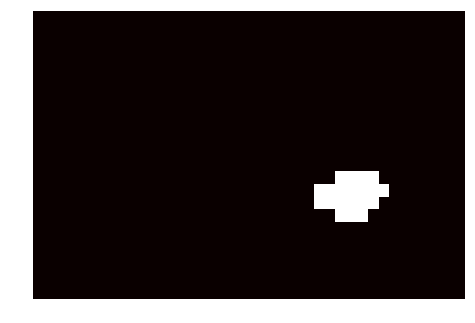

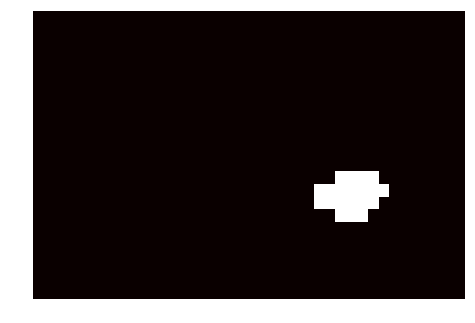

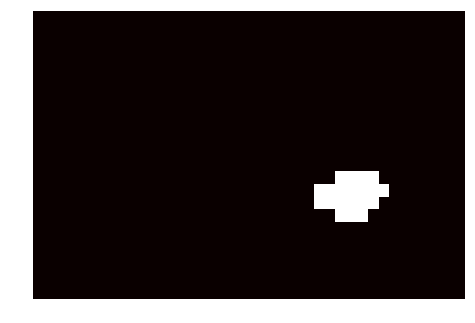

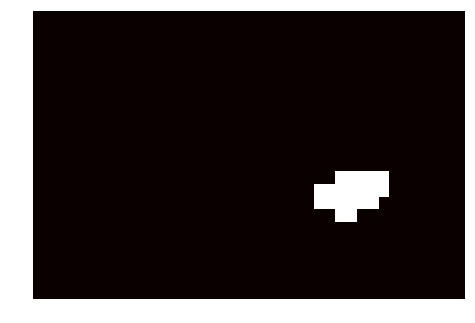

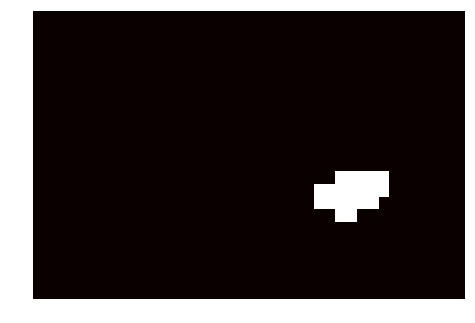

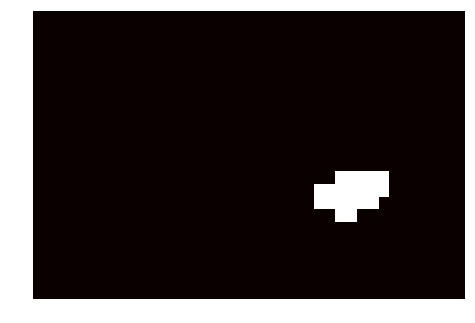

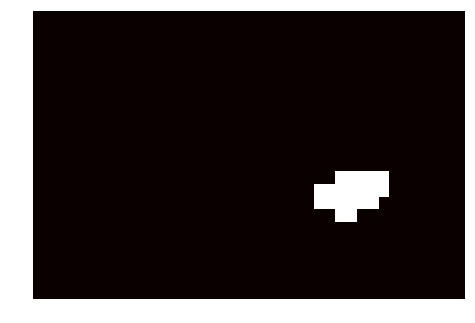

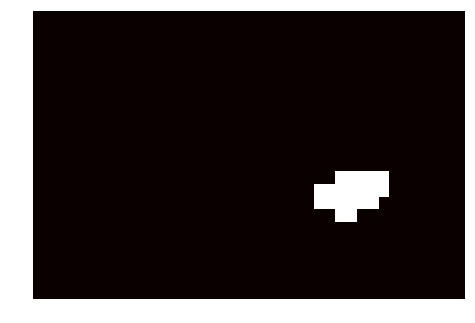

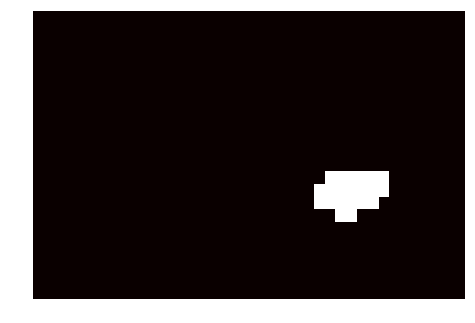

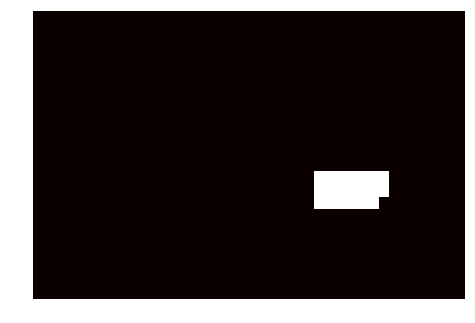

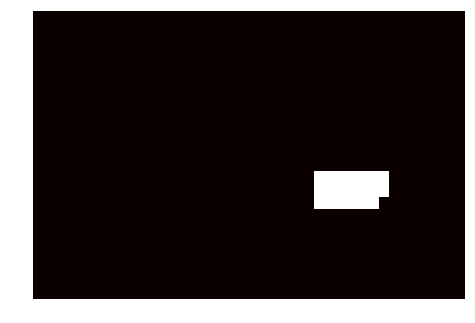

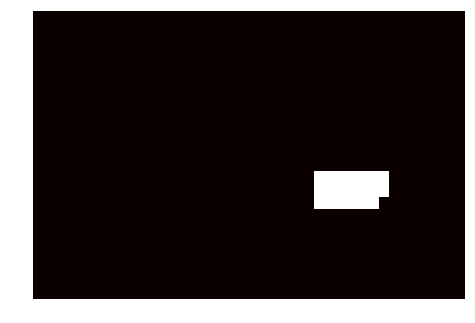

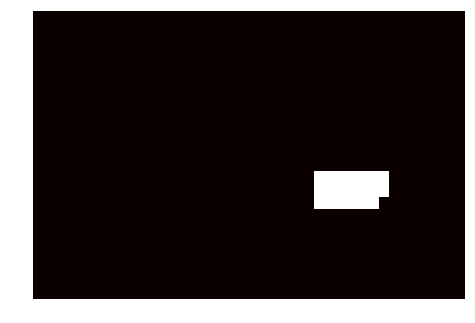

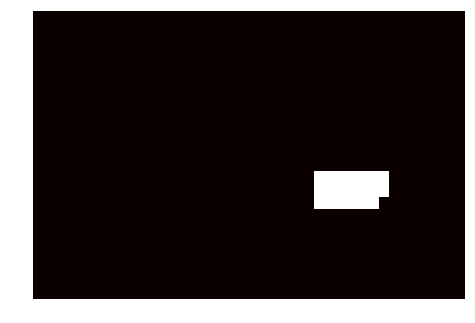

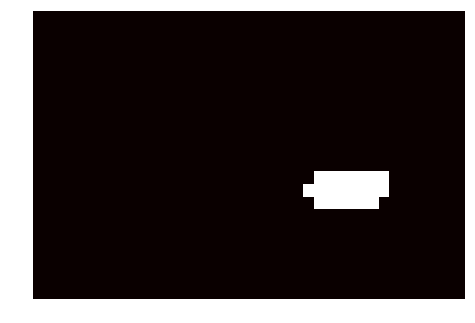

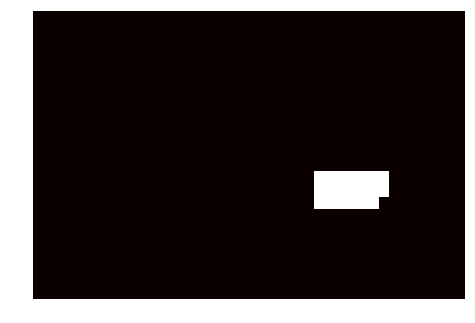

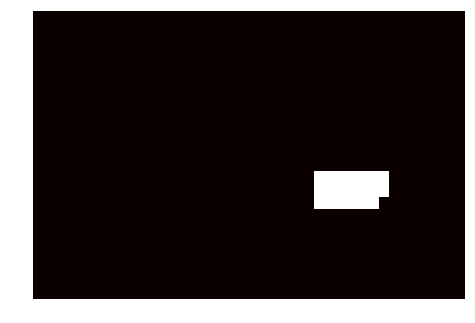

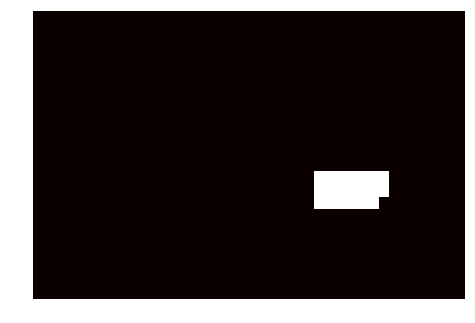

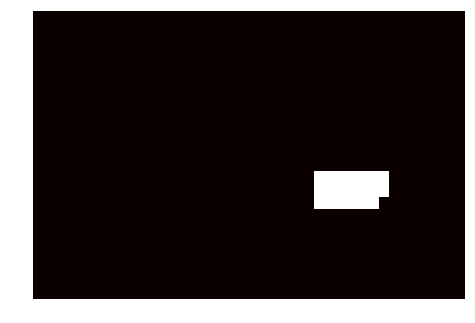

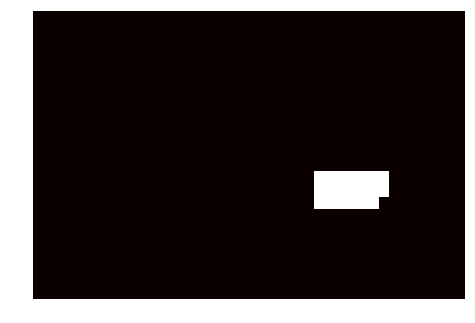

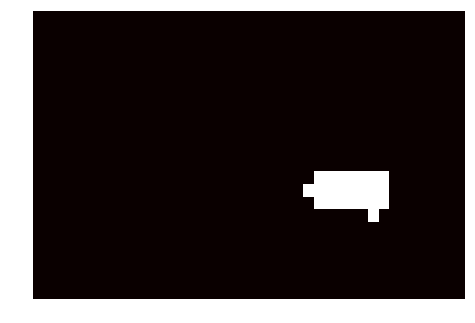

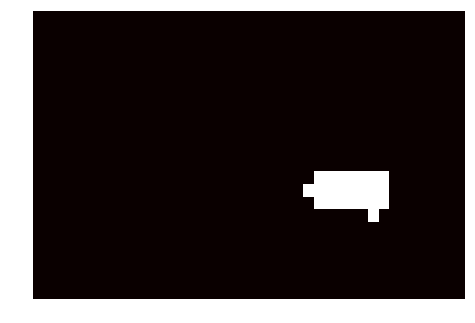

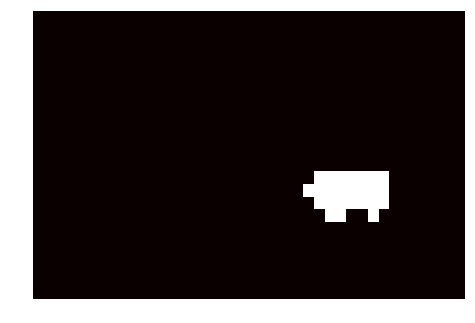

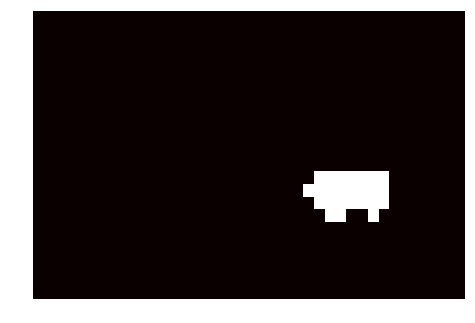

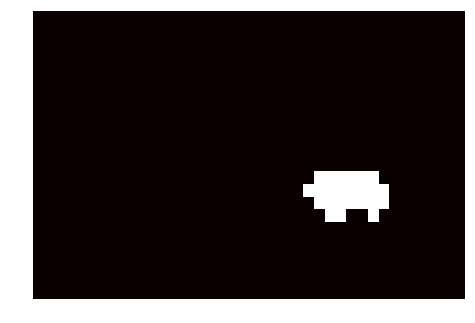

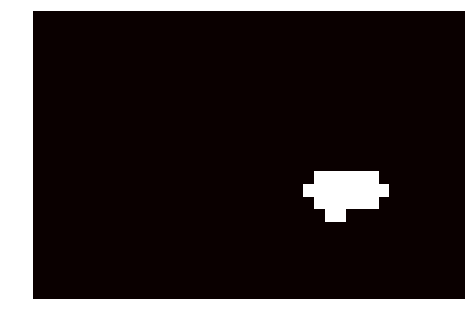

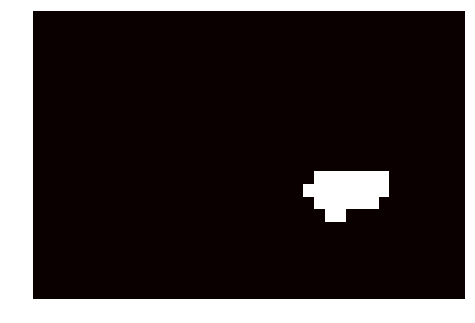

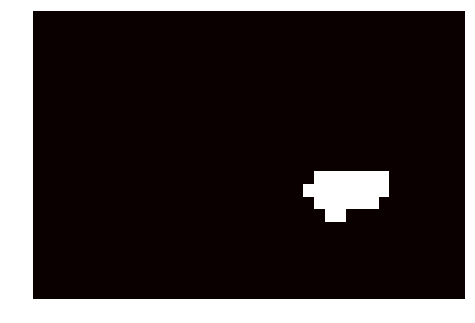

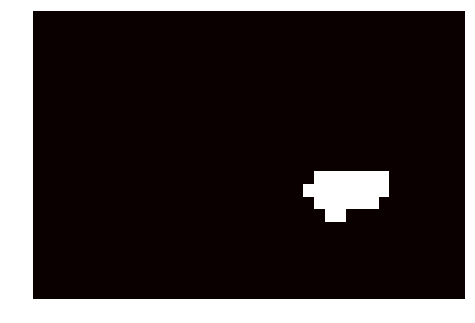

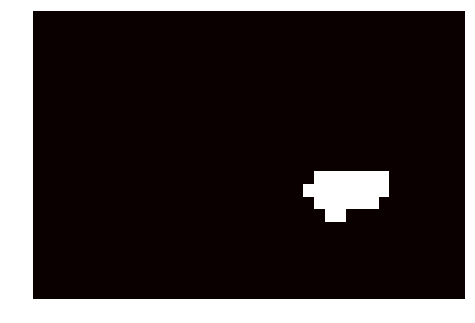

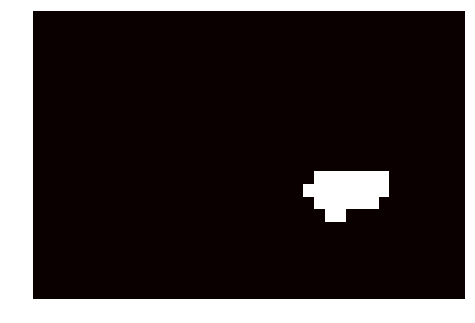

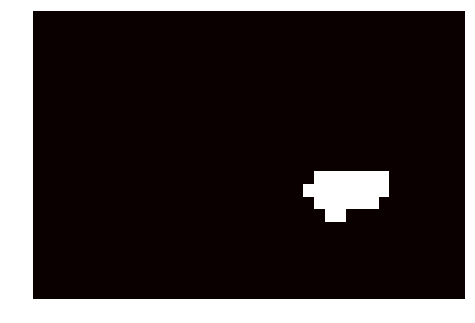

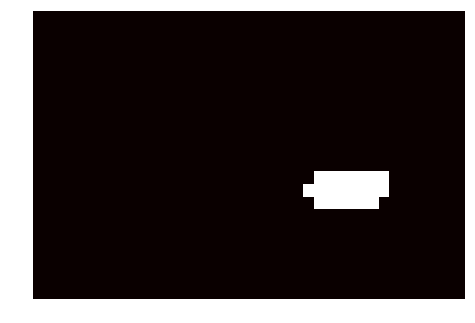

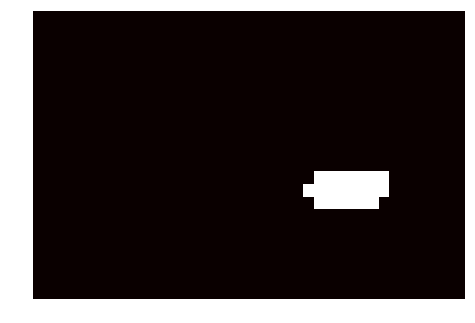

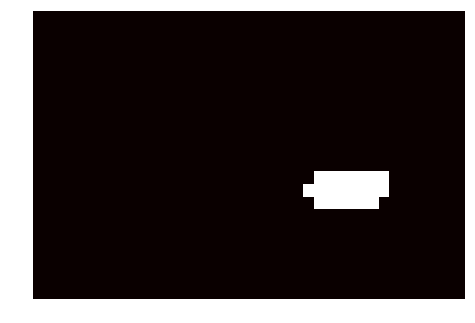

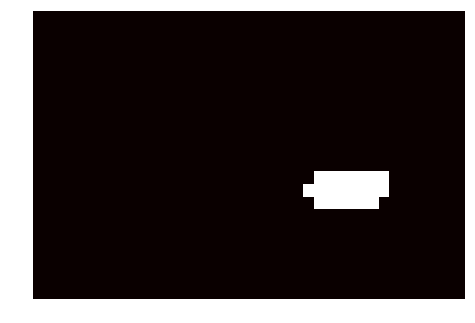

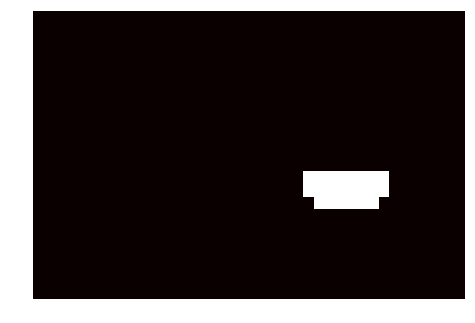

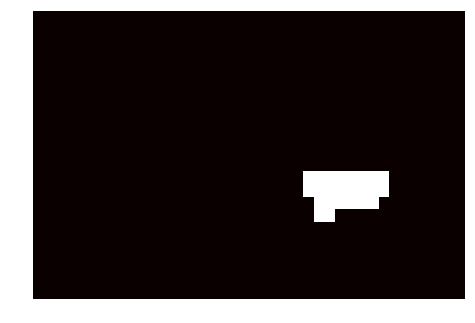

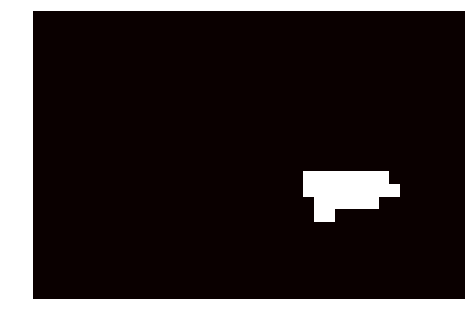

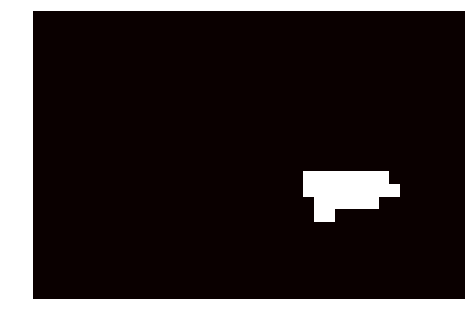

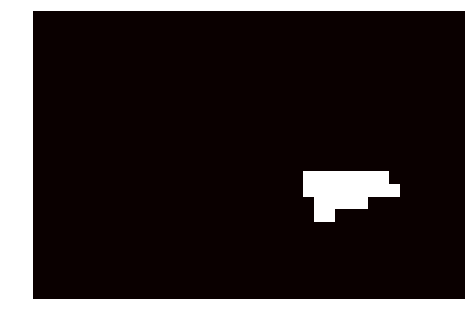

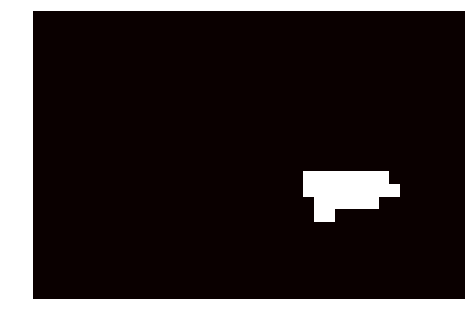

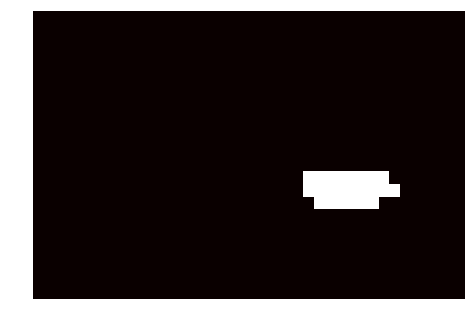

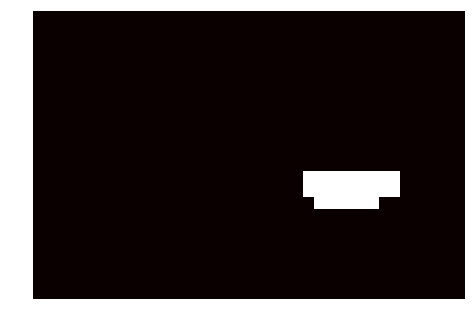

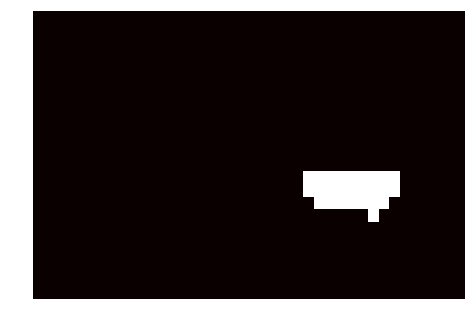

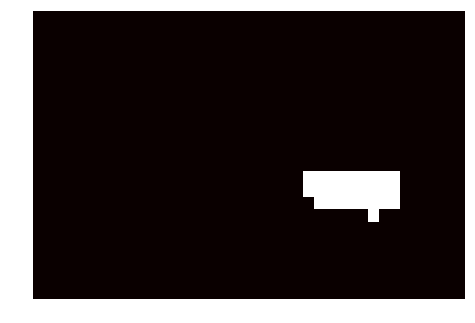

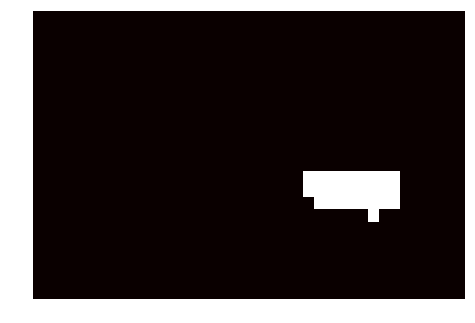

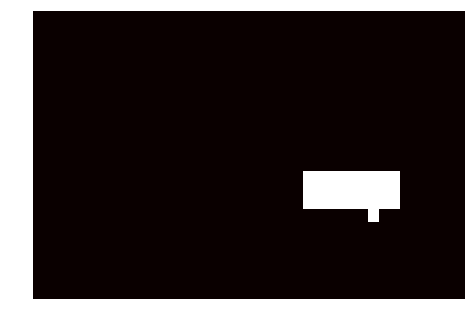

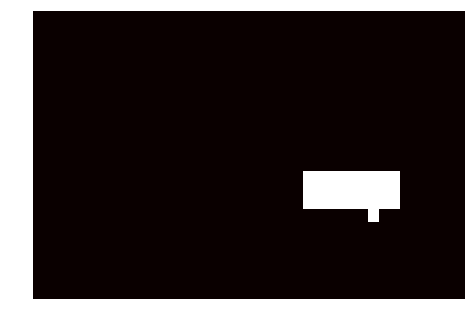

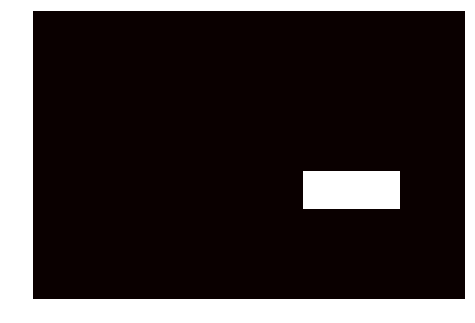

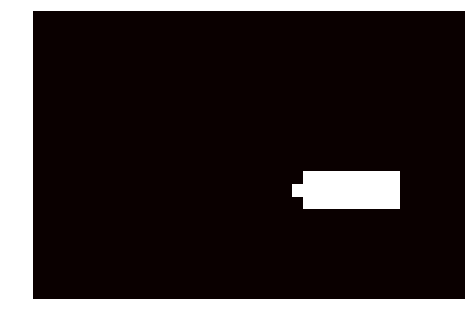

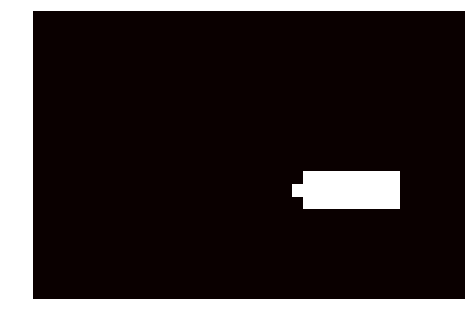

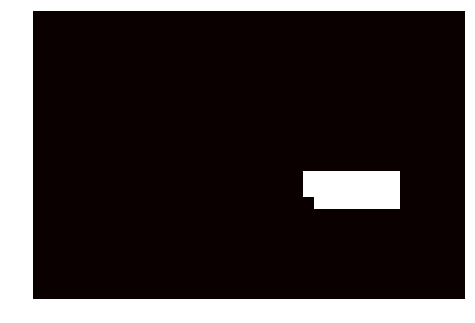

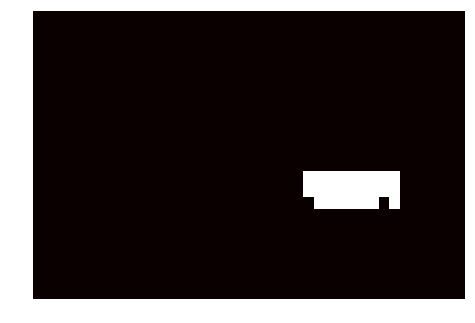

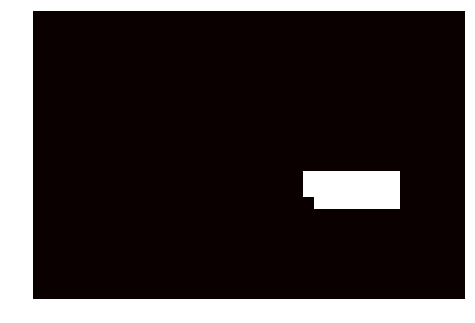

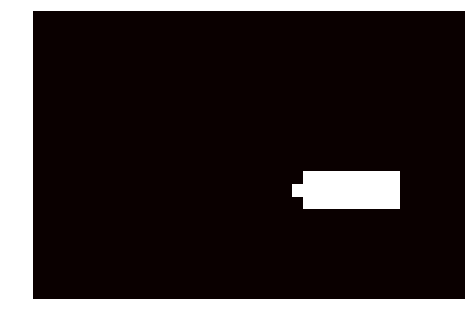

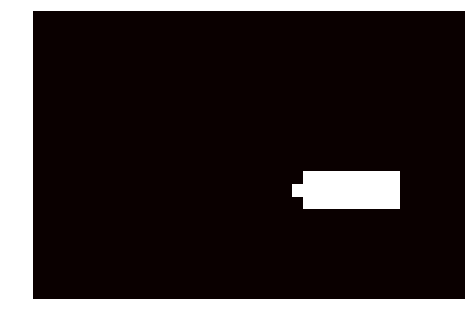

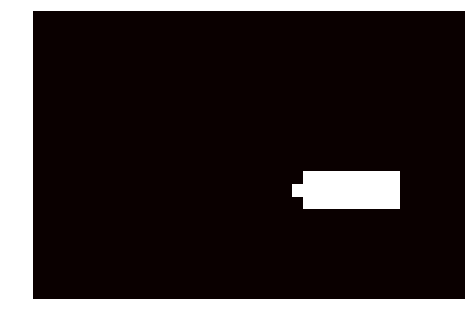

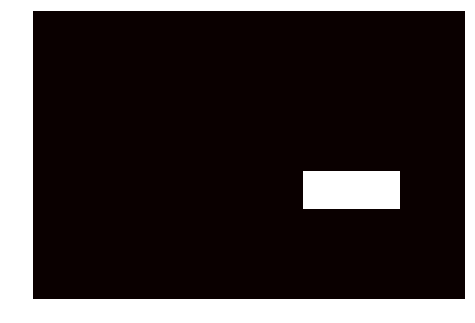

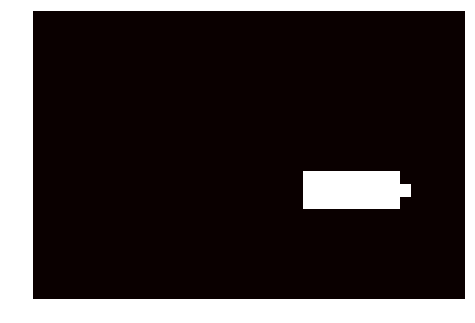

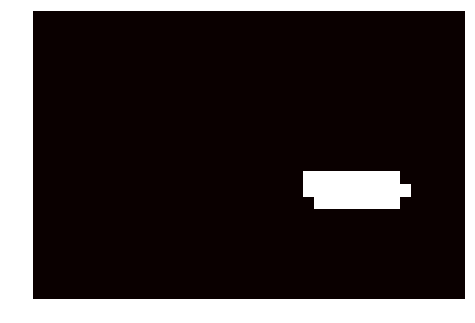

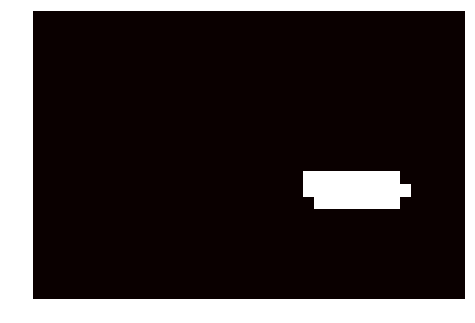

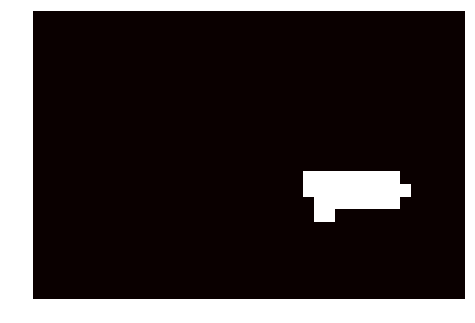

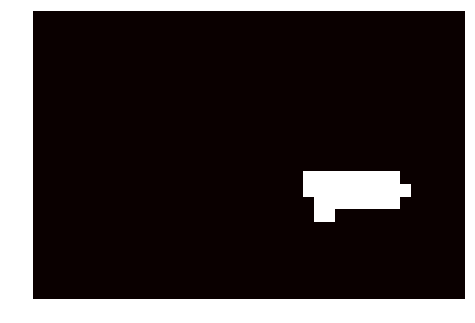

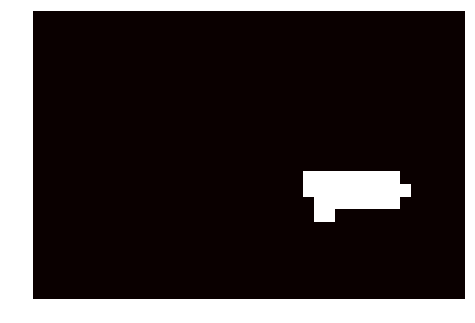

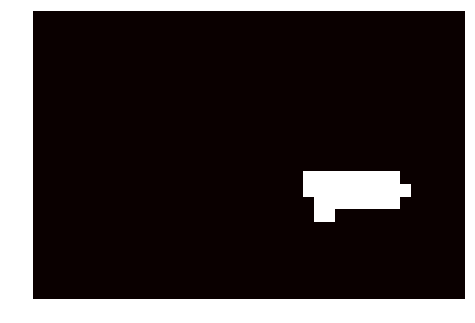

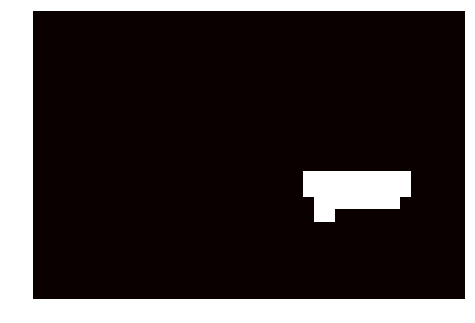

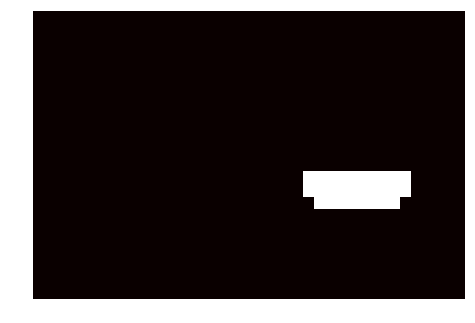

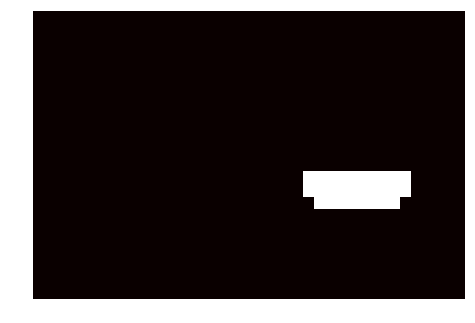

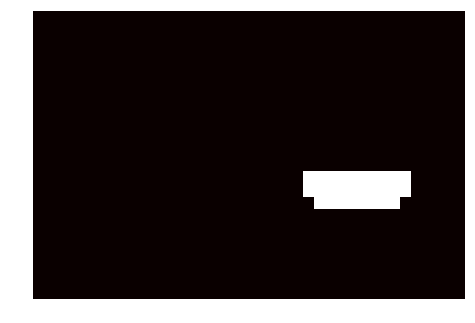

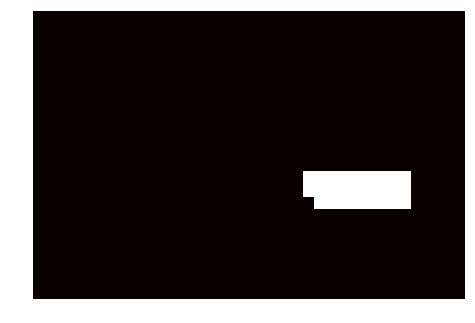

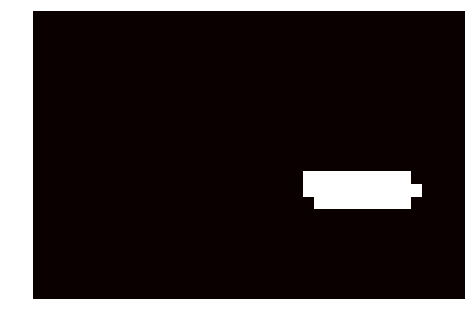

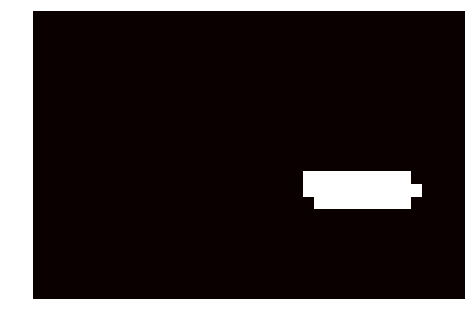

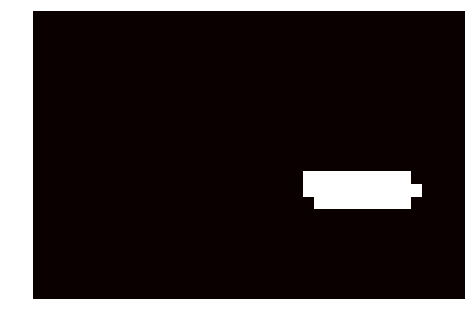

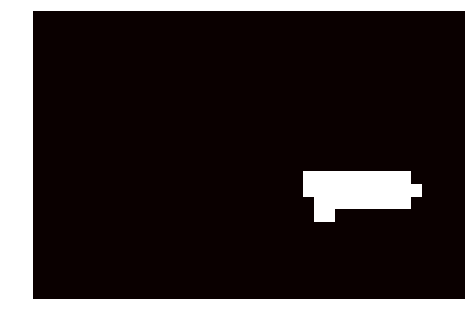

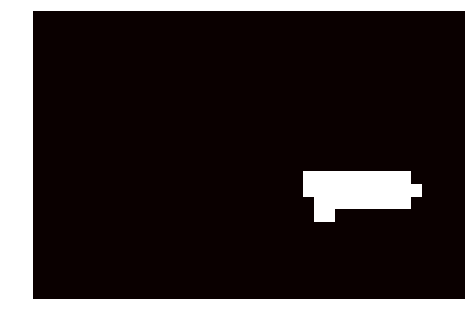

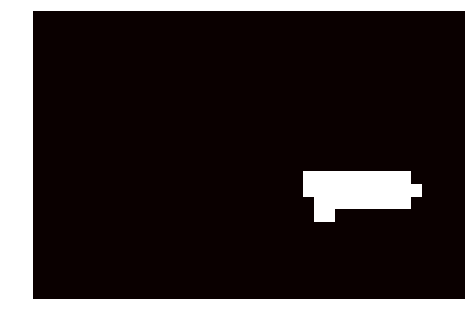

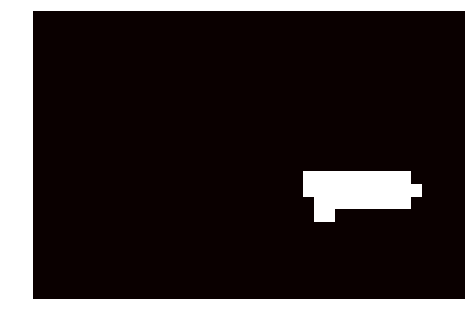

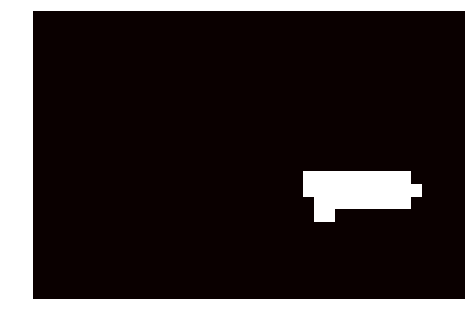

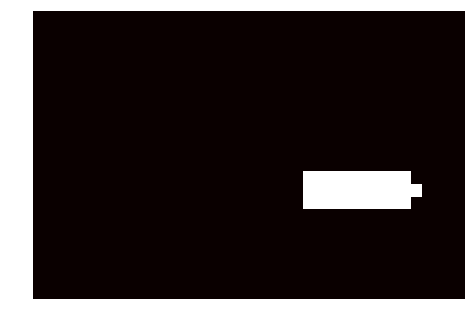

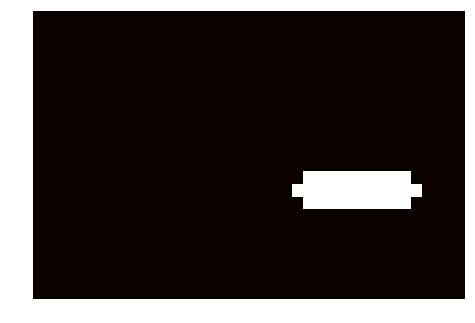

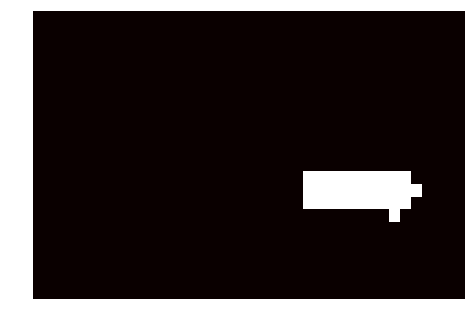

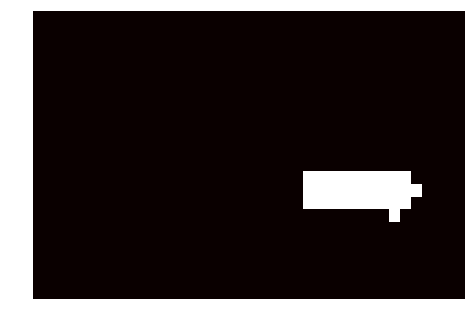

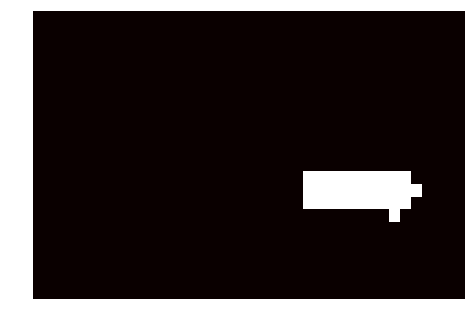

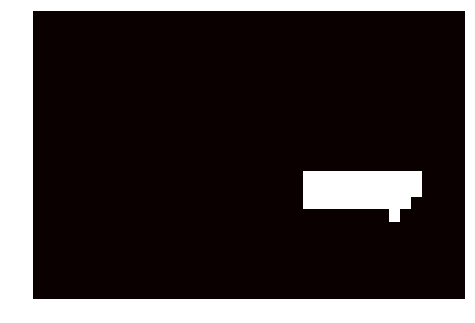

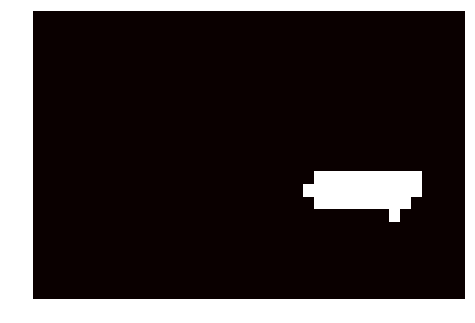

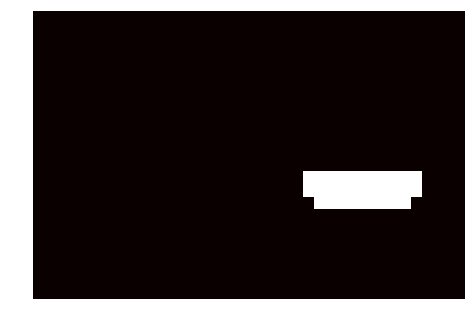

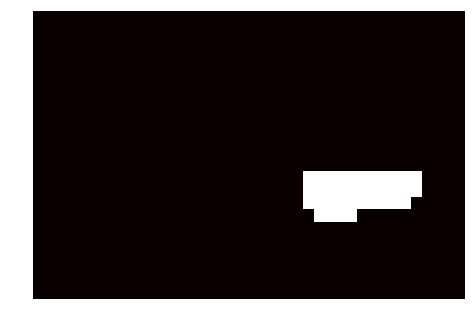

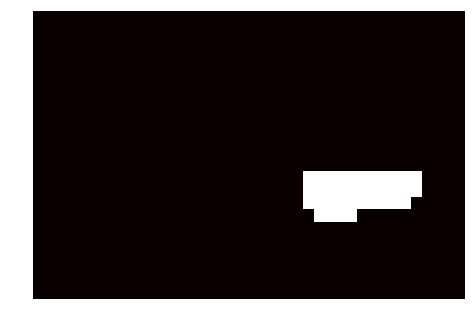

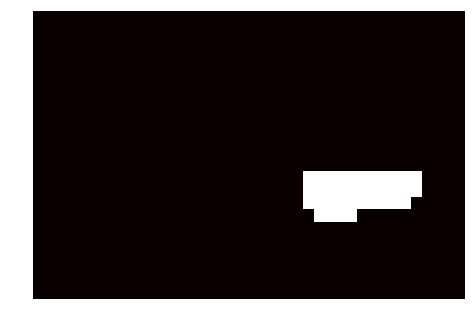

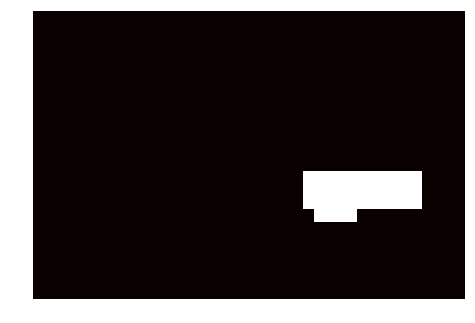

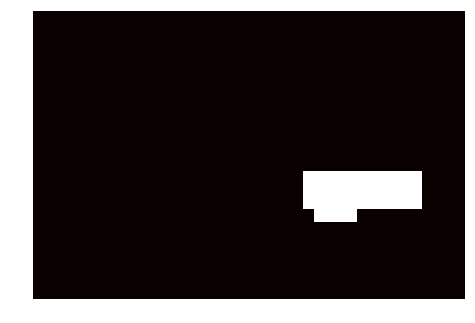

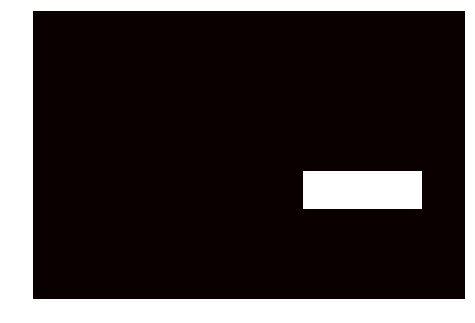

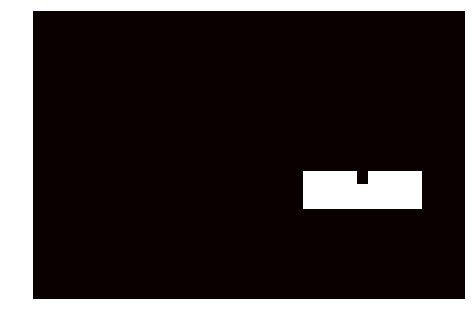

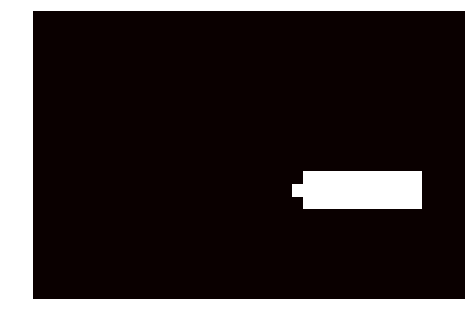

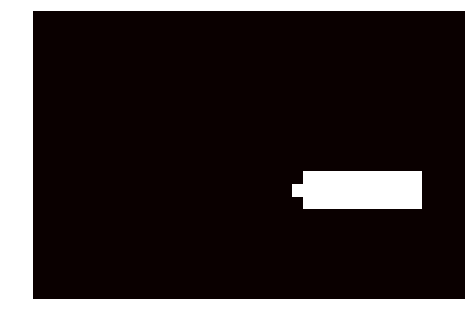

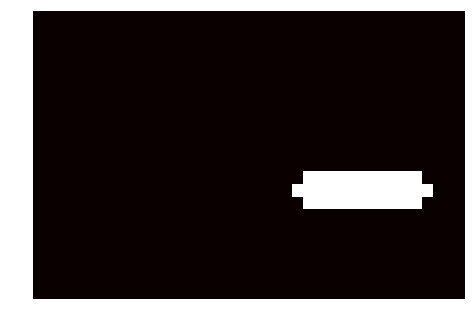

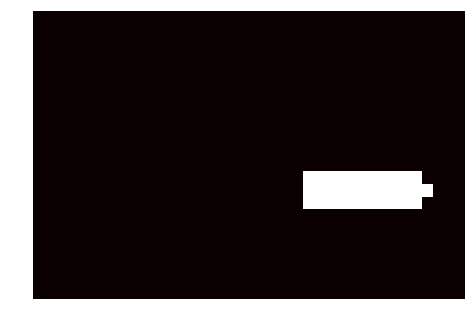

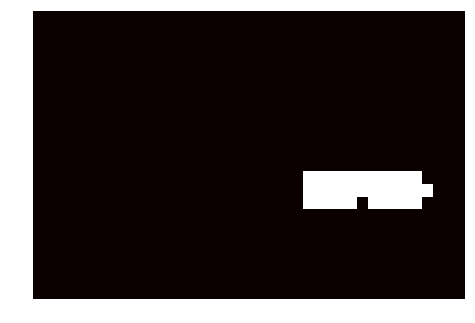

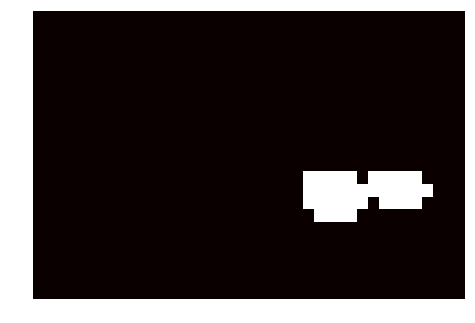

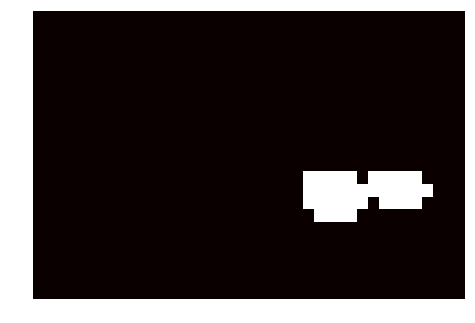

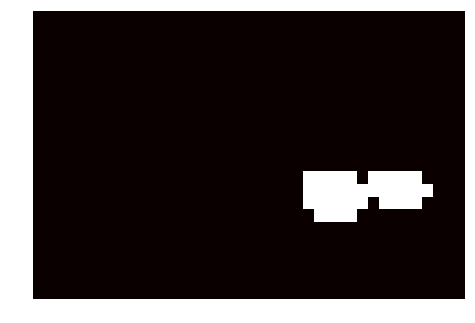

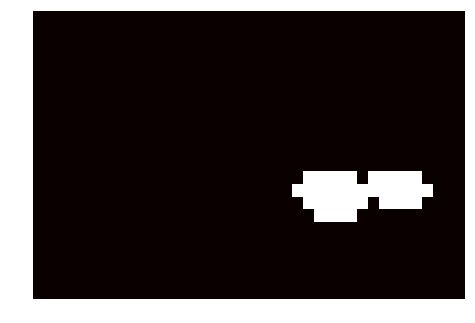

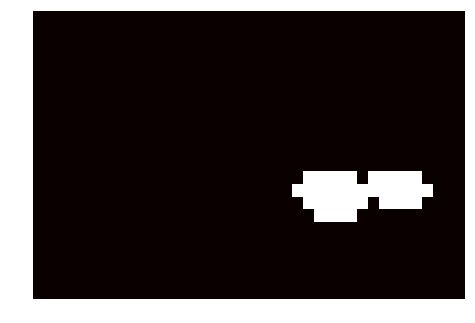

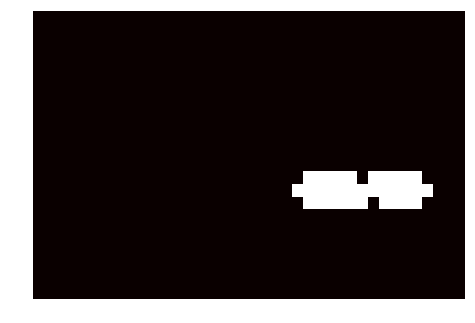

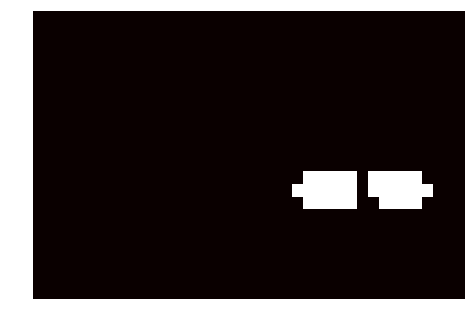

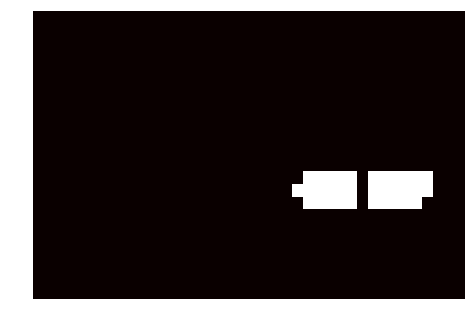

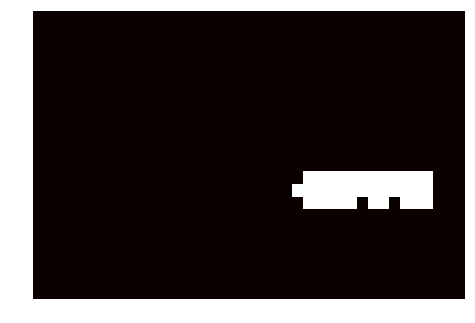

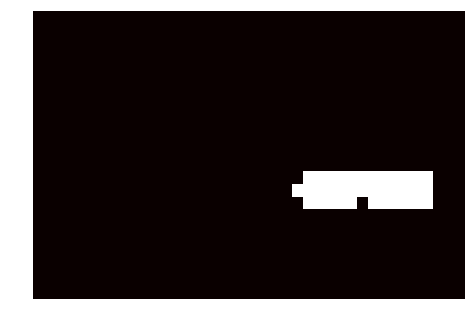

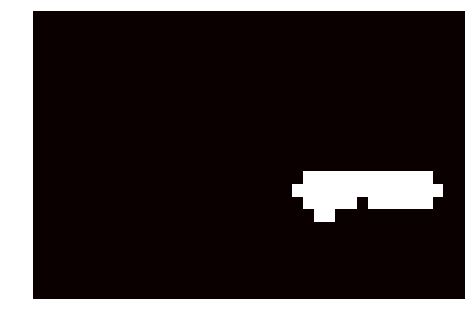

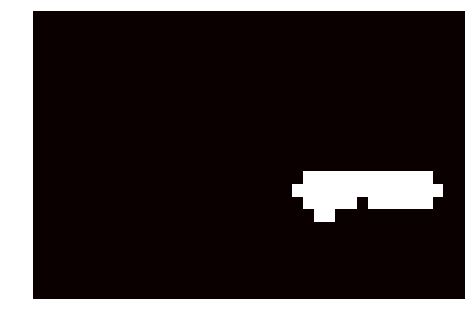

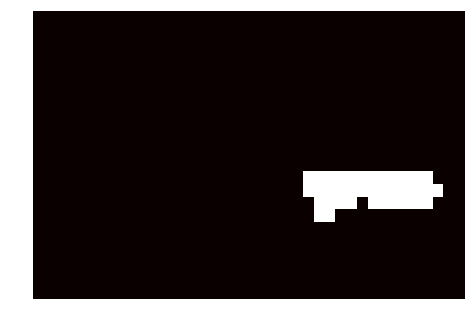

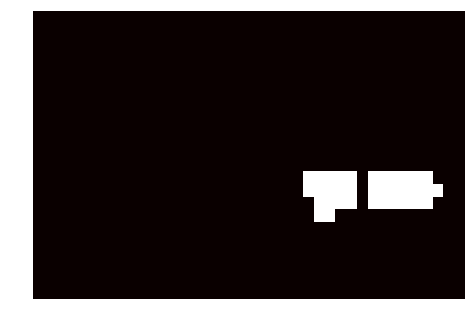

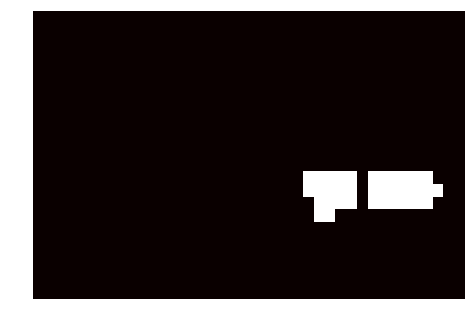

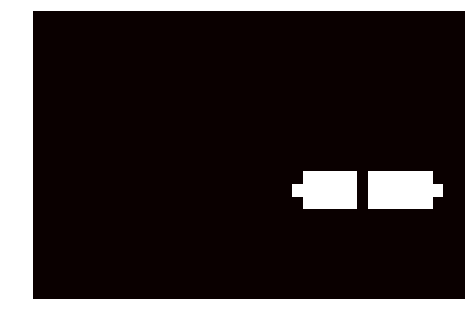

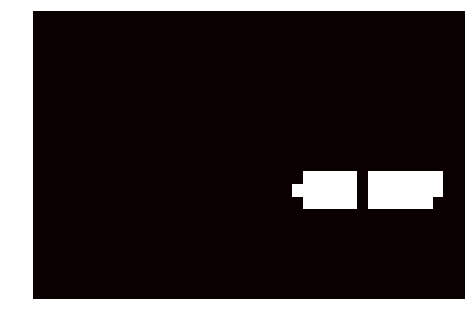

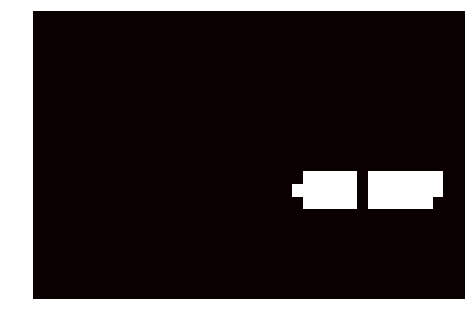

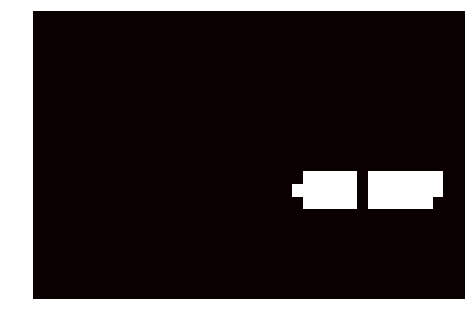

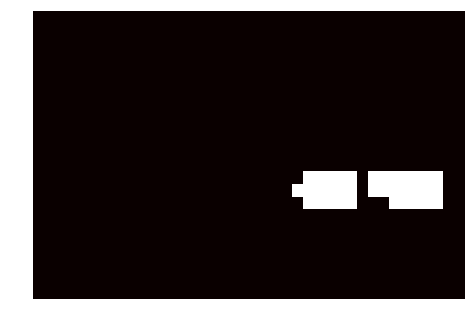

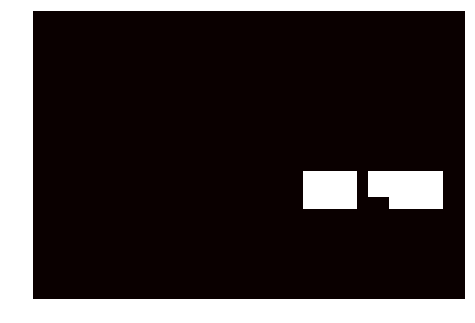

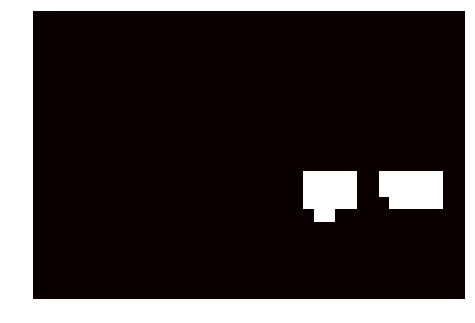

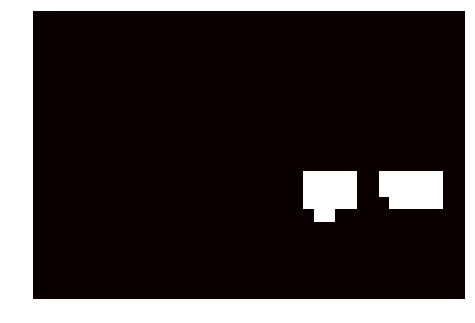

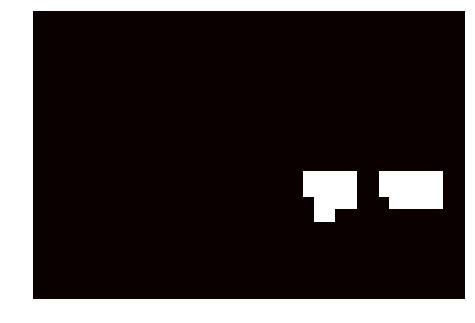

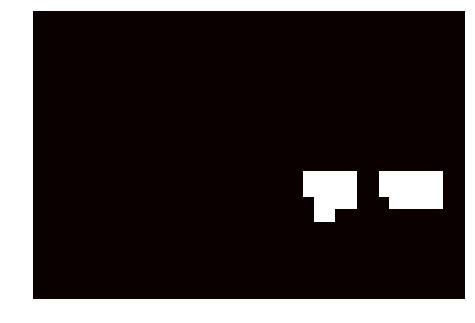

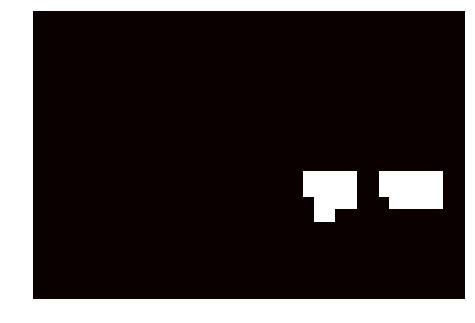

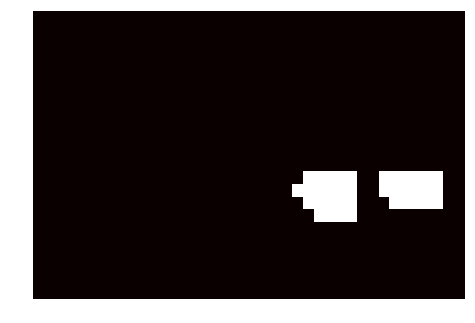

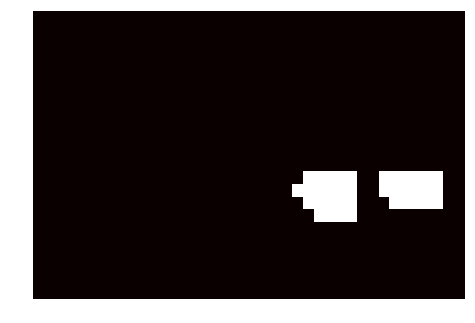

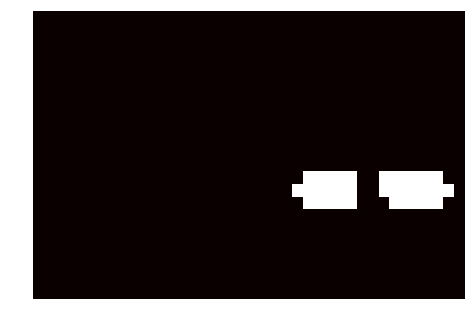

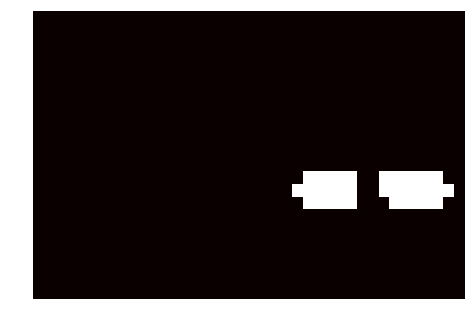

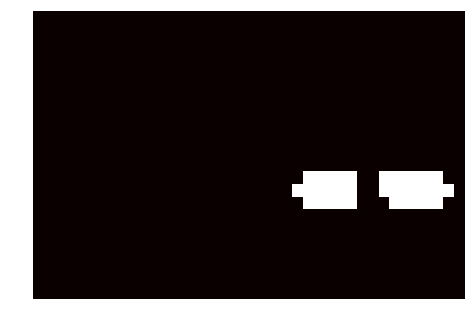

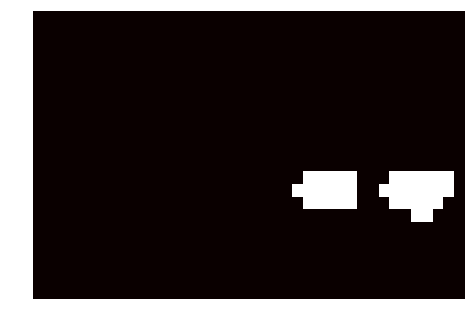

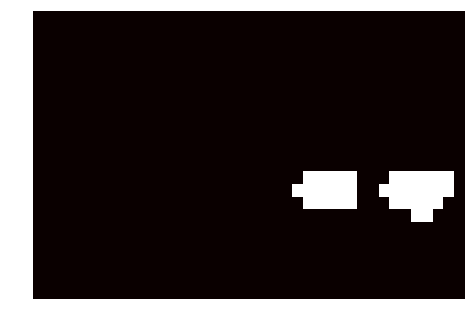

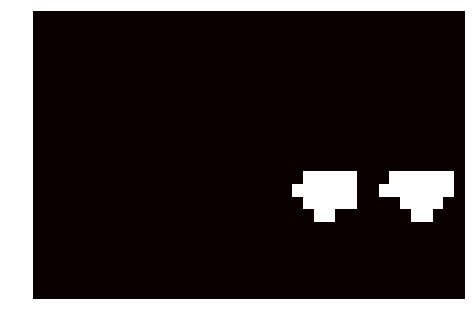

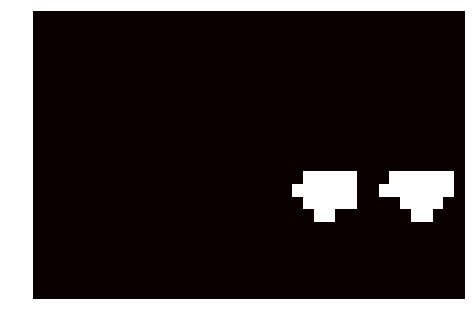

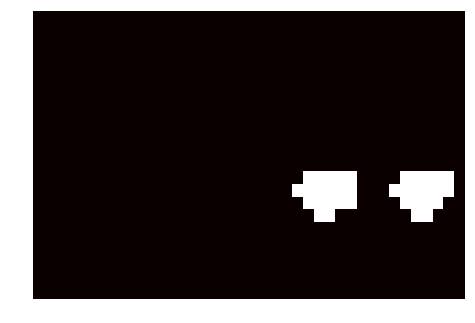

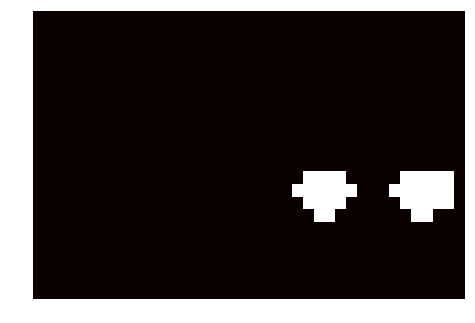

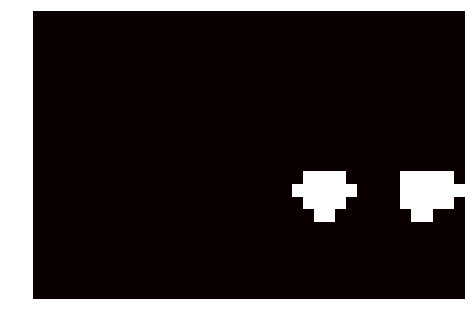

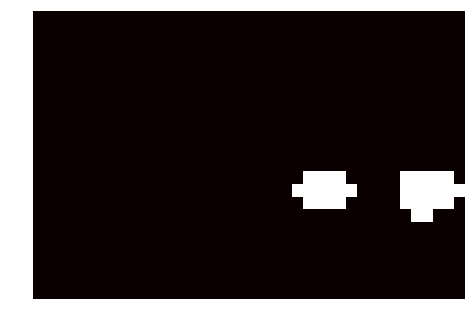

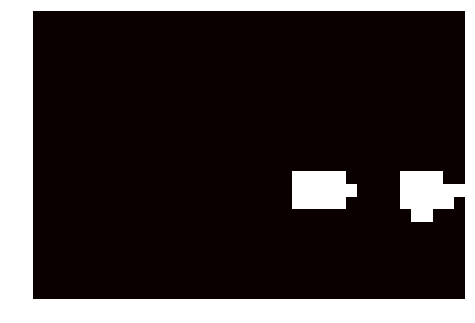

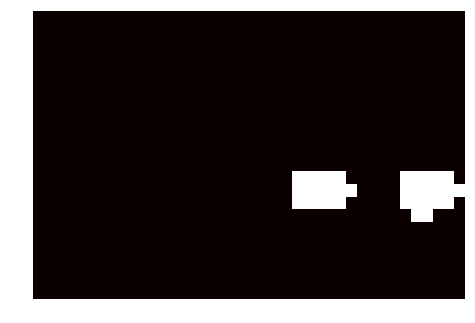

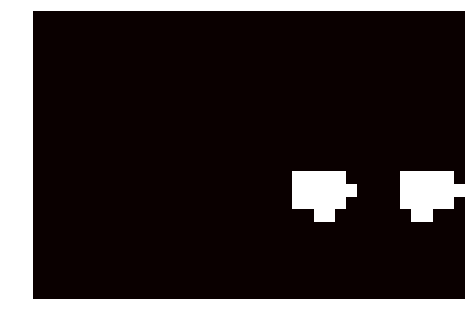

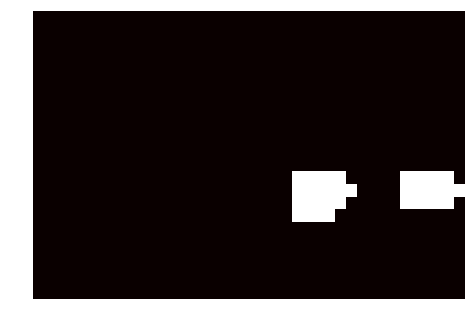

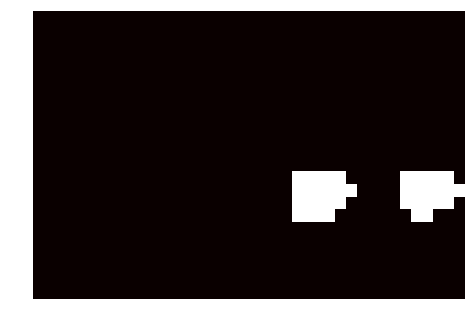

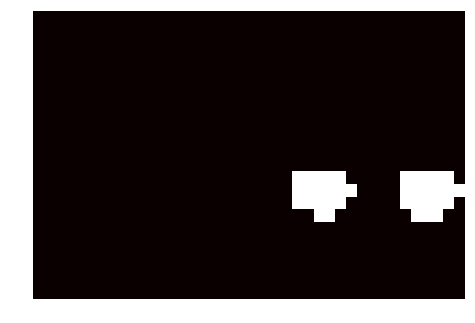

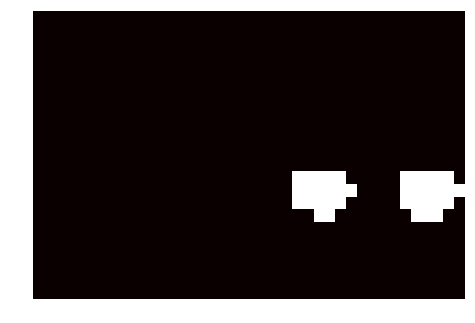

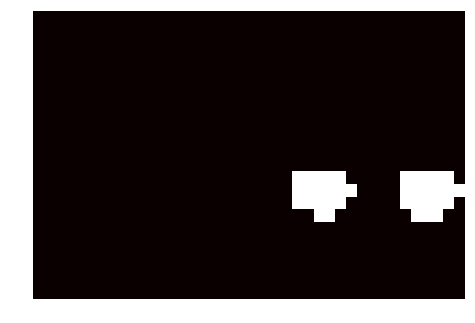

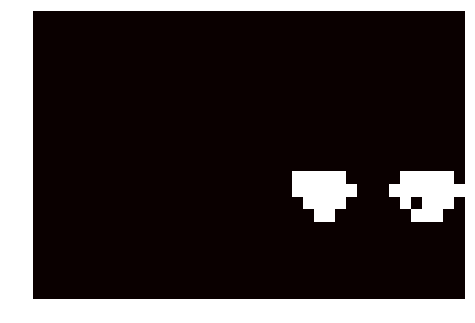

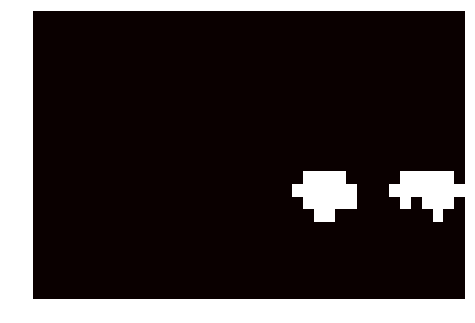

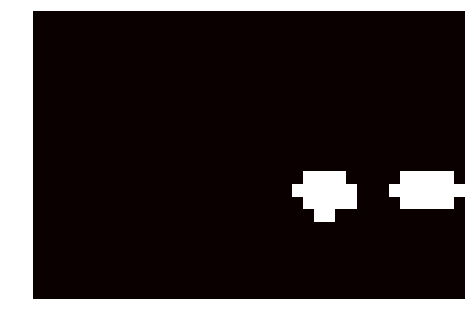

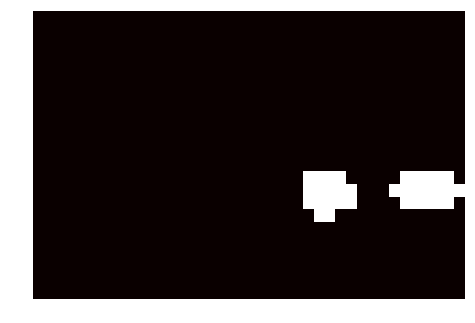

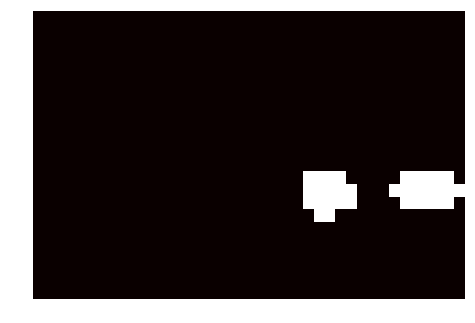

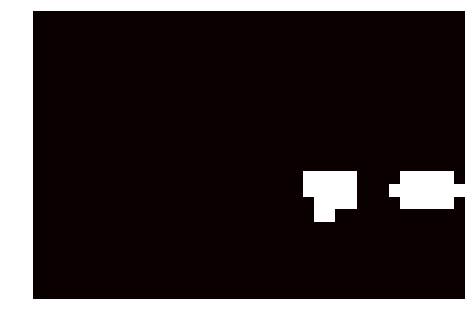

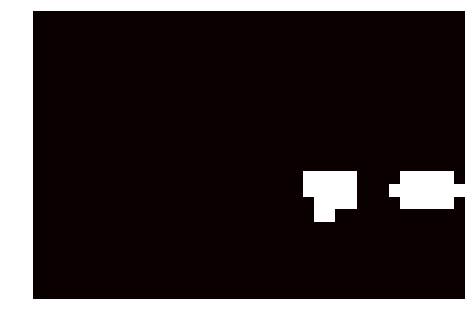

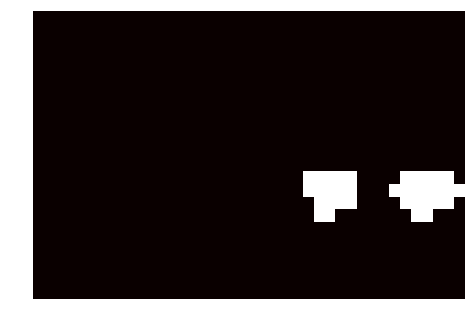

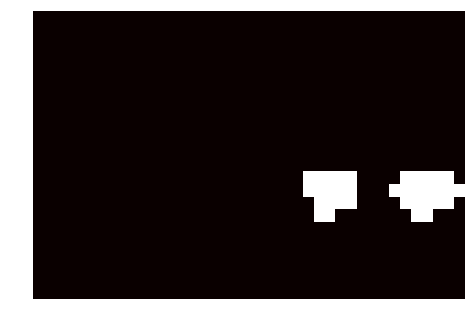

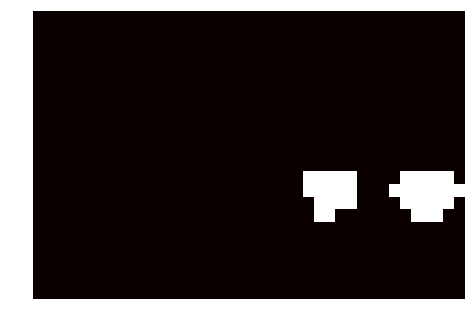

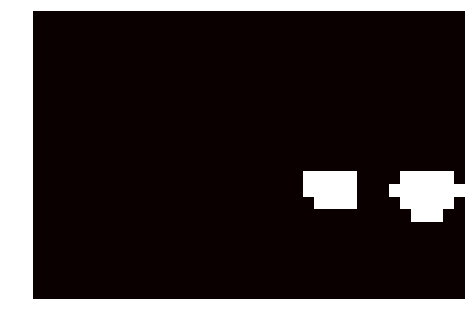

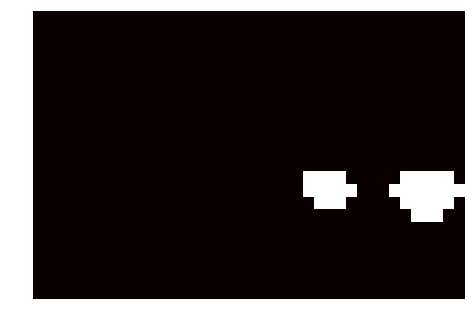

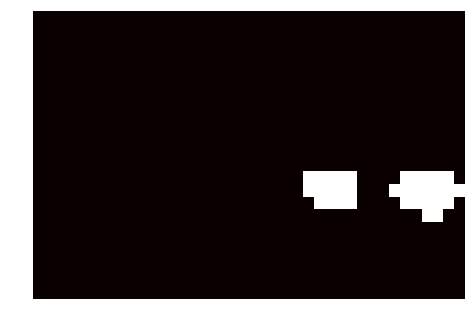

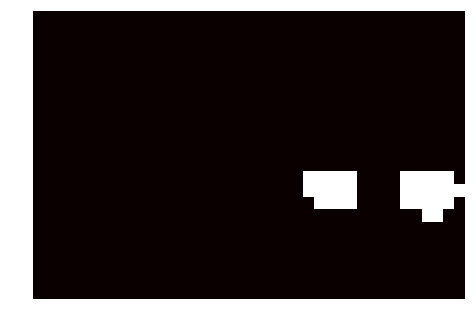

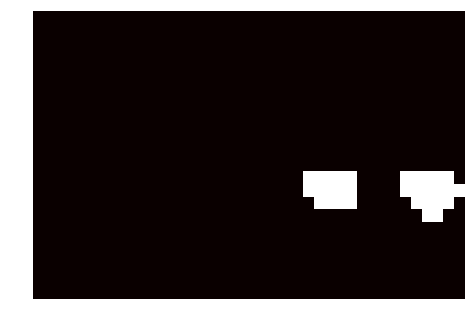

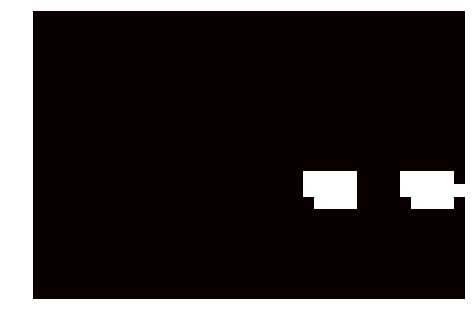

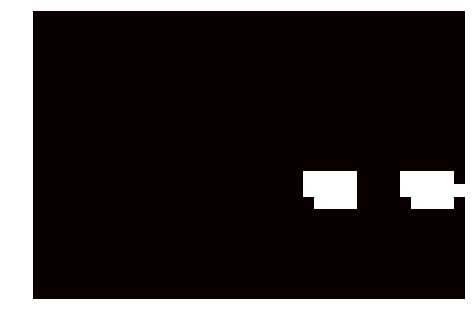

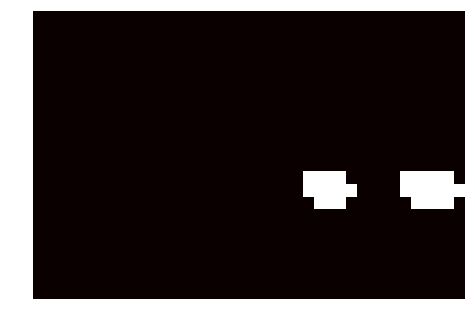

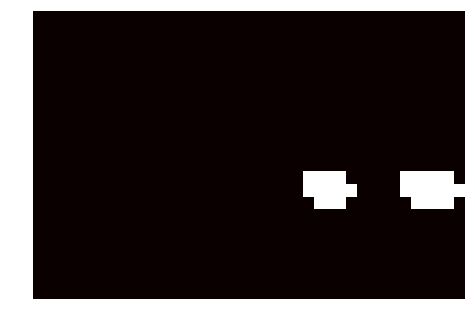

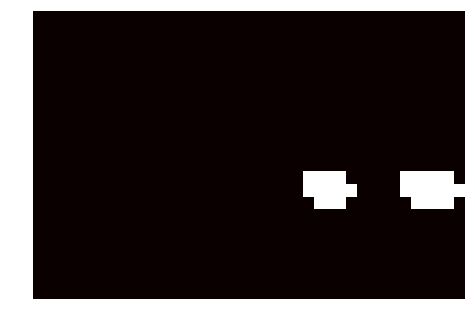

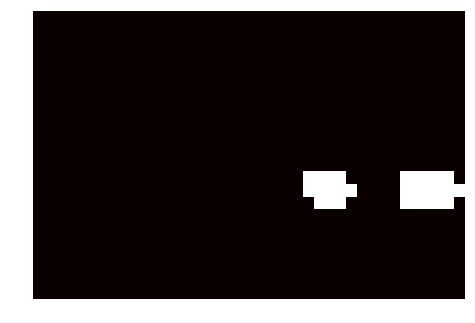

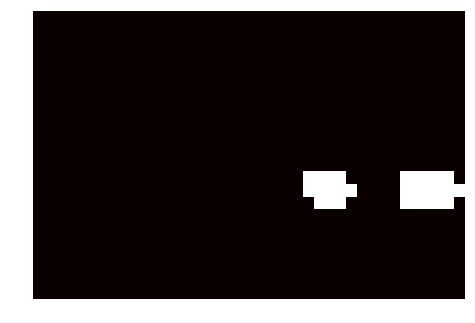

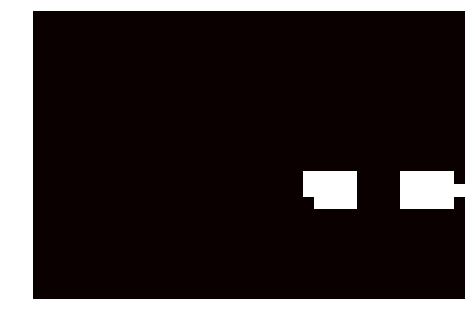

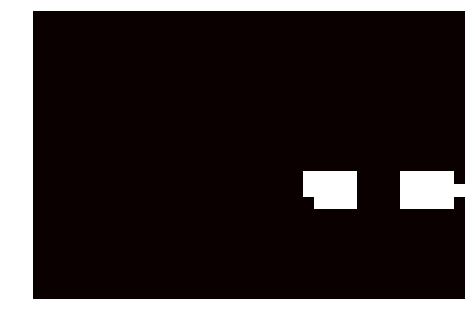

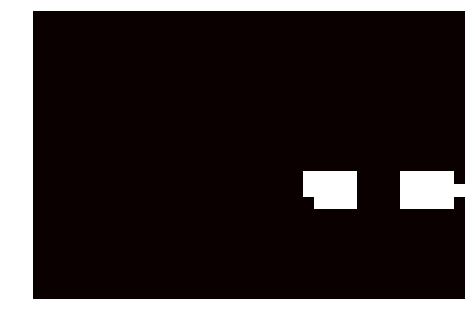

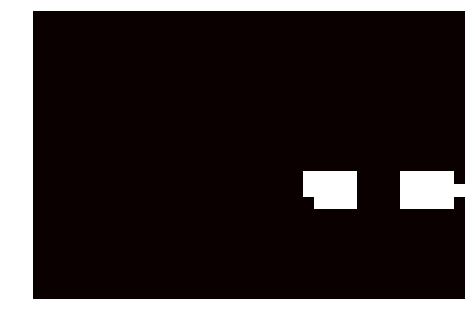

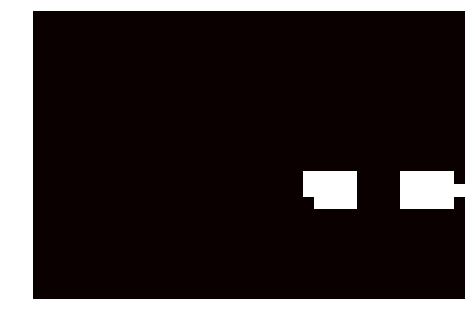

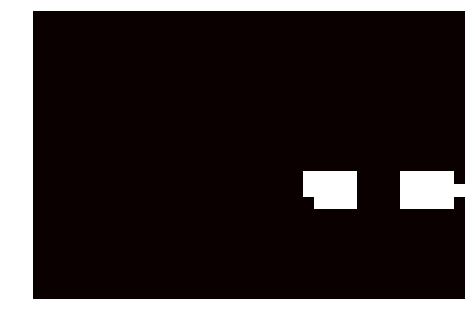

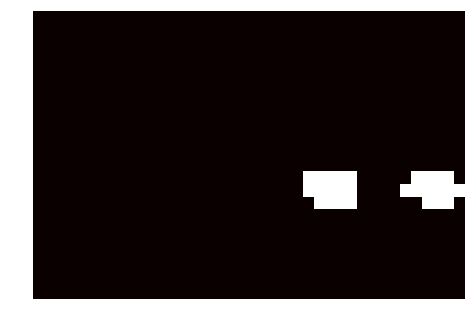

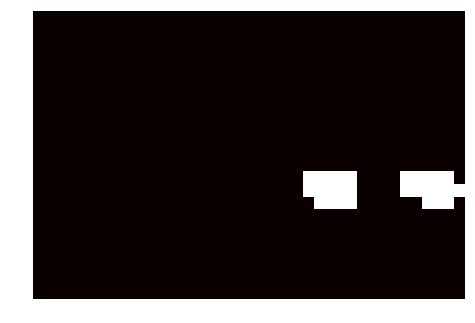

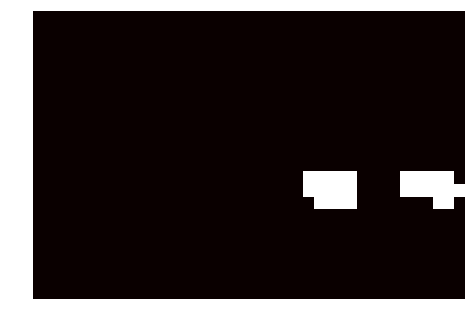

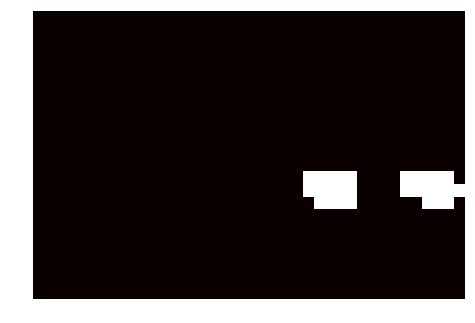

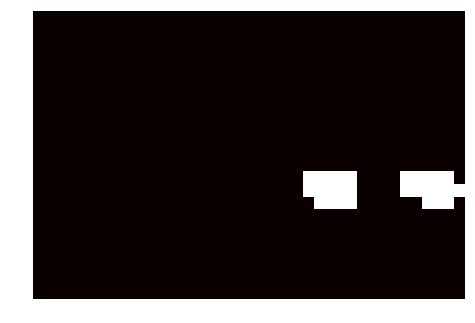

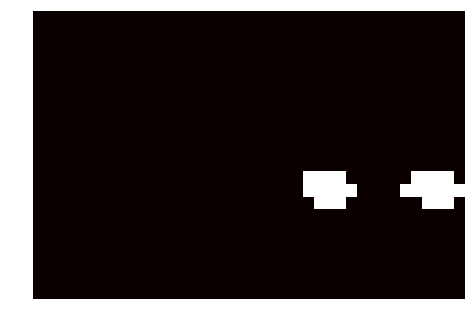

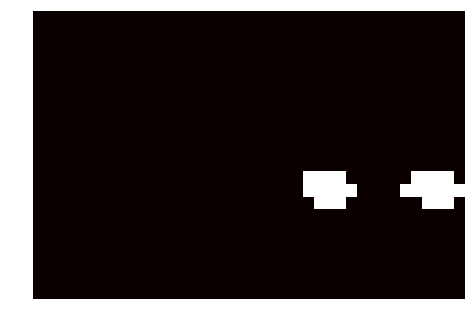

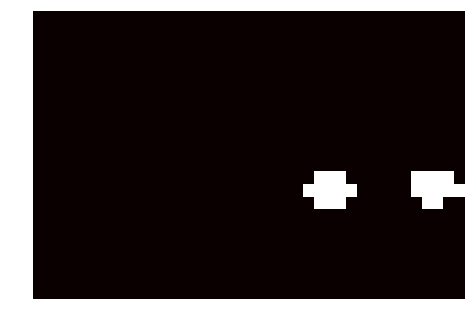

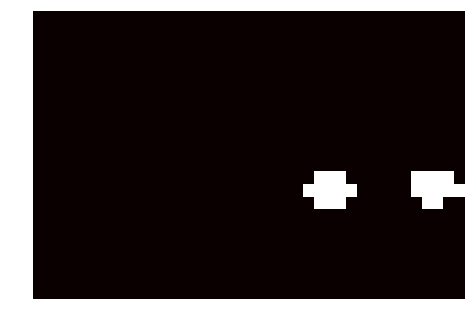

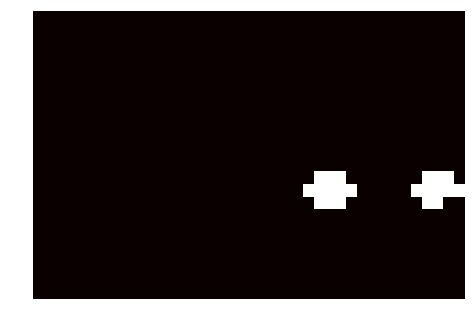

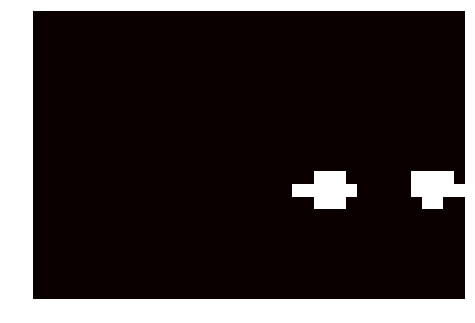

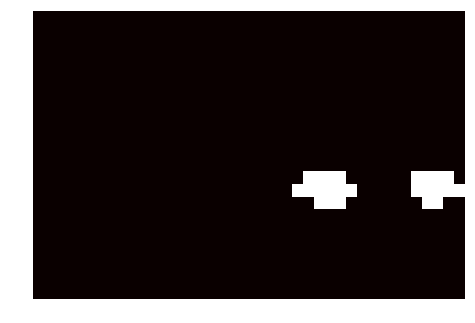

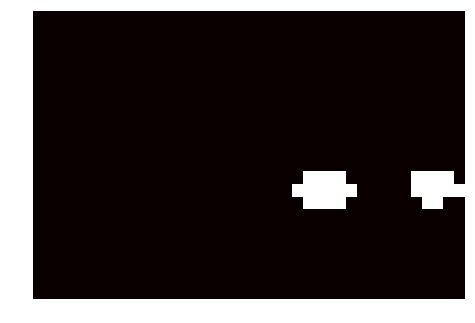

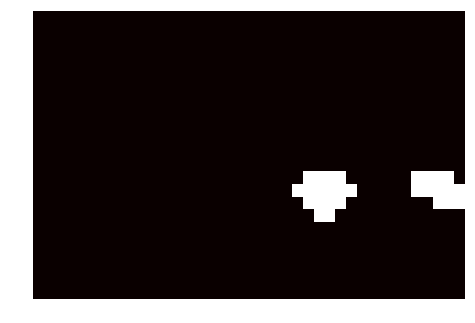

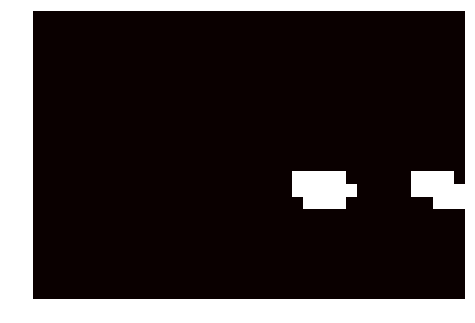

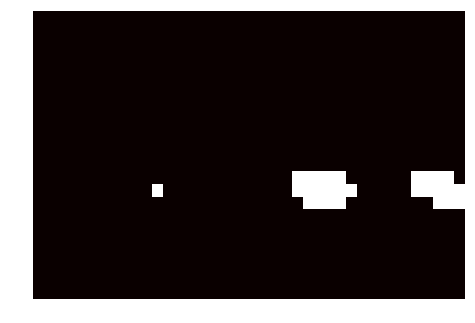

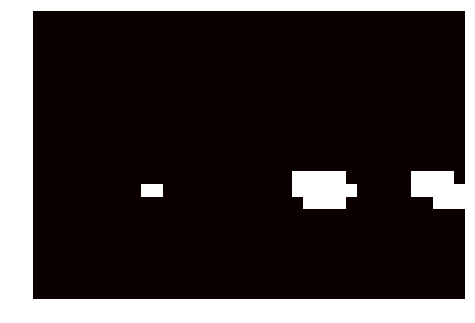

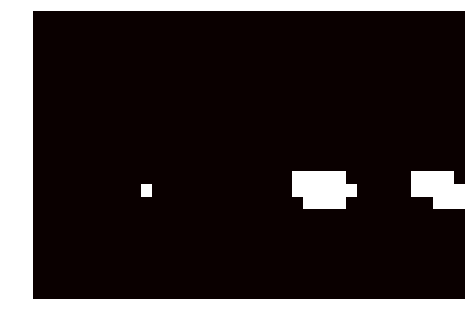

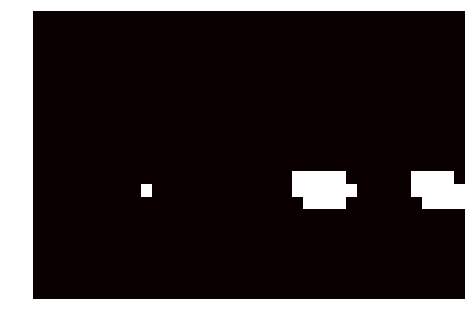

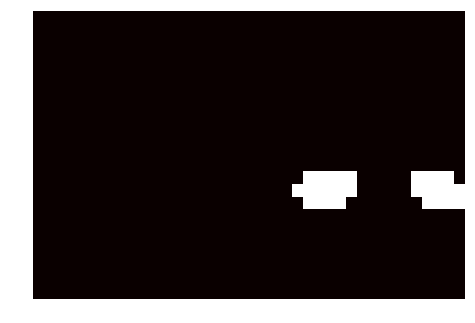

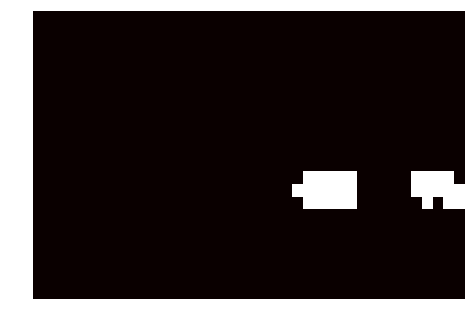

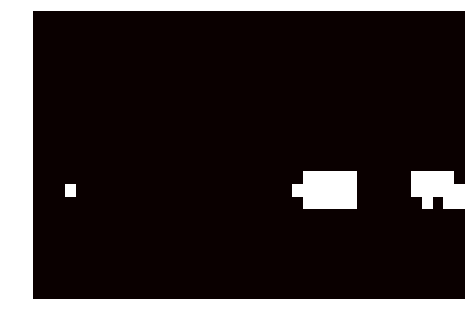

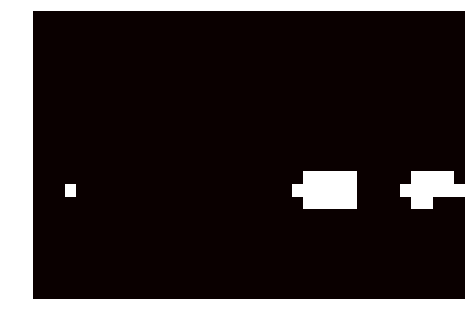

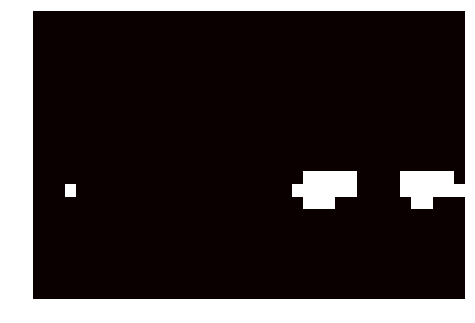

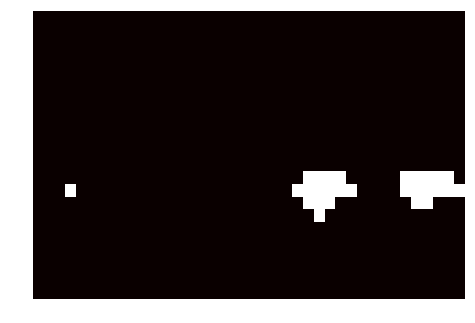

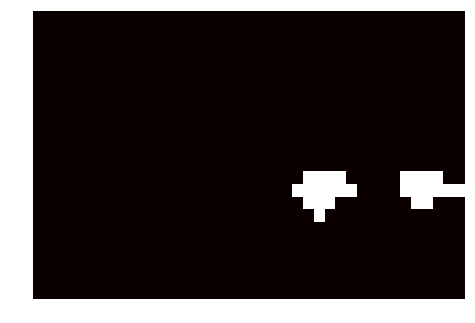

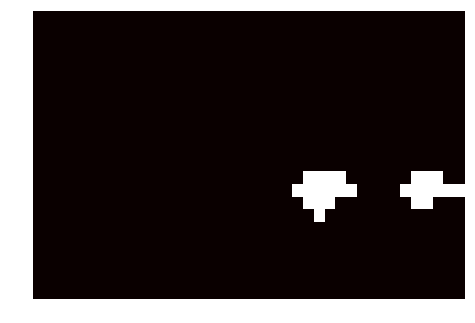

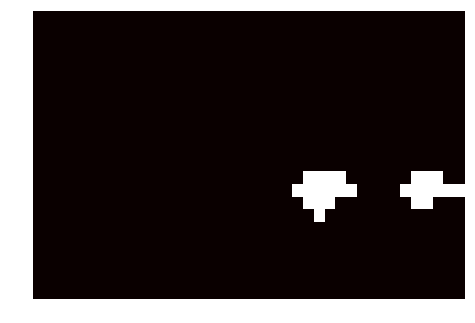

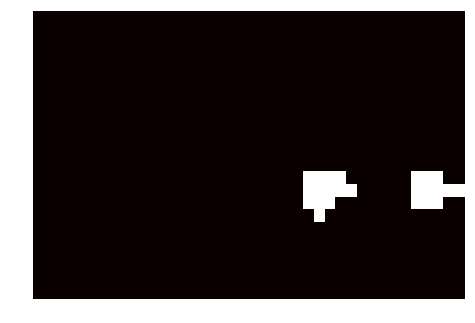

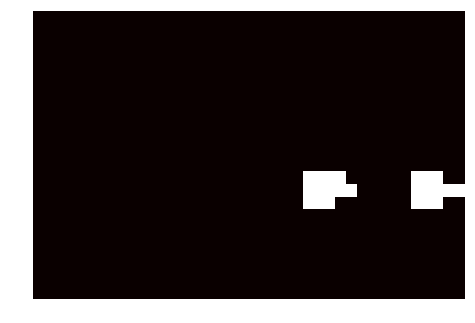

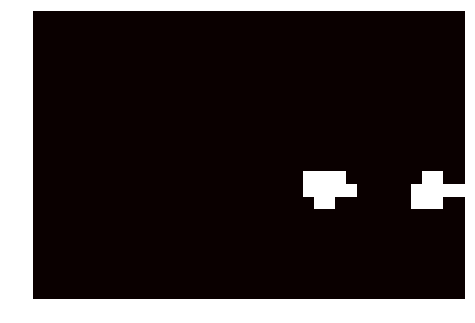

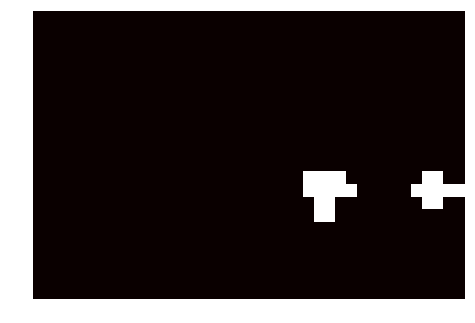

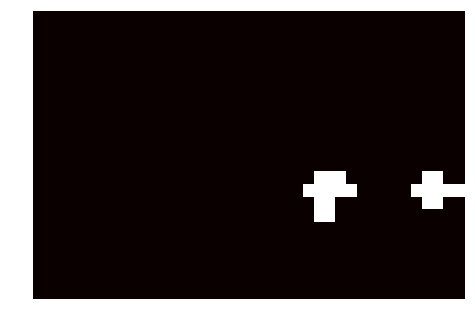

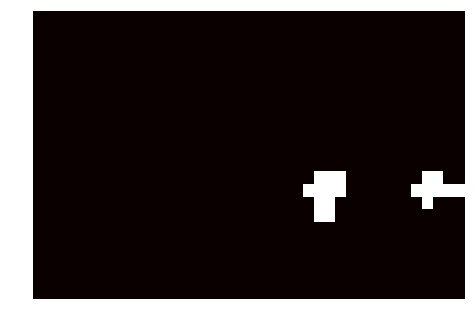

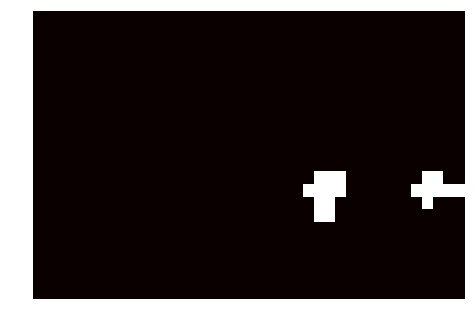

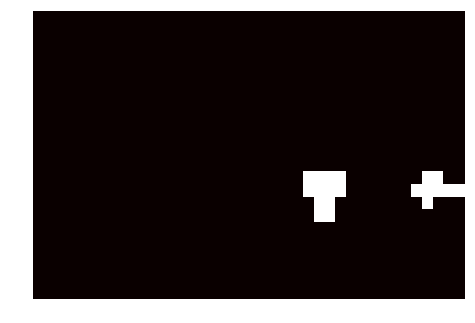

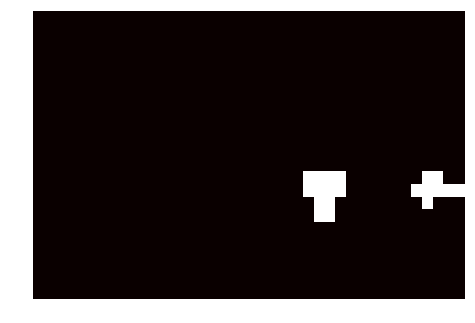

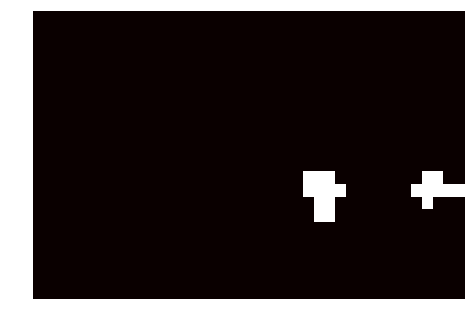

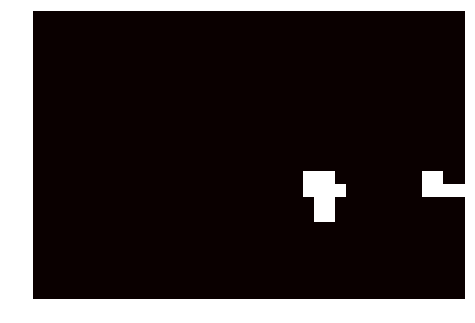

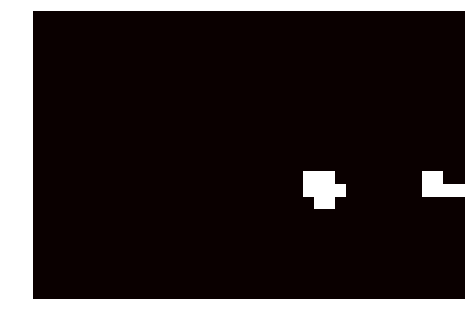

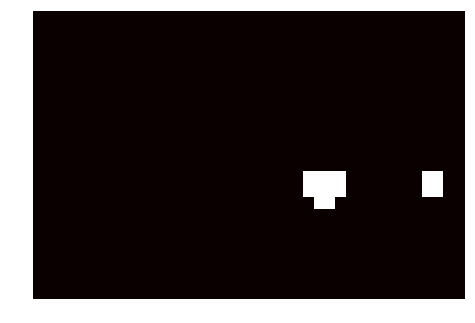

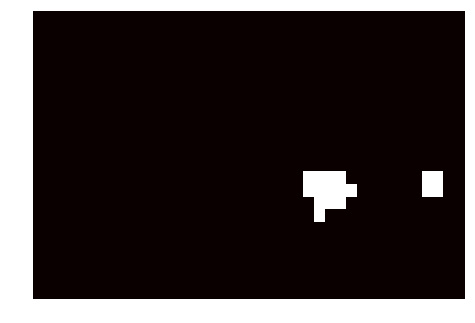

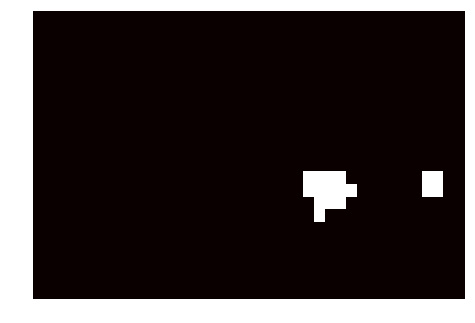

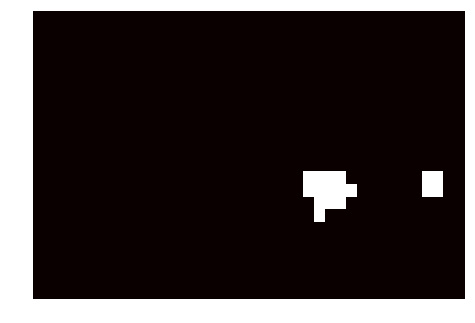

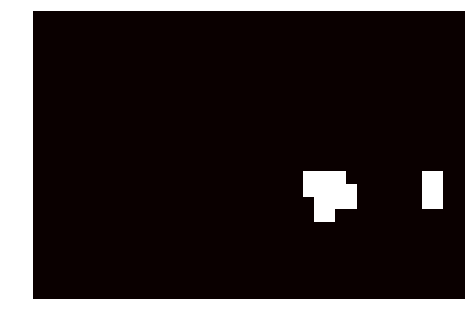

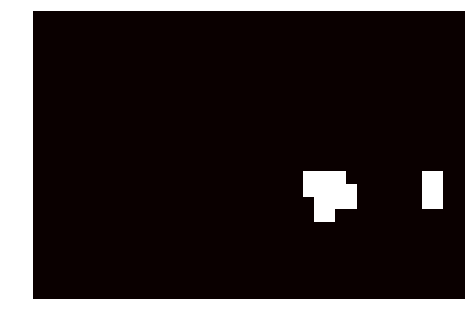

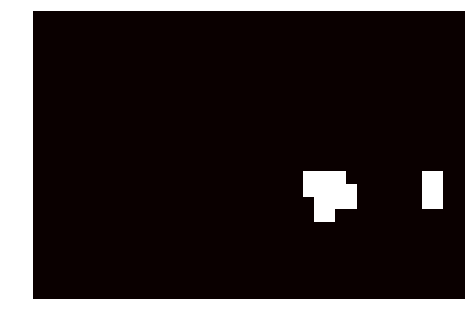

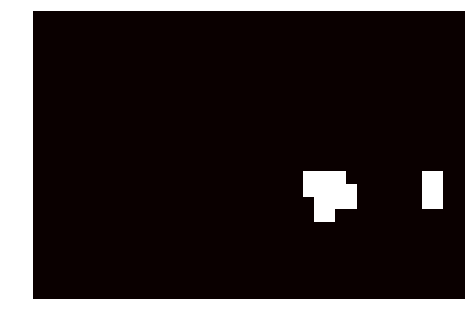

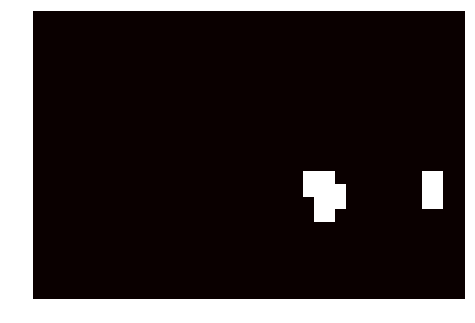

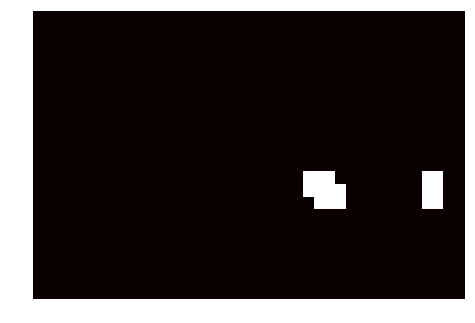

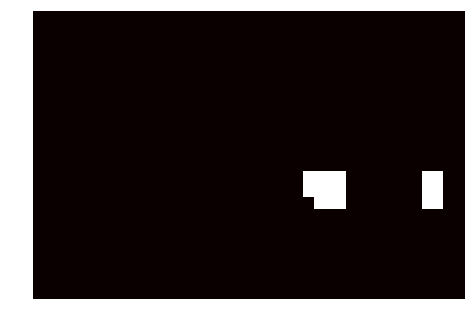

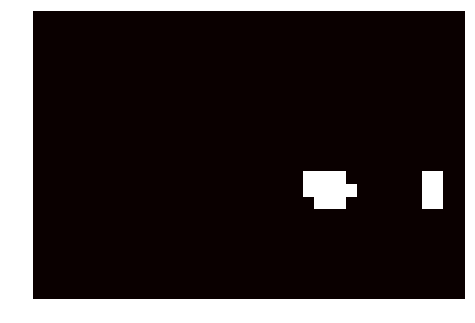

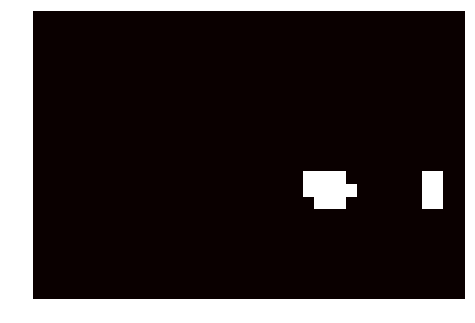

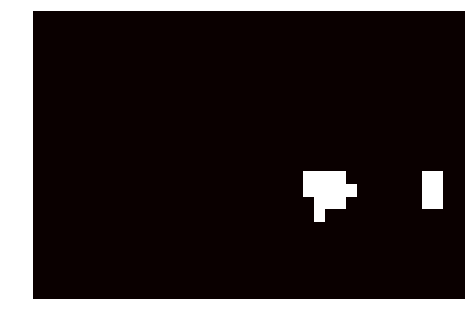

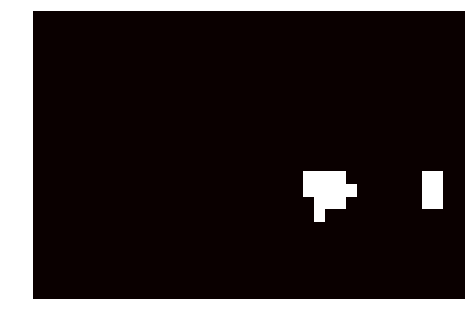

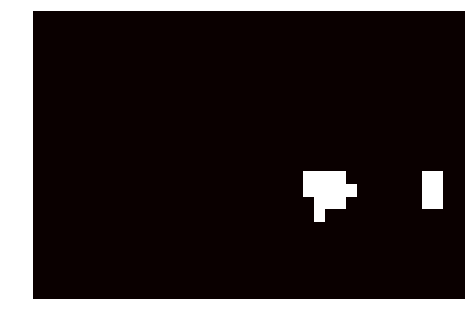

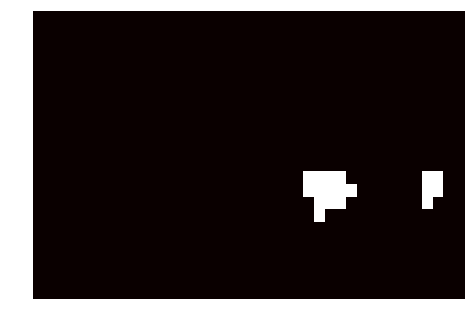

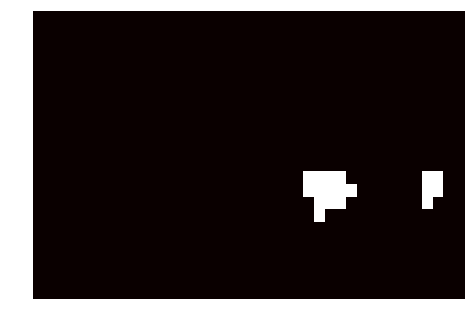

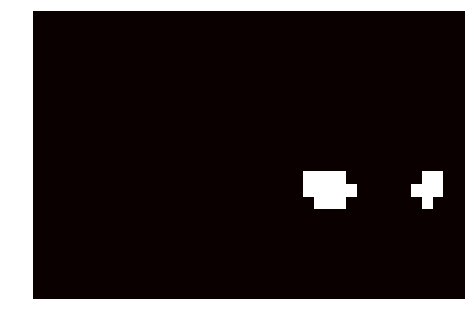

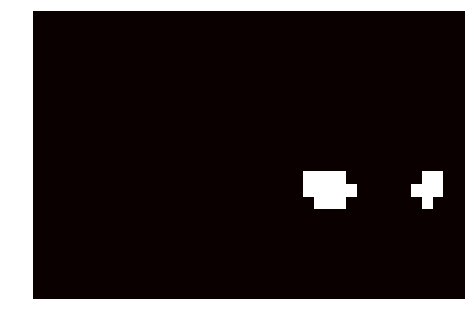

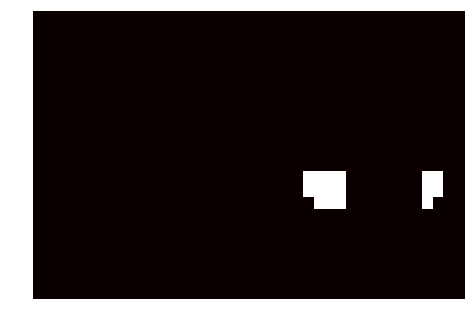

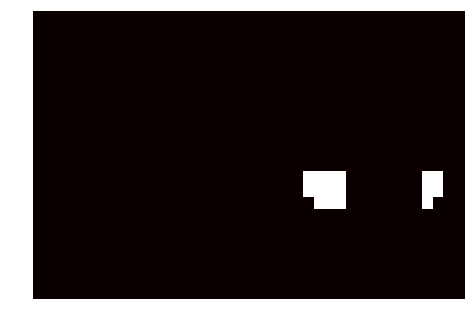

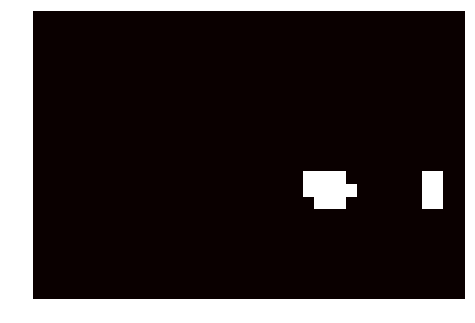

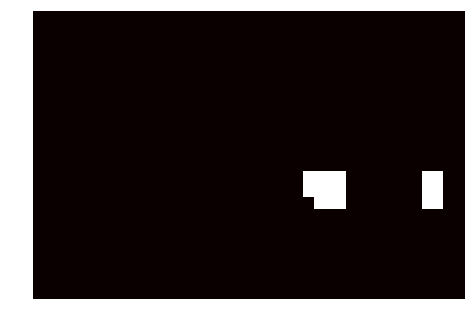

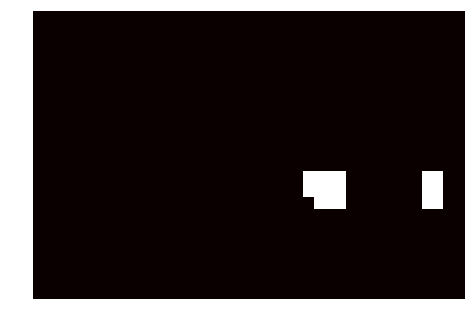

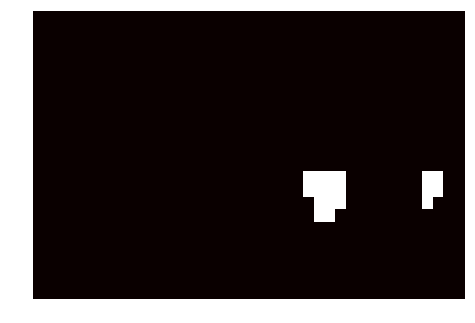

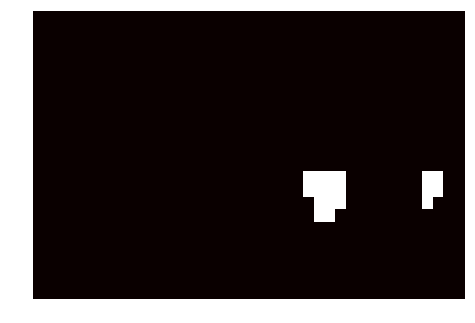

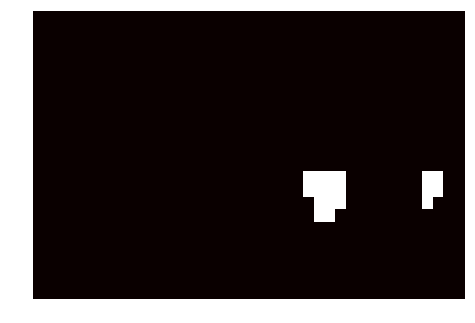

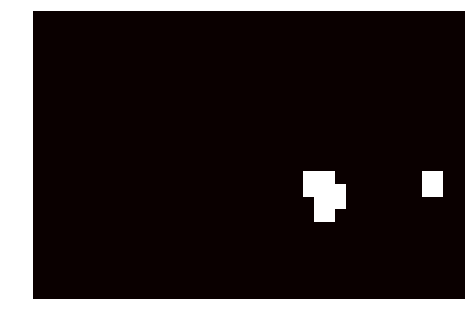

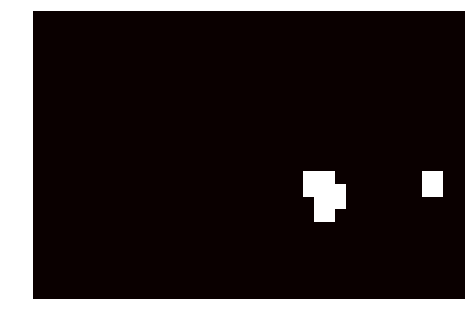

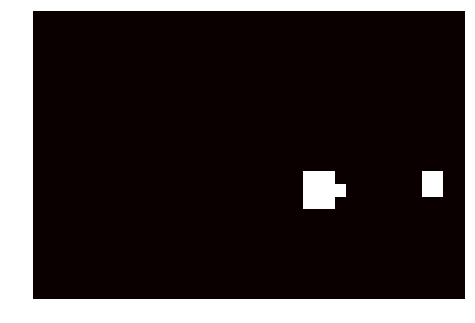

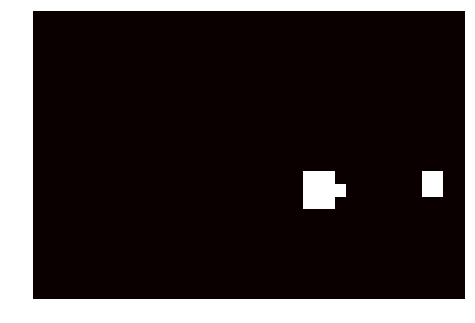

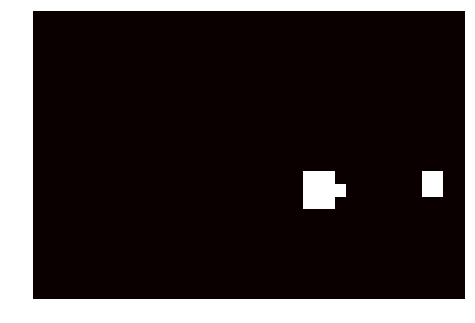

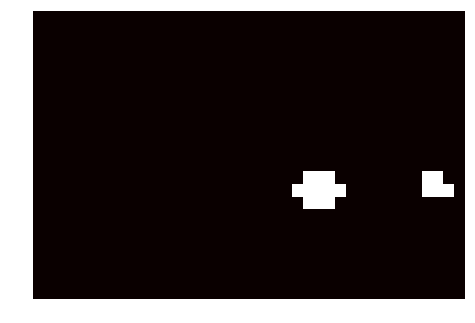

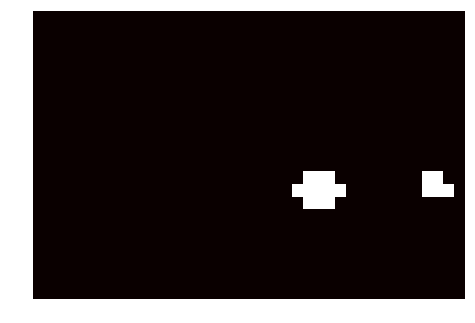

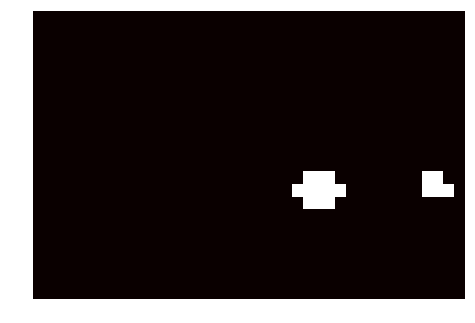

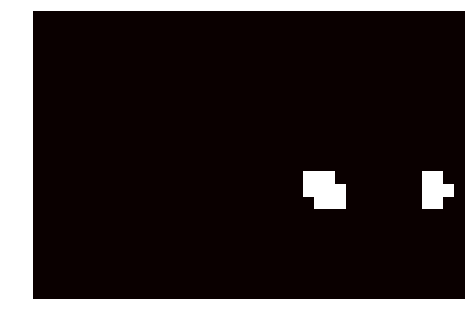

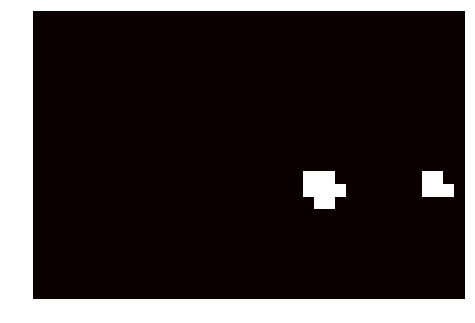

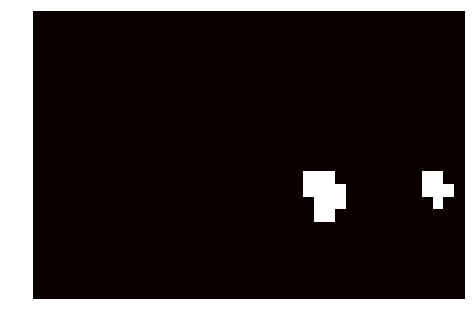

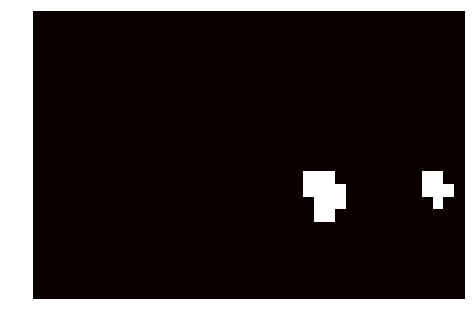

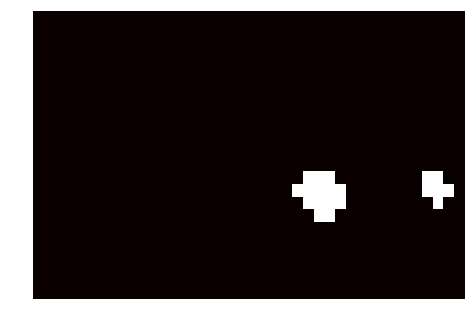

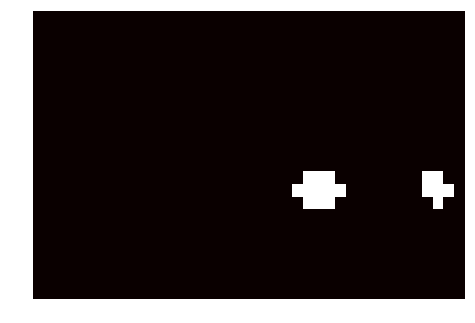

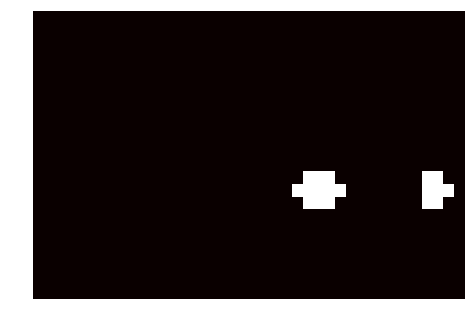

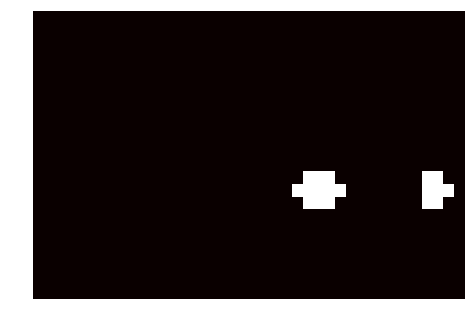

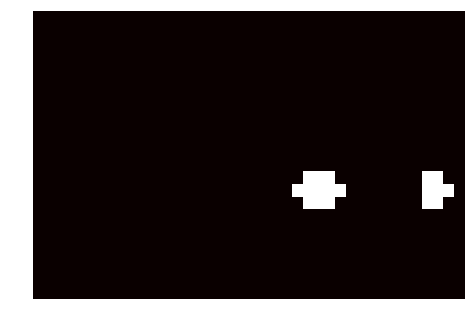

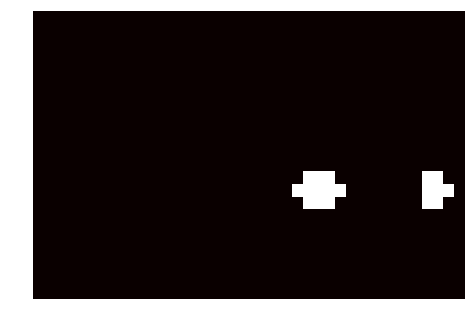

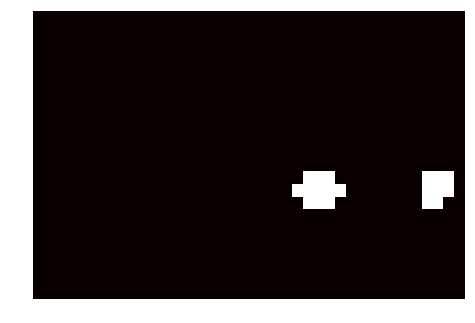

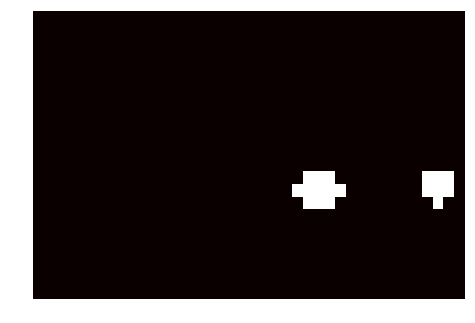

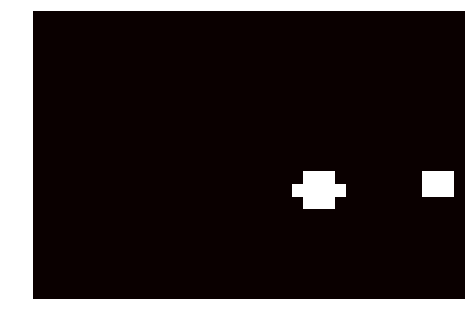

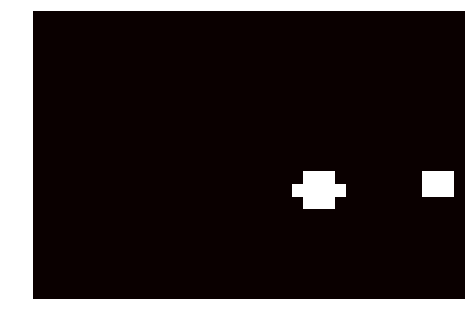

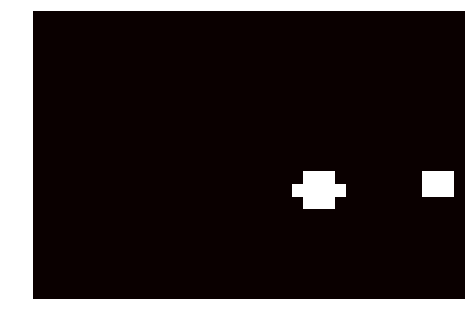

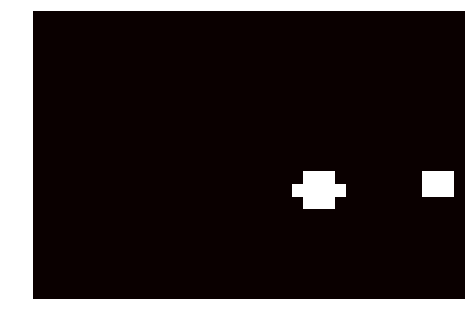

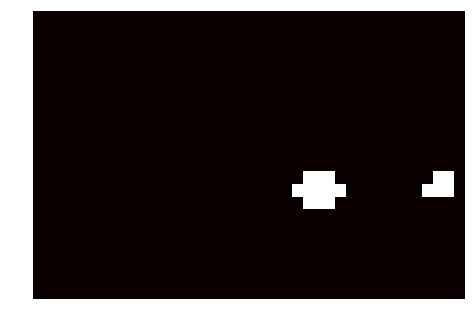

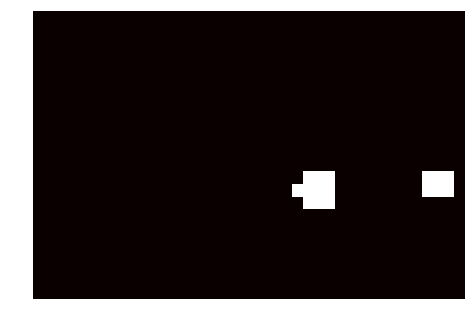

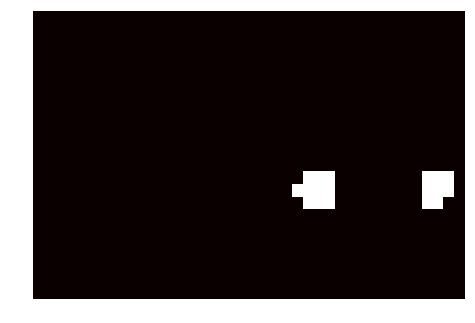

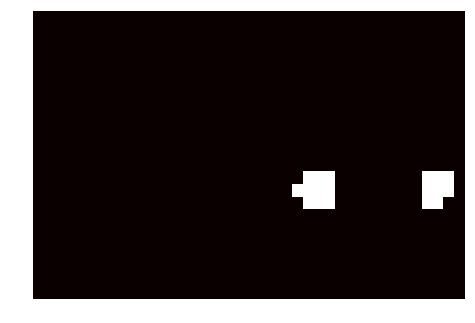

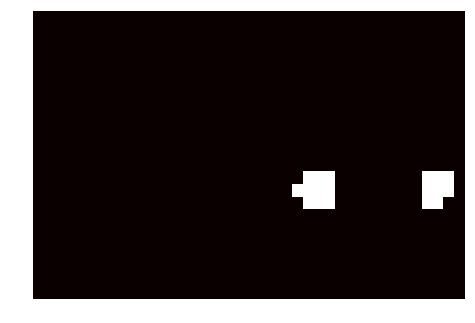

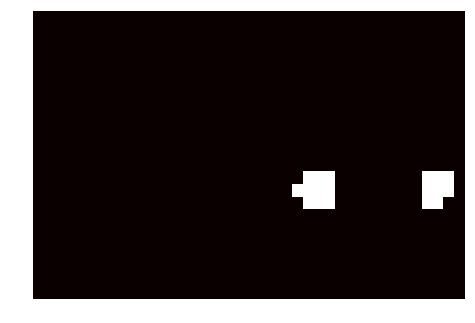

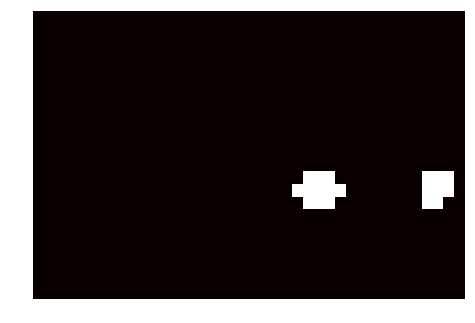

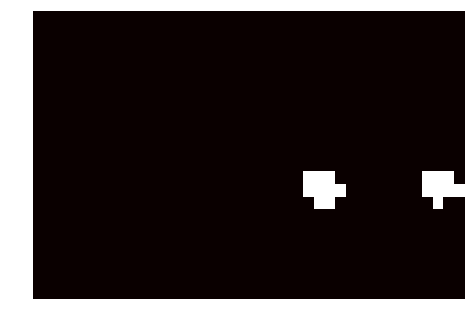

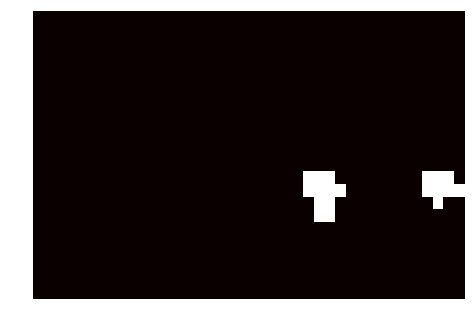

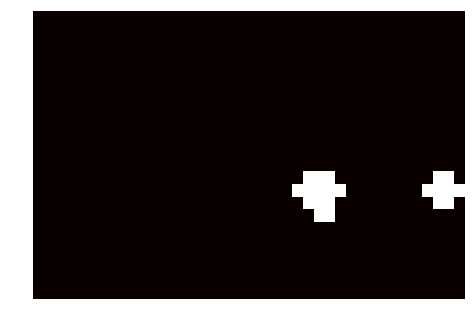

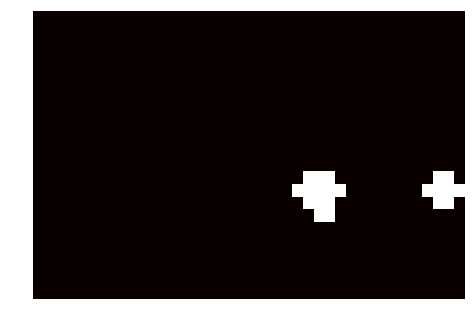

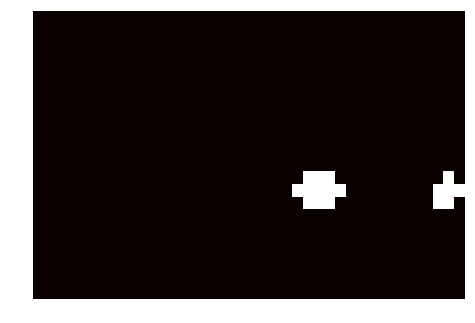

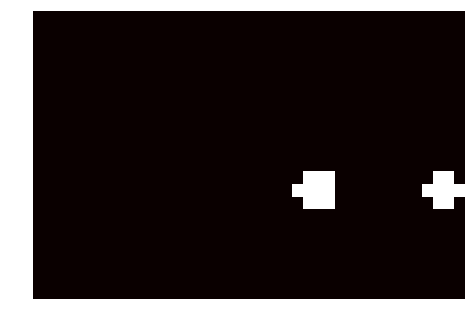

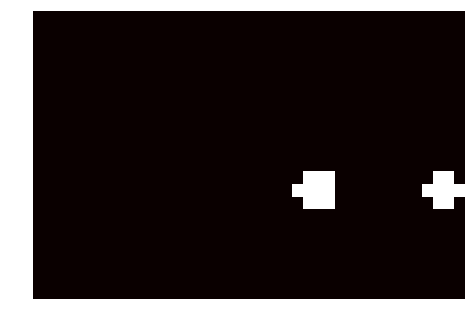

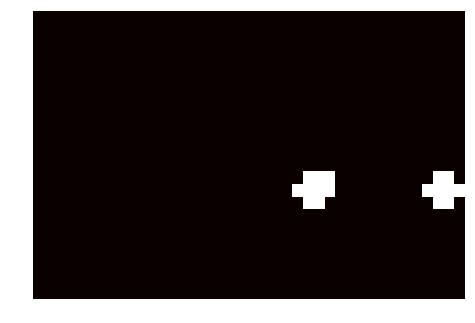

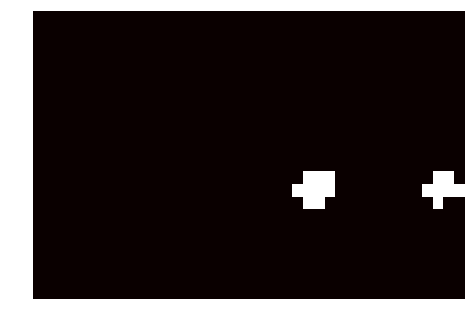

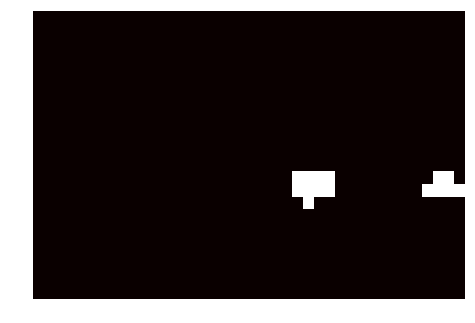

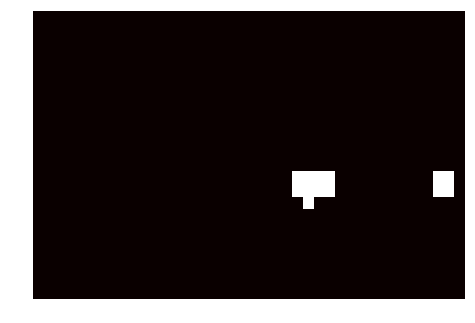

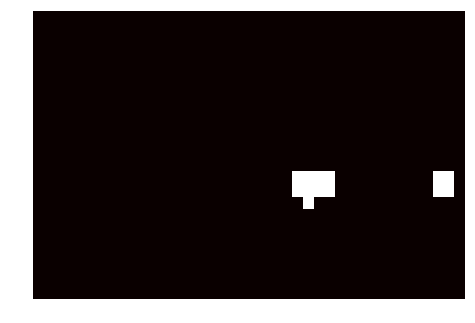

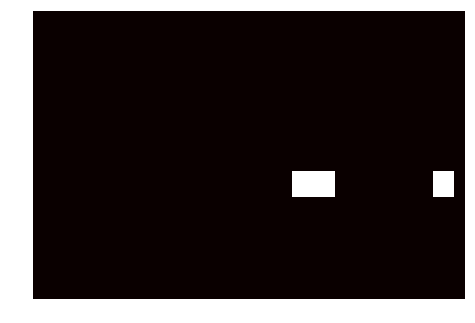

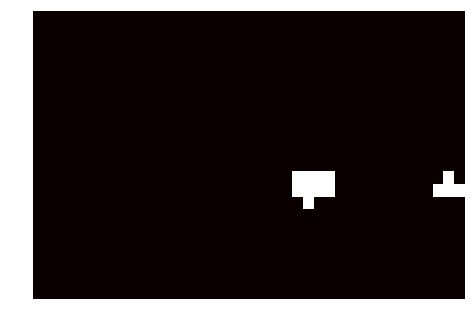

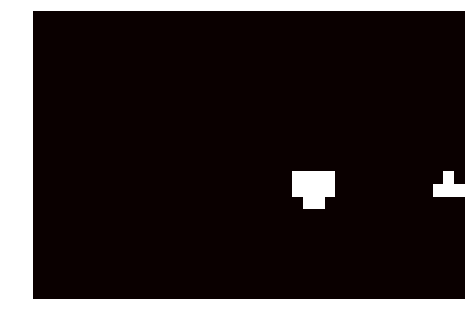

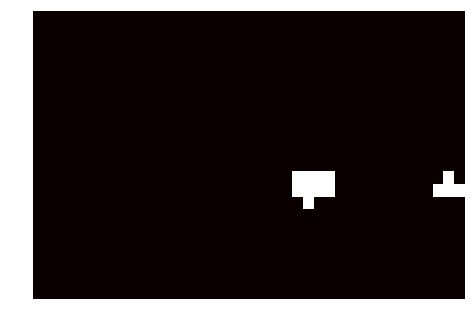

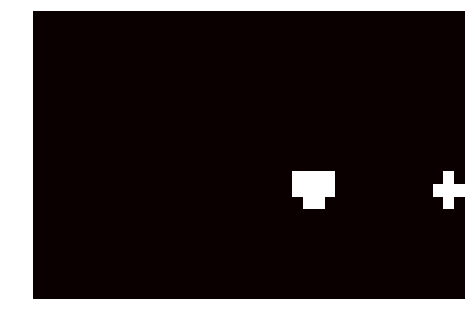

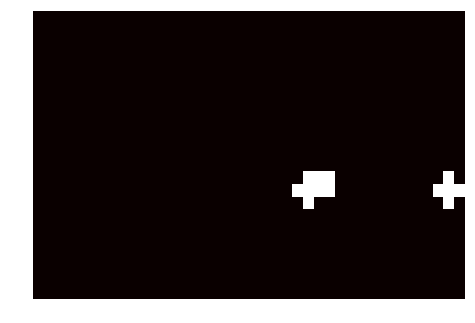

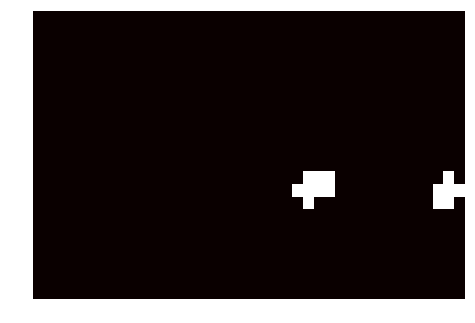

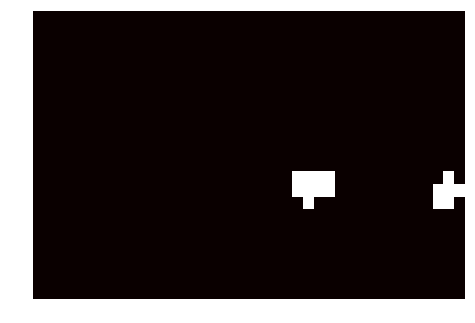

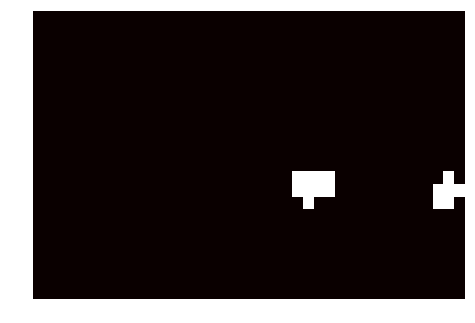

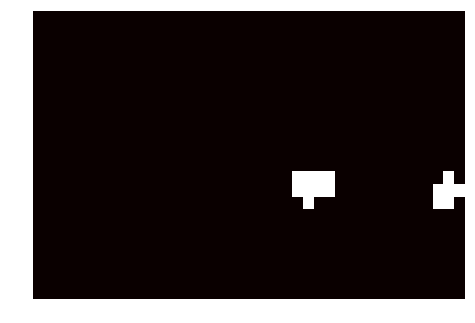

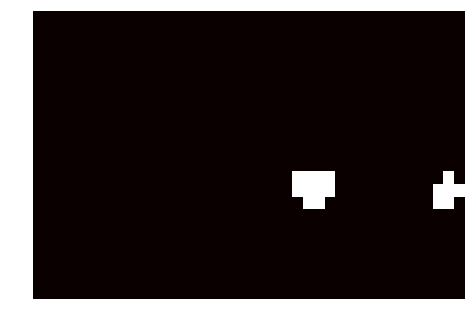

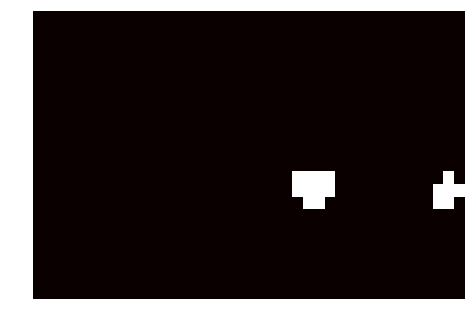

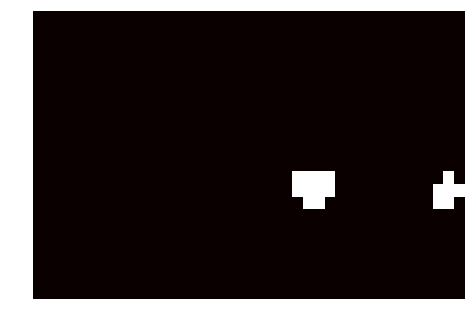

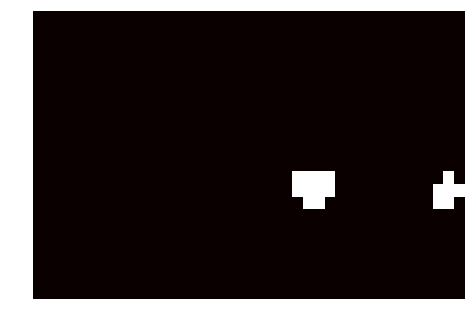

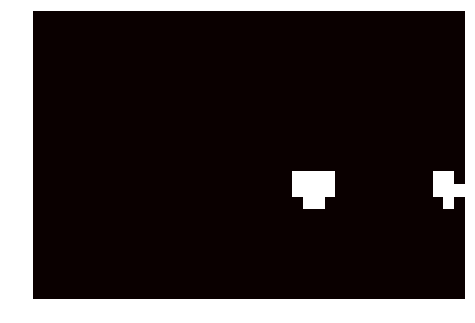

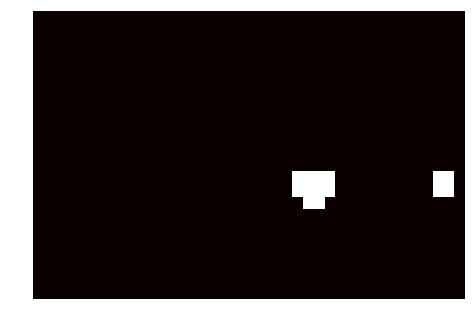

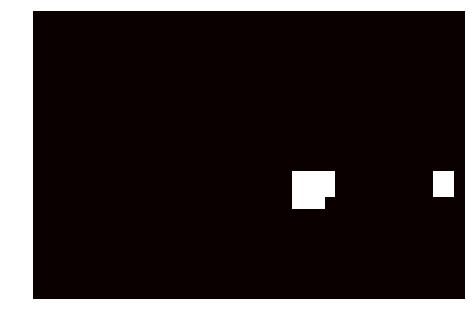

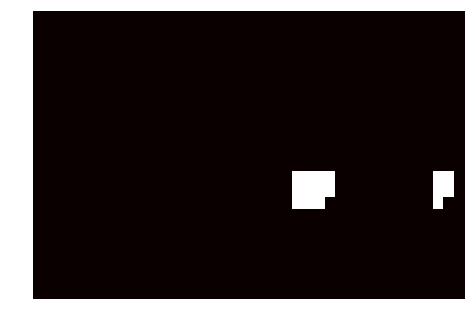

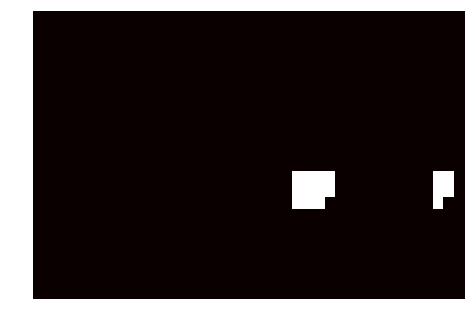

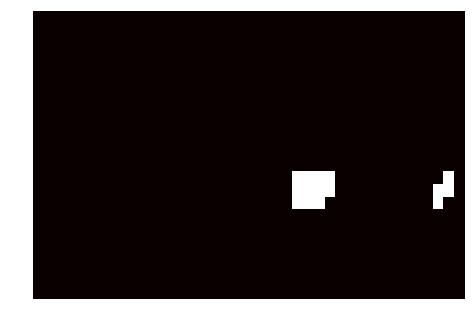

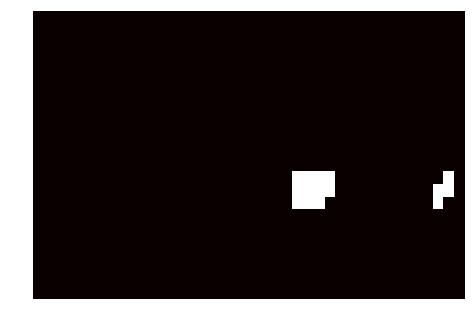

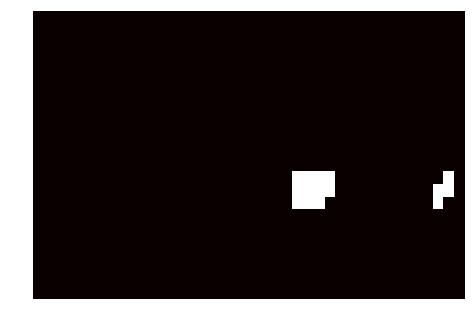

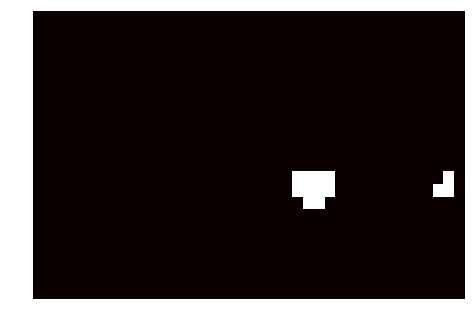

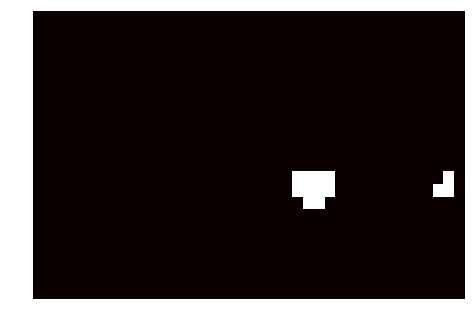

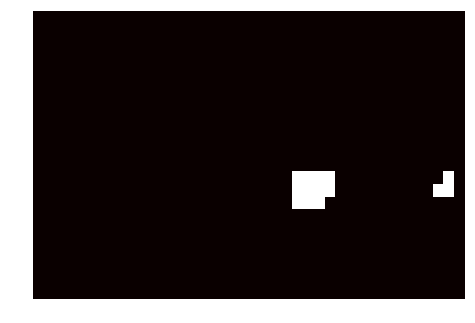

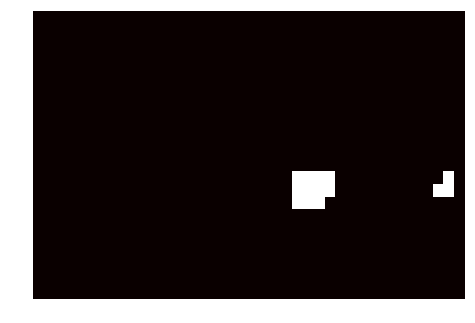

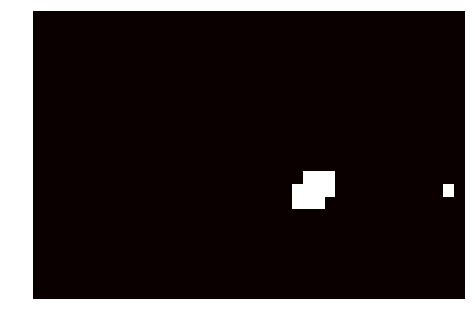

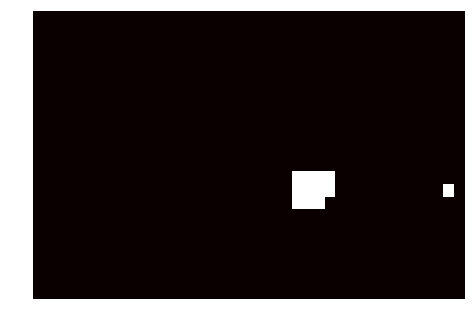

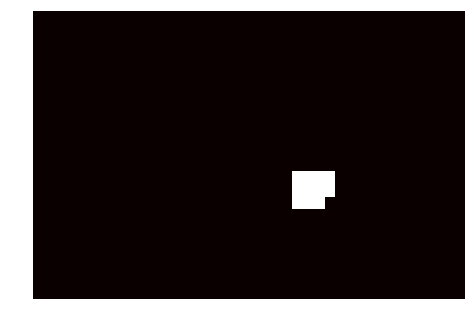

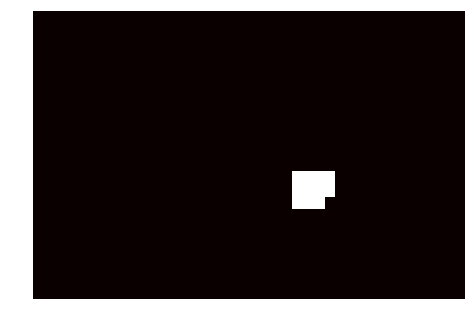

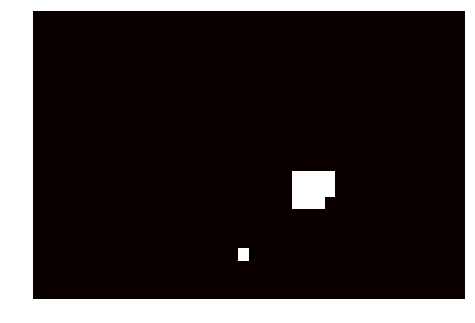

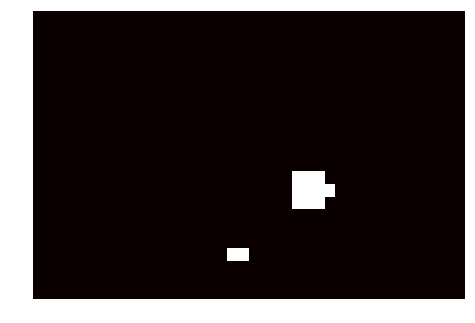

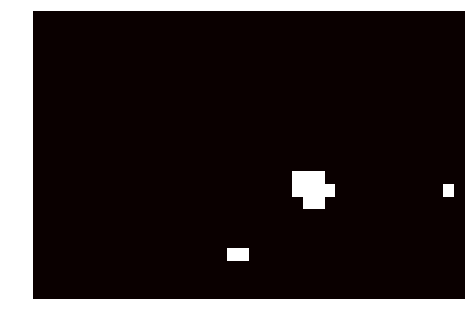

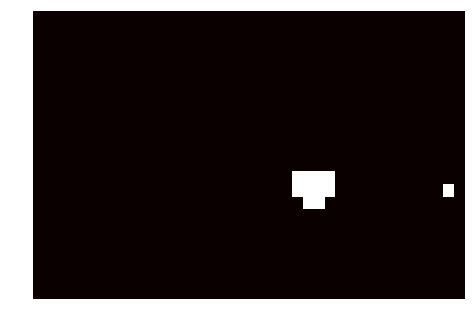

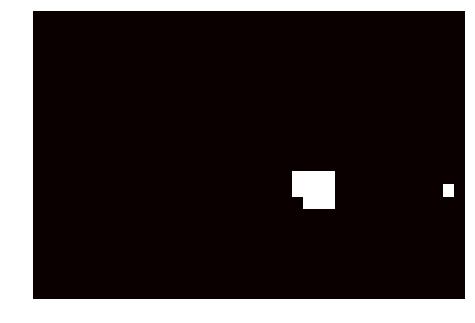

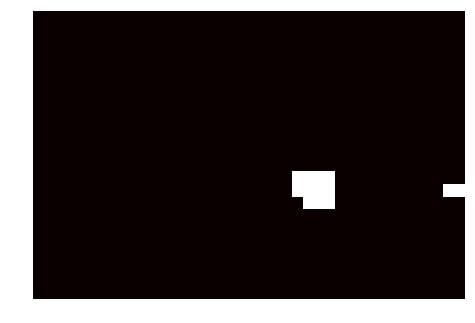

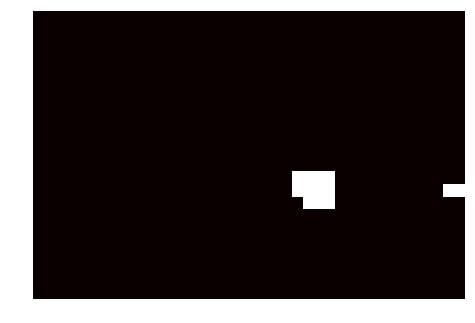

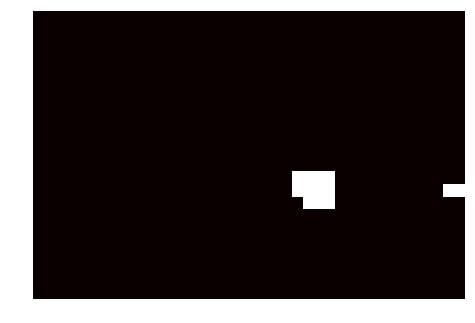

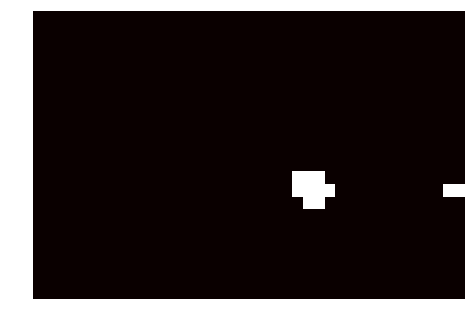

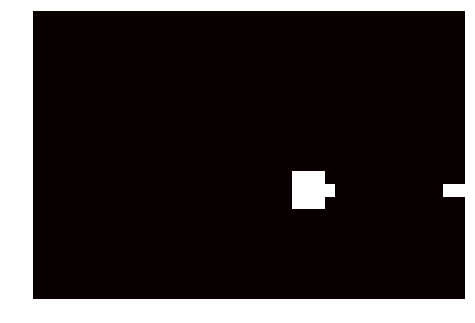

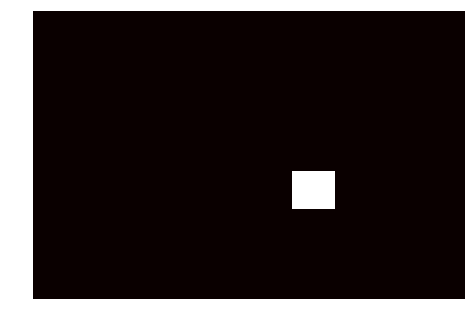

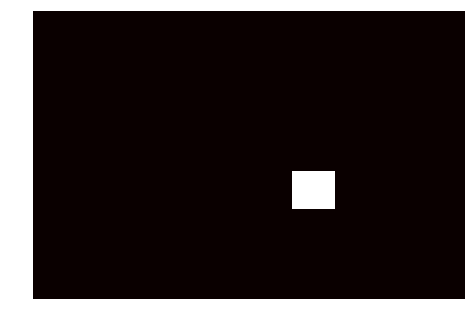

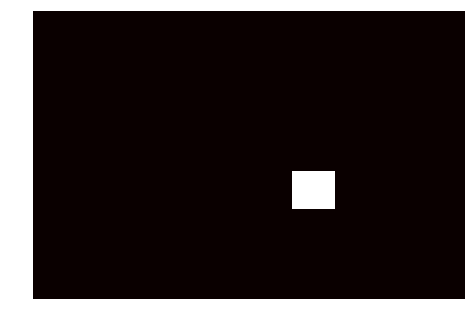

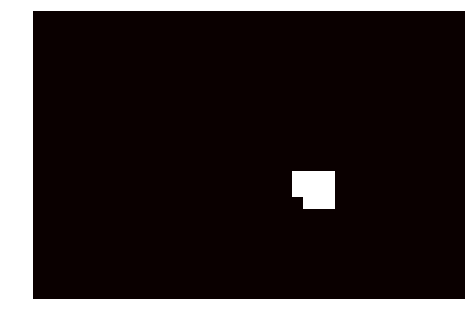

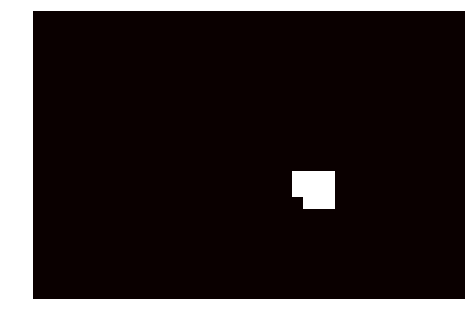

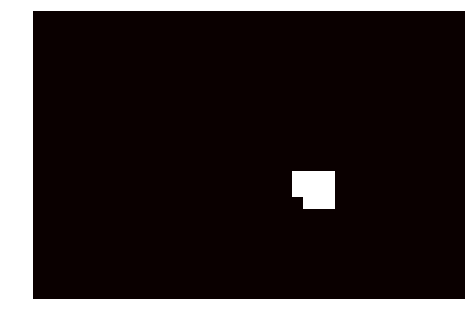

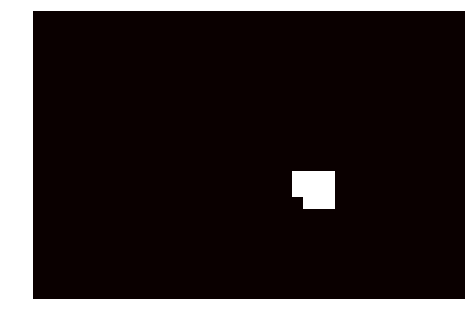

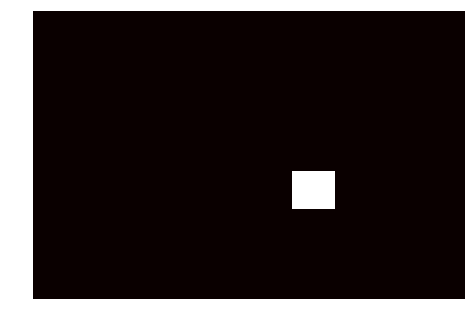

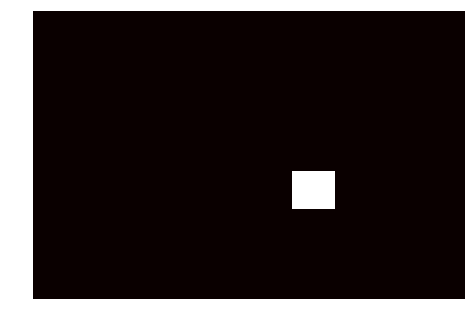

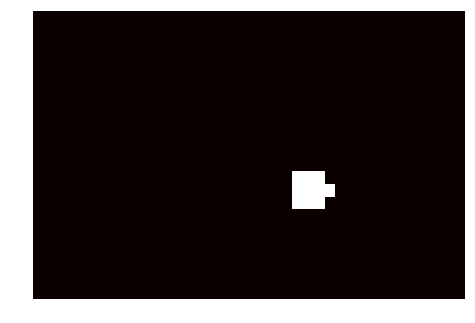

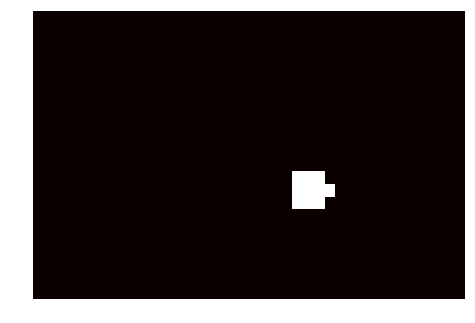

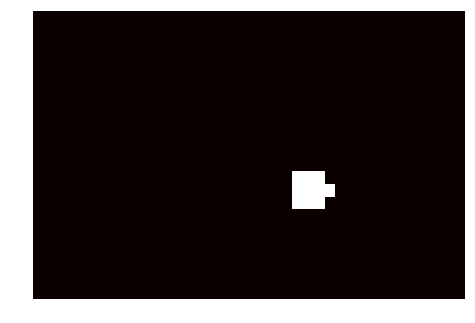

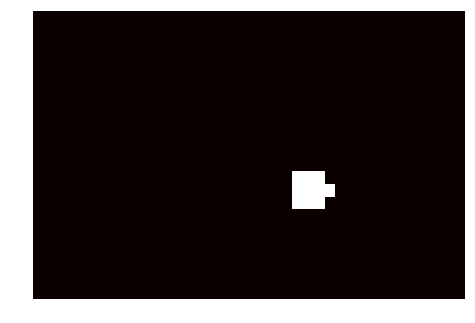

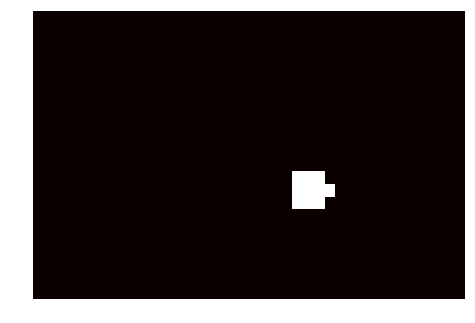

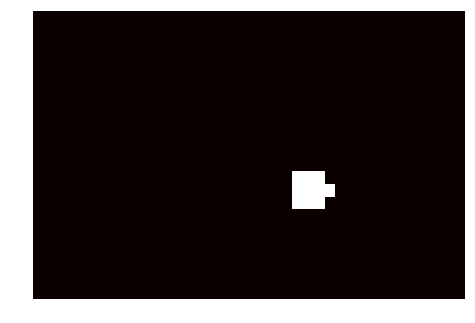

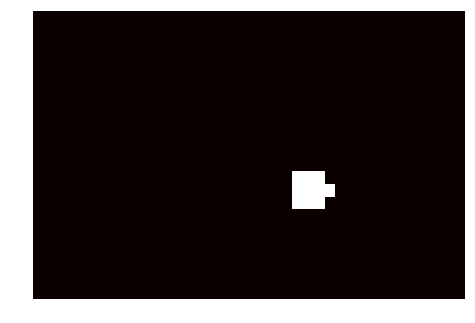

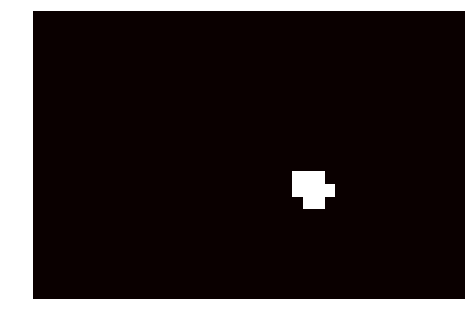

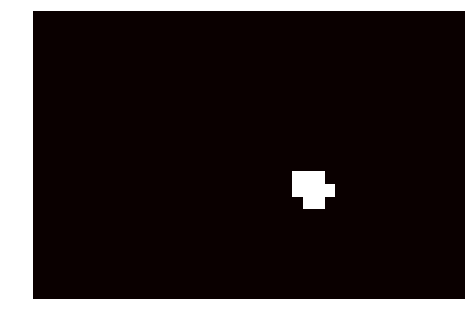

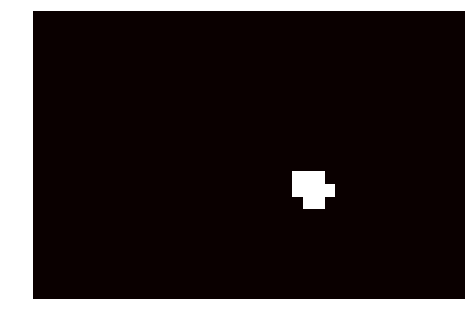

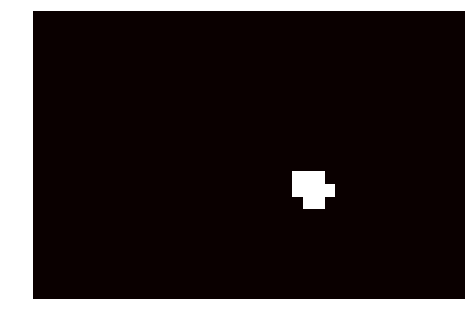

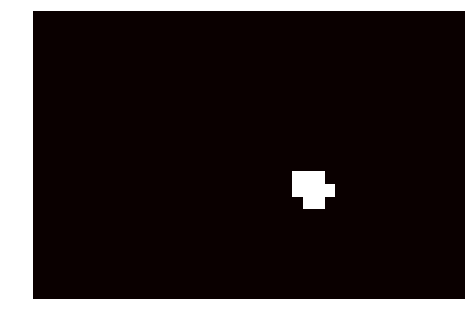

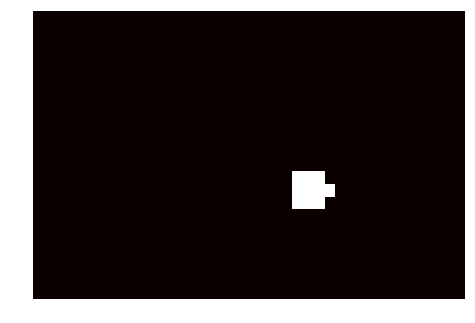

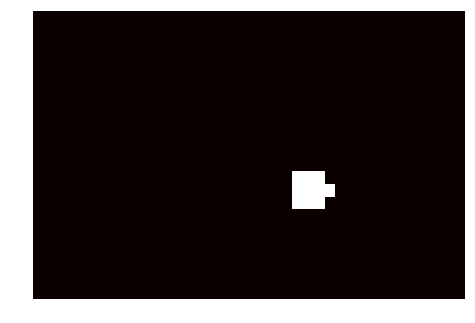

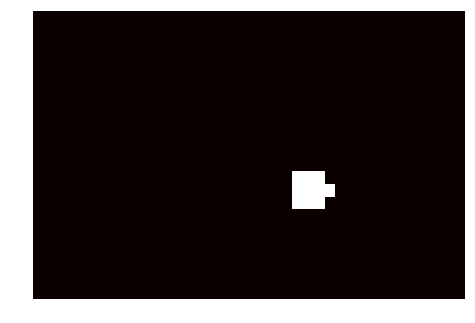

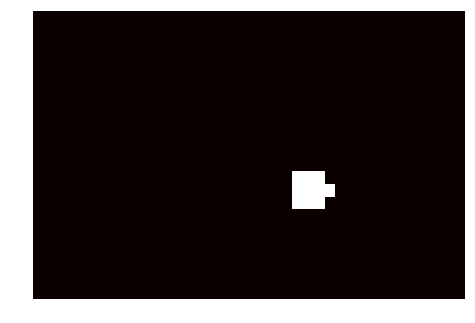

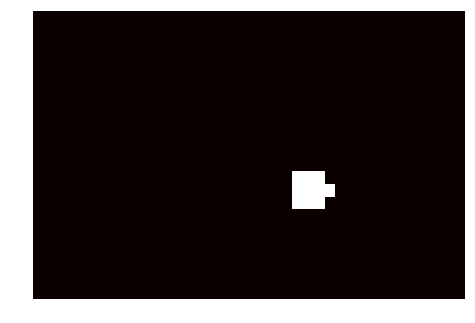

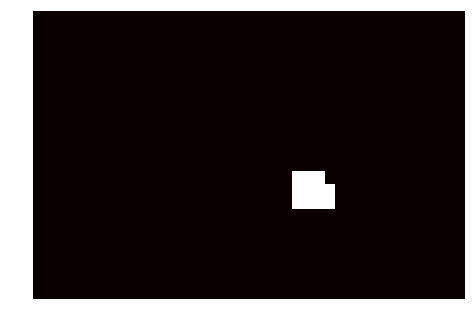

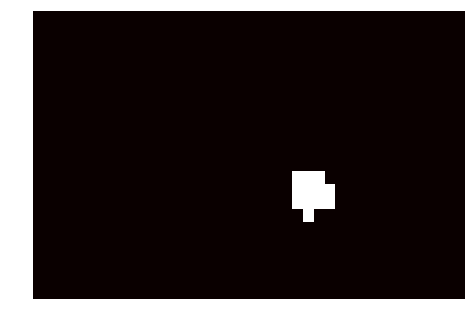

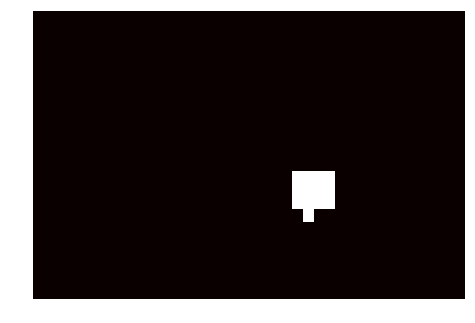

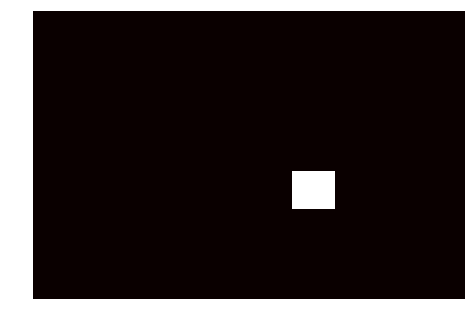

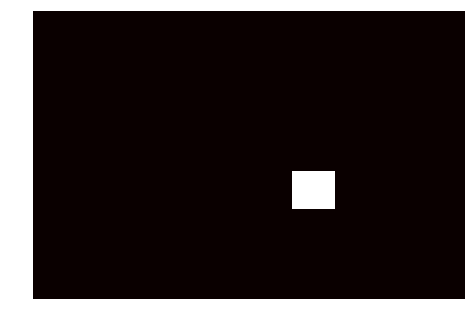

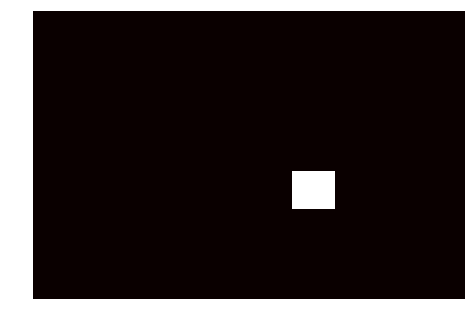

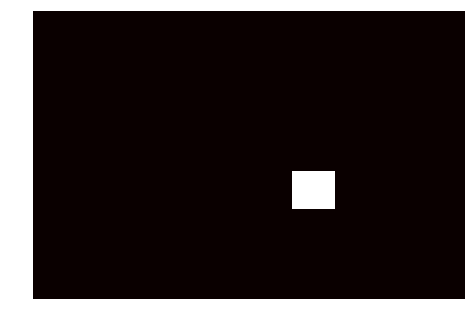

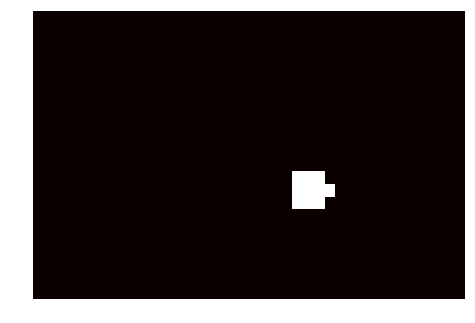

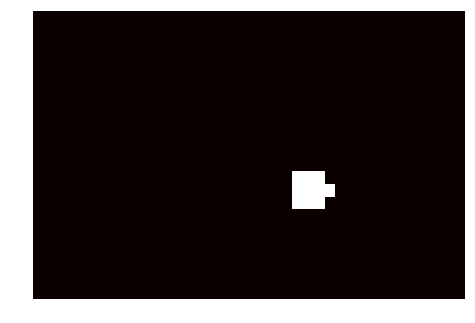

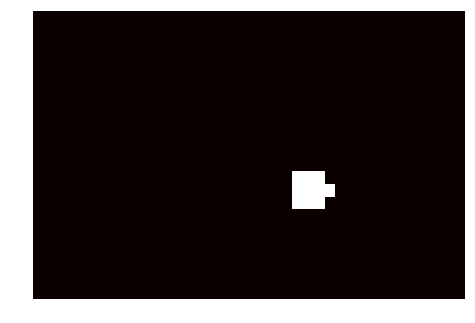

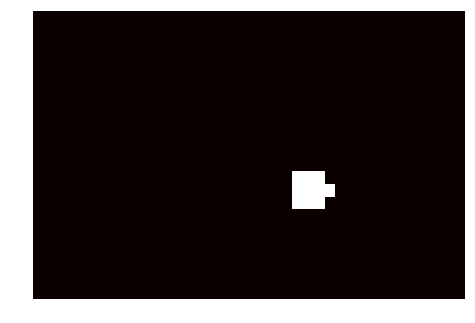

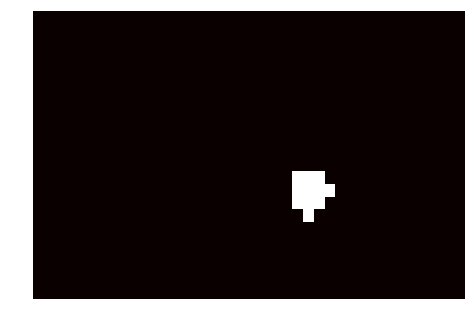

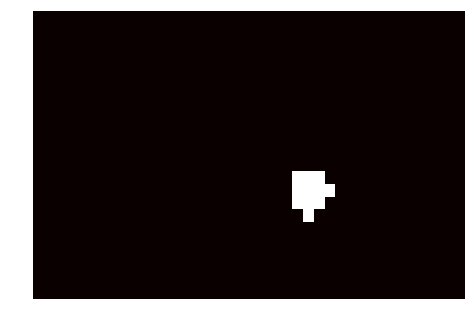

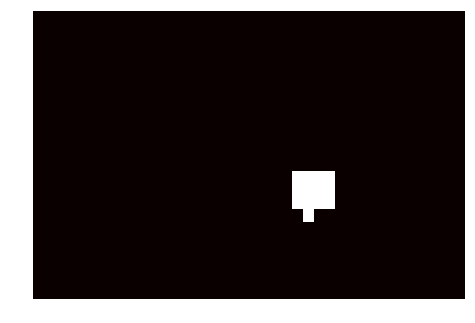

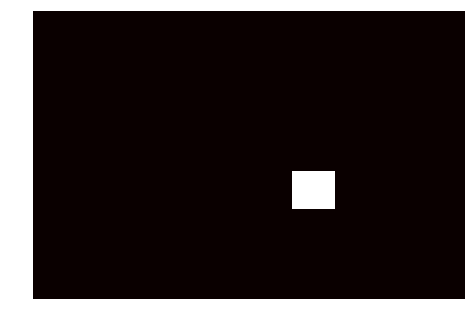

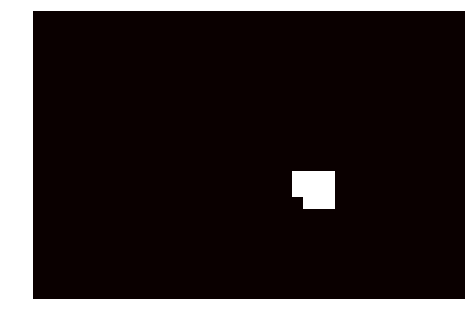

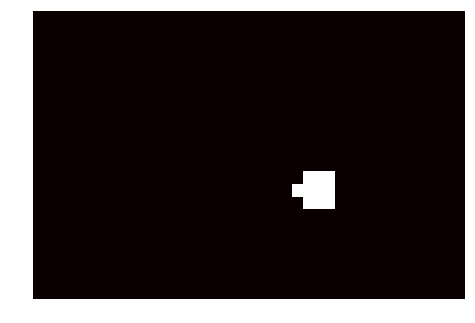

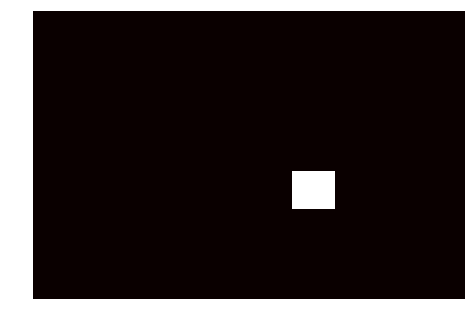

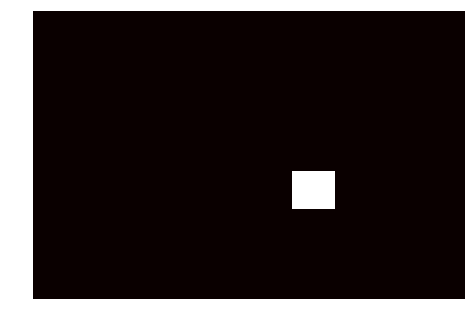

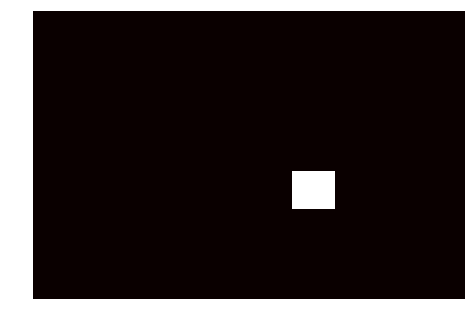

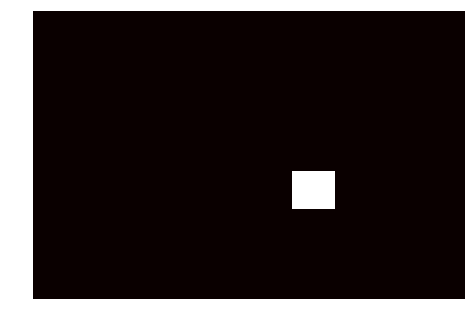

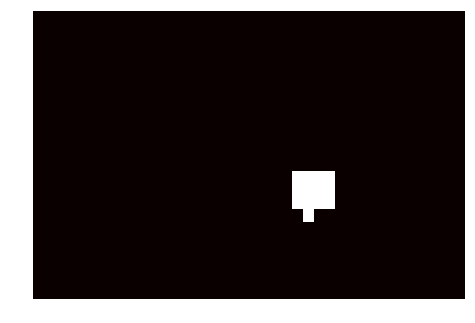

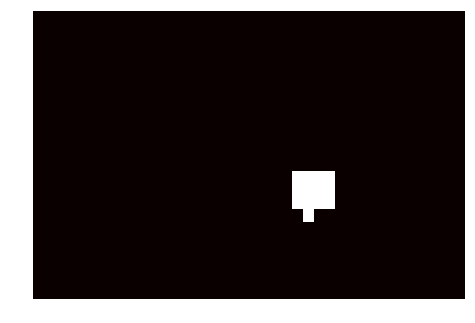

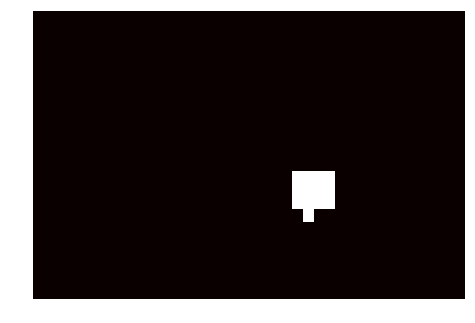

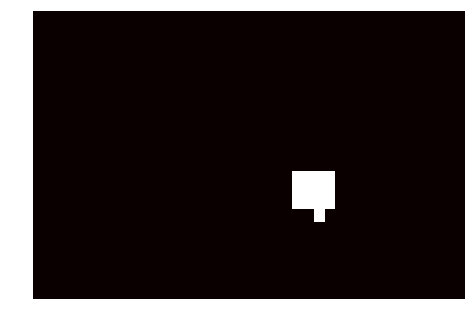

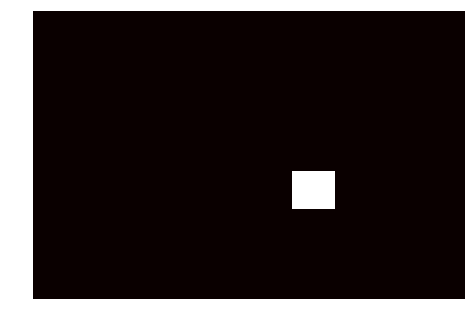

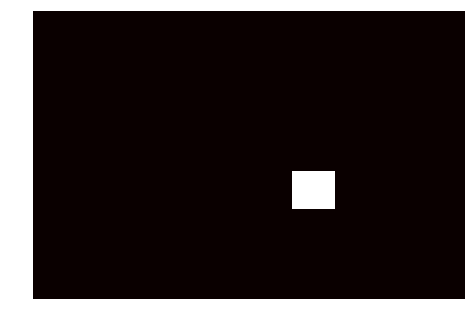

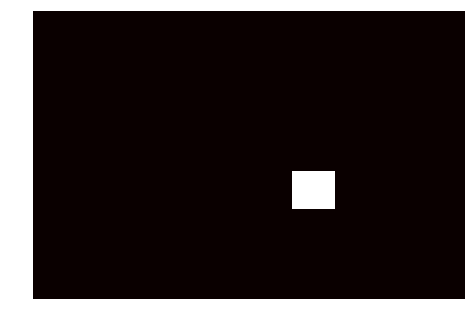

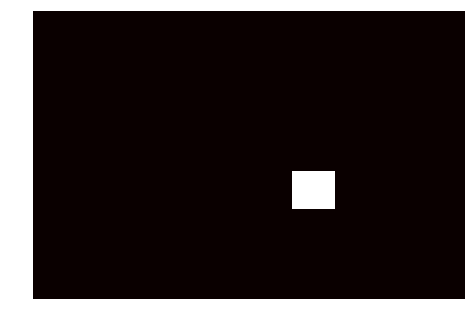

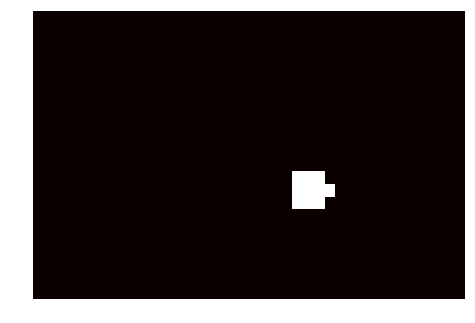

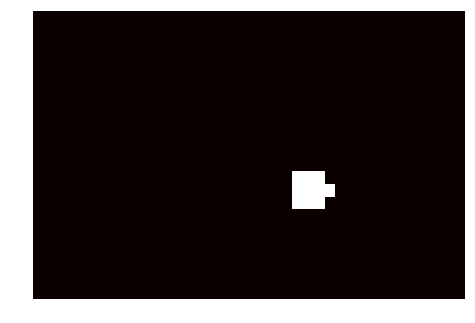

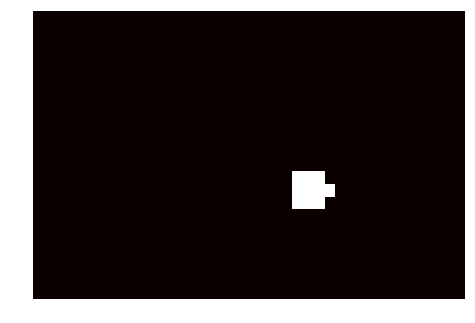

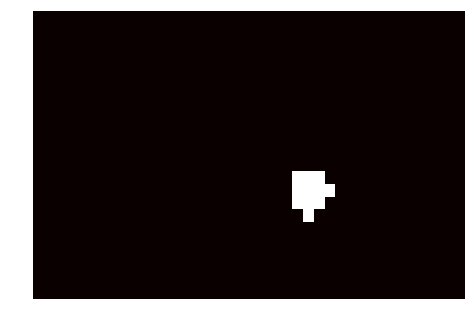

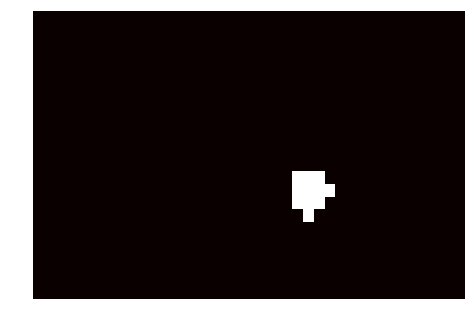

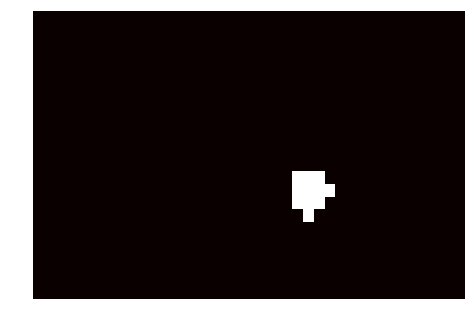

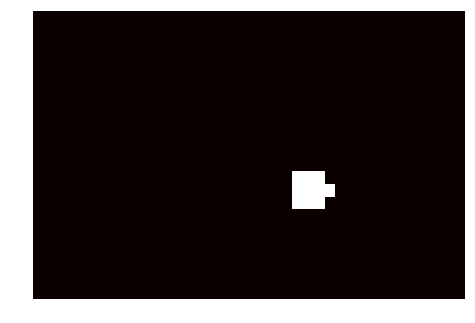

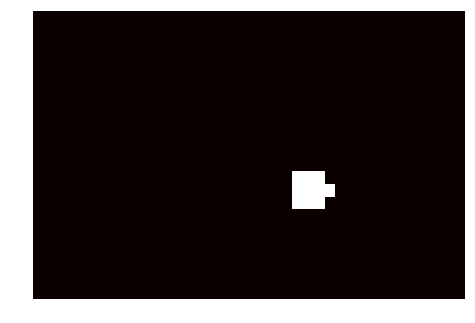

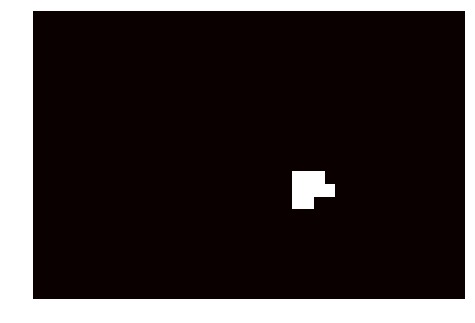

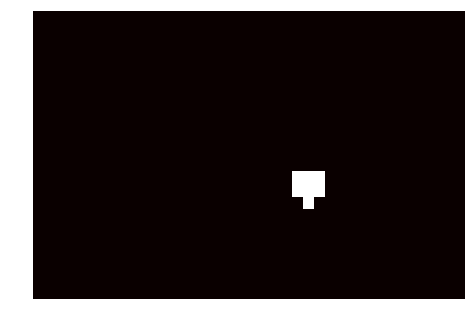

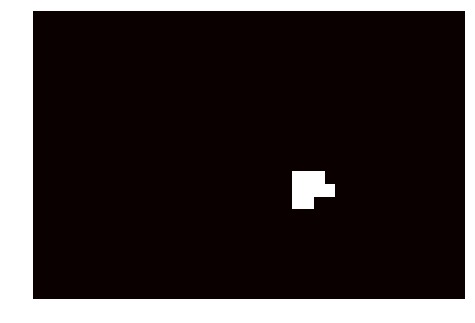

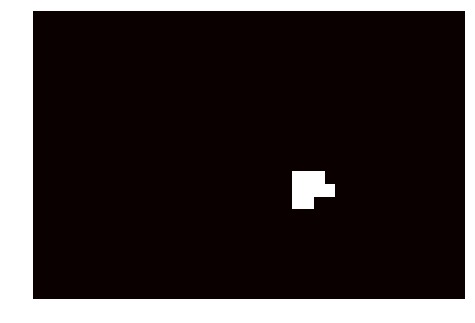

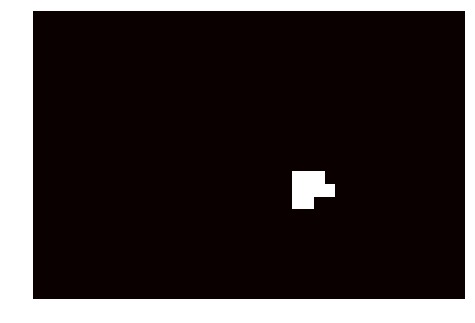

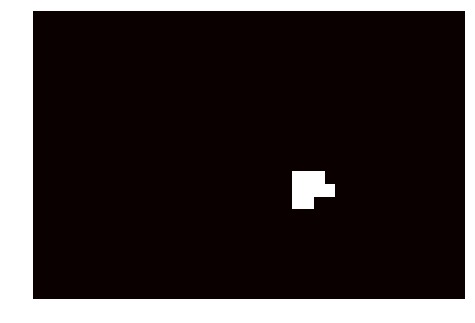

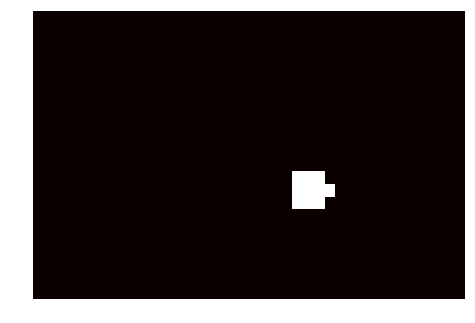

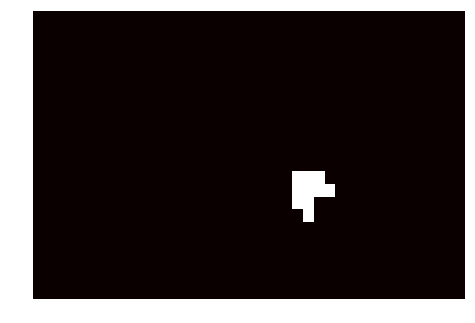

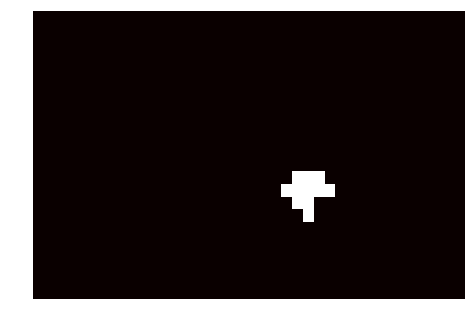

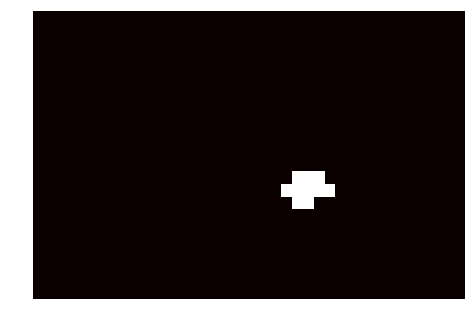

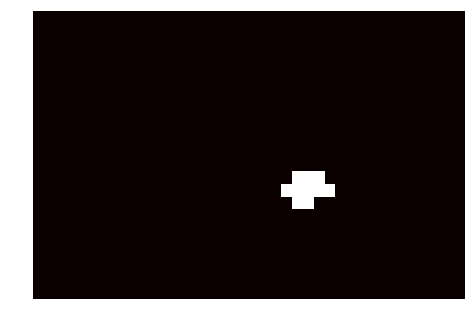

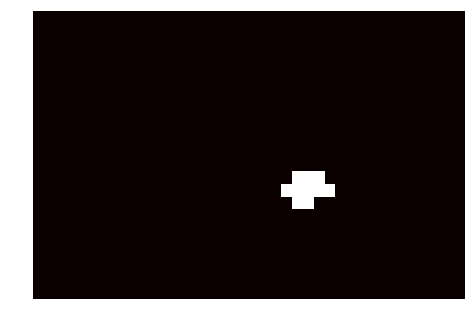

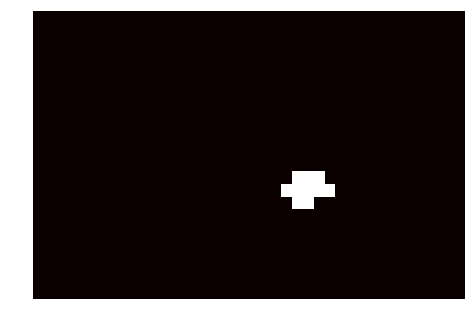

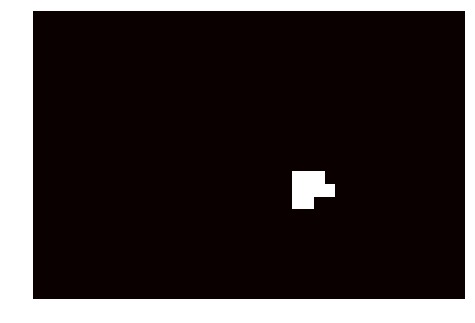

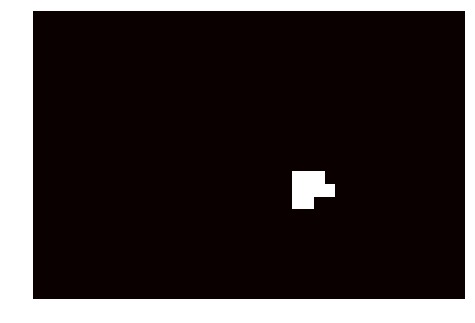

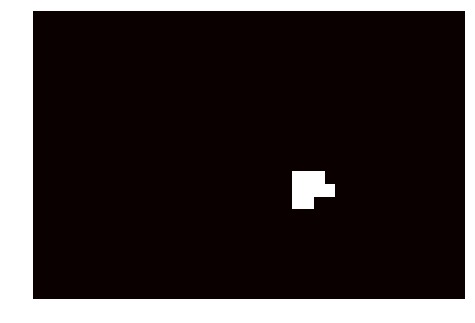

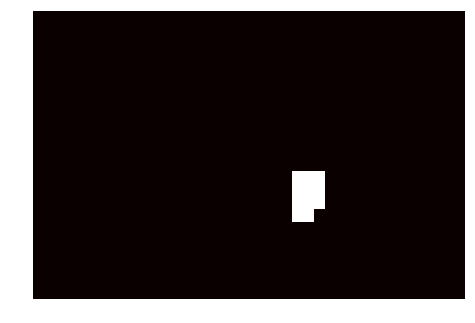

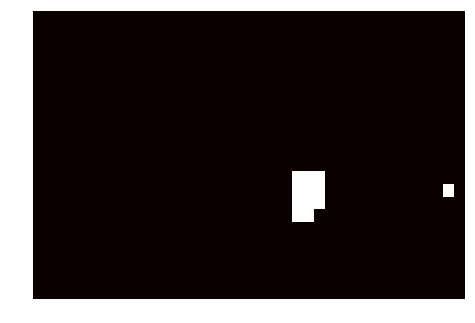

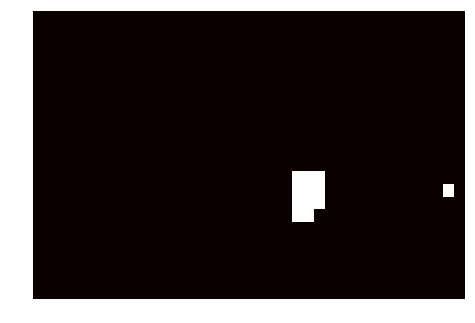

In [296]:
draw_img_arr = []
heat_map_arr = []
hot_windows_arr = []

for i, img_file in enumerate(tqdm(project_img_files)):
#for i in tqdm(range(200,220)):
    img_file = project_img_files[i]
    img = read_img(img_file, scale_to_255=False).astype(np.float32)/255.0
    
    draw_img, heat_map, hot_windows_arr = get_labeled_img_with_heatmap(img, model, 
                                                                       x_start_stop=[None, None], 
                                                                       y_start_stop=[400, None], 
                                                                       xy_window_arr=[(64, 64),(128,128)], 
                                                                       xy_overlap=(0.5, 0.5),
                                                                       hot_windows_arr=hot_windows_arr, 
                                                                       heat_threshold=10, 
                                                                       max_hot_windows=5)
    
    draw_img = add_heatmap_to_img(draw_img, heat_map)
    frame_id_txt = 'Frame #%d' % i
    draw_img = add_frame_txt(draw_img, frame_id_txt, pos=(10,60), text_color = (0, 0, 0))
    
    draw_img_file = '%s/draw_%s.png' % (draw_dir, pad_zeros(i))
    heat_map_file = '%s/heat_map_%s.png' % (heat_map_dir, pad_zeros(i))
        
    imwrite(draw_img_file, draw_img)
    imwrite(heat_map_file, heat_map)
    
    #draw_img_arr.append(draw_img)
    #heat_map_arr.append(heat_map)
    #print(i, hot_windows_arr)

In [266]:
for i in range(len(draw_img_arr)):
    draw_img = draw_img_arr[i]
    heat_map = heat_map_arr[i]
    
    plt.figure(figsize=(32, 32))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heat_map, cmap='hot')
    plt.title('Heat Map')
    plt.tight_layout()
    plt.show()